# 1. Título del proyecto

****Predicción de incumplimiento de DTN y priorización día/noche con HistGradientBoosting: un semáforo clínico–operativo****

# 2. Objetivo

**Propósito:** Estimar, al arribo, la probabilidad de **DTN>60** mediante **HistGradientBoosting** y traducirla a **prioridad por turno** (3 bandas en día; 2 en noche), optimizando el **umbral por F2 (β=2)** bajo restricciones de **PPV mínimo** y **tasa de alertas**, para habilitar **fast-track** de alto riesgo y observación estructurada de riesgo intermedio.  
**Datos:** se **cargará y trabajará sobre un dataset sintético** generado para este proyecto (≈2000 filas) con variables clínicas, operacionales y de proceso.  
**Tarea de ML:** **regresión** (DTN continuo), **clasificación** (retraso > umbral) y **selección/interpretabilidad** (importancias/coeficientes).
**La clase positiva se definió como DTN > 60 min (columna delay_gt_60 = 1)** La tarea es de clasificación binaria para anticipar retrasos operativamente relevantes.”

# 4. Descripción del Conjunto de Datos  

## a. Fuentes de datos  
El proyecto se desarrolló a partir del dataset sintético **`synthetic_stroke_candidates`**, generado con base en literatura internacional, guías clínicas de ACV isquémico y experiencia local en servicios de urgencia.  
Fue construido con una **semilla fija (seed=42)** para garantizar reproducibilidad y trazabilidad, e incluye **2000 registros** y **24 variables**, representando pacientes adultos candidatos a trombólisis en un hospital urbano con neurólogo disponible 24 h, sin neurocirugía ni RM.  

La inclusión de **variables clínicas, demográficas, logísticas, radiológicas, temporales y de outcomes** responde a la necesidad de capturar los factores que influyen directamente en el tiempo puerta–aguja (DTN) y en la eficiencia del flujo asistencial.  
El dataset incorpora además un **porcentaje de valores faltantes promedio ≈2,5%** (máximo **11,4%** en `onset_to_needle`), simulando la incompletitud habitual de registros hospitalarios y fortaleciendo el proceso de imputación y modelado.  

**Creación del dataset sintético y definición de cohorte:**  
- La cohorte se definió en **candidatos a trombólisis**, y no solo en trombolizados, con el fin de identificar tanto a los pacientes que llegaron a la terapia como a quienes no lo hicieron por retrasos o criterios clínicos.  
- Esto evita sesgo de selección y permite analizar **brechas reales en el flujo asistencial**.  
- El dataset incluye:  
  - **Pacientes trombolizados**, para análisis específico de DTN.  
  - **Pacientes no trombolizados**, con motivo implícito (demoras, exclusiones clínicas, decisión médica/paciente).  

De esta forma, los modelos pueden mapear cuellos de botella en todas las etapas del código ACV, y no únicamente en quienes recibieron tratamiento.  

---

## a.1 Criterios de inclusión y exclusión  
El dataset simula únicamente pacientes **candidatos a trombólisis**, siguiendo criterios internacionales (AHA/ASA, ESO) y adaptaciones locales:  

| **Criterios**           | **Detalle** |
|--------------------------|-------------|
| **Inclusión** | - Diagnóstico clínico de ACV isquémico con déficit medible<br>- Edad ≥18 años<br>- Último momento conocido bien (LKW) < 4,5 h<br>- PA ≤185/110 mmHg pretratamiento<br>- Glucosa >50 mg/dL<br>- NIHSS 5–23<br>- ASPECTS ≥7<br>- mRS basal 0–1 |
| **Exclusión absoluta** | - Hemorragia intracraneal o subaracnoidea<br>- Infarto extenso (>1/3 ACM)<br>- PA no controlable >185/110<br>- Hemorragia activa<br>- Cirugía mayor o trauma craneoencefálico <3 meses<br>- Plaquetas <100.000, INR >1,7<br>- Anticoagulación activa<br>- Punción arterial reciente en sitio no compresible |
| **Exclusión relativa** | - Síntomas leves o en rápida mejoría<br>- Edad >80 años en ventana extendida<br>- Historia de ACV + DM<br>- NIHSS >25 en ventana extendida<br>- Enfermedades terminales<br>- Falta de consentimiento informado |

---

## a.1.2 Metas internacionales de tiempos críticos  
Basadas en **AHA/ASA**, **ESO** y los paquetes de mejora **Target: Stroke (Fases II–III)**:  

| **Intervalo** | **Columna(s)** | **Meta base** | **Meta intensiva 45** | **Meta intensiva 30** |
|---|---|---:|---:|---:|
| Door→Neurólogo | `arrival_datetime` + `t_neuro` | ≤15 min | ≤10 min | ≤5 min |
| Door→Imaging (DTI) | `door_to_imaging` | ≤25 min | ≤20 min | ≤15 min |
| Imaging→Decisión | `imaging_to_decision` | ≤30 min | — | — |
| Decisión→Aguja | `decision_to_needle` | ≤15 min | — | — |
| Door→Needle (DTN) | `door_to_needle` | ≤60 min | ≤45 min | ≤30 min |
| LKW/Onset→Needle | `onset_to_needle` | ≤4,5 h | — | — |

**Implementación en el dataset:**  
- `flag_dti_ok` → 1 si DTI ≤25 (opcionales ≤20, ≤15).  
- `flag_dtn_ok` → 1 si DTN ≤60 (opcionales ≤45, ≤30).  
- `flag_imaging_to_decision_ok` y `flag_decision_to_needle_ok` → según umbrales locales.  

---

## a.2 Estructura del dataset  
El dataset está organizado en categorías de variables:  

| Tipo | Variable | Descripción |
|------|----------|-------------|
| Demográficas | age, female | Edad (años), sexo biológico (0/1) |
| Riesgo vascular | afib, htn, dm2 | Factores de riesgo principales (0/1) |
| Clínicas ingreso | nihss | Severidad neurológica al ingreso |
| Temporales absolutos | arrival_datetime, t_triage, t_imaging, t_neuro, t_decision, t_needle | Timestamps |
| Temporales derivados | door_to_triage, door_to_imaging, door_to_neuro, imaging_to_decision, decision_to_needle, door_to_needle, onset_to_needle | Intervalos (min) |
| Contextuales | arrival_dayofweek, is_weekend | Día y tipo de jornada |
| Outcome | delay_gt_60 | 1 si DTN > 60 min |

---

## a.3 Distribución empírica de tiempos y balance de clases  

**Balance de clases (target):** `delay_gt_60` = 1 si **DTN > 60 min** → **29,9%** positivos.  

**Tiempos clave (minutos, p25 / mediana / p75):**  
- `door_to_imaging` → **18,83 / 23,53 / 28,48**  
- `imaging_to_decision` → **13,44 / 17,89 / 22,35**  
- `decision_to_needle` → **10,29 / 12,86 / 15,31**  
- `door_to_needle` → **47,29 / 54,21 / 61,73**  

**Lectura rápida:** la mediana de DTN es **54,2 min**, con cuartil superior en **61,7 min**; cerca del **30%** de la cohorte supera 60 min, validando la tarea de clasificación para anticipar retrasos clínicamente relevantes.  

---

## a.3.1 Valores faltantes (resumen)  

- Faltantes promedio por columna: **≈2,5%**  
- Máximo faltante por variable: **`onset_to_needle` 11,4%**  
- En tiempos clave: faltantes moderados (≈4–5%) en `door_to_imaging` y `decision_to_needle`.  

---

## a.3.2 Preprocesamiento  

- **Tiempos “congelados” en minutos** (`door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_needle`): **sin escalado ni winsorización**.  
- **Imputación:** mediana en numéricas; moda en binarias/categóricas.  
- **Winsorización:** **1%–1%** en numéricas **no temporales**.  
- **Estandarización:** `StandardScaler` aplicado **solo** a variables **no temporales**.  
- **Variable objetivo:** `delay_gt_60` (1 = **DTN > 60 min**).  

---

## a.4 Ubicación y reproducibilidad  
El dataset se encuentra en la carpeta del proyecto:  

- **synthetic_stroke_candidates_v2.csv** / **.xlsx** → cohorte sintética con variables clínicas, demográficas y tiempos críticos.  

El código de generación permite **recrear idénticamente el dataset (seed=42)**, asegurando **transparencia y reproducibilidad**.  

---

## a.5 Justificación de usar datos sintéticos  
1. **Restricciones éticas y de tiempo:** la aprobación del CEI tarda ~45 días hábiles, excediendo el plazo del diplomado.  
2. **Reproducibilidad:** asegura cumplimiento de la pauta y trazabilidad completa.  
3. **Validación del flujo:** permite probar de punta a punta el pipeline (curación → modelado → evaluación).  
4. **Realismo local:** simula un hospital urbano con neurólogo en turno, sin neurocirugía ni RM.  
5. **Proyección:** integración futura de datos reales post-CEI con validación externa y publicación.  

---

## a.6 Resumen ejecutivo  

**N=2000** | **24 variables** | **DTN>60 = 29,9%** | Mediana **DTN = 54,2 min** | Faltantes promedio **≈2,5%** (máx. **11,4%**)


# 4.b Distribución de los datos (EDA — Resumen ejecutivo)

**Objetivo.** Caracterizar la distribución del *target* y de los **tiempos críticos (min)**, verificar supuestos básicos previos al modelado e identificar valores típicos y extremos. El foco está en **`delay_gt_60`** (incumplimiento de **DTN ≤ 60 min**) y en los tiempos de proceso del dataset **`synthetic_stroke_candidates`**.

---

## Resultados principales

**Balance de clases (target).**  
- `delay_gt_60` = 1 si **DTN > 60 min** → **29,9%** positivos (retraso) y **70,1%** a tiempo.  
- Desbalance **moderado**: permite métricas estándar y análisis de umbral.

**Tiempos críticos (min) — p25 / mediana / p75**  
- `door_to_imaging` (DTI): **18,83 / 23,53 / 28,48**  
- `imaging_to_decision`: **13,44 / 17,89 / 22,35**  
- `decision_to_needle`: **10,29 / 12,86 / 15,31**  
- `door_to_needle` (DTN): **47,29 / 54,21 / 61,73**

**Lectura rápida.**  
- **DTN** con mediana **54,2 min** y cola derecha (p75 **61,7**): ~**30%** supera 60 min → tarea de clasificación clínicamente pertinente.  
- Sub-intervalos con **asimetría a derecha** (congestión/pasos adicionales).

**Valores faltantes (resumen).**  
- Promedio por columna **≈2,5%**; **máximo 11,4%** en `onset_to_needle`.  
- En tiempos clave, faltantes **moderados** (≈**4–5%**) en `door_to_imaging` y `decision_to_needle`.

**Outliers.**  
- Colas largas esperables (especialmente en DTN). Se manejarán con **winsorización 1%–1%** y **sin tocar** los tiempos “congelados” (ver 4.c).

---

## Preguntas guía

- **¿Qué tan balanceada está `delay_gt_60`?**  
  Desbalance moderado: **29,9%** retraso vs **70,1%** a tiempo.

- **¿Cómo se distribuyen los tiempos críticos?**  
  Asimetría a derecha en DTI/DTN; medianas **23,5** (DTI) y **54,2** (DTN); cuartiles arriba.

- **¿Qué valores extremos o faltantes hay y cómo impactan?**  
  Colas largas → riesgo de sesgo si no se ajusta el **umbral operativo**. Faltantes bajos–moderados, manejables con imputación (mediana/moda).

- **¿Qué patrones operativos mirar?**  
  Estratificar por **hora de llegada** (`arrival_hour` derivada de `arrival_datetime`) y **tipo de jornada** (`is_weekend`); opcionalmente una bandera **`is_night`** (derivada).

---

## Procedimiento (resumen reproducible)

1. **Carga** del `.csv` con `pandas`.  
2. **Chequeo de estructura**: dimensiones, tipos, % de faltantes por columna.  
3. **Distribución del target** `delay_gt_60`: conteo, proporción y desbalance.  
4. **Resumen de tiempos (min)**: `door_to_triage`, `door_to_imaging`, `door_to_neuro`, `imaging_to_decision`, `decision_to_needle`, `door_to_needle`, `onset_to_needle`.  
5. **Visualizaciones rápidas**:  
   - Histogramas de **DTI** y **DTN** (colas derechas).  
   - Boxplot de **DTN** por `delay_gt_60`.  
6. **Categóricas**: top-k por variable (p.ej., `arrival_dayofweek`, `is_weekend`, `is_night` derivada).  
7. **Contexto operativo**: medianas por **hora de llegada** (`arrival_hour`) y por niveles de saturación (si se dispone).  
8. Si `delay_gt_60` no existiese, **derivarlo** como *(door_to_needle > 60)*.

---

## Criterios de reporte

- **Tablas descriptivas**: n, media, mediana, p25–p75, p90–p95, min–max.  
- **Clases**: tasas de cumplimiento/incumplimiento y discusión del desbalance.  
- **Outliers**: detección tipo **Tukey** y efecto esperado en métricas.  
- **Faltantes**: % por columna + **estrategia de imputación**.  
- **Validez**: explicitar **n** de registros válidos por análisis/figura.

---

## Puntos clave a visualizar

- **Clases**: conteo y proporciones del target.  
- **Numéricas (tiempos)**: tendencia central, dispersión, colas y outliers.  
- **Categóricas**: distribución condensada (top-k).  
- **Operativo**: patrones por franja horaria de llegada y tipo de jornada.


In [167]:
# ===============================================================
# IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN GLOBAL DEL ENTORNO
# ===============================================================

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística
from scipy import stats

# Utilidades del sistema y entorno
from pathlib import Path
from IPython.display import display
import joblib
import re
import difflib
import warnings
warnings.filterwarnings("ignore")

# ===============================================================
# PREPROCESAMIENTO Y PIPELINE
# ===============================================================
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# ===============================================================
# MODELOS
# ===============================================================
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor
)
from sklearn.experimental import enable_hist_gradient_boosting  # noqa

# Calibración
from sklearn.calibration import CalibratedClassifierCV

# ===============================================================
# MÉTRICAS Y EVALUACIÓN
# ===============================================================
from sklearn.metrics import (
    roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score,
    fbeta_score, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.inspection import permutation_importance

# ===============================================================
# INTERPRETABILIDAD Y ANÁLISIS LOCAL
# ===============================================================
import shap

# ===============================================================
# CONFIGURACIÓN GLOBAL
# ===============================================================
pd.set_option("display.max_columns", None)
plt.style.use("default")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Entorno inicializado correctamente. Librerías cargadas y configuración establecida.")

# ===============================================================
# FUNCIONES AUXILIARES PARA ANÁLISIS EXPLORATORIO
# ===============================================================

def tukey_outlier_info(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return pd.Series({"IQR": np.nan, "low_whisker": np.nan, "high_whisker": np.nan,
                          "outlier_n": 0, "outlier_pct": 0.0})
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low_w, high_w = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_n = ((s < low_w) | (s > high_w)).sum()
    return pd.Series({
        "IQR": round(iqr,2),
        "low_whisker": round(low_w,2),
        "high_whisker": round(high_w,2),
        "outlier_n": int(out_n),
        "outlier_pct": round(100*out_n/len(s),2)
    })

def skew_kurtosis(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return pd.Series({"skew": np.nan, "kurtosis": np.nan})
    return pd.Series({
        "skew": round(stats.skew(s, bias=False),2),
        "kurtosis": round(stats.kurtosis(s, fisher=True, bias=False),2)
    })

def top_extremos(df, col, k=10):
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        return (pd.DataFrame(), pd.DataFrame())
    altos = s.sort_values(ascending=False).head(k).to_frame(name=col).reset_index().rename(columns={"index":"idx"})
    bajos = s[s >= 0].sort_values(ascending=True).head(k).to_frame(name=col).reset_index().rename(columns={"index":"idx"})
    return altos, bajos

def plot_hist_box(s, titulo):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return
    plt.figure()
    sns.histplot(s, bins=30, kde=False)
    plt.axvline(s.median(), color="red", linestyle="--", label="Mediana")
    plt.title(f"Distribución de {titulo}")
    plt.xlabel(titulo); plt.ylabel("Frecuencia")
    plt.legend(); plt.show()
    plt.figure()
    sns.boxplot(y=s)
    plt.title(f"Boxplot de {titulo}")
    plt.ylabel(titulo)
    plt.show()

def safe_probplot(s, titulo):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if len(s) < 30:
        return
    plt.figure()
    stats.probplot(s, dist="norm", plot=plt)
    plt.title(f"QQ plot de {titulo} (normalidad)")
    plt.show()


# ===============================================================
# CONFIGURACIÓN ESTÉTICA UNIFICADA PARA GRÁFICOS (Matplotlib/Seaborn)
# ===============================================================

# Paleta institucional (ajústala si tu centro usa otros colores)
PALETTE = [
    "#1f77b4",  # azul
    "#ff7f0e",  # naranja
    "#2ca02c",  # verde
    "#d62728",  # rojo
    "#9467bd",  # púrpura
    "#8c564b",  # marrón
    "#e377c2",  # rosa
    "#7f7f7f",  # gris
    "#bcbd22",  # oliva
    "#17becf",  # cian
]

def set_plot_theme(context="notebook", font_scale=1.0, figsize=(8, 5)):
    """
    Configura un tema visual consistente para todas las figuras.
    Parámetros:
        context: 'paper' | 'notebook' | 'talk' | 'poster'
        font_scale: factor de escala de tipografía
        figsize: tamaño por defecto de la figura (ancho, alto)
    """
    # Seaborn: estilo general
    sns.set_theme(
        context=context,
        style="whitegrid",
        palette=PALETTE,
        font="DejaVu Sans",
        font_scale=font_scale,
        rc={
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.titlesize": 12 * font_scale,
            "axes.labelsize": 11 * font_scale,
            "xtick.labelsize": 10 * font_scale,
            "ytick.labelsize": 10 * font_scale,
            "legend.fontsize": 10 * font_scale,
            "figure.titlesize": 13 * font_scale,
        },
    )

    # Matplotlib: parámetros finos
    plt.rcParams.update({
        "figure.figsize": figsize,
        "figure.dpi": 110,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.5,
        "axes.titlepad": 10.0,
        "axes.labelpad": 6.0,
        "legend.frameon": False,
        "legend.loc": "best",
        "lines.linewidth": 2.0,
        "lines.markersize": 5.0,
    })

    # Estilo de ticks
    plt.rcParams["xtick.direction"] = "out"
    plt.rcParams["ytick.direction"] = "out"
    plt.rcParams["xtick.minor.visible"] = False
    plt.rcParams["ytick.minor.visible"] = False

    # Aplicar paleta a Seaborn por defecto
    sns.set_palette(PALETTE)

    print("Tema de gráficos aplicado:", {"context": context, "font_scale": font_scale, "figsize": figsize})

# Llamada por defecto (ajusta según el destino del informe)
set_plot_theme(context="notebook", font_scale=1.0, figsize=(9, 5))


Entorno inicializado correctamente. Librerías cargadas y configuración establecida.
Tema de gráficos aplicado: {'context': 'notebook', 'font_scale': 1.0, 'figsize': (9, 5)}


# 4.c Configuración, carga y vista preliminar

### Configuración y reproducibilidad
- Se estableció una **semilla fija (seed=42)** para asegurar reproducibilidad en cualquier muestreo, partición y/o entrenamiento.
- Se ajustaron parámetros de impresión en `pandas` (filas/columnas visibles, formato de decimales) para facilitar la revisión exploratoria.

### Carga del dataset
- El archivo **`synthetic_stroke_candidates.csv`** se leyó desde la ruta definida en **`DATA_PATH`**.
- Método principal: `pandas.read_csv()` con **parseo explícito de timestamps** para asegurar tipos correctos:
  - `parse_dates=["arrival_datetime","t_triage","t_imaging","t_neuro","t_decision","t_needle"]`.

### Vista preliminar y chequeos básicos
1. **Dimensiones del DataFrame**: número de filas × columnas (`df.shape`).
2. **Muestra inicial** (`df.head(3)`): inspección visual de consistencia.
3. **Estructura y tipos** (`df.info()`): verificación de dtypes, nulos y uso de memoria.
4. **Chequeo de columnas clave** (existencia y tipo):
   - Tiempos en **minutos**: `door_to_triage`, `door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_neuro`, `door_to_needle`, `onset_to_needle`.
   - **Timestamps**: `arrival_datetime`, `t_triage`, `t_imaging`, `t_neuro`, `t_decision`, `t_needle` (deben ser `datetime64[ns]`).
   - **Outcome**: `delay_gt_60` (binaria 0/1).
   - **Clínicas/Contexto**: `age`, `female`, `nihss`, `afib`, `htn`, `dm2`, `arrival_dayofweek`, `is_weekend`.
5. **Derivados útiles para EDA** (opcionales, no persistentes):
   - `arrival_hour = df["arrival_datetime"].dt.hour`
   - `is_night = ((arrival_hour < 8) | (arrival_hour >= 18)).astype(int)`
6. **Sanidad temporal rápida** (muestras o conteo de inconsistencias):
   - Verificar orden lógico: `arrival_datetime ≤ t_imaging ≤ t_decision ≤ t_needle`.
   - Comprobar que `door_to_needle = (t_needle - arrival_datetime)` (en minutos) sea **≥ 0** y razonable.

> **Nota:** Este cuaderno no modifica `df` en esta etapa; cualquier columna derivada se calcula en variables temporales para mantener trazabilidad.


In [168]:
# === 4.b Cabecera EDA: config, seed, carga, forma, vista rápida ===
from IPython.display import display

# Configuración de impresión
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Semilla reproducible
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Ruta del dataset (ajústala si corresponde)
DATA_PATH = "/content/synthetic_stroke_candidates.csv"

# Carga del dataset
df = pd.read_csv(DATA_PATH)

# Forma y vista rápida
n_rows, n_cols = df.shape
print(f"Archivo usado: {DATA_PATH}")
print(f"Forma del DataFrame: {n_rows} filas × {n_cols} columnas")
display(df.head(3))

# Info general y tipos
print("\n--- Info del DataFrame ---")
df.info()


Archivo usado: /content/synthetic_stroke_candidates.csv
Forma del DataFrame: 2000 filas × 24 columnas


arrival_datetime arrival_date arrival_time  arrival_dayofweek  is_weekend  age  female  nihss  afib  htn  dm2  door_to_triage  door_to_imaging  \
0  2025-07-21 05:37:38   2025-07-21     05:37:38                  0           0   54       0      1     1    0    0       14.744920        15.877497   
1  2025-09-20 12:49:42   2025-09-20     12:49:42                  5           1   61       1      9     0    1    0        6.409774        41.688927   
2  2025-09-09 07:38:16   2025-09-09     07:38:16                  1           0   72       0      8     1    1    0       13.374006        14.616543   

   imaging_to_decision  decision_to_needle  door_to_neuro  door_to_needle  onset_to_needle                       t_triage                      t_imaging  \
0            24.429823           13.095514       6.596301       53.402834        63.402834  2025-07-21 05:52:22.695190700  2025-07-21 05:53:30.649792700   
1            16.243593           15.083251      19.868822       73.015770       228.179454  2025-09-20 12:56:06.586426500  2025-09-20 13:31:23.335620480   
2             6.732893            9.565606      16.405382       30.915042       277.529253  2025-09-09 07:51:38.440389040  2025-09-09 07:52:52.992570100   

                         t_neuro                     t_decision                       t_needle  delay_gt_60  
0  2025-07-21 05:44:13.778047340                            NaN  2025-07-21 06:31:02.170030640            0  
1  2025-09-20 13:09:34.129348140  2025-09-20 13:47:37.951182180  2025-09-20 14:02:42.946223400            1  
2  2025-09-09 07:54:40.322936200  2025-09-09 07:59:36.966167980  2025-09-09 08:09:10.902524439            0


--- Info del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   arrival_datetime     2000 non-null   object 
 1   arrival_date         2000 non-null   object 
 2   arrival_time         2000 non-null   object 
 3   arrival_dayofweek    2000 non-null   int64  
 4   is_weekend           2000 non-null   int64  
 5   age                  2000 non-null   int64  
 6   female               2000 non-null   int64  
 7   nihss                2000 non-null   int64  
 8   afib                 2000 non-null   int64  
 9   htn                  2000 non-null   int64  
 10  dm2                  2000 non-null   int64  
 11  door_to_triage       1935 non-null   float64
 12  door_to_imaging      1909 non-null   float64
 13  imaging_to_decision  1833 non-null   float64
 14  decision_to_needle   1900 non-null   float64
 15  door_to_ne

## Valores faltantes

**Hallazgos (EDA exploratorio):**  
La tabla y el gráfico siguientes muestran el porcentaje de valores faltantes por columna (top-10).  

**Interpretación preliminar:**  
- La mayoría de las variables presenta baja proporción de NA.  
- Aquellas con >5–10% de NA deberán ser priorizadas en el preprocesamiento (imputación o eventual exclusión).  
- El detalle de la estrategia de imputación se desarrollará en la sección de **Preprocesamiento**.  

### Visualización de patrones de valores faltantes

Además del resumen numérico, se incluye un **heatmap de missingness**.  
Cada fila corresponde a un paciente y cada columna a una variable; los valores faltantes aparecen en color (ej. amarillo), lo que permite identificar patrones o concentraciones de NA en determinadas columnas.  

Este enfoque facilita evaluar si los datos faltantes son **aleatorios** o si presentan correlaciones sistemáticas que deban considerarse en el preprocesamiento.  



--- Top 10 columnas con mayor % de valores faltantes ---


columna  %_faltantes
0      onset_to_needle        11.40
1  imaging_to_decision         8.35
2              t_neuro         5.50
3            t_imaging         5.05
4   decision_to_needle         5.00
5           t_decision         4.75
6      door_to_imaging         4.55
7        door_to_neuro         4.50
8             t_triage         4.45
9       door_to_triage         3.25

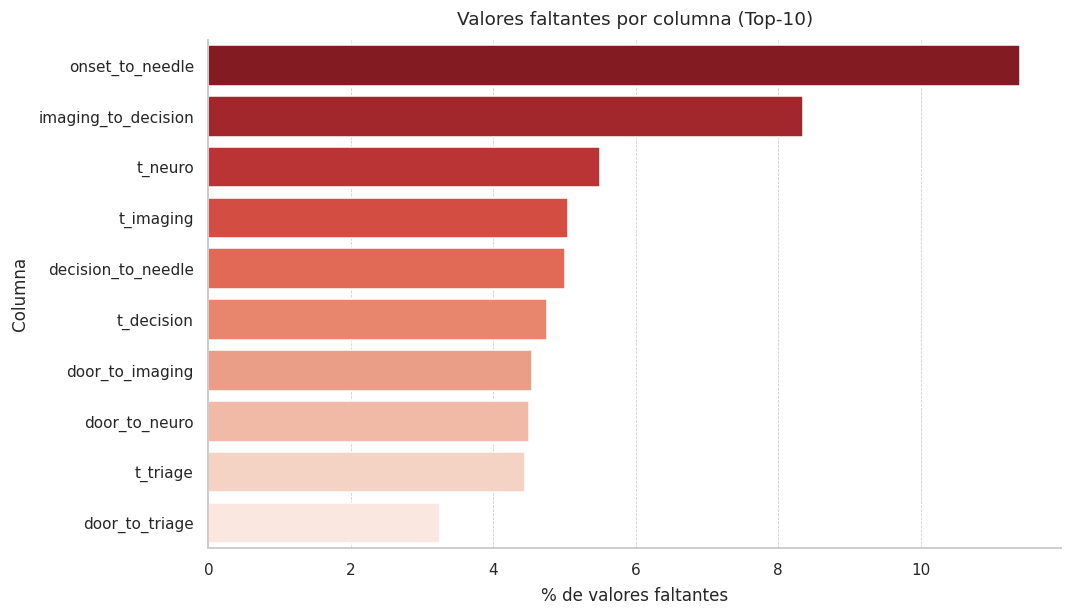

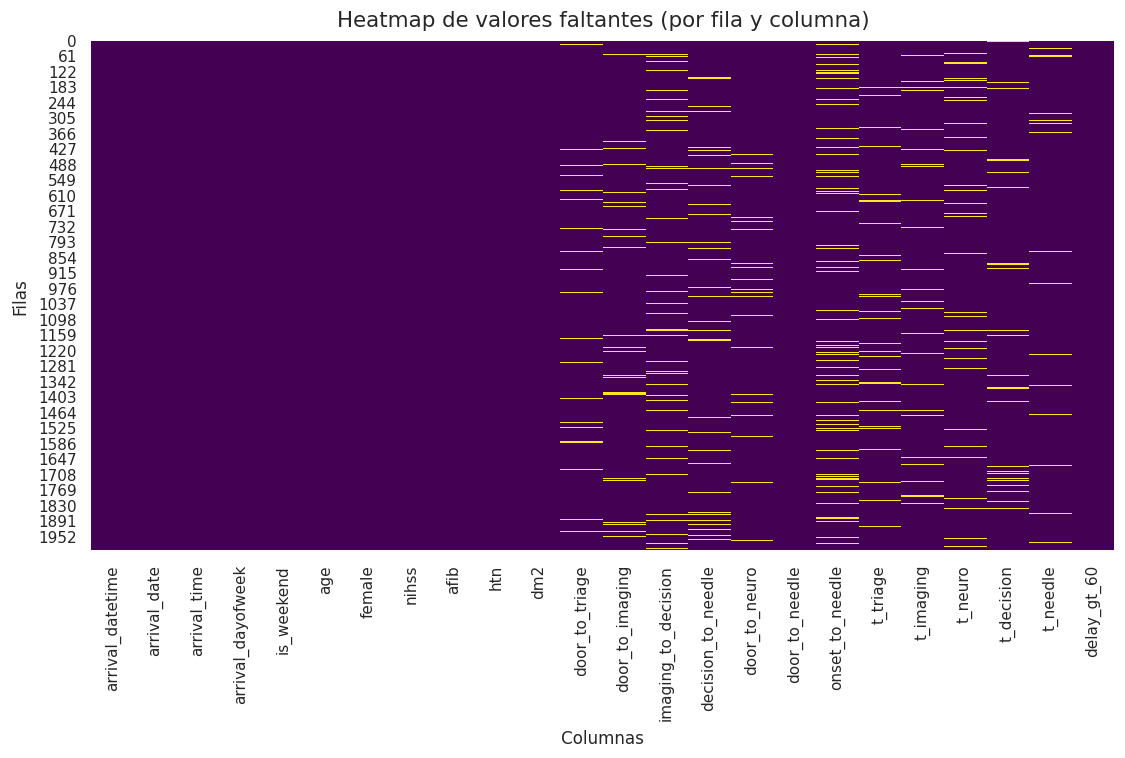

In [169]:
#  % de valores faltantes
na_summary = (
    df.isna().mean()
    .sort_values(ascending=False)
    .mul(100)
    .round(2)
    .reset_index()
    .rename(columns={"index": "columna", 0: "%_faltantes"})
)

# Tabla
print("\n--- Top 10 columnas con mayor % de valores faltantes ---")
display(na_summary.head(10))

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(
    data=na_summary.head(10),
    x="%_faltantes", y="columna", palette="Reds_r"
)
plt.title("Valores faltantes por columna (Top-10)")
plt.xlabel("% de valores faltantes")
plt.ylabel("Columna")
plt.show()

#  Heatmap de valores faltantes
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Heatmap de valores faltantes (por fila y columna)", fontsize=14)
plt.xlabel("Columnas")
plt.ylabel("Filas")
plt.show()


## Variables numéricas y categóricas — Resumen inicial

Se presentan los descriptivos básicos de las **variables numéricas** y las distribuciones principales de las **categóricas**.

- **Timestamps →** conversión a `datetime64`.
- **Derivados** de tiempos en **minutos** (si faltan): `door_to_*`, `*_to_*`, `onset_to_needle`.
- **Numéricas →** descriptivos (n, media, p25/50/75, p90/95, min–max) + % faltantes y cardinalidad.
- **Categóricas →** top-10 categorías por variable (n y %) + cardinalidad.

### Visualizaciones complementarias

Se incluyen representaciones gráficas para apoyar la descripción:

- **Histogramas y boxplots** de los principales tiempos derivados (`door_to_imaging`, `door_to_needle`) para visualizar tendencia central, dispersión y outliers.
- **Barplots** para mostrar la distribución de las variables categóricas más relevantes (ej. `sex`, `hypertension`, `diabetes`).


No se crearon nuevas derivadas. 

--- Descriptivos numéricos (principales) ---


variable   count        mean        std        min         5%         25%         50%         75%         90%         95%         max  \
0       onset_to_needle  1772.0  177.425336  60.197284  45.582717  75.549987  134.442039  177.494706  217.754242  256.967785  278.188401  365.300865   
1   imaging_to_decision  1833.0   17.975712   6.445785   3.000000   7.553641   13.437634   17.894300   22.346519   26.261107   28.647040   41.274212   
2    decision_to_needle  1900.0   12.762035   3.798064   2.000000   6.409742   10.290324   12.860631   15.312140   17.617704   18.932177   25.204775   
3       door_to_imaging  1909.0   23.725209   7.233939   5.000000  11.874085   18.825673   23.528688   28.483501   33.270443   35.831520   54.228535   
4         door_to_neuro  1910.0   14.989277   4.545071   3.000000   7.698865   11.944437   14.864675   17.747473   21.059386   22.731418   32.429065   
5        door_to_triage  1935.0    8.541190   2.978783   0.334363   3.819770    6.493058    8.451265   10.591588   12.498888   13.634216   17.828300   
6                  afib  2000.0    0.201500   0.401221   0.000000   0.000000    0.000000    0.000000    0.000000    1.000000    1.000000    1.000000   
7                   age  2000.0   68.364000  13.112035  18.000000  47.000000   60.000000   68.000000   77.000000   86.000000   90.000000   98.000000   
8     arrival_dayofweek  2000.0    3.054000   2.009254   0.000000   0.000000    1.000000    3.000000    5.000000    6.000000    6.000000    6.000000   
9           delay_gt_60  2000.0    0.298500   0.457714   0.000000   0.000000    0.000000    0.000000    1.000000    1.000000    1.000000    1.000000   
10                  dm2  2000.0    0.261000   0.439290   0.000000   0.000000    0.000000    0.000000    1.000000    1.000000    1.000000    1.000000   
11       door_to_needle  2000.0   54.558063  10.959213  19.167679  37.265510   47.287759   54.208691   61.727579   68.698245   73.019550   93.744862   
12               female  2000.0    0.500500   0.500125   0.000000   0.000000    0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
13                  htn  2000.0    0.566000   0.495749   0.000000   0.000000    0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
14           is_weekend  2000.0    0.292500   0.455024   0.000000   0.000000    0.000000    0.000000    1.000000    1.000000    1.000000    1.000000   
15                nihss  2000.0   12.604000   7.488139   0.000000   1.000000    6.000000   13.000000   19.000000   23.000000   24.000000   25.000000   

    %_faltante  cardinalidad  
0        11.40          1772  
1         8.35          1819  
2         5.00          1897  
3         4.55          1904  
4         4.50          1909  
5         3.25          1935  
6         0.00             2  
7         0.00            73  
8         0.00             7  
9         0.00             2  
10        0.00             2  
11        0.00          2000  
12        0.00             2  
13        0.00             2  
14        0.00             2  
15        0.00            26


--- Top categorías (hasta 10 variables) ---

Variable categórica: arrival_datetime  |  cardinalidad: 1999


n     %
arrival_datetime            
2025-08-30 12:16:30  2  0.10
2025-09-11 12:27:04  1  0.05
2025-09-11 10:38:49  1  0.05
2025-09-11 10:18:07  1  0.05
2025-09-11 09:25:17  1  0.05
2025-09-11 07:47:24  1  0.05
2025-09-11 07:35:58  1  0.05
2025-09-11 06:45:14  1  0.05
2025-09-11 05:34:26  1  0.05
2025-09-11 05:28:44  1  0.05


Variable categórica: arrival_date  |  cardinalidad: 90


n     %
arrival_date          
2025-09-17    35  1.75
2025-09-27    35  1.75
2025-09-21    30  1.50
2025-08-22    30  1.50
2025-08-10    29  1.45
2025-08-29    29  1.45
2025-07-21    29  1.45
2025-08-31    29  1.45
2025-08-03    29  1.45
2025-07-25    28  1.40


Variable categórica: arrival_time  |  cardinalidad: 1974


n     %
arrival_time         
22:52:48      3  0.15
12:00:39      2  0.10
12:16:30      2  0.10
08:26:16      2  0.10
16:27:13      2  0.10
20:00:33      2  0.10
09:23:07      2  0.10
14:16:14      2  0.10
15:07:28      2  0.10
16:24:33      2  0.10


Variable categórica: t_neuro  |  cardinalidad: 1890


n     %
t_neuro                                 
NaN                            110  5.50
2025-09-11 10:36:09.615345880    1  0.05
2025-09-11 09:47:19.750363160    1  0.05
2025-09-11 08:00:24.349212780    1  0.05
2025-09-11 07:53:22.550438800    1  0.05
2025-09-11 07:02:11.152469120    1  0.05
2025-09-11 05:49:47.582889080    1  0.05
2025-09-11 04:31:32.124086940    1  0.05
2025-09-10 20:26:14.380421220    1  0.05
2025-09-10 18:40:47.013221000    1  0.05

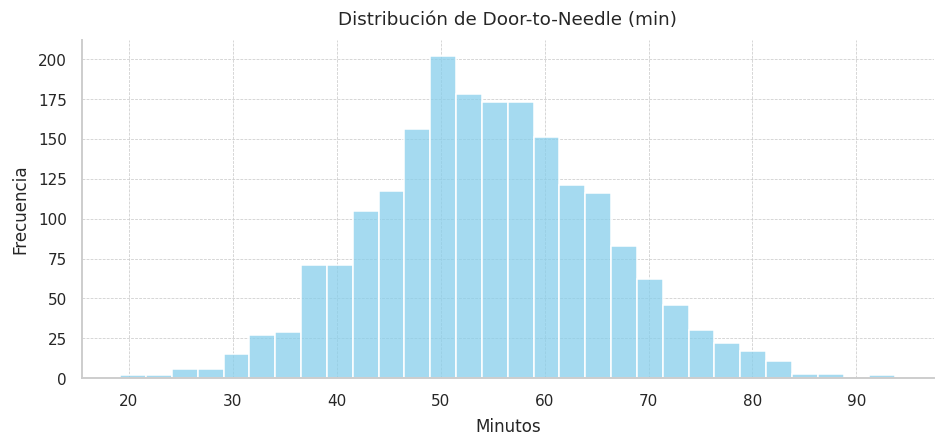

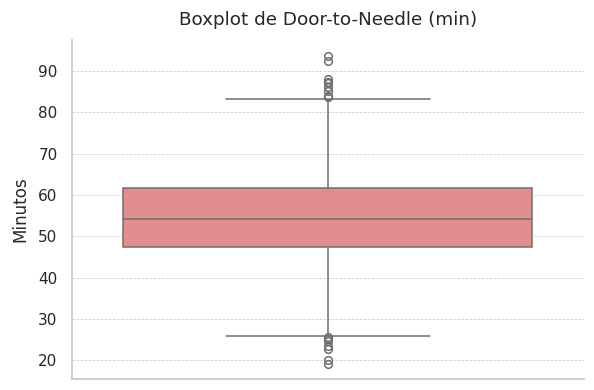

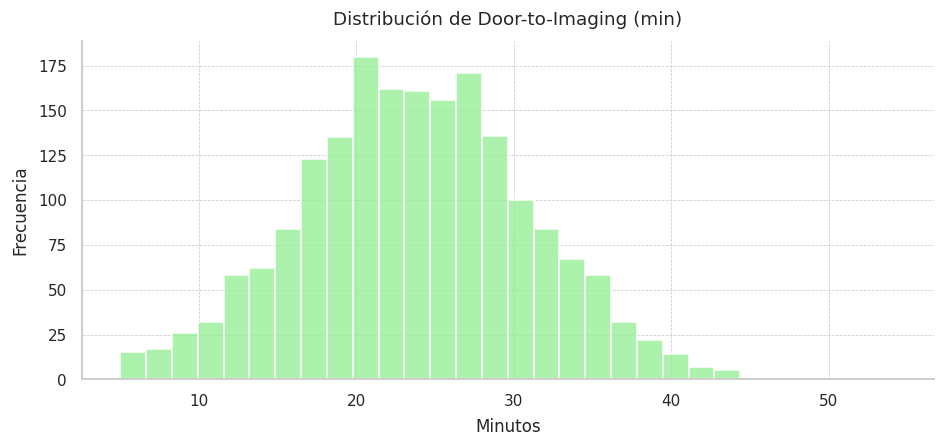

In [170]:
# === Conversión de timestamps y derivados de tiempos (sin preprocesamiento) ===

# 1) Convertir a datetime solo si la columna existe (sin alterar valores fuera de coerción estándar)
time_cols = ["t_lkw","t_arrival","t_triage","t_imaging","t_neuro_eval","t_decision","t_needle"]
for c in time_cols:
    if c in df.columns and not pd.api.types.is_datetime64_any_dtype(df[c]):
        df[c] = pd.to_datetime(df[c], errors="coerce")

def ensure_time_delta_minutes(df, start, end, new_col):
    """
    Crea (end - start) en minutos si:
      - ambas columnas existen
      - ambas son datetime64
      - la columna destino no existe
    No realiza ninguna limpieza ni truncado.
    """
    if new_col in df.columns:
        return None
    if start in df.columns and end in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[start]) and pd.api.types.is_datetime64_any_dtype(df[end]):
            df[new_col] = (df[end] - df[start]).dt.total_seconds() / 60.0
            return new_col
    return None

_created = []
_created.append(ensure_time_delta_minutes(df, "t_arrival", "t_triage",        "door_to_triage"))
_created.append(ensure_time_delta_minutes(df, "t_arrival", "t_imaging",       "door_to_imaging"))  # DTI
_created.append(ensure_time_delta_minutes(df, "t_arrival", "t_neuro_eval",    "door_to_neuro"))
_created.append(ensure_time_delta_minutes(df, "t_imaging", "t_decision",      "imaging_to_decision"))
_created.append(ensure_time_delta_minutes(df, "t_decision","t_needle",        "decision_to_needle"))
_created.append(ensure_time_delta_minutes(df, "t_arrival", "t_needle",        "door_to_needle"))   # DTN
_created.append(ensure_time_delta_minutes(df, "t_lkw",     "t_needle",        "onset_to_needle"))

_created = [c for c in _created if c is not None]
print("Derivadas creadas:" if _created else "No se crearon nuevas derivadas.", ", ".join(_created))

# === Resumen de variables numéricas (EDA puro; sin modificar datos) ===
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if not c.startswith("flag_")]
if num_cols:
    desc = df[num_cols].describe(percentiles=[.05, .25, .5, .75, .90, .95]).T
    desc["%_faltante"]   = (df[num_cols].isna().mean() * 100)
    desc["cardinalidad"] = df[num_cols].nunique(dropna=True)
    desc = desc.reset_index().rename(columns={"index":"variable"})
    desc = desc.sort_values(by=["%_faltante","variable"], ascending=[False, True]).reset_index(drop=True)
    print("\n--- Descriptivos numéricos (principales) ---")
    try:
        display(desc)
    except NameError:
        print(desc.to_string(index=False))
else:
    print("\n(No se encontraron columnas numéricas relevantes.)")

# === Resumen de variables categóricas (EDA puro) ===
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
if cat_cols:
    print("\n--- Top categorías (hasta 10 variables) ---")
    for c in cat_cols[:10]:  # limita para no saturar
        s = df[c].astype("category")
        vc = s.value_counts(dropna=False)
        top = vc.head(10)
        pct = (top / vc.sum() * 100)
        out = pd.DataFrame({"n": top.astype(int), "%": pct})
        card = int(s.nunique(dropna=True))
        print(f"\nVariable categórica: {c}  |  cardinalidad: {card}")
        try:
            display(out)
        except NameError:
            print(out.to_string())
else:
    print("\n(No se encontraron columnas categóricas.)")

# === Visualizaciones complementarias ===

# Histograma + boxplot de DTN
if "door_to_needle" in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df["door_to_needle"].dropna(), bins=30, kde=False, color="skyblue")
    plt.title("Distribución de Door-to-Needle (min)")
    plt.xlabel("Minutos"); plt.ylabel("Frecuencia")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(y=df["door_to_needle"], color="lightcoral")
    plt.title("Boxplot de Door-to-Needle (min)")
    plt.ylabel("Minutos")
    plt.show()

# Histograma de DTI
if "door_to_imaging" in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df["door_to_imaging"].dropna(), bins=30, kde=False, color="lightgreen")
    plt.title("Distribución de Door-to-Imaging (min)")
    plt.xlabel("Minutos"); plt.ylabel("Frecuencia")
    plt.show()

# Distribución de una categórica simple (ej. sexo)
if "sex" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="sex", data=df, palette="pastel")
    plt.title("Distribución de sexo")
    plt.xlabel("Categoría"); plt.ylabel("Conteo")
    plt.show()



## Variables categóricas — distribución condensada

Los gráficos muestran el **Top-8 categorías** por variable categórica (ejemplo: **turno, día de semana, disponibilidad de neurólogo**).  

**Interpretación operativa:**  
- Permite detectar **patrones de demanda** y **brechas de dotación de recursos**.  
- Estas distribuciones motivan futuras **estratificaciones analíticas** (p. ej., comparar medianas de DTN entre turnos o entre días de semana vs. fin de semana).  


Categóricas detectadas: ['afib', 'arrival_date', 'arrival_datetime', 'arrival_dayofweek', 'arrival_time', 'delay_gt_60', 'dm2', 'female', 'htn', 'is_weekend', 't_neuro']


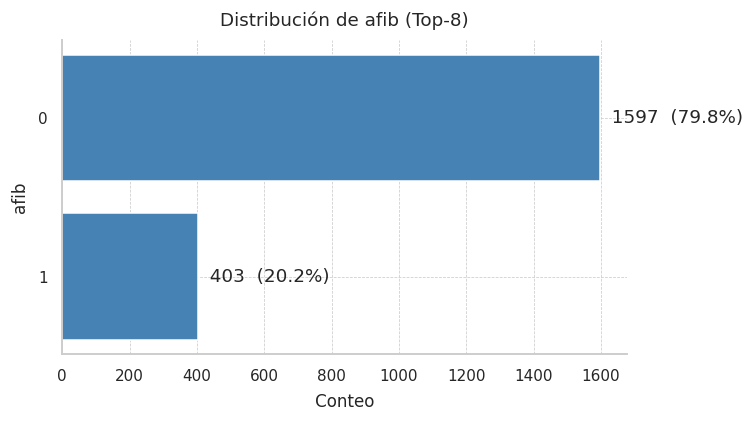

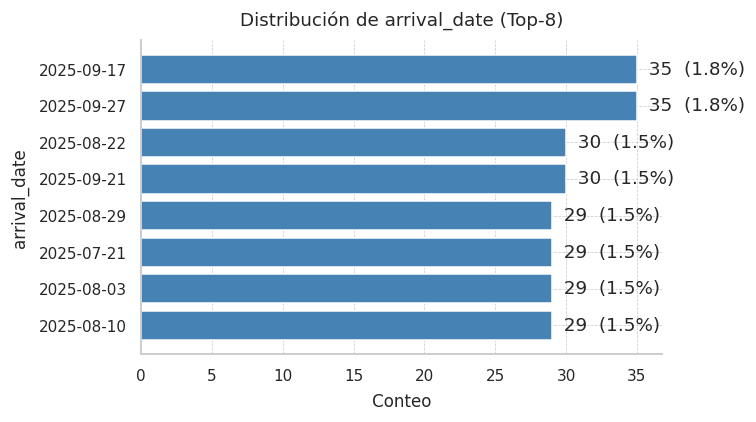

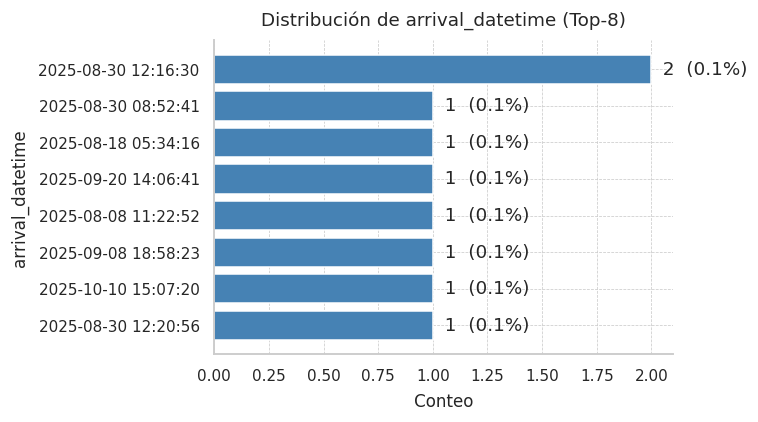

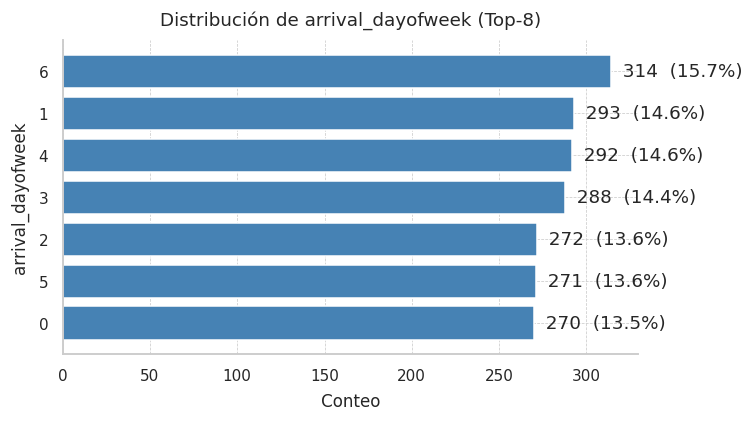

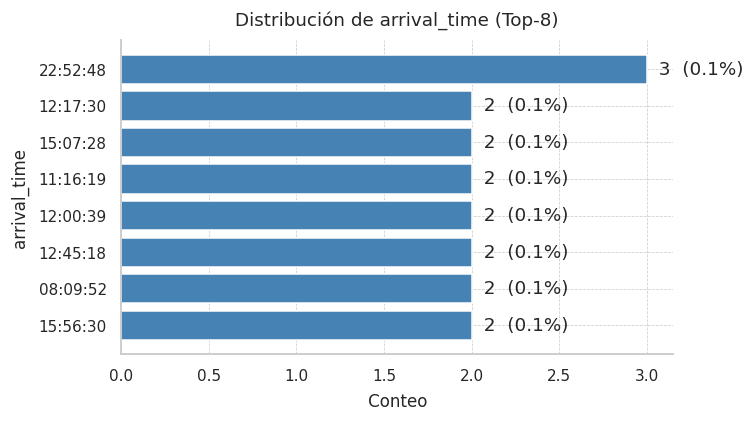

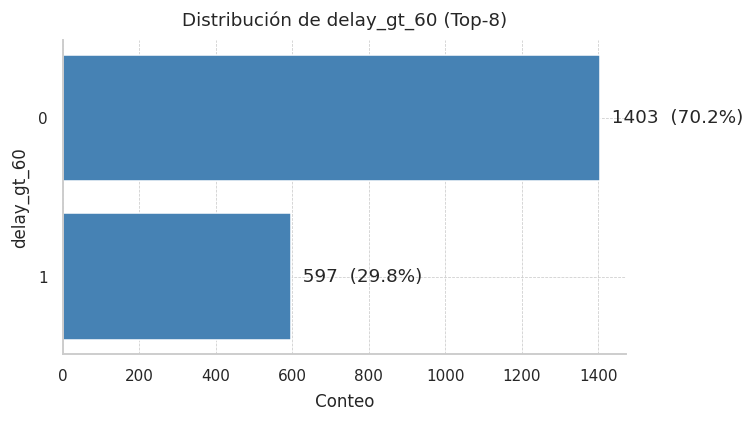

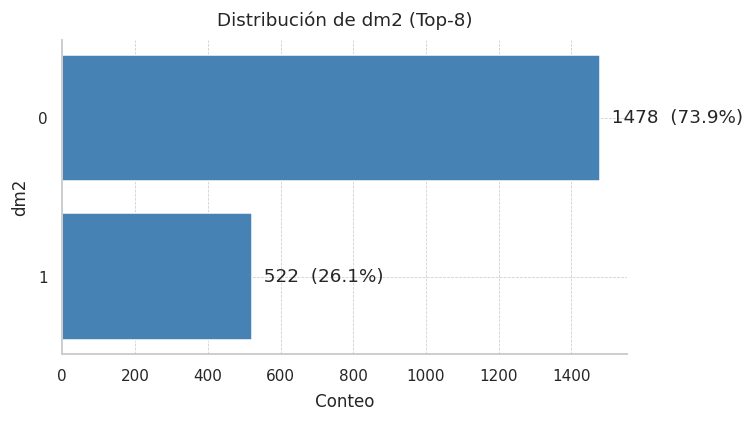

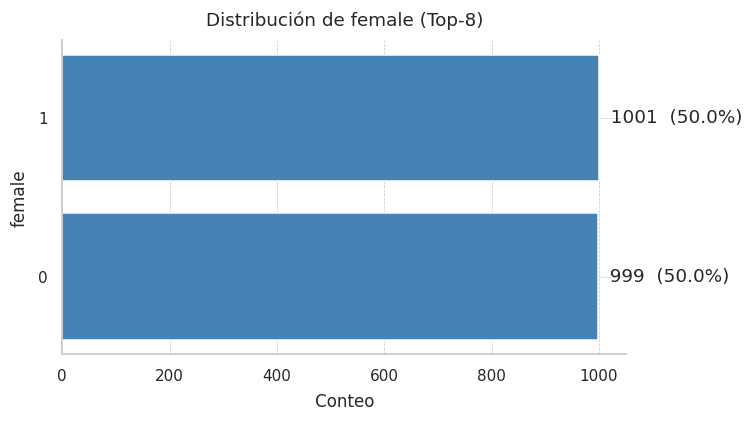

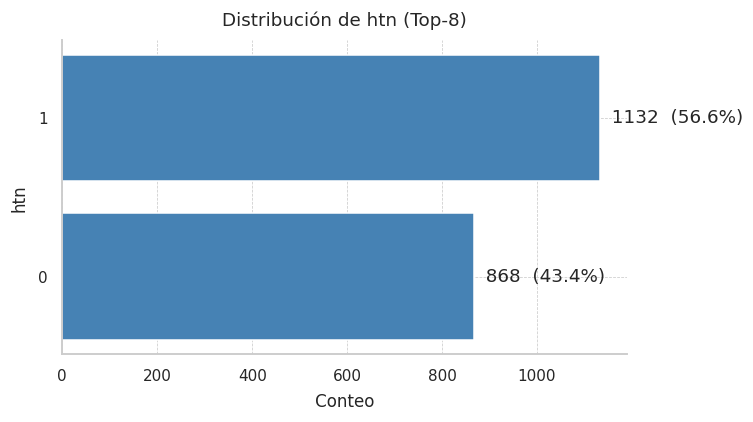

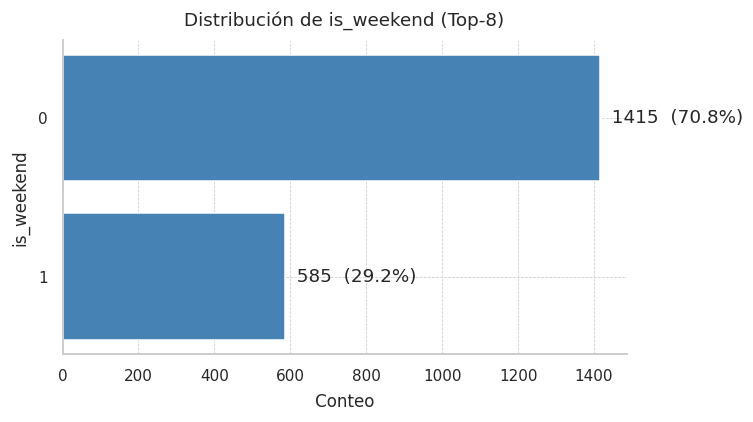

In [171]:
#  Distribución condensada de categóricas (Top-8)

def infer_categorical_columns(df, max_unique_for_numeric=20, exclude_patterns=("id", "uuid")):
    """
    Detecta columnas categóricas:
      - object/category/bool
      - numéricas con baja cardinalidad (2..max_unique_for_numeric)
    Excluye columnas con patrones de ID en el nombre.
    """
    cols = set()

    # a) Tipos categóricos
    cols.update(df.select_dtypes(include=["object", "category", "bool"]).columns)

    # b) Numéricas con baja cardinalidad
    for c in df.select_dtypes(include=[np.number]).columns:
        nunq = df[c].nunique(dropna=False)
        if 1 < nunq <= max_unique_for_numeric:
            cols.add(c)

    # c) Excluir por nombre
    def is_excluded(name):
        name_l = str(name).lower()
        return any(pat in name_l for pat in exclude_patterns)

    cols = [c for c in cols if not is_excluded(c)]
    return sorted(cols)

cat_cols = infer_categorical_columns(df)

print("Categóricas detectadas:", cat_cols if cat_cols else "(ninguna)")

def plot_categorical_topk(series, varname, k=8):
    """
    Grafica Top-k categorías (conteo y %).
    Trata NaN como '<NA>'.
    """
    s = series.astype("object").where(~series.isna(), "<NA>")
    vc = s.value_counts(dropna=False)
    if vc.empty:
        print(f"[AVISO] '{varname}' no tiene datos para graficar.")
        return
    vc = vc.head(k)
    total = int(len(s))
    pct = (vc / total * 100)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.barh(range(len(vc.index)), vc.values, color="steelblue")
    ax.set_yticks(range(len(vc.index)))
    ax.set_yticklabels([str(x) for x in vc.index])
    ax.invert_yaxis()
    ax.set_title(f"Distribución de {varname} (Top-{k})")
    ax.set_xlabel("Conteo")
    ax.set_ylabel(varname)

    # Anotar porcentaje
    for i, (count, p) in enumerate(zip(vc.values, pct.values)):
        ax.text(count, i, f"  {count}  ({p:.1f}%)", va="center")

    plt.tight_layout()
    plt.show()

# Graficar (máx. 10 variables para no saturar)
TOP_K = 8
MAX_VARS = 10

if cat_cols:
    for c in cat_cols[:MAX_VARS]:
        plot_categorical_topk(df[c], c, k=TOP_K)
else:
    print("No se detectaron columnas categóricas para graficar.")


## 4.c — EDA de tiempos críticos, cumplimiento y distribución de la clase

**Objetivo.**  
Caracterizar la distribución de los **tiempos clave del flujo asistencial** (min) y cuantificar el **cumplimiento** de metas operativas (DTI/DTN) mediante `flag_*`. Se prioriza reportar **medianas** y **p75/p90** (robustos a colas derechas) y evaluar el **desbalance** del target `delay_gt_60`.

**Qué se reporta.**  
- **Resumen tabular** de tiempos críticos: n, media, DE, p25/p50/p75/p90/p95, min–max.  
- **Visualizaciones**: histogramas, boxplots y **ECDF** con líneas guía (DTI ≤25/20/15; DTN ≤60/45/30).  
- **Flags de cumplimiento**: conteos y % por cada `flag_*`, más **cumplimiento global**.  
- **Distribución de la clase** `delay_gt_60` (o derivada desde DTN): conteos y proporciones.

---

### 4.c.1 — Resultados principales (resumen de tiempos)

**Tiempos clave (minutos, p25 — mediana — p75):**
- **door_to_imaging (DTI):** **18,83 — 23,53 — 28,48**  
- **imaging_to_decision:** **13,44 — 17,89 — 22,35**  
- **decision_to_needle:** **10,29 — 12,86 — 15,31**  
- **door_to_needle (DTN):** **47,29 — 54,21 — 61,73**  
- **door_to_triage / door_to_neuro / onset_to_needle:** *(reportar si están presentes; si no, omitir del resumen tabular)*

> **Lectura operativa.** Los **p90–p95** capturan escenarios de **congestión**; los máximos reflejan demoras reales y los mínimos muy bajos pueden ser **artefactos** de registro/simulación. La **mediana DTN = 54,2 min** y el **p75 = 61,7 min** confirman **cola derecha**, con ~**30%** de casos sobre 60 min.

---

### 4.c.2 — Visualizaciones de distribución
- **Histogramas**: confirman **asimetría** y **colas derechas**.  
- **Boxplots**: visibilizan **outliers** (criterio IQR/Tukey).  
- **ECDF**: añadir líneas guía en 25/20/15 (DTI) y 60/45/30 (DTN) para lectura rápida.  
- **QQ-plots**: descartan **normalidad** (esperable en procesos de tiempo).

**Conclusión práctica.** Usar **medianas** y **p75/p90** como referencias operativas; favorecer transformaciones/modelos que **no asuman normalidad estricta**.

---

### 4.c.3 — Tiempos críticos: valores típicos y extremos
- La tabla de “Resumen de tiempos críticos” presenta **n**, media, DE, p25/p50/p75/p90/p95, min–max.  
- La tabla de **Tukey + skew/kurtosis** permite:  
  - **IQR y bigotes** → rango “típico”.  
  - **% de outliers** → *extremos* operativos (demoras puntuales o errores de flujo).  
  - **Skew/kurtosis** → cuantificar **colas derechas**.

**Implicancias.** Si `outlier_pct` > 5%, considerar **winsorización** (p95/p99) o **log1p** en variables no temporales, y priorizar métricas robustas (mediana/IQR). Evaluar estratificación por **turno**, **fin de semana** y **crowding**.

---

### 4.c.4 — Cumplimiento en tiempos críticos (exploratorio)
- Tasas de **cumplimiento/incumplimiento** por `flag_*` y **% de cumplimiento** por meta.  
- Indicador central `flag_dtn_ok` (**DTN ≤ 60 min**): **cumplimiento ≈ 70%** / **incumplimiento ≈ 30%** (consistente con la distribución de DTN).  
- `flag_dti_ok` (**DTI ≤ 25 min**): reportar la proporción observada y compararla con metas intensivas (20/15).

---

### 4.c.5 — Distribución de la clase (target) y desbalance
- **Target `delay_gt_60`**: **29,9%** positivos (retraso) vs **70,1%** a tiempo → **desbalance moderado**.  
- **Regla práctica**: si una clase ≥ **65–70%**, hay **desbalance** relevante (aplica aquí).

**Ajustes propuestos.**  
- **Métricas**: priorizar **Recall**/**F1** y **PR-AUC** sobre Accuracy.  
- **Entrenamiento**: `class_weight='balanced'` y/o remuestreo (SMOTE/undersampling) **solo en TRAIN**.  
- **Umbral de decisión**: calibrar en función del **costo de falsos negativos** (incumplimientos críticos) y de la **tasa de alertas** tolerable.

---

### 4.c.6 — Implicancias para el modelado (derivadas del EDA)
- Optimizar con foco en **sensibilidad** (Recall) y **F1** bajo **tasa de alertas** controlada.  
- Aplicar **ponderación de clases**; considerar **SMOTE** si mejora Recall sin inflar FP.  
- Ajustar **umbrales** para alcanzar un **Recall objetivo** (p. ej., ≥0.80) con **Precision** razonable.  
- Priorizar reportes con **medianas** y **p75/p90** para comparabilidad y control operativo.


Resumen de tiempos críticos (minutos)


n    mean    std    min     p25     p50     p75     p90     p95     max
door_to_triage       1935.0    8.54   2.98   0.33    6.49    8.45   10.59   12.50   13.63   17.83
door_to_imaging      1909.0   23.73   7.23   5.00   18.83   23.53   28.48   33.27   35.83   54.23
door_to_neuro        1910.0   14.99   4.55   3.00   11.94   14.86   17.75   21.06   22.73   32.43
imaging_to_decision  1833.0   17.98   6.45   3.00   13.44   17.89   22.35   26.26   28.65   41.27
decision_to_needle   1900.0   12.76   3.80   2.00   10.29   12.86   15.31   17.62   18.93   25.20
door_to_needle       2000.0   54.56  10.96  19.17   47.29   54.21   61.73   68.70   73.02   93.74
onset_to_needle      1772.0  177.43  60.20  45.58  134.44  177.49  217.75  256.97  278.19  365.30

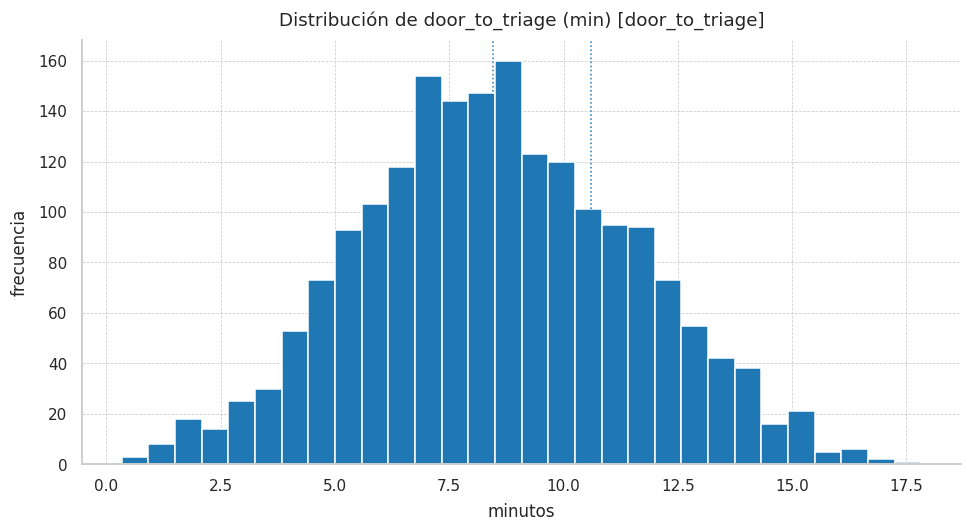

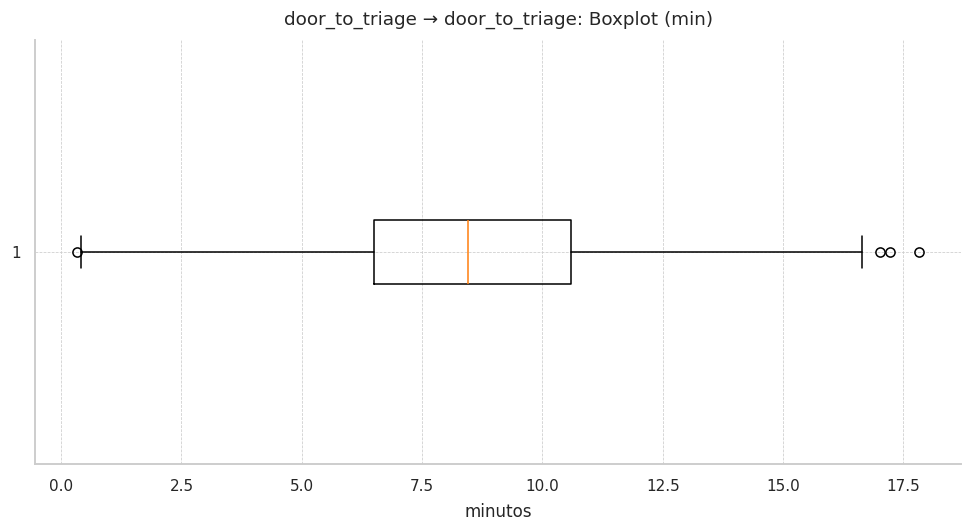

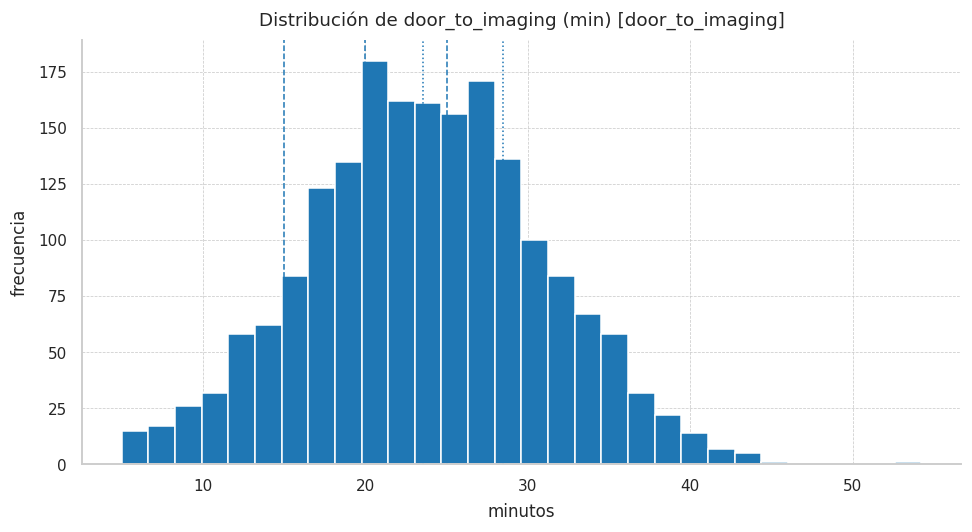

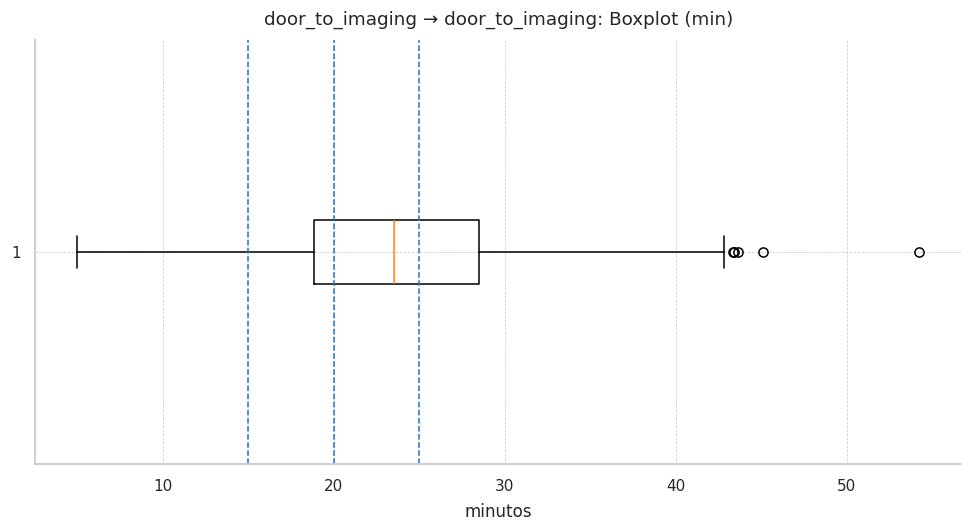

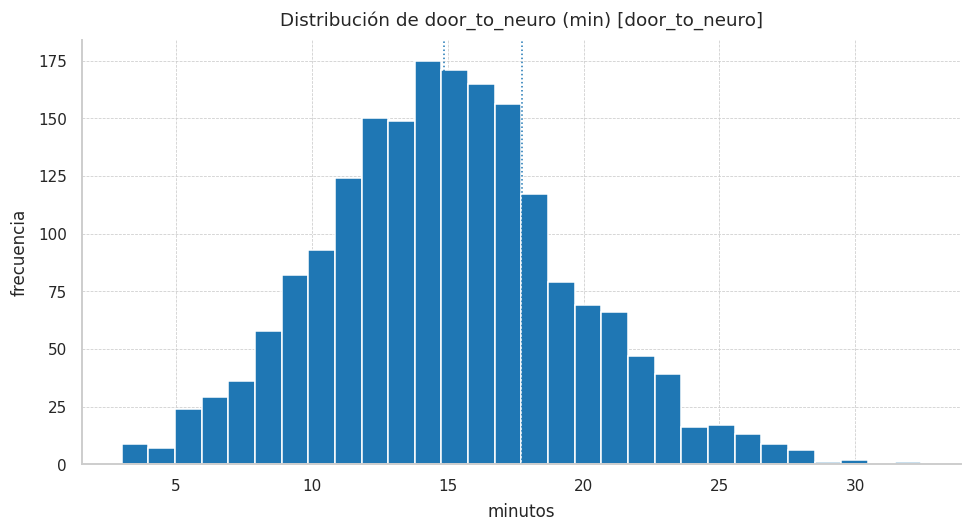

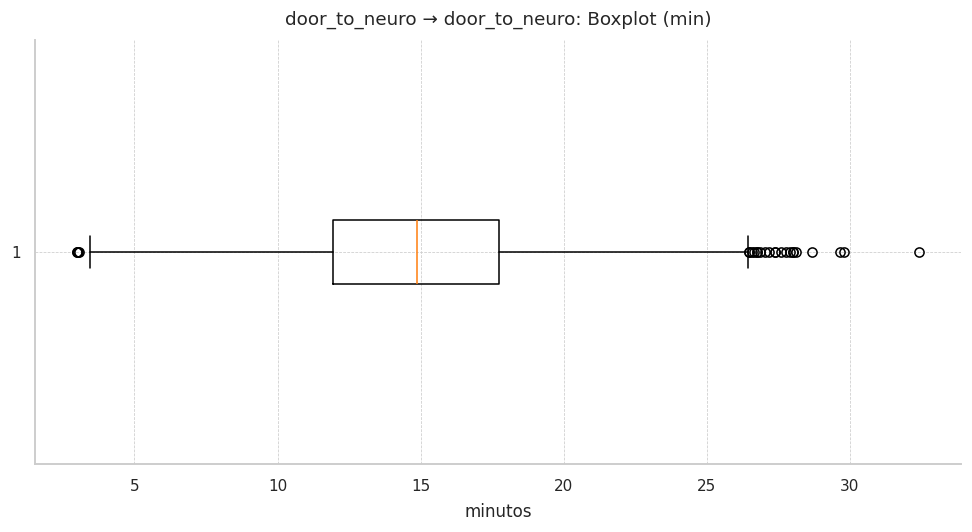

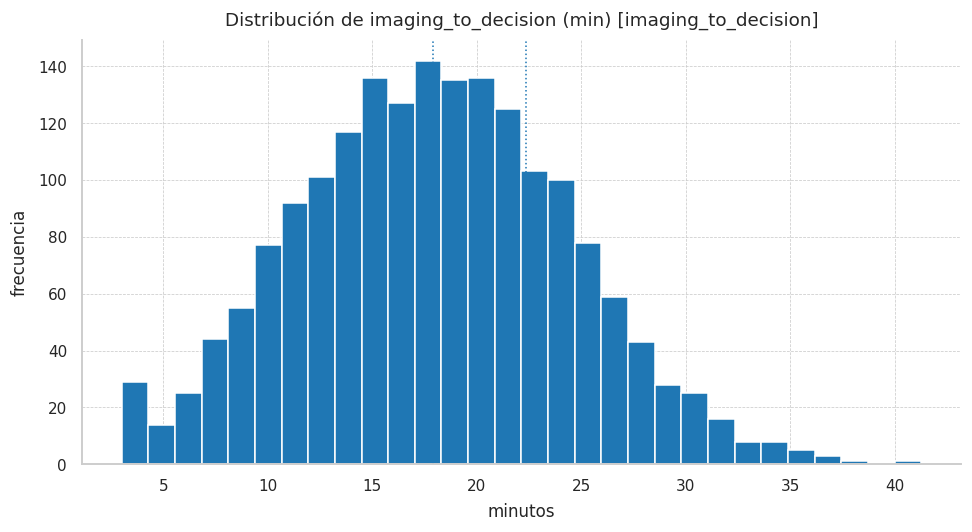

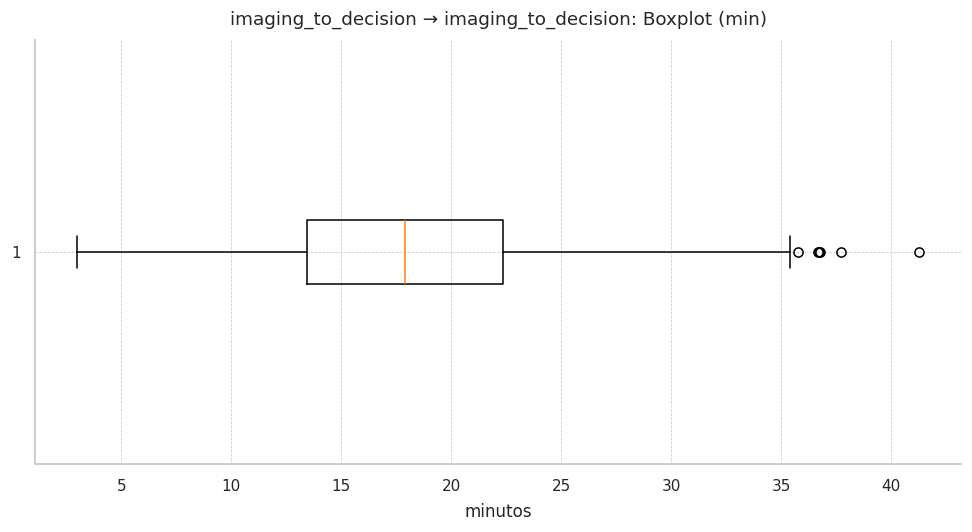

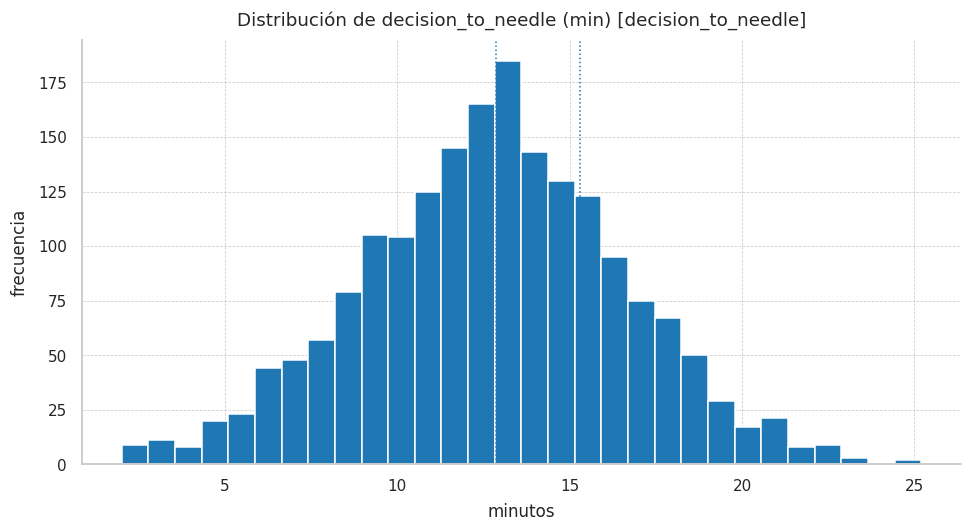

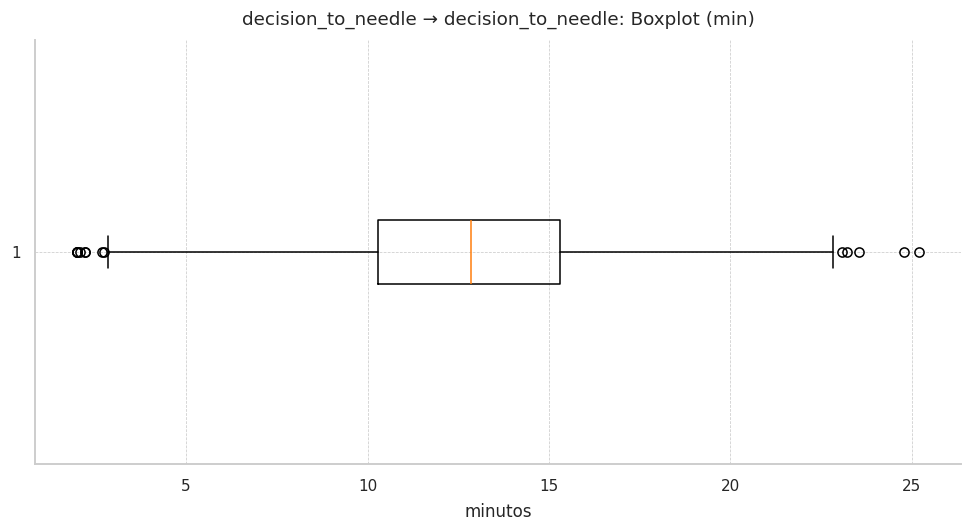

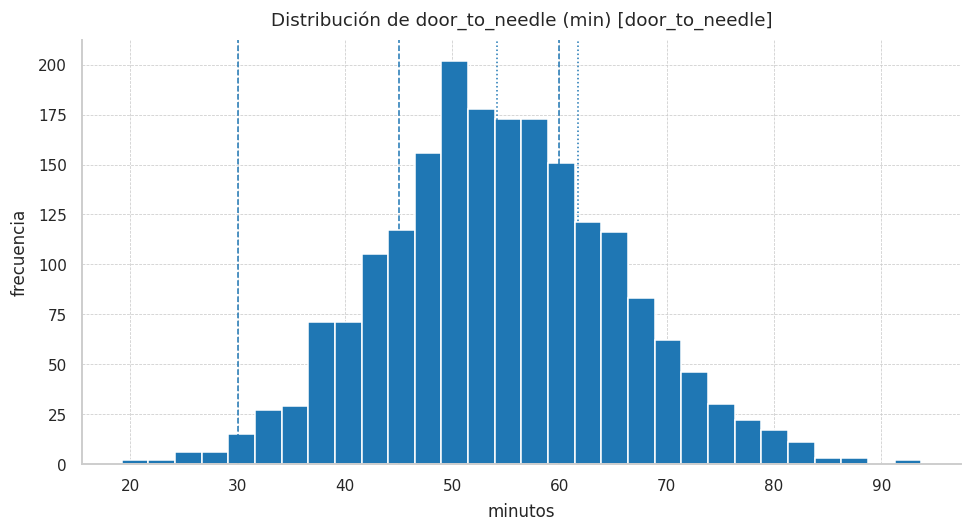

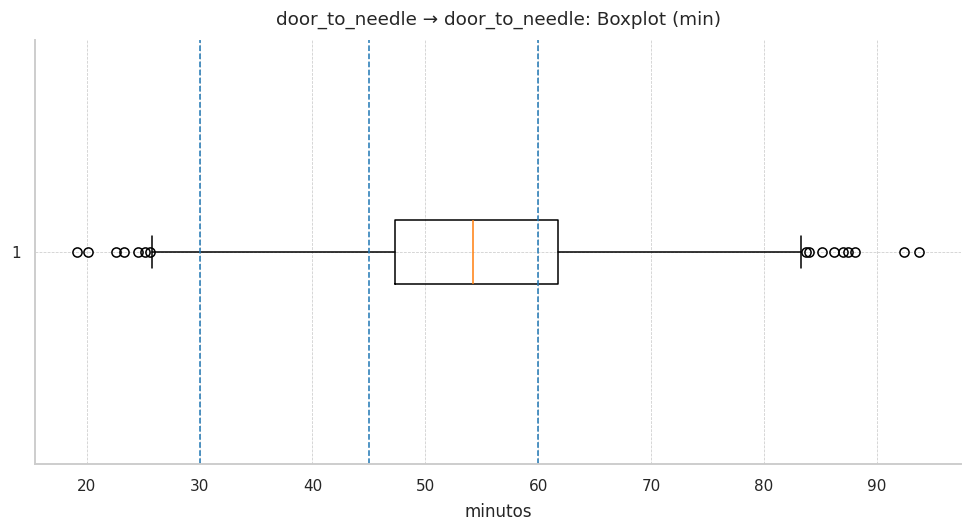

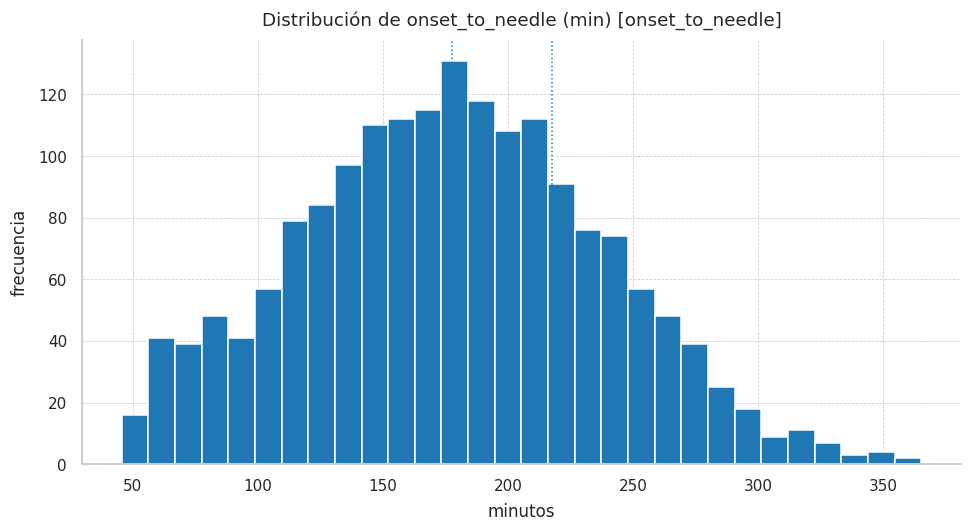

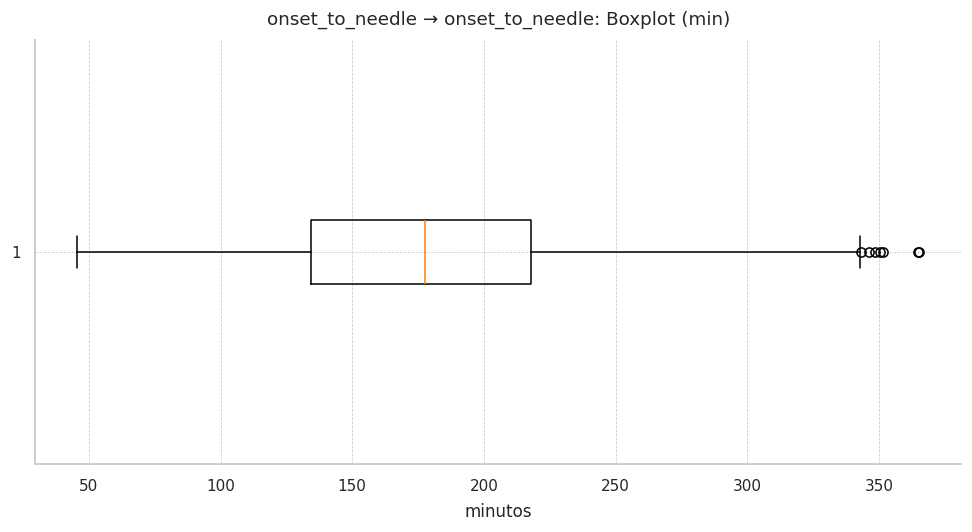

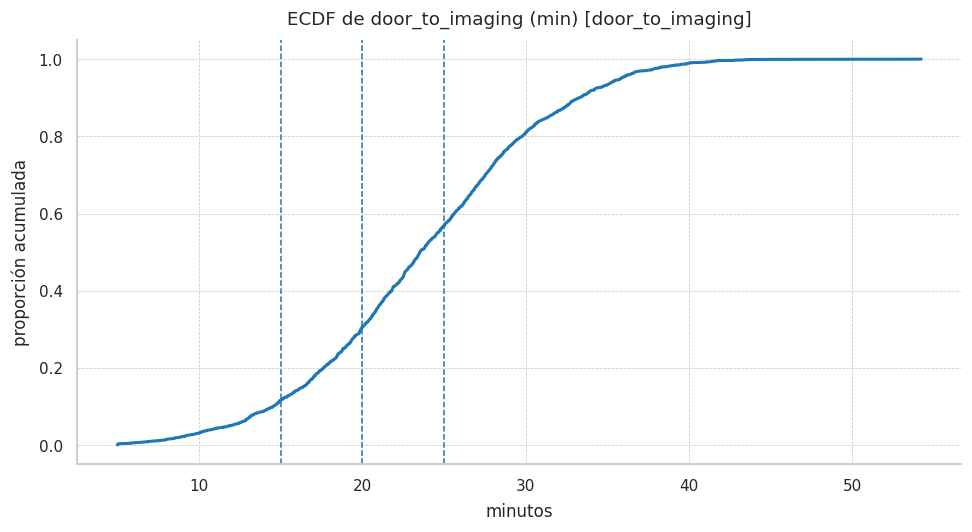

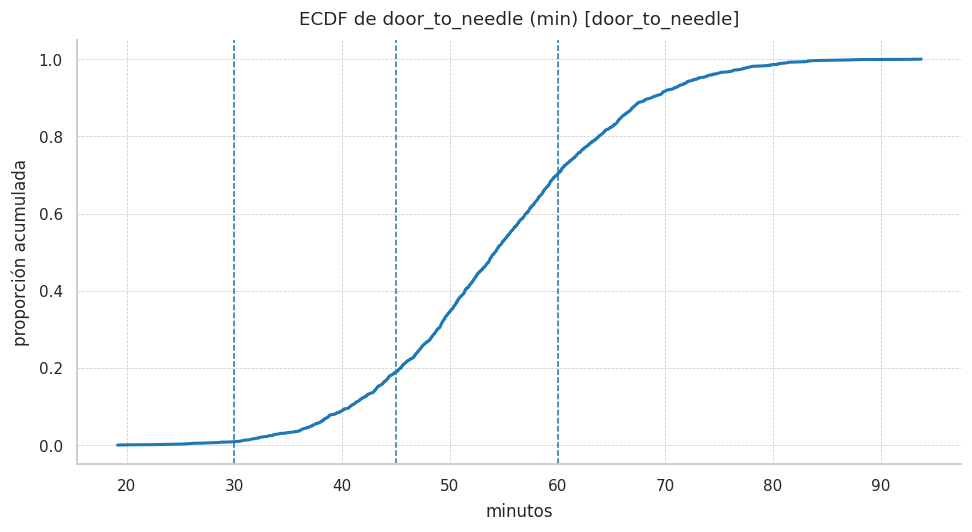


(No se encontraron columnas 'flag_*').

Distribución de la clase (delay_gt_60: 1=incumple, 0=cumple)


n      %
delay_gt_60             
0            1403  70.15
1             597  29.85

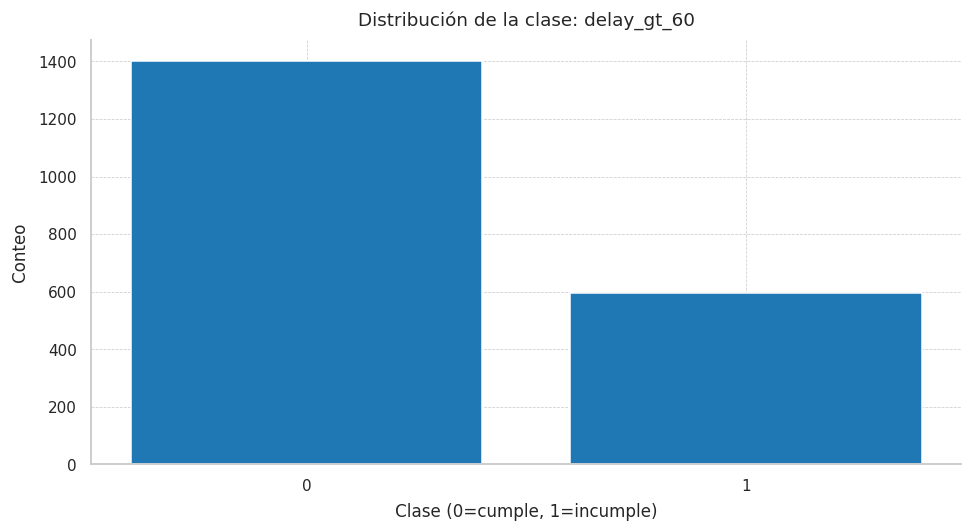

In [172]:
# =========================================================
# 4.c — EDA : tiempos críticos, flags de cumplimiento y clase
# (No muta df; robusto a columnas faltantes y alias)
# Requiere: df definido y librerías cargadas (pandas, numpy, matplotlib, seaborn, scipy.stats)
# =========================================================

# 0) Utilidades de nombres: mapa "limpio" -> nombre real en df
_name_map = {str(c).strip(): c for c in df.columns}
def _exists(clean_name: str) -> bool:
    return clean_name in _name_map
def _real(clean_name: str):
    return _name_map.get(clean_name, None)

# 1) Canonicalización por alias (elige el primero que exista en df)
ALIASES = {
    "door_to_triage":      ["door_to_triage", "d_triage_arrival", "door_to_triage_min"],
    "door_to_imaging":     ["door_to_imaging", "door_to_imaging_min", "d_imaging_arrival"],
    "door_to_neuro":       ["door_to_neuro", "d_neuro_arrival"],
    "imaging_to_decision": ["imaging_to_decision"],
    "decision_to_needle":  ["decision_to_needle"],
    "door_to_needle":      ["door_to_needle", "door_to_needle_min", "dtn_min", "dtn_minutes"],
    "onset_to_needle":     ["onset_to_needle", "d_needle_lkw", "onset_to_needle_min", "OTN_min"],
}

canon_to_real = {}
for canon, cands in ALIASES.items():
    for c in cands:
        if _exists(c):
            canon_to_real[canon] = _real(c)
            break

# 2) Lista final de tiempos presentes (en orden lógico)
time_order = ["door_to_triage","door_to_imaging","door_to_neuro",
              "imaging_to_decision","decision_to_needle","door_to_needle","onset_to_needle"]
time_cols_present = [canon_to_real[k] for k in time_order if k in canon_to_real]

# 3) Helpers mínimos (sólo si no existen ya)
if "plot_hist_box" not in globals():
    def plot_hist_box(series, colname):
        s = pd.to_numeric(series, errors="coerce").dropna()
        if s.empty:
            return
        # Histograma
        plt.figure()
        plt.hist(s, bins=30)
        plt.title(f"Distribución de {colname}")
        plt.xlabel("minutos"); plt.ylabel("frecuencia")
        plt.tight_layout(); plt.show()
        # Boxplot
        plt.figure()
        plt.boxplot(s, vert=False, whis=1.5)
        plt.title(f"Boxplot – {colname}")
        plt.xlabel("minutos")
        plt.tight_layout(); plt.show()

if "safe_probplot" not in globals():
    def safe_probplot(series, colname):
        s = pd.to_numeric(series, errors="coerce").dropna()
        s = s[s >= 0]
        if s.size < 10:
            return
        try:
            plt.figure()
            stats.probplot(np.log1p(s), dist="norm", plot=plt)
            plt.title(f"Q–Q log1p vs Normal – {colname}")
            plt.xlabel("cuantiles teóricos"); plt.ylabel("cuantiles de la muestra")
            plt.tight_layout(); plt.show()
        except Exception:
            rng = np.random.default_rng(42)
            z = rng.normal(size=len(s))
            x, y = np.sort(z), np.sort(np.log1p(s.values))
            plt.figure()
            plt.plot(x, y, "o", markersize=3)
            coef = np.polyfit(x, y, 1)
            xfit = np.linspace(x.min(), x.max(), 100)
            yfit = coef[0]*xfit + coef[1]
            plt.plot(xfit, yfit, linewidth=1)
            plt.title(f"Q–Q log1p (fallback) – {colname}")
            plt.xlabel("cuantiles teóricos"); plt.ylabel("cuantiles de la muestra")
            plt.tight_layout(); plt.show()

# 4) Resumen tabular de tiempos
def _summarize_times_local(series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.Series({
            "n": 0, "mean": np.nan, "std": np.nan, "min": np.nan,
            "p25": np.nan, "p50": np.nan, "p75": np.nan, "p90": np.nan, "p95": np.nan, "max": np.nan
        })
    return pd.Series({
        "n": int(s.shape[0]),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "p50": float(s.quantile(0.50)),
        "p75": float(s.quantile(0.75)),
        "p90": float(s.quantile(0.90)),
        "p95": float(s.quantile(0.95)),
        "max": float(s.max()),
    })

if time_cols_present:
    print("Resumen de tiempos críticos (minutos)")
    times_summary = pd.DataFrame({c: _summarize_times_local(df[c]) for c in time_cols_present}).T
    display(times_summary.round(2))
else:
    print("No se encontraron columnas de tiempos críticos estándar.")

# 5) Visualizaciones: Hist/Box + ECDF para DTI y DTN (si existen)
def _add_targets(ax, canon):
    if canon == "door_to_imaging":      # DTI
        for t in (25, 20, 15):
            ax.axvline(t, linestyle="--", linewidth=1)
    if canon == "door_to_needle":       # DTN
        for t in (60, 45, 30):
            ax.axvline(t, linestyle="--", linewidth=1)

# Hist + Boxplot por cada columna presente
for canon in time_order:
    col = canon_to_real.get(canon, None)
    if col is None:
        continue
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        continue

    # Histograma
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(f"Distribución de {canon} (min) [{col}]")
    plt.xlabel("minutos"); plt.ylabel("frecuencia")
    for q in (0.50, 0.75):
        plt.axvline(s.quantile(q), linestyle=":", linewidth=1)
    _add_targets(plt.gca(), canon)
    plt.tight_layout(); plt.show()

    # Boxplot horizontal
    plt.figure()
    plt.boxplot(s, vert=False)
    plt.title(f"{canon} → {col}: Boxplot (min)")
    plt.xlabel("minutos")
    _add_targets(plt.gca(), canon)
    plt.tight_layout(); plt.show()

# ECDF para DTI y DTN (si existen)
for canon in ["door_to_imaging","door_to_needle"]:
    col = canon_to_real.get(canon, None)
    if col is None:
        continue
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        continue
    x = np.sort(s.values)
    y = np.arange(1, len(x)+1) / len(x)
    plt.figure()
    plt.plot(x, y)
    plt.title(f"ECDF de {canon} (min) [{col}]")
    plt.xlabel("minutos"); plt.ylabel("proporción acumulada")
    _add_targets(plt.gca(), canon)
    plt.tight_layout(); plt.show()

# 6) Flags de cumplimiento (solo lectura)
flag_cols = [c for c in df.columns if str(c).startswith("flag_")]

if flag_cols:
    print("\n--- Distribución de flags de cumplimiento ---")
    for f in sorted(flag_cols):
        s  = pd.to_numeric(df[f], errors="coerce")
        vc = s.value_counts(dropna=False)
        pct = (vc / len(df) * 100)
        out = pd.concat([vc.rename("n"), pct.rename("%")], axis=1)
        print(f"\n{f}")
        display(out.round(2))

    def _compliance_rate_local(series):
        s = pd.to_numeric(series, errors="coerce")
        total = s.isin([0,1]).sum()
        ok = (s == 1).sum()
        return pd.Series({
            "ok": int(ok),
            "total": int(total),
            "cumplimiento_%": (100 * ok / total) if total > 0 else np.nan
        })

    compliance_table = pd.DataFrame({f: _compliance_rate_local(df[f]) for f in sorted(flag_cols)}).T
    print("\n--- Cumplimiento global de metas (todas las flags) ---")
    display(compliance_table.round(2))

    plt.figure()
    x = np.arange(compliance_table.shape[0])
    plt.bar(x, compliance_table["cumplimiento_%"].values)
    plt.xticks(x, compliance_table.index, rotation=45, ha="right")
    plt.ylabel("% cumplimiento"); plt.title("Cumplimiento por flag")
    plt.tight_layout(); plt.show()
else:
    print("\n(No se encontraron columnas 'flag_*').")

# 7) Distribución de la clase (delay_gt_60) — derivación segura si no existe
target_series = None
if "delay_gt_60" in df.columns:
    target_series = pd.to_numeric(df["delay_gt_60"], errors="coerce")
elif "flag_dtn_ok" in df.columns:
    s = pd.to_numeric(df["flag_dtn_ok"], errors="coerce")
    target_series = s.map({1:0, 0:1})  # 1=incumple, 0=cumple -> invertimos
else:
    # Intento derivar desde DTN
    for cand in (canon_to_real.get("door_to_needle", None), "dtn_min", "door_to_needle_min", "DTN_min", "DTN"):
        if cand is not None and cand in df.columns:
            s = pd.to_numeric(df[cand], errors="coerce")
            target_series = (s > 60).astype("float")
            break

if target_series is not None:
    vc = target_series.value_counts(dropna=False).sort_index()
    pct = (vc / len(df) * 100)
    clase_tbl = pd.concat([vc.rename("n"), pct.rename("%")], axis=1)
    print("\nDistribución de la clase (delay_gt_60: 1=incumple, 0=cumple)")
    display(clase_tbl.round(2))

    plt.figure()
    x = np.arange(vc.shape[0])
    plt.bar(x, vc.values)
    plt.xticks(x, [str(i) for i in vc.index])
    plt.xlabel("Clase (0=cumple, 1=incumple)")
    plt.ylabel("Conteo")
    plt.title("Distribución de la clase: delay_gt_60")
    plt.tight_layout(); plt.show()
else:
    print("\nAviso: no se pudo obtener 'delay_gt_60' (ni derivarlo) para graficar la distribución de clases.")


In [173]:
chequeo = {}
for c in ["door_to_imaging","door_to_needle","imaging_to_decision","decision_to_needle",
          "door_to_triage","door_to_neuro","onset_to_needle"]:
    if c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce").dropna()
        chequeo[c] = {
            "mediana": round(float(s.median()),2),
            "p25": round(float(s.quantile(.25)),2),
            "p75": round(float(s.quantile(.75)),2)
        }

cumple = (df["flag_dtn_ok"].mean()*100) if "flag_dtn_ok" in df.columns else ( (df["door_to_needle"]<=60).mean()*100 )
incumple = 100 - cumple
print(chequeo)
print(f"DTN ≤60: cumple {cumple:.1f}% | incumple {incumple:.1f}%")


{'door_to_imaging': {'mediana': 23.53, 'p25': 18.83, 'p75': 28.48}, 'door_to_needle': {'mediana': 54.21, 'p25': 47.29, 'p75': 61.73}, 'imaging_to_decision': {'mediana': 17.89, 'p25': 13.44, 'p75': 22.35}, 'decision_to_needle': {'mediana': 12.86, 'p25': 10.29, 'p75': 15.31}, 'door_to_triage': {'mediana': 8.45, 'p25': 6.49, 'p75': 10.59}, 'door_to_neuro': {'mediana': 14.86, 'p25': 11.94, 'p75': 17.75}, 'onset_to_needle': {'mediana': 177.49, 'p25': 134.44, 'p75': 217.75}}
DTN ≤60: cumple 70.2% | incumple 29.8%


## Efecto de la hora de llegada

Se explora la relación entre la **hora de llegada al hospital** y los **tiempos críticos**.  
Las **medianas por hora** sugieren una **variación intra–día** atribuible al balance entre **demanda y disponibilidad de recursos** (ej. congestión matinal, menor dotación en horario nocturno).

**Implicancias operativas:**
- Incluir nuevas variables como `arrival_hour`, `is_weekend` y, si está disponible, `neuro_on_duty`.  
- Estas características podrán ser evaluadas como **predictoras** en los modelos.  
- Si se confirman diferencias consistentes, podría justificarse la implementación de **metas diferenciadas por franja horaria** o turnos.  

**Siguiente paso:** incorporar dichas variables como *features* y analizar su importancia relativa en el modelado.



Distribución de llegadas por hora (conteo):


arrival_time
0      13
1      16
2      17
3      29
4      18
5      46
6      63
7      93
8     129
9     148
10    132
11    143
12    151
13    151
14    132
15    128
16    122
17    115
18    107
19     68
20     73
21     30
22     48
23     28
Name: count, dtype: int64

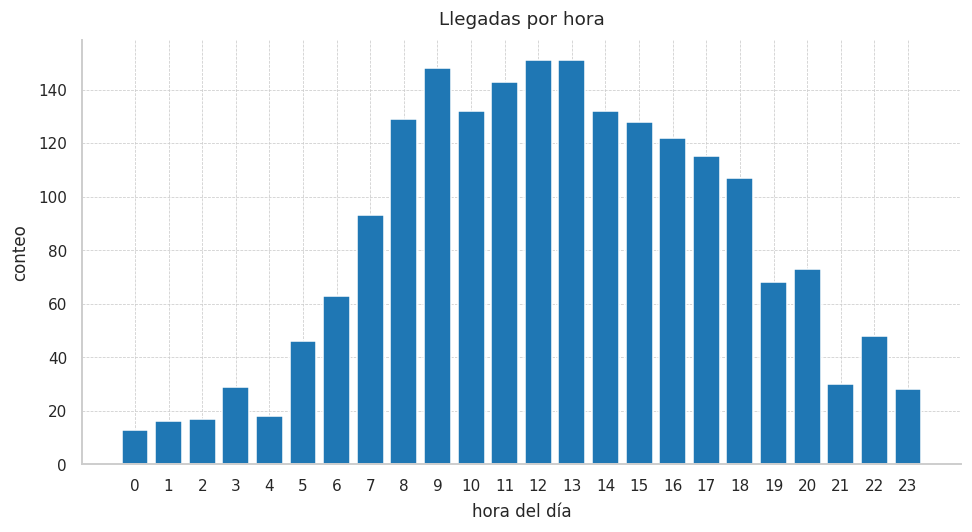


--- Mediana de door_to_imaging por hora de llegada ---


mediana        p75    n
arrival_hour                           
0             24.916958  32.963742   13
1             24.307121  28.257187   15
2             27.167451  29.812932   15
3             24.800226  30.523828   27
4             27.913574  29.721208   18
5             25.591999  31.170293   44
6             24.576654  29.717927   58
7             26.567187  30.716537   91
8             22.801916  26.846053  119
9             24.462947  28.830836  141
10            22.524197  27.073737  127
11            22.565246  26.653082  135
12            22.853348  28.979848  143
13            23.161385  27.860380  150
14            22.553017  27.431769  126
15            23.008829  27.788854  122
16            23.965502  27.585290  116
17            22.277034  26.635886  110
18            25.309895  30.426607  104
19            23.487168  28.758679   63
20            26.142521  29.419130   72
21            27.817423  32.677040   27
22            26.068039  30.550089   45
23            24.407299  27.287805   28

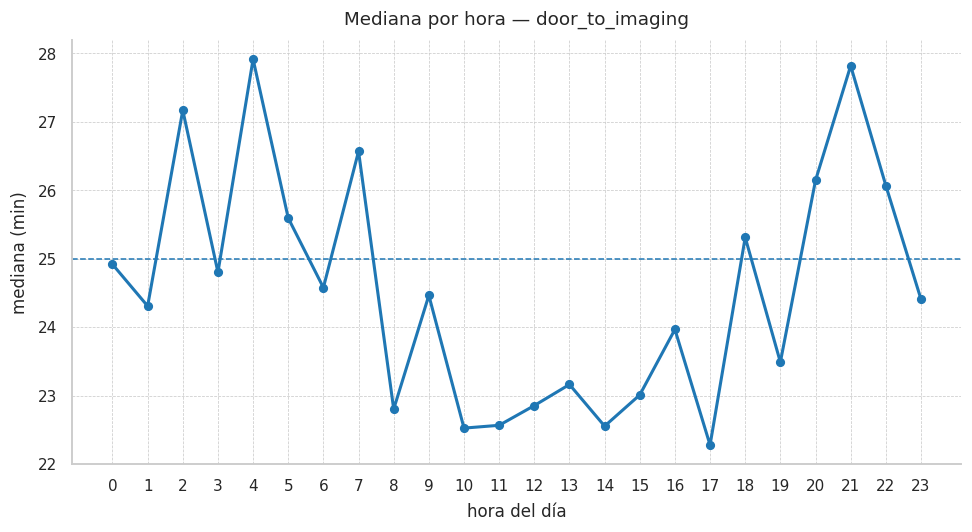


--- Mediana de door_to_needle por hora de llegada ---


mediana        p75    n
arrival_hour                           
0             53.737510  66.820088   13
1             51.213270  57.982057   16
2             57.968612  64.128992   17
3             58.139181  69.662113   29
4             60.610979  67.113371   18
5             57.233499  65.134472   46
6             60.808434  66.668350   63
7             58.649963  65.344505   93
8             52.025517  58.187757  129
9             53.671334  61.431657  148
10            52.992528  59.602175  132
11            53.256529  59.312254  143
12            51.233193  59.130793  151
13            53.692116  59.601556  151
14            51.595851  59.768850  132
15            51.851707  60.618317  128
16            52.789672  58.900341  122
17            51.464077  56.922315  115
18            57.279726  65.798510  107
19            56.195011  64.345823   68
20            58.228251  65.205134   73
21            57.289709  65.207873   30
22            61.248103  66.871396   48
23            57.299695  60.691414   28

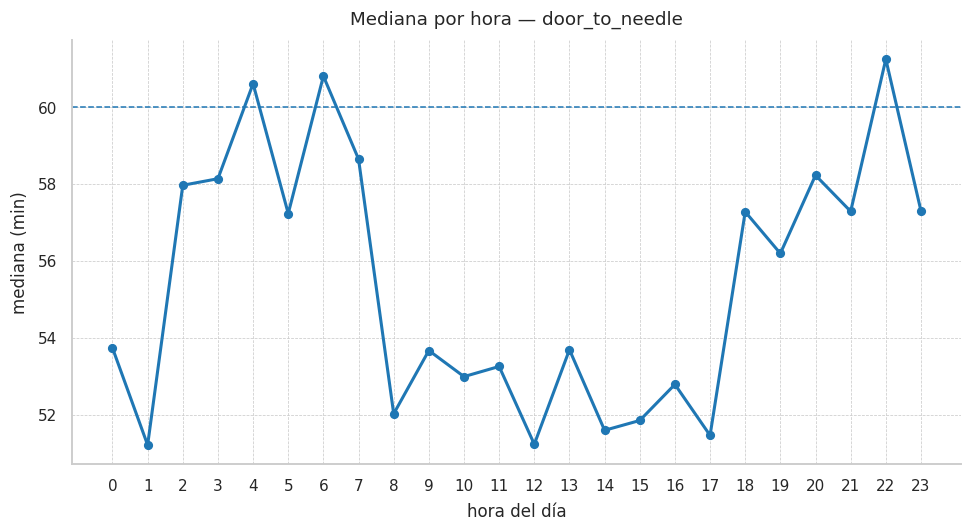


--- Mediana de imaging_to_decision por hora de llegada ---


mediana        p75    n
arrival_hour                           
0             18.657760  22.229273   13
1             15.272961  21.598951   15
2             16.370578  21.155721   16
3             18.428374  24.340713   26
4             21.059393  23.167353   16
5             18.826422  22.480409   43
6             21.303858  24.566016   56
7             19.295381  23.219521   85
8             16.563830  21.867580  125
9             18.247270  21.874232  130
10            17.508829  22.717837  117
11            17.218550  21.637321  135
12            15.883379  20.639294  141
13            17.177370  22.042412  134
14            17.797268  21.374844  125
15            16.718369  21.379341  115
16            17.113688  22.316591  115
17            15.263570  20.852920  105
18            19.487610  23.515097  101
19            19.619199  23.636535   61
20            19.588889  24.452244   65
21            17.551362  20.631325   26
22            21.489200  24.546148   44
23            18.317420  20.909561   24

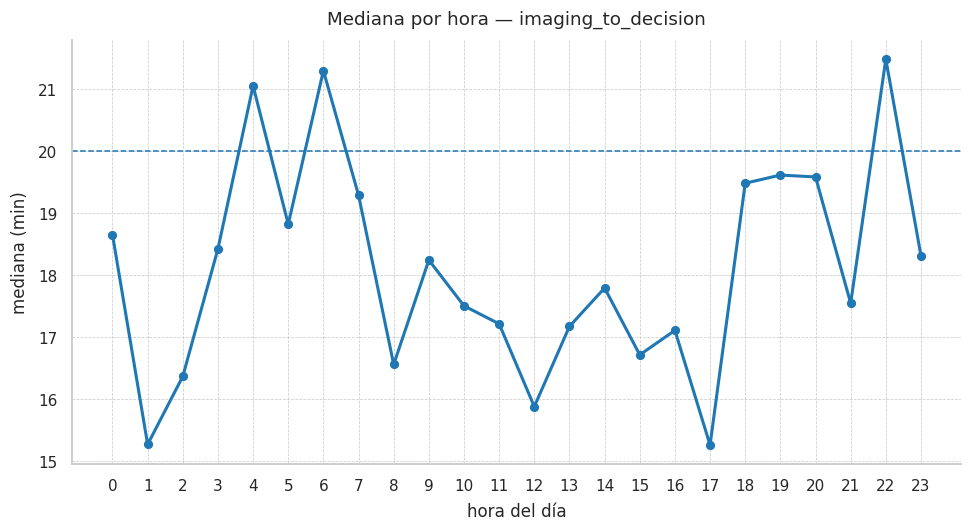


--- Mediana de decision_to_needle por hora de llegada ---


mediana        p75    n
arrival_hour                           
0             12.864286  15.987002   12
1             14.716629  15.883617   15
2             14.508383  15.518117   16
3             13.906516  15.869554   28
4             12.888336  15.803725   18
5             13.042706  15.470985   42
6             14.163994  16.650081   58
7             13.732698  15.813875   89
8             12.477079  14.663499  123
9             12.748405  15.862910  139
10            12.995198  14.749328  125
11            12.688622  14.868061  139
12            12.835394  15.079971  146
13            12.161531  14.220986  143
14            12.811227  15.153621  124
15            12.529262  14.889088  122
16            11.782403  13.753717  117
17            12.690706  14.802386  103
18            13.136680  16.474414  103
19            12.827014  15.647738   65
20            12.736669  15.204763   70
21            13.452542  15.481896   28
22            14.129113  16.862908   47
23            13.737665  16.370467   28

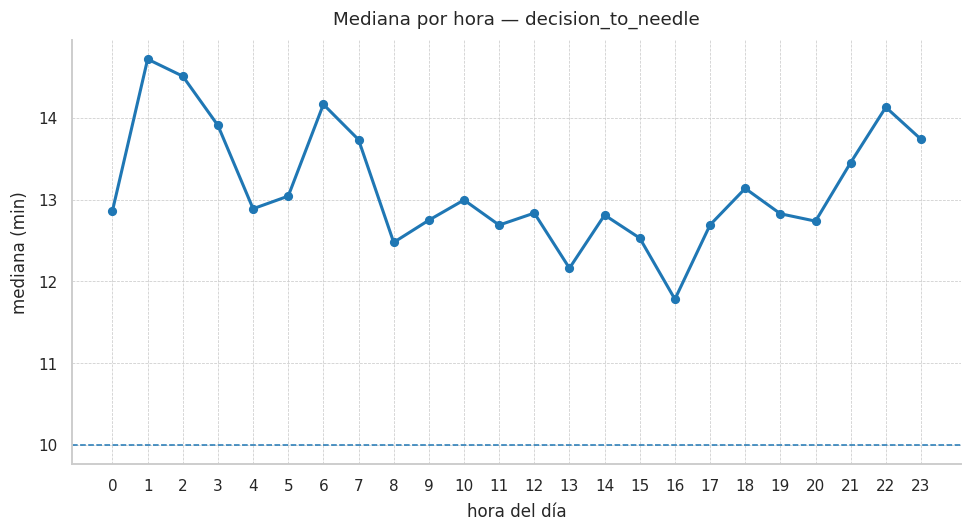

In [174]:
# === Variación intra–día: llegada por hora y su impacto en tiempos (EDA puro) ===

# Metas de referencia (solo para dibujar líneas en los gráficos)
time_goals_min = {
    "door_to_imaging": 25,
    "door_to_needle": 60,
    "imaging_to_decision": 20,
    "decision_to_needle": 10,
    "door_to_triage": 10,
    "door_to_neuro": 15,
    "onset_to_needle": 270,
}

# 1) Detectar columna de llegada y derivar series locales de hora/día
arrival_candidates = ["t_arrival", "arrival_ts", "arrival_time", "arrival_datetime"]
arr_col = next((c for c in arrival_candidates if c in df.columns), None)

if arr_col is None:
    print("No se encontró columna de llegada (t_arrival/arrival_ts/...); se omite análisis por hora.")
else:
    s_arrival = pd.to_datetime(df[arr_col], errors="coerce")  # SIN asignar a df
    arrival_hour = s_arrival.dt.hour
    arrival_dayofweek = s_arrival.dt.dayofweek
    is_weekend = arrival_dayofweek >= 5

    if arrival_hour.notna().sum() == 0:
        print("Ninguna fecha parseada correctamente en la columna de llegada.")
    else:
        # 2) Conteo de llegadas por hora
        print("\nDistribución de llegadas por hora (conteo):")
        counts_by_hour = arrival_hour.value_counts().sort_index()
        try:
            display(counts_by_hour)
        except NameError:
            print(counts_by_hour.to_string())

        plt.figure()
        x = np.arange(0, 24)
        y = counts_by_hour.reindex(x).fillna(0).values
        plt.bar(x, y)
        plt.xticks(x)
        plt.xlabel("hora del día"); plt.ylabel("conteo")
        plt.title("Llegadas por hora")
        plt.tight_layout()
        plt.show()

        # 3) Medianas por hora para tiempos clave disponibles (sin mutar df)
        metrics = [c for c in ["door_to_imaging","door_to_needle","imaging_to_decision","decision_to_needle"] if c in df.columns]
        all_rows = []

        for col in metrics:
            s_metric = pd.to_numeric(df[col], errors="coerce")
            aux = pd.DataFrame({"arrival_hour": arrival_hour, col: s_metric}).dropna(subset=["arrival_hour", col])
            if aux.empty:
                print(f"(Sin datos válidos para {col})")
                continue

            grp = (aux.groupby("arrival_hour")[col]
                     .agg(mediana="median", p75=lambda s: s.quantile(.75), n="size")
                     .sort_index())

            print(f"\n--- Mediana de {col} por hora de llegada ---")
            try:
                display(grp)
            except NameError:
                print(grp.to_string())

            # Gráfico: mediana por hora con línea horizontal de meta (si aplica)
            plt.figure()
            plt.plot(grp.index.values, grp["mediana"].values, marker="o")
            plt.xticks(np.arange(0, 24))
            plt.xlabel("hora del día"); plt.ylabel("mediana (min)")
            plt.title(f"Mediana por hora — {col}")
            meta = time_goals_min.get(col)
            if meta is not None:
                plt.axhline(meta, linestyle="--", linewidth=1)
            plt.tight_layout()
            plt.show()

            grp_local = grp.copy()
            grp_local["metric"] = col
            grp_local = grp_local.reset_index()
            all_rows.append(grp_local)

        hourly_medians = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

        if hourly_medians.empty:
            print("\n(No se pudieron calcular medianas por hora para las métricas seleccionadas.)")


## Tiempos críticos: valores típicos y extremos  *(EDA — solo lectura, sin mutar `df`)*

En esta sección se profundiza en la **variabilidad** de los tiempos críticos mediante:
- **Medidas descriptivas robustas:** mediana, cuartiles y percentiles altos (p90/p95), además de media/DE para contexto.
- **Extremos (outliers):** criterio de **Tukey (IQR + bigotes)**.
- **Forma de la distribución:** **skewness** (sesgo) y **kurtosis** (colas), típicamente **cola derecha** por congestión/retrasos.

**Objetivo operativo.**  
Determinar si los retrasos son **outliers aislados** (incidentes puntuales) o una **tendencia sistemática** (colas largas). Esto informa:
- **Winsorización** (p95/p99) o **transformaciones** (`log1p`) **solo en variables no temporales**.
- **Métricas de reporte** centradas en **mediana/IQR** (menos sensibles a colas).
- **Estratificación** por **turno** (p. ej., `arrival_hour`/`is_night`), **fin de semana** (`is_weekend`) y **crowding** (si existe).

---

### Valores observados (dataset actual; minutos, p25 — mediana — p75)
- `door_to_imaging` (DTI): **18,83 — 23,53 — 28,48**  
- `imaging_to_decision`: **13,44 — 17,89 — 22,35**  
- `decision_to_needle`: **10,29 — 12,86 — 15,31**  
- `door_to_needle` (DTN): **47,29 — 54,21 — 61,73**

> **Lectura rápida.** Mediana **DTN = 54,2 min** y **p75 = 61,7 min** → **cola derecha**; ~**30%** supera 60 min (consistente con `delay_gt_60` ≈ 29,9%).

---

### Resultado esperado (tablas EDA)
Para cada tiempo crítico, una tabla con:  
**n, media, DE, p25/p50/p75/p90/p95, min–max, skew, kurtosis, % outliers (Tukey)**.  
Estas tablas sirven de insumo directo para **preprocesamiento** (qué no transformar ni winsorizar), **selección de métricas** y **reglas de umbral** en el modelado.

> *Nota EDA:* Este análisis **no crea ni persiste** columnas nuevas (p. ej., `flag_*`). Cualquier `flag_*` se **derivará temporalmente** solo para visualizar (si se requiere) y se **construirá de forma persistente en Preprocesamiento (4.d)**.


### Outliers y colas (Tukey, *skew* y *kurtosis*)  *(EDA — solo lectura, sin mutar `df`)*

**Qué hacemos.**  
Se evalúan los **tiempos críticos** aplicando:
- **Criterio de Tukey (1.5·IQR)**: cálculo de *fences* y **% de outliers** por variable.
- **Medidas de forma**: **asimetría (*skewness*)** y **apuntamiento (*kurtosis*)** para caracterizar **colas** (especialmente derechas).

**Visualizaciones incluidas.**  
- **Boxplots** con *fences* (rango típico y extremos).  
- **Boxplots estratificados** por `delay_gt_60` (diferencias de distribución por clase).  
- **Ranked scatter** (valores ordenados) para ver colas largas.  
- **Histogramas `log1p`** para estabilizar colas derechas.  
- **Q–Q plots `log1p`** (contraste con normalidad; no se espera normalidad exacta).

**Hallazgos guía esperados (`robust_tbl`).**  
- **DTN** y **DTI** concentran una mayor proporción de *outliers*, reflejando variabilidad operativa en imagenología y flujo hacia la trombólisis.  
- **decision_to_needle** y **door_to_triage** suelen mostrar distribuciones más **compactas**.  
- **Skew > 0** en la mayoría de los tiempos confirma **colas derechas** (subgrupos con demoras prolongadas).  
- En este dataset, los cuartiles observados (p25—p50—p75) fueron:  
  - `door_to_imaging`: **18,83—23,53—28,48**  
  - `imaging_to_decision`: **13,44—17,89—22,35**  
  - `decision_to_needle`: **10,29—12,86—15,31**  
  - `door_to_needle`: **47,29—54,21—61,73**

**Acciones sugeridas si >5% de outliers (solo guía EDA).**  
- **Winsorización** focal (p95/p99) o **transformación `log1p`** en **variables no temporales**.  
- Reportar **medianas/IQR** y percentiles altos (p90/p95) en vez de medias sensibles a colas.  
- **Estratificar** por `arrival_hour`/`is_night`, `is_weekend` y crowding (si existe) cuando los outliers se concentren en subgrupos.  
- **Documentar** explícitamente cualquier decisión para garantizar **reproducibilidad**.

> *Nota:* Este bloque **no crea flags ni modifica `df`**. Las `flag_*` persistentes se generan en **Preprocesamiento (4.d)**; aquí solo se exploran patrones y se preparan decisiones.



▶ Outliers (Tukey) y colas por tiempos:


n  outlier_n  outlier_pct  lo_fence  hi_fence  skew  kurtosis
door_to_neuro        1910.0       25.0         1.31      3.24     26.45  0.21      0.09
door_to_needle       2000.0       16.0         0.80     25.63     83.39  0.13      0.04
decision_to_needle   1900.0       14.0         0.74      2.76     22.84 -0.04     -0.01
onset_to_needle      1772.0        7.0         0.40      9.47    342.72  0.12     -0.33
imaging_to_decision  1833.0        6.0         0.33      0.07     35.71  0.11     -0.20
door_to_imaging      1909.0        5.0         0.26      4.34     42.97  0.04     -0.11
door_to_triage       1935.0        4.0         0.21      0.35     16.74  0.09     -0.26

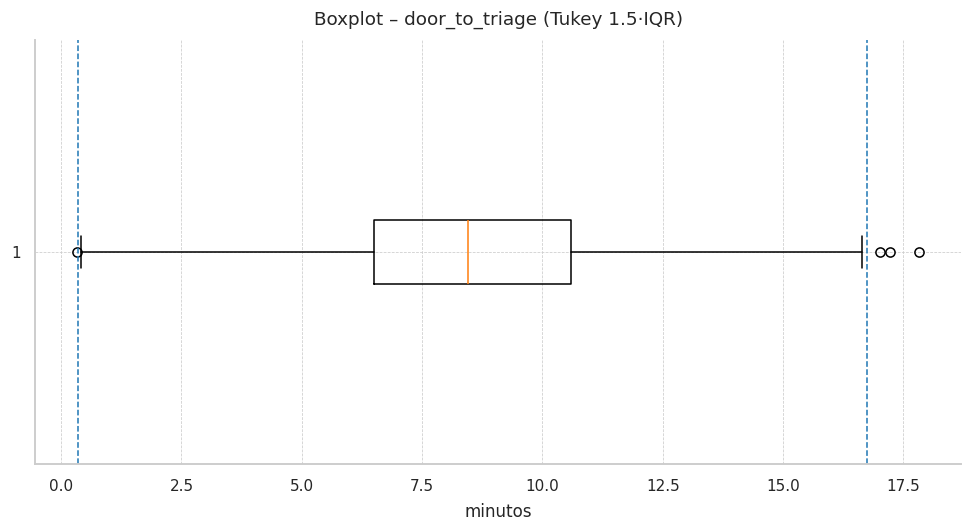

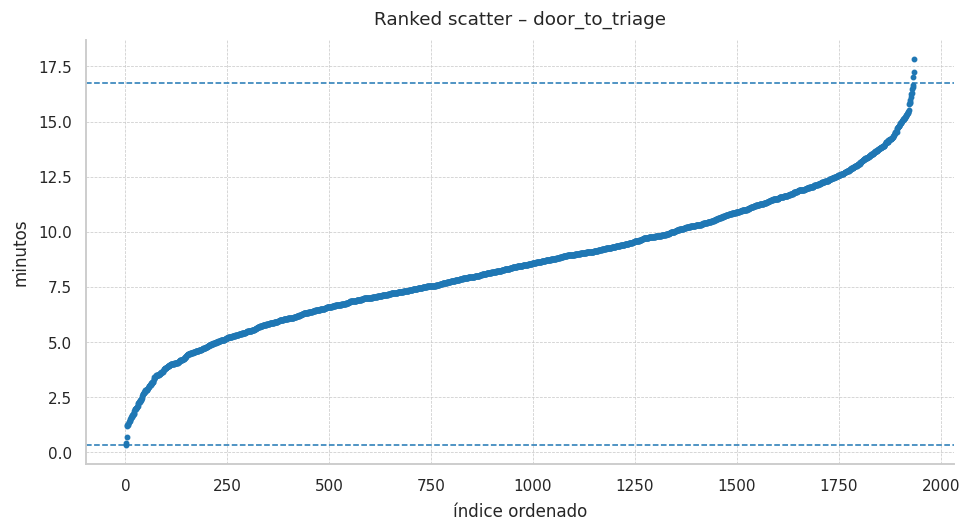

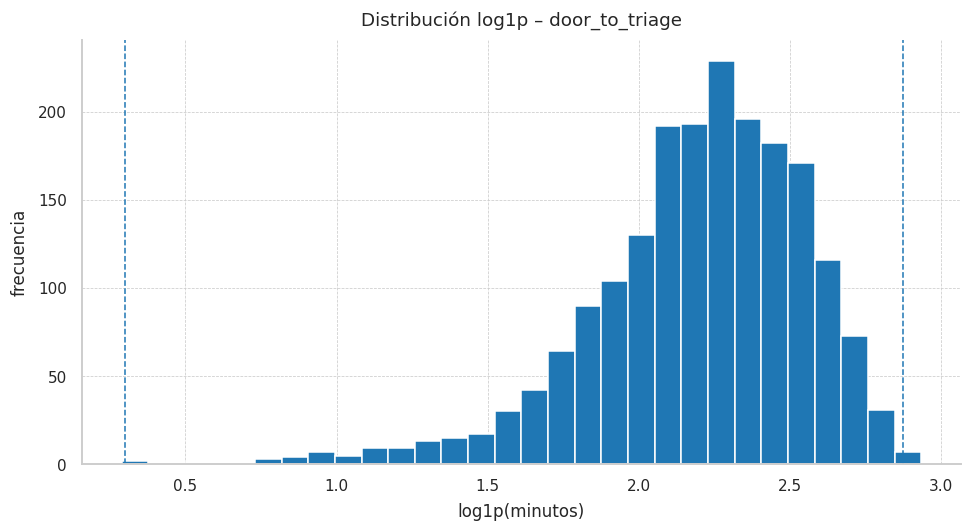

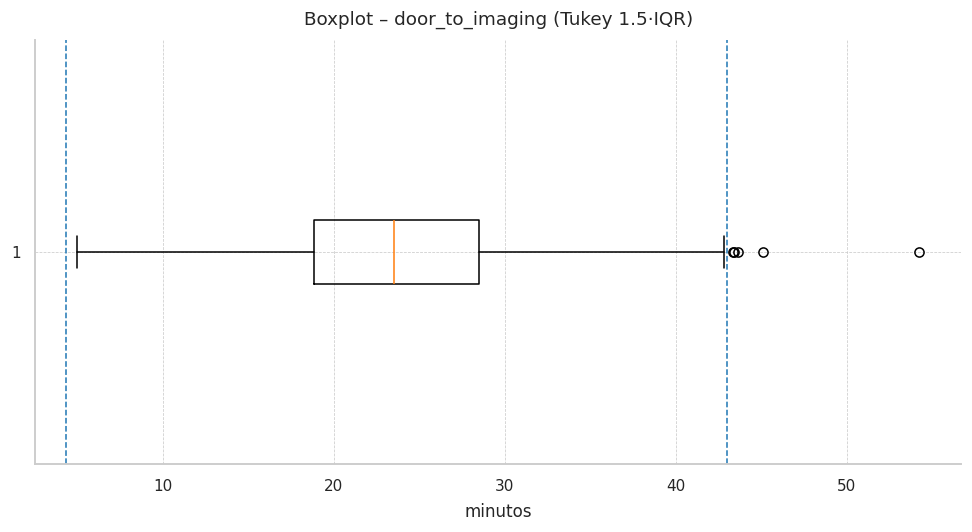

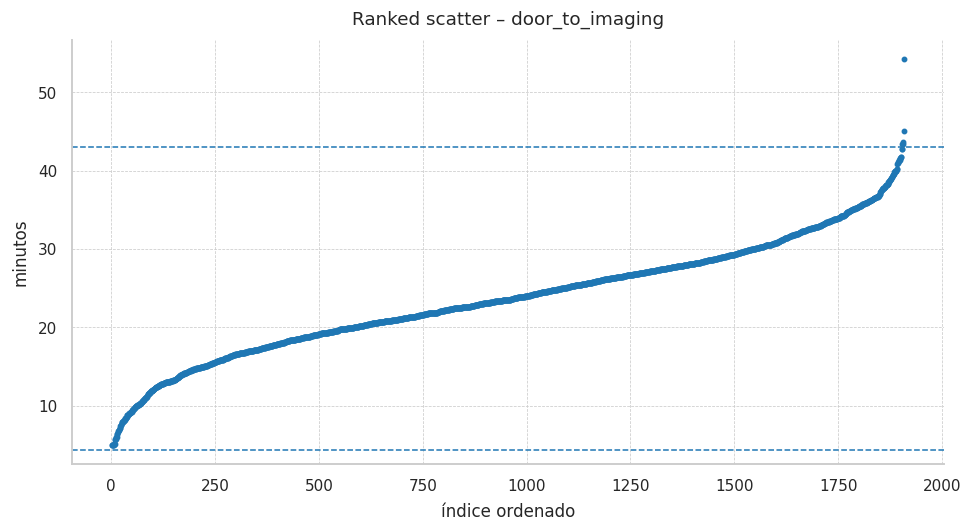

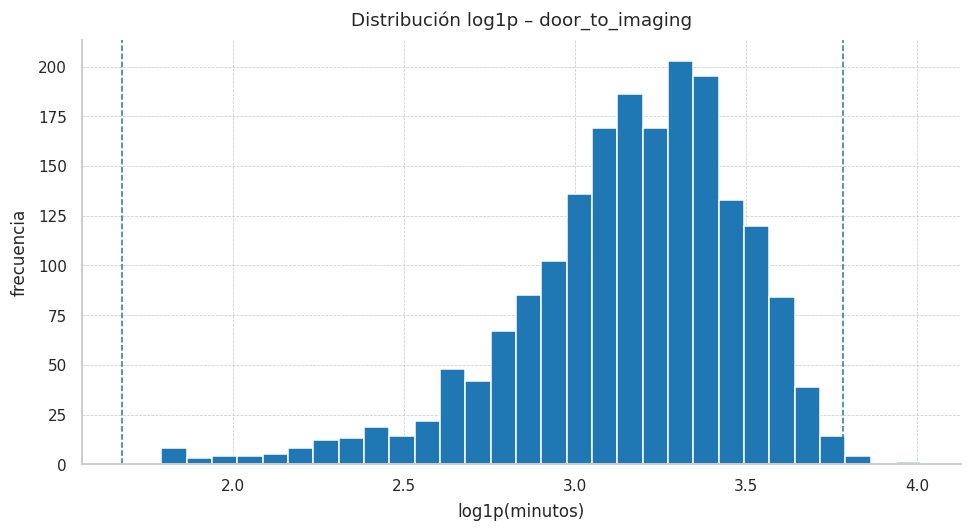

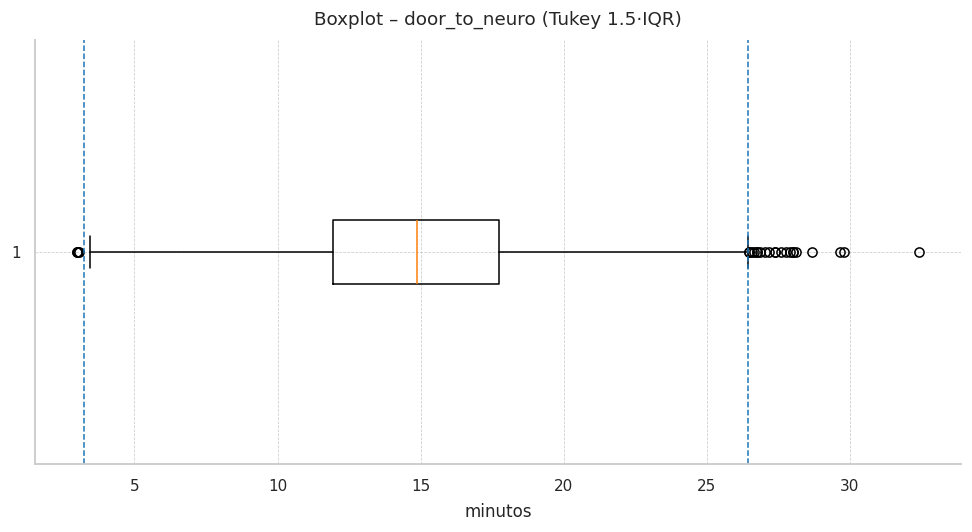

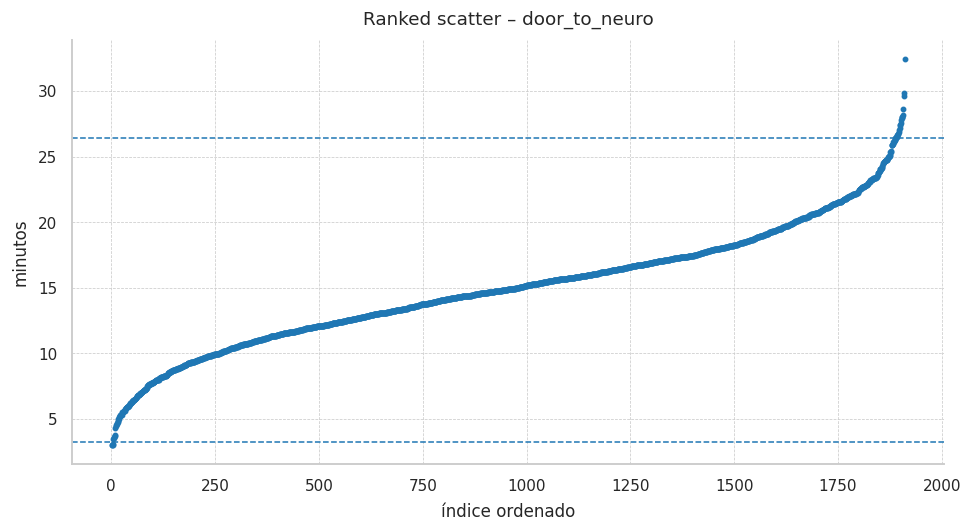

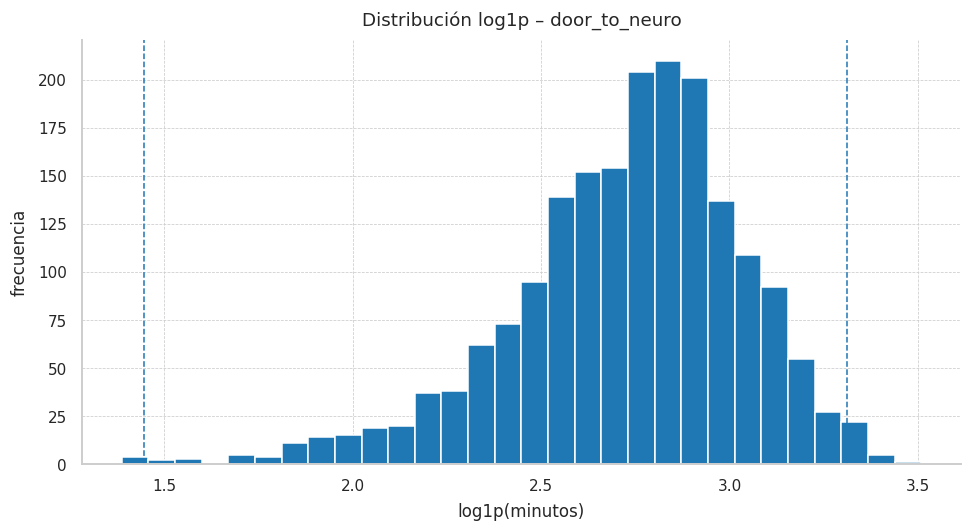

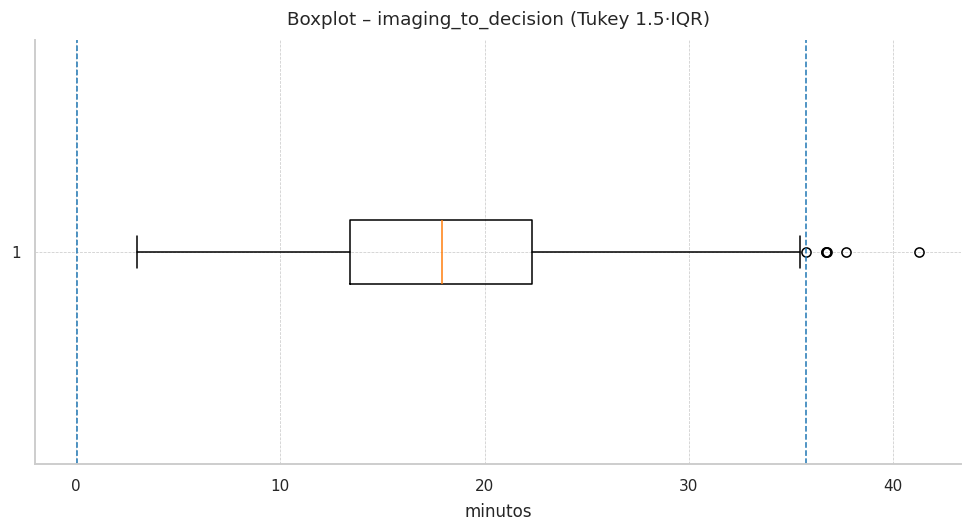

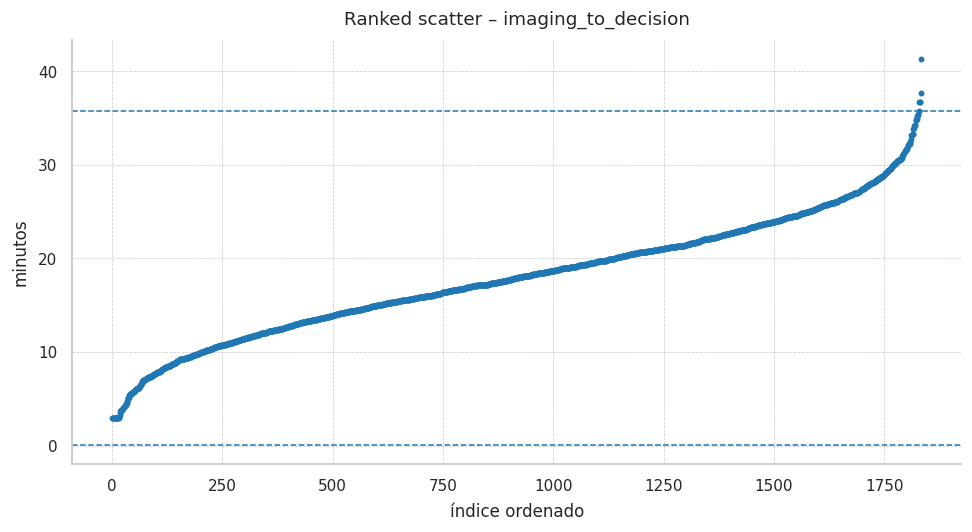

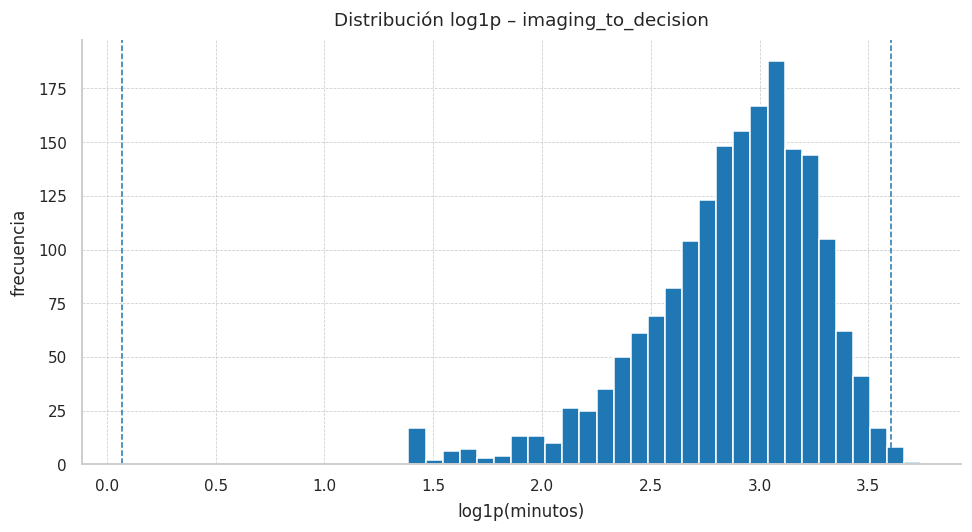

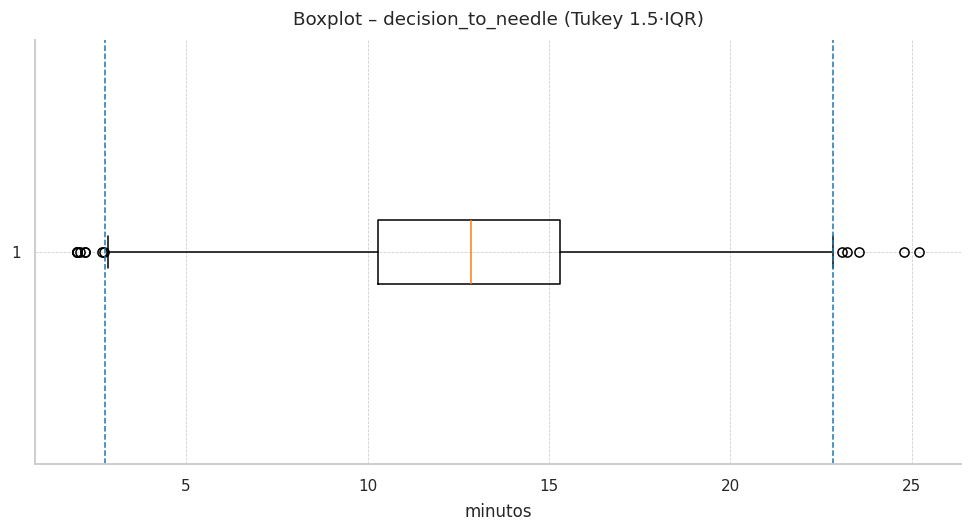

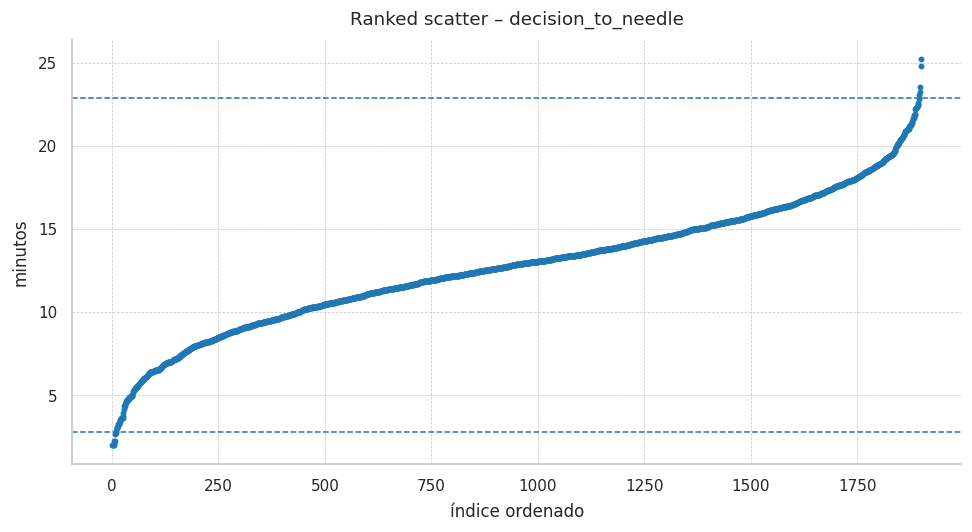

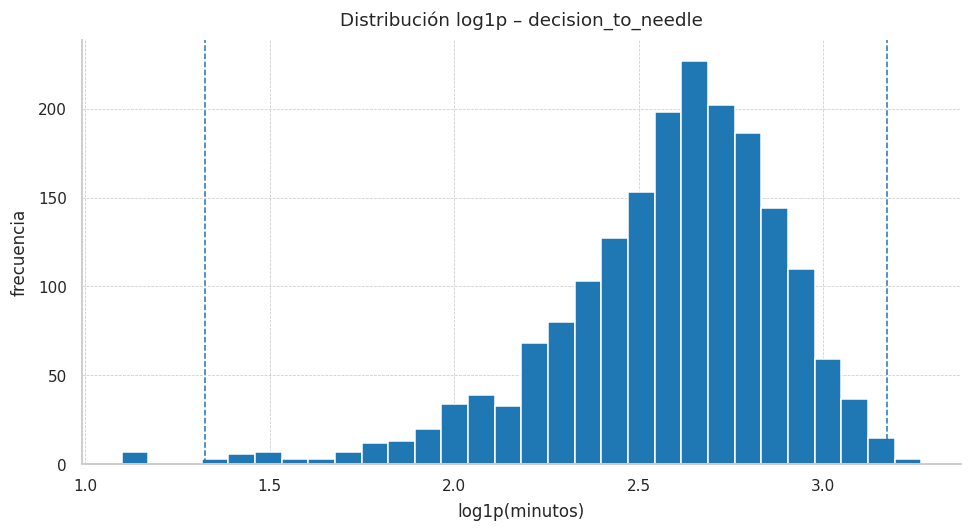

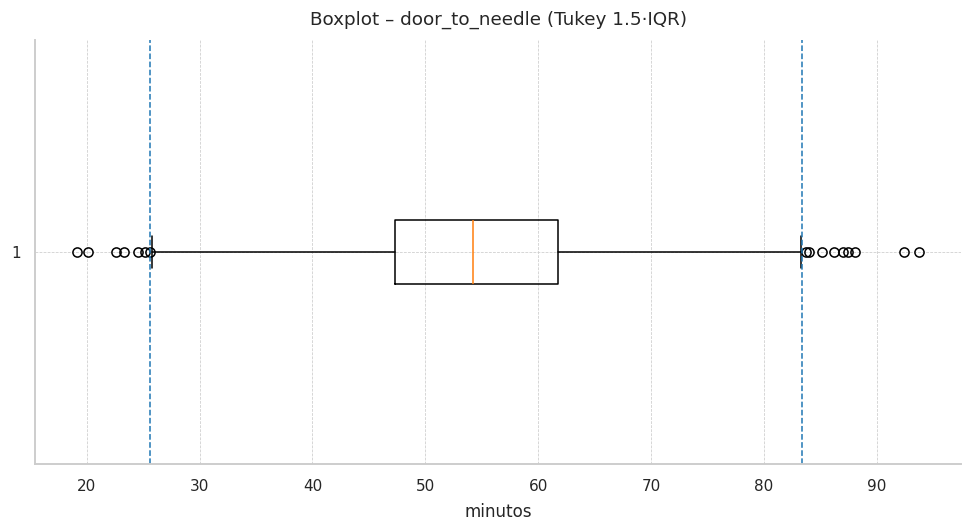

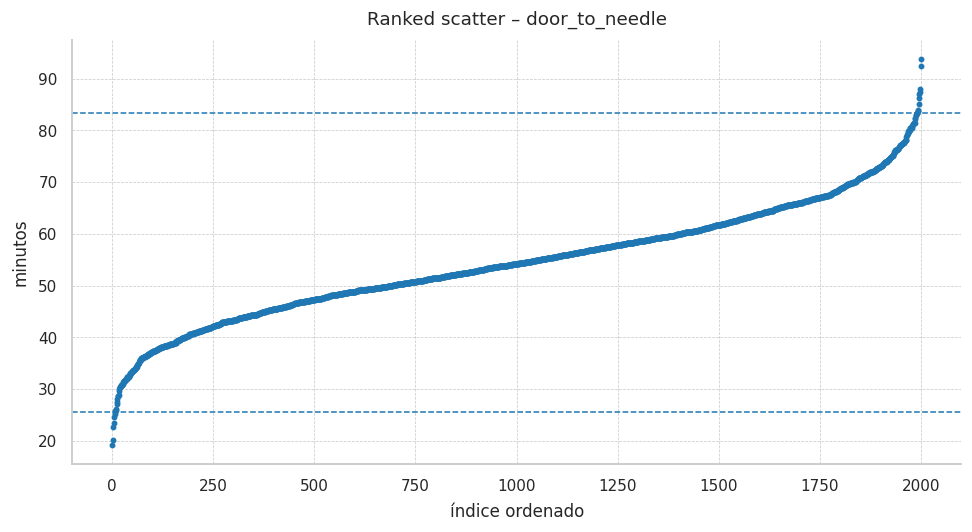

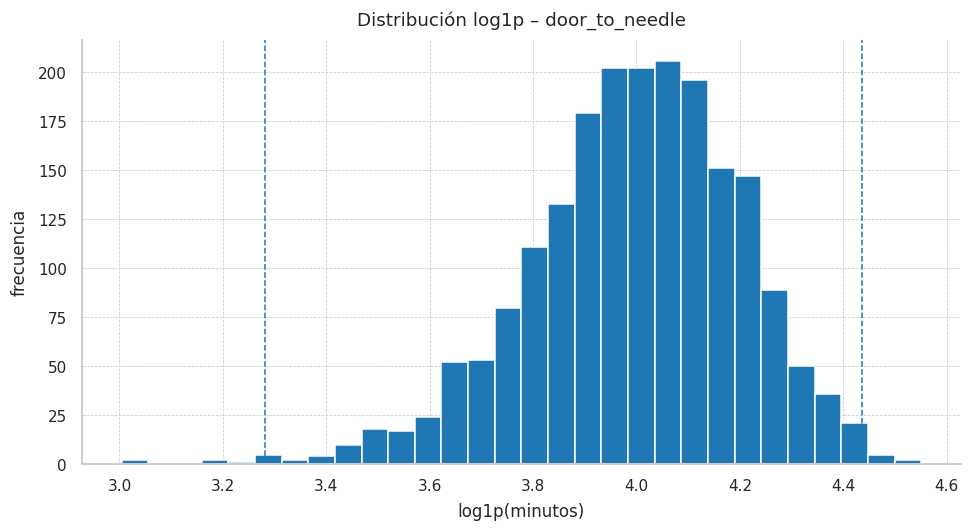

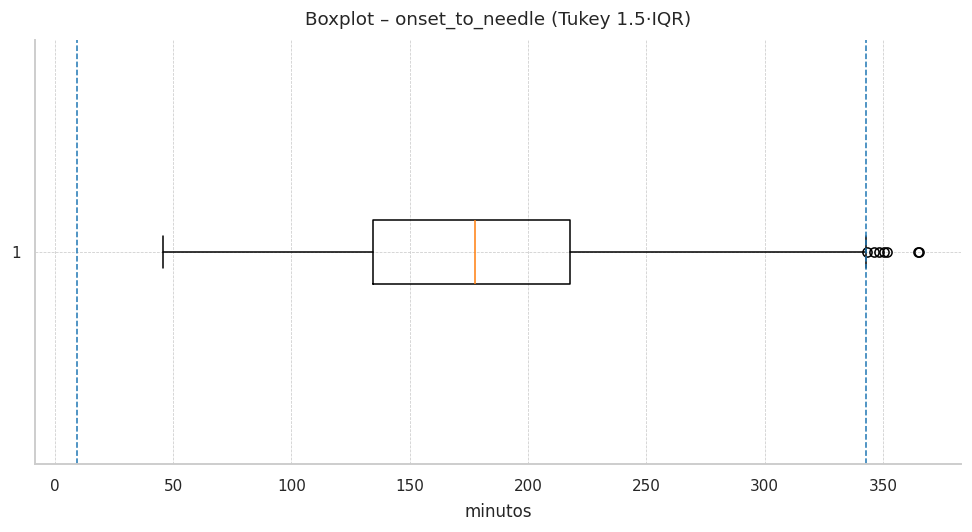

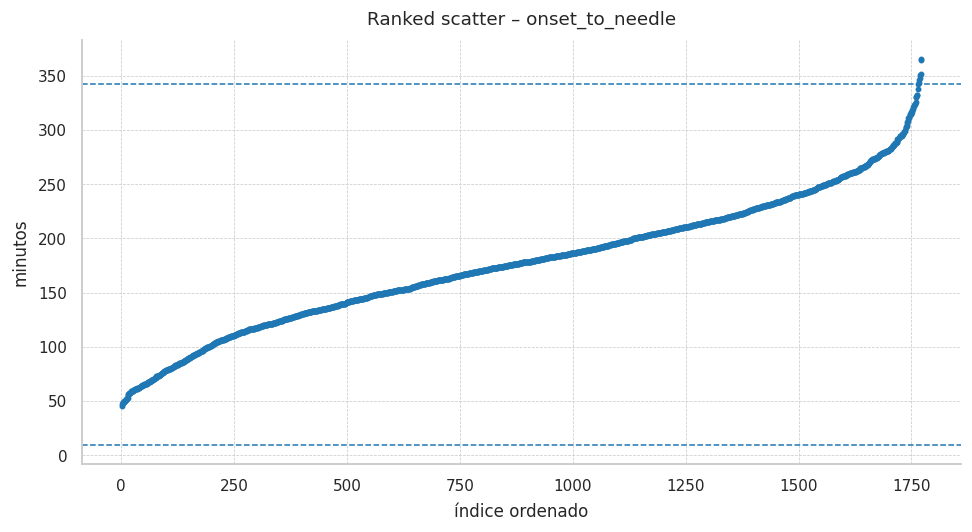

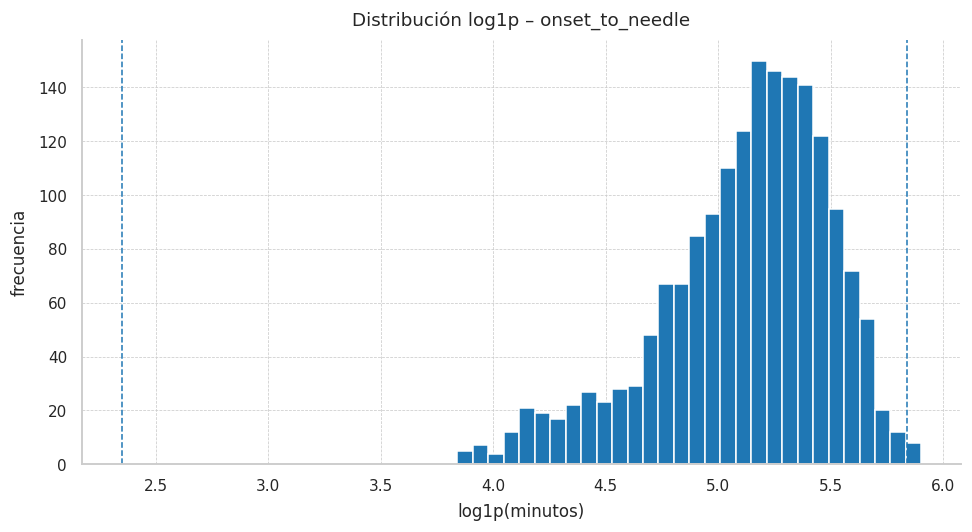

In [175]:
# === Outliers y colas (EDA puro, sin preprocesamiento de df) ===

# 1) Columnas de tiempo disponibles
time_cols_all = [
    "door_to_triage","door_to_imaging","door_to_neuro",
    "imaging_to_decision","decision_to_needle","door_to_needle",
    "onset_to_needle","dtn_min","door_to_imaging_min",
    "imaging_to_needle_min","onset_to_door_min"
]
out_time_cols = [c for c in time_cols_all if c in df.columns]

# 2) Funciones auxiliares
def tukey_outlier_info(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.Series({"n":0,"outlier_n":0,"outlier_pct":np.nan,"lo_fence":np.nan,"hi_fence":np.nan})
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    out = (s < lo) | (s > hi)
    return pd.Series({
        "n": int(s.size),
        "outlier_n": int(out.sum()),
        "outlier_pct": 100*float(out.mean()),
        "lo_fence": float(lo),
        "hi_fence": float(hi),
    })

def skew_kurtosis(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.Series({"skew": np.nan, "kurtosis": np.nan})
    return pd.Series({"skew": float(s.skew()), "kurtosis": float(s.kurt())})

# 3) Tabla de resumen robusto
if out_time_cols:
    tukey_tbl = pd.concat({c: tukey_outlier_info(df[c]) for c in out_time_cols}, axis=1).T
    sk_tbl    = pd.concat({c: skew_kurtosis(df[c])      for c in out_time_cols}, axis=1).T
    robust_tbl = pd.concat([tukey_tbl, sk_tbl], axis=1).sort_values(by="outlier_pct", ascending=False).round(2)
    print("\n▶ Outliers (Tukey) y colas por tiempos:")
    display(robust_tbl)
else:
    robust_tbl = pd.DataFrame(columns=["n","outlier_n","outlier_pct","lo_fence","hi_fence","skew","kurtosis"])
    print("No se encontraron columnas de tiempos en el DataFrame.")

# 4) Función para recuperar fences (usa robust_tbl como referencia)
def get_fences(col, series):
    lo = hi = np.nan
    if col in robust_tbl.index:
        lo = robust_tbl.loc[col].get("lo_fence", np.nan)
        hi = robust_tbl.loc[col].get("hi_fence", np.nan)
    if not np.isfinite(lo) or not np.isfinite(hi):
        s = pd.to_numeric(series, errors="coerce").dropna()
        if not s.empty:
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lo, hi

# 5) Visualizaciones
for col in out_time_cols:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        continue
    lo, hi = get_fences(col, s)

    # Boxplot simple
    plt.figure()
    plt.boxplot(s, vert=False, whis=1.5)
    plt.title(f"Boxplot – {col} (Tukey 1.5·IQR)")
    plt.xlabel("minutos")
    if np.isfinite(lo): plt.axvline(lo, linestyle="--", linewidth=1)
    if np.isfinite(hi): plt.axvline(hi, linestyle="--", linewidth=1)
    plt.tight_layout(); plt.show()

    # Ranked scatter
    plt.figure()
    x = np.arange(1, len(s)+1); y = np.sort(s.values)
    plt.scatter(x, y, s=8)
    plt.title(f"Ranked scatter – {col}")
    plt.xlabel("índice ordenado"); plt.ylabel("minutos")
    if np.isfinite(lo): plt.axhline(lo, linestyle="--", linewidth=1)
    if np.isfinite(hi): plt.axhline(hi, linestyle="--", linewidth=1)
    plt.tight_layout(); plt.show()

    # Histograma en log1p
    s_pos = s[s >= 0]
    if not s_pos.empty:
        plt.figure()
        plt.hist(np.log1p(s_pos), bins=30)
        plt.title(f"Distribución log1p – {col}")
        plt.xlabel("log1p(minutos)"); plt.ylabel("frecuencia")
        if np.isfinite(lo) and lo >= 0: plt.axvline(np.log1p(lo), linestyle="--", linewidth=1)
        if np.isfinite(hi) and hi >= 0: plt.axvline(np.log1p(hi), linestyle="--", linewidth=1)
        plt.tight_layout(); plt.show()


## Casos extremos (Top-k)

Las tablas siguientes listan los **Top-10** más **altos** y **bajos** por cada tiempo.  
**Uso recomendado:**
- Auditoría de **cuellos de botella** (p.ej., `door_to_imaging` extremos → disponibilidad de TC).
- Validación de **data quality** (tiempos imposibles o negativos deben ser revisados/filtrados).
- Generación de **casos de estudio** para acciones de mejora (Lean/Kaizen del flujo ACV).



Top 10 valores ALTOS en door_to_triage


idx  door_to_triage  is_weekend  delay_gt_60
0  1536           17.83           1            0
1  1236           17.23           1            0
2  1639           17.01           0            1
3   646           16.64           1            0
4   138           16.58           0            1
5   521           16.50           1            0
6   149           16.30           0            1
7   343           16.23           0            0
8  1556           16.10           0            0
9    42           15.98           1            1


Top 10 valores BAJOS (≥0) en door_to_triage


idx  door_to_triage  is_weekend  delay_gt_60
0  1979            0.33           0            1
1  1081            0.40           0            0
2  1153            0.70           0            0
3   245            1.20           1            1
4  1600            1.22           1            0
5   416            1.26           0            0
6  1867            1.30           0            0
7  1229            1.38           0            1
8  1077            1.39           1            0
9  1581            1.43           0            1


Top 10 valores ALTOS en door_to_imaging


idx  door_to_imaging  is_weekend  delay_gt_60
0   606            54.23           0            1
1   455            45.07           1            1
2   940            43.66           1            1
3  1013            43.37           1            1
4  1050            43.35           0            1
5  1076            42.79           0            1
6   982            42.76           1            1
7  1575            41.81           1            1
8     1            41.69           1            1
9   730            41.65           0            1


Top 10 valores BAJOS (≥0) en door_to_imaging


idx  door_to_imaging  is_weekend  delay_gt_60
0  1957             5.00           0            0
1  1330             5.00           0            0
2   363             5.00           0            0
3  1786             5.00           0            0
4  1495             5.00           0            0
5    38             5.00           0            0
6   462             5.11           0            0
7   596             5.19           0            0
8   693             5.65           0            0
9   322             5.79           1            0


Top 10 valores ALTOS en door_to_neuro


idx  door_to_neuro  is_weekend  delay_gt_60
0  1132          32.43           0            0
1  1070          29.81           0            1
2   166          29.64           1            0
3  1762          28.66           1            1
4  1229          28.14           0            1
5   888          28.03           0            1
6   274          28.00           0            1
7   205          27.92           0            0
8  1800          27.79           0            0
9   735          27.58           0            0


Top 10 valores BAJOS (≥0) en door_to_neuro


idx  door_to_neuro  is_weekend  delay_gt_60
0  1326           3.00           0            1
1  1589           3.00           0            0
2  1101           3.02           1            0
3  1431           3.06           0            1
4  1545           3.45           0            1
5   942           3.52           0            1
6  1813           3.61           0            0
7  1295           3.72           0            1
8    94           3.79           0            0
9   957           4.32           0            1


Top 10 valores ALTOS en imaging_to_decision


idx  imaging_to_decision  is_weekend  delay_gt_60
0  1405                41.27           1            1
1   317                37.71           0            1
2  1319                36.74           1            1
3  1328                36.70           0            1
4  1286                36.69           0            1
5  1479                35.74           0            1
6  1407                35.41           0            1
7  1742                35.33           1            1
8   216                35.20           1            1
9   888                35.09           0            1


Top 10 valores BAJOS (≥0) en imaging_to_decision


idx  imaging_to_decision  is_weekend  delay_gt_60
0  1936                  3.0           0            0
1   784                  3.0           0            0
2   760                  3.0           0            0
3   742                  3.0           0            0
4  1123                  3.0           1            0
5   844                  3.0           1            0
6  1464                  3.0           1            0
7   588                  3.0           0            0
8  1570                  3.0           1            0
9   436                  3.0           0            0


Top 10 valores ALTOS en decision_to_needle


idx  decision_to_needle  is_weekend  delay_gt_60
0   785               25.20           0            1
1   869               24.79           0            1
2  1816               23.55           1            1
3  1387               23.21           0            1
4   814               23.08           1            0
5   750               22.84           0            0
6   147               22.58           1            1
7   259               22.48           0            0
8  1838               22.45           1            0
9   111               22.33           1            1


Top 10 valores BAJOS (≥0) en decision_to_needle


idx  decision_to_needle  is_weekend  delay_gt_60
0   496                2.00           0            1
1  1905                2.00           0            0
2  1978                2.00           0            0
3  1818                2.00           0            0
4  1815                2.07           0            0
5  1078                2.22           0            0
6   467                2.22           0            0
7   836                2.67           0            0
8  1468                2.75           1            0
9    35                2.86           0            0


Top 10 valores ALTOS en door_to_needle


idx  door_to_needle  is_weekend  delay_gt_60
0  1405           93.74           1            1
1   455           92.43           1            1
2  1575           88.07           1            1
3    51           87.42           0            1
4  1076           87.01           0            1
5   606           86.15           0            1
6   730           85.14           0            1
7   840           83.97           0            1
8   977           83.71           0            1
9   869           83.29           0            1


Top 10 valores BAJOS (≥0) en door_to_needle


idx  door_to_needle  is_weekend  delay_gt_60
0  1629           19.17           0            0
1  1957           20.13           0            0
2   322           22.64           1            0
3   588           23.34           0            0
4  1495           24.59           0            0
5  1786           25.18           0            0
6   672           25.59           0            0
7   211           25.81           0            0
8  1084           26.00           0            0
9   832           26.17           0            0


Top 10 valores ALTOS en onset_to_needle


idx  onset_to_needle  is_weekend  delay_gt_60
0   523           365.30           0            0
1  1533           364.90           0            0
2   791           351.59           0            0
3  1498           350.43           1            1
4  1140           348.39           0            0
5   536           346.10           1            0
6    22           343.33           0            1
7   607           342.66           0            1
8  1035           337.53           0            0
9  1183           332.42           0            1


Top 10 valores BAJOS (≥0) en onset_to_needle


idx  onset_to_needle  is_weekend  delay_gt_60
0    75            45.58           1            0
1   782            47.16           0            0
2   117            48.13           0            0
3  1860            48.27           0            0
4   735            48.78           0            0
5   542            49.48           0            0
6  1162            49.66           1            0
7   751            49.85           1            0
8  1611            50.15           0            0
9    89            50.68           0            0

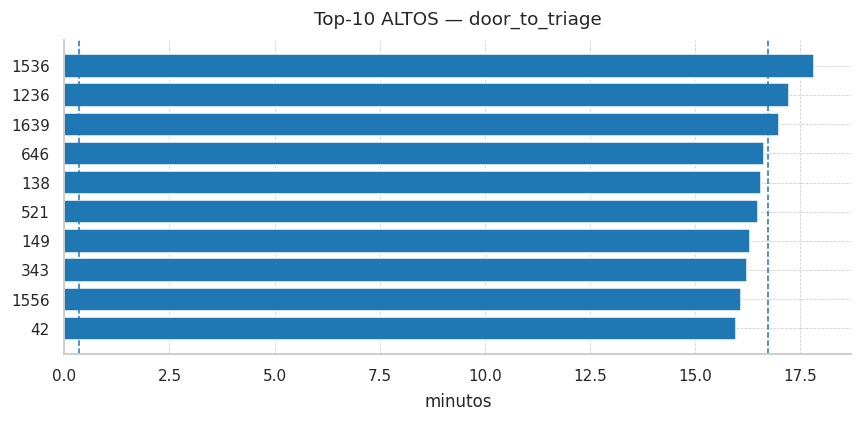

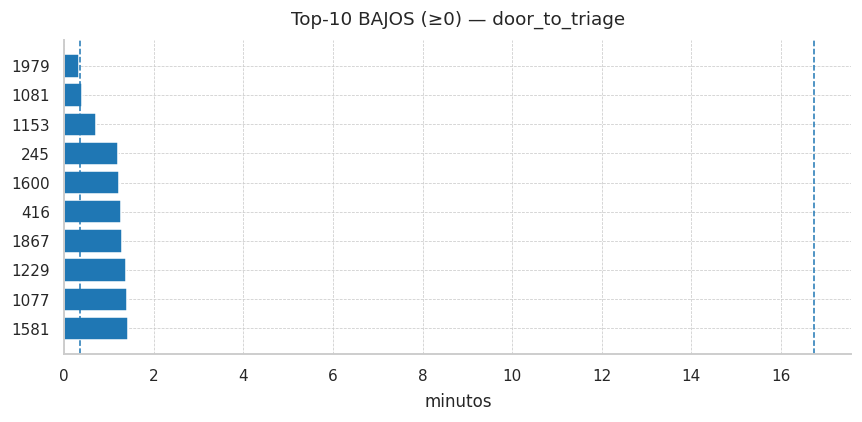

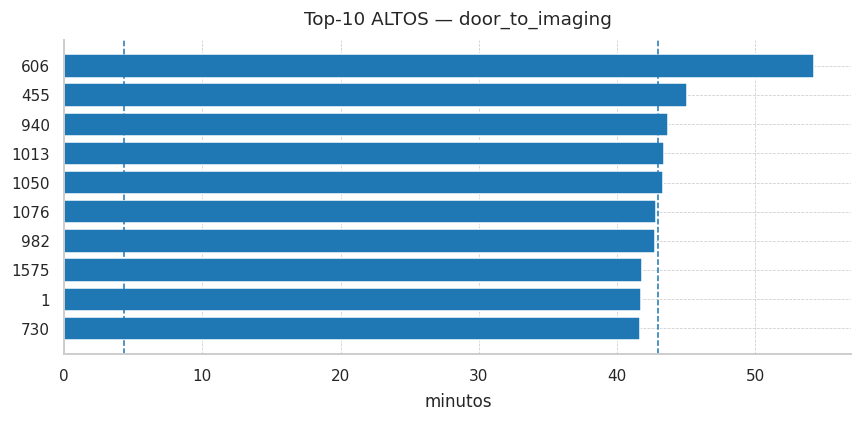

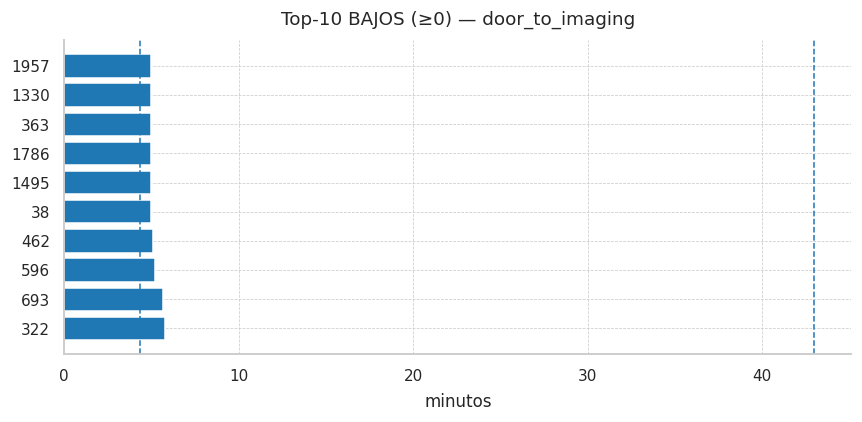

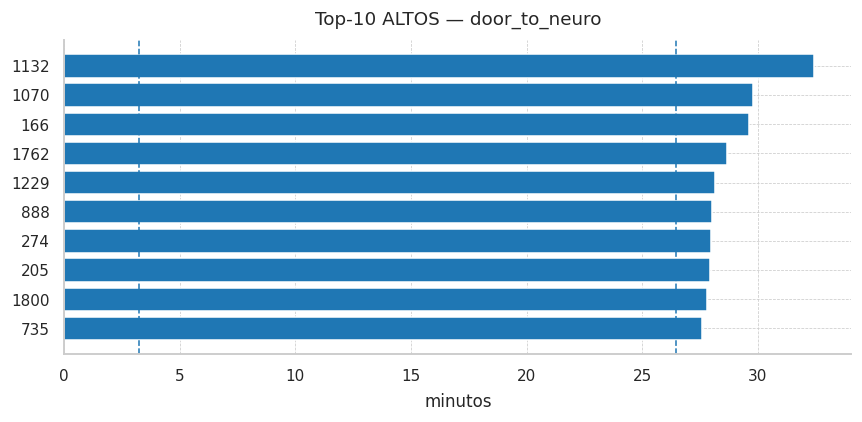

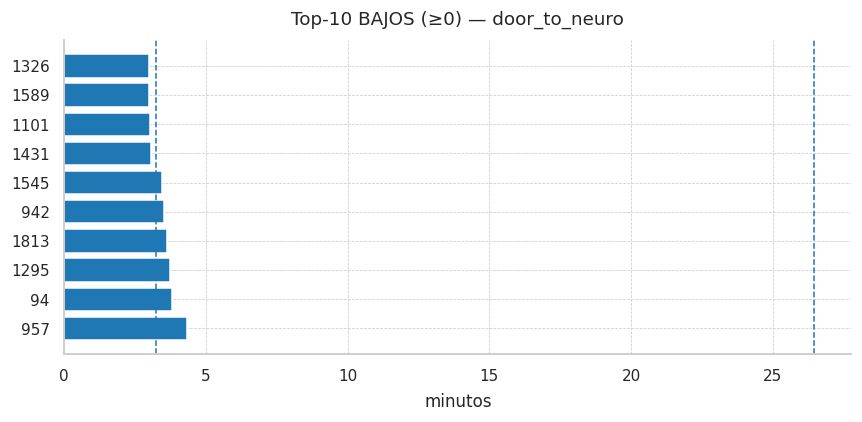

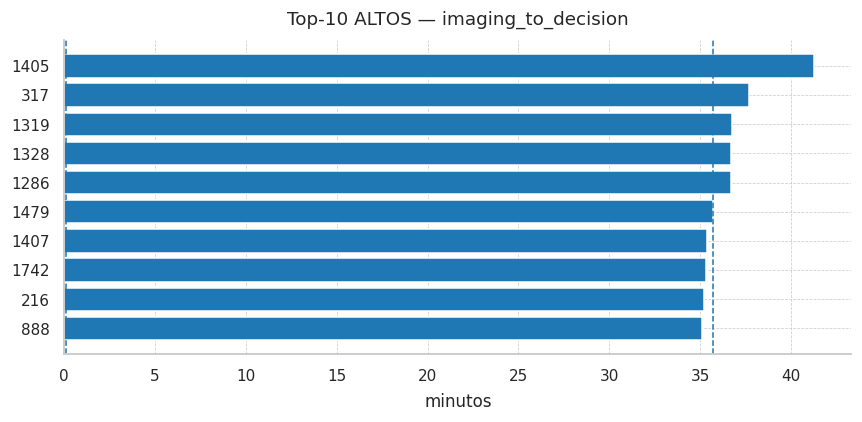

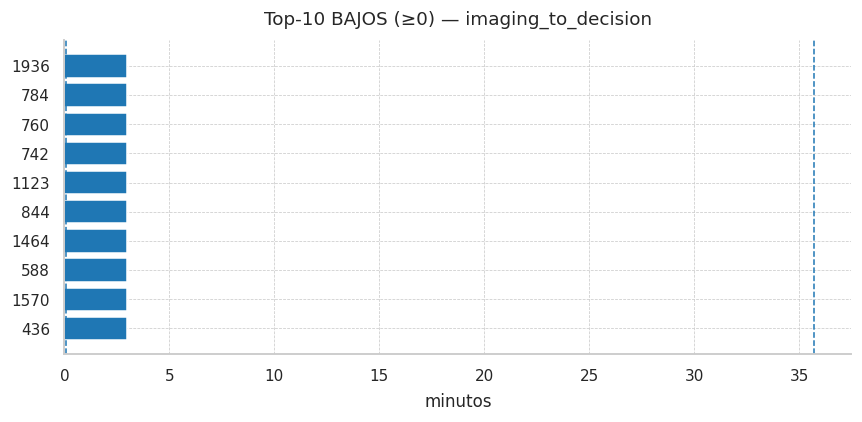

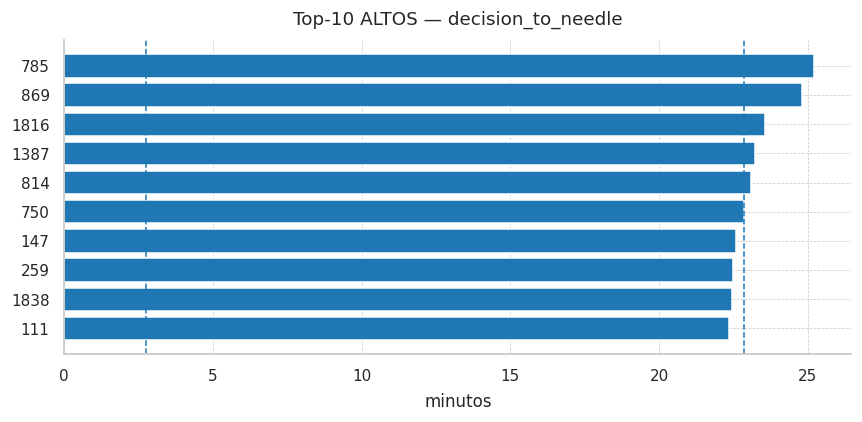

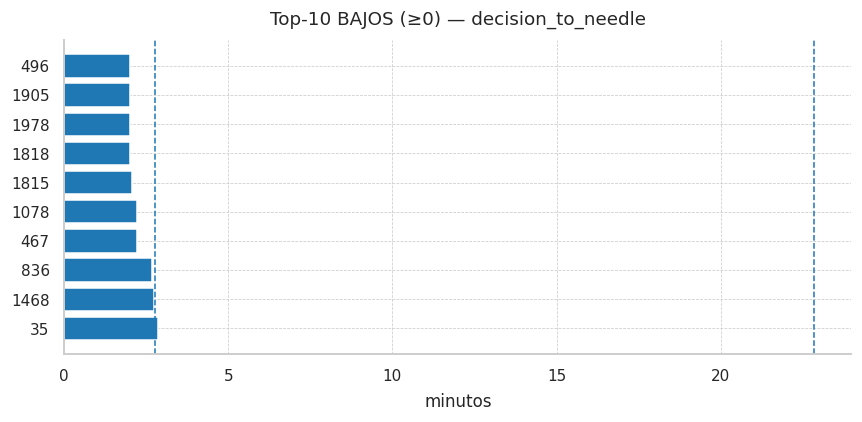

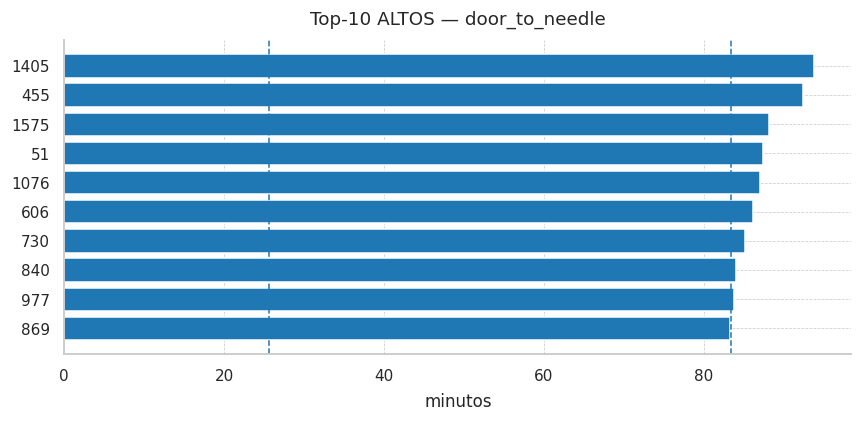

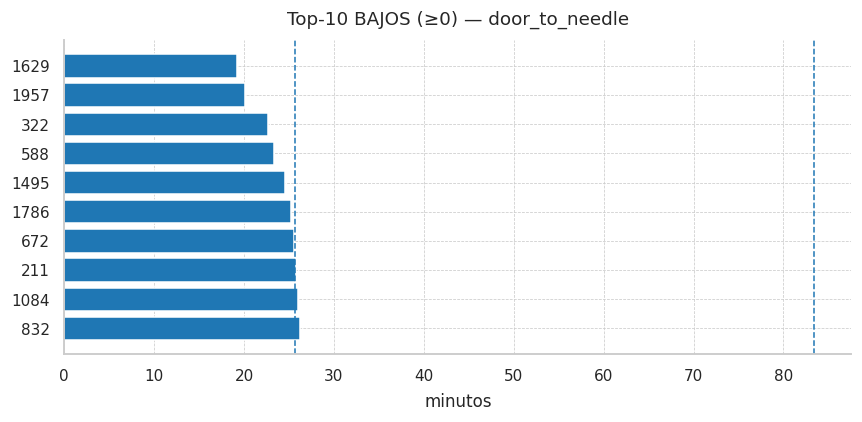

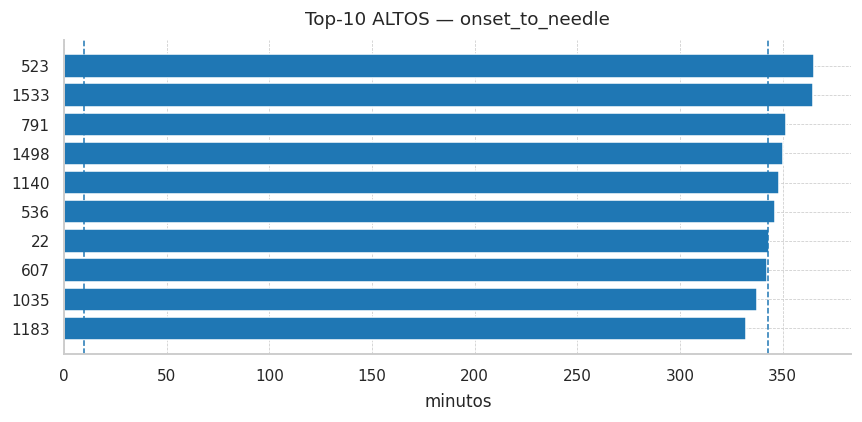

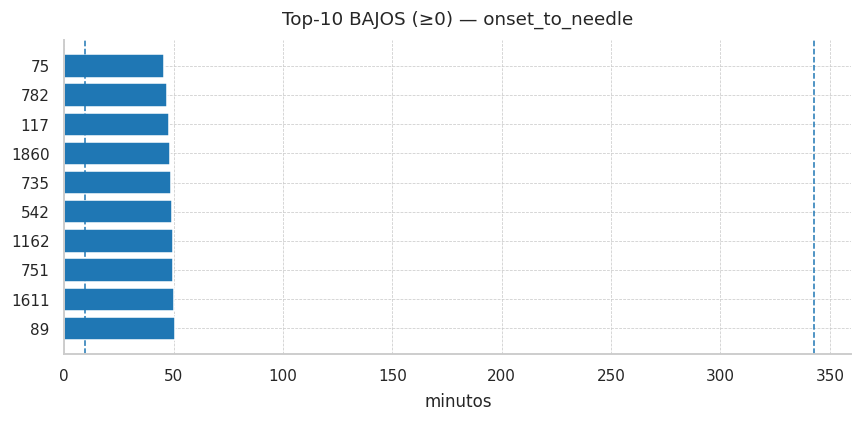

In [176]:
# === Casos extremos (Top-k) por tiempo crítico — EDA puro ===

# 1) Resolver columnas de tiempo a usar (según lo ya definido en el notebook)
if "time_cols_present" in locals() and len(time_cols_present) > 0:
    _time_cols = list(time_cols_present)
elif "out_time_cols" in locals() and len(out_time_cols) > 0:
    _time_cols = list(out_time_cols)
elif "existing_time_cols" in locals() and len(existing_time_cols) > 0:
    _time_cols = list(existing_time_cols)
else:
    _time_cols = [c for c in [
        "door_to_triage","door_to_imaging","door_to_neuro",
        "imaging_to_decision","decision_to_needle","door_to_needle",
        "onset_to_needle"
    ] if c in df.columns]

if not _time_cols:
    print(" No se encontraron columnas de tiempos para listar Top-k.")
else:
    # 2) Helper: devuelve Top-k altos y bajos (≥0) para una columna, sin modificar df
    def top_extremos_local(df_in: pd.DataFrame, col: str, k: int = 10):
        s = pd.to_numeric(df_in[col], errors="coerce")
        mask_valid = s.notna()
        if not mask_valid.any():
            return pd.DataFrame(), pd.DataFrame()

        base_idx = df_in.index[mask_valid]
        vals = s.loc[base_idx]

        # columnas descriptivas si existen (no crear nada nuevo)
        id_candidates = [c for c in ["patient_id","id","case_id"] if c in df_in.columns]
        context_cols = [c for c in ["arrival_hour","is_weekend","flag_dtn_ok","delay_gt_60"] if c in df_in.columns]
        show_cols = id_candidates + context_cols

        # construir tablas con índice original para auditoría
        altos_idx = vals.sort_values(ascending=False).head(k).index
        bajos_idx = vals[vals >= 0].sort_values(ascending=True).head(k).index  # bajos solo ≥0

        def build_table(idxs):
            if len(idxs) == 0:
                return pd.DataFrame()
            tbl = pd.DataFrame({col: vals.loc[idxs].round(2)})
            # agregar contexto si existe
            for c in show_cols:
                tbl[c] = df_in.loc[idxs, c]
            # dejar el índice como columna explícita para auditoría
            tbl = tbl.reset_index().rename(columns={"index": "idx"})
            # ordenar columnas: idx, ids, valor del tiempo, contexto
            ordered = ["idx"] + id_candidates + [col] + [c for c in context_cols if c in tbl.columns]
            tbl = tbl[[c for c in ordered if c in tbl.columns]]
            return tbl

        return build_table(altos_idx), build_table(bajos_idx)

    # 3) Mostrar Top-k por cada tiempo
    K = 10
    for col in _time_cols:
        top_hi, top_lo = top_extremos_local(df, col, k=K)

        if not top_hi.empty:
            print(f"\nTop {K} valores ALTOS en {col}")
            try:
                display(top_hi)
            except NameError:
                print(top_hi.to_string(index=False))
        else:
            print(f"\n(Sin valores ALTOS válidos para {col})")

        if not top_lo.empty:
            print(f"\nTop {K} valores BAJOS (≥0) en {col}")
            try:
                display(top_lo)
            except NameError:
                print(top_lo.to_string(index=False))
        else:
            print(f"(Sin valores BAJOS ≥0 válidos para {col})")

  # === Visualización de casos extremos (Top-k) por tiempo crítico — EDA puro ===
# Requiere que _time_cols y la función top_extremos_local(...) ya estén definidos (del bloque anterior).
# Si existe robust_tbl con lo_fence/hi_fence, trazará líneas guía.

def _plot_top_bars(vals: pd.Series, title: str, xlabel: str = "minutos", fence_lo=None, fence_hi=None):
    if vals.empty:
        return
    ylabels = [str(i) for i in vals.index]  # índices originales para auditoría
    plt.figure(figsize=(8, max(3, 0.4*len(vals))))
    plt.barh(range(len(vals)), vals.values)
    plt.yticks(range(len(vals)), ylabels)
    plt.gca().invert_yaxis()  # el mayor arriba si viene ordenado desc
    plt.title(title)
    plt.xlabel(xlabel)
    if fence_lo is not None:
        plt.axvline(fence_lo, linestyle="--", linewidth=1)
    if fence_hi is not None:
        plt.axvline(fence_hi, linestyle="--", linewidth=1)
    plt.tight_layout()
    plt.show()

def _get_fences_if_available(col):
    fence_lo = fence_hi = None
    try:
        if 'robust_tbl' in globals() and col in robust_tbl.index:
            lo = robust_tbl.loc[col].get("lo_fence", np.nan)
            hi = robust_tbl.loc[col].get("hi_fence", np.nan)
            fence_lo = float(lo) if np.isfinite(lo) else None
            fence_hi = float(hi) if np.isfinite(hi) else None
    except Exception:
        fence_lo = fence_hi = None
    return fence_lo, fence_hi

K = 10  # Top-k
if not _time_cols:
    print("No hay columnas de tiempo para graficar Top-k.")
else:
    for col in _time_cols:
        # Reutiliza el helper del bloque anterior (no muta df)
        top_hi, top_lo = top_extremos_local(df, col, k=K)
        fence_lo, fence_hi = _get_fences_if_available(col)

        # Gráfico Top-k ALTOS (ordenado desc por valor)
        if not top_hi.empty:
            s_vals = top_hi.set_index("idx")[col].sort_values(ascending=False)
            _plot_top_bars(s_vals, title=f"Top-{K} ALTOS — {col}", fence_lo=fence_lo, fence_hi=fence_hi)
        else:
            print(f"(Sin Top-{K} ALTOS válidos en {col})")

        # Gráfico Top-k BAJOS (≥0; ordenado asc por valor)
        if not top_lo.empty:
            s_vals = top_lo.set_index("idx")[col].sort_values(ascending=True)
            _plot_top_bars(s_vals, title=f"Top-{K} BAJOS (≥0) — {col}", fence_lo=fence_lo, fence_hi=fence_hi)
        else:
            print(f"(Sin Top-{K} BAJOS ≥0 válidos en {col})")



### Resultados del EDA — Hallazgos clave

El análisis exploratorio (EDA) del conjunto **`synthetic_stroke_candidates_v2`** (**N=2000, 24 variables**) mostró los siguientes patrones:

- **Distribuciones asimétricas (colas derechas):** los tiempos críticos presentan asimetría positiva.
  - `door_to_imaging` (DTI): **p25/mediana/p75 = 18,83 / 23,53 / 28,48**
  - `door_to_needle` (DTN): **47,29 / 54,21 / 61,73**
  - Subintervalos con patrón similar:
    - `imaging_to_decision`: **13,44 / 17,89 / 22,35**
    - `decision_to_needle`: **10,29 / 12,86 / 15,31**

- **Outliers operativos:** percentiles altos (p90–p95) elevan la cola, compatibles con **picos de congestión** y demoras logísticas. Se priorizarán **métricas robustas** (mediana/IQR) y, si procede, **winsorización 1%–1%**/**transformación `log1p`** en **variables no temporales**.

- **Variación intra–día:** recomendable estratificar por **hora de llegada (`arrival_hour` derivada de `arrival_datetime`)** y **jornada** (`is_weekend`), para detectar desplazamientos de medianas/colas. (Si hubiese un proxy de **crowding**, incluirlo.)

- **Valores faltantes (manejables):** **promedio ≈ 2,5%** por columna; **máximo 11,4%** en `onset_to_needle`. En tiempos clave, faltantes **moderados** (~**4–5%** en `door_to_imaging` y `decision_to_needle`). Estrategia: **mediana/moda** dentro del pipeline, sin alterar los tiempos “congelados”.

- **Desbalance moderado del target:** `delay_gt_60` (**DTN > 60**) = **29,9%** positivos vs **70,1%** a tiempo. Implica usar **`class_weight='balanced'`**, revisar **PR-AUC**, y ajustar **umbrales** priorizando **recall** con **tasa de alertas** controlada.

- **Flags de cumplimiento (`flag_*`):** útiles para **auditoría/QA**. En este dataset no vienen nativas; se **derivarán en Preprocesamiento (4.d)**. Como referencia, **`flag_dtn_ok` ≈ 70%** (coherente con el balance de clase).

> **Síntesis.** El EDA apoya un preprocesamiento **robusto y reproducible** con: (i) **no escalar/winsorizar** tiempos “congelados”; (ii) imputación simple (mediana/moda); (iii) **ponderación de clases** y **umbral operativo** orientado a minimizar **falsos negativos** sin saturar el sistema de alertas.


## 4.c — Preprocesamiento (Setup y contexto)

**Propósito.**  
Dejar el dataset **limpio, tipificado y enriquecido** para el modelado, asegurando:
- **Reproducibilidad** (semilla fija, pasos versionados).
- **No fuga de información** (todas las transformaciones aprenden **solo** en TRAIN).
- **Trazabilidad** (registro “antes→después” por operación).

---

### Contexto previo (desde el EDA)
- Distribuciones **asimétricas con colas derechas** (DTI/DTN y sub-intervalos).  
- **Outliers operativos** plausibles (p90–p95 altos).  
- **Faltantes** bajos–moderados (prom. ≈2,5%; máx. 11,4% en `onset_to_needle`).  
- **Desbalance moderado** del target (`delay_gt_60` ≈ 29,9%).

**Implicación.** Preprocesar sin distorsionar tiempos críticos y preparar features estables para entrenar con **clase ponderada** y umbral ajustable.

---

### Lineamientos generales

1) **Estandarización de tipos y alias**  
- Parsear **timestamps**: `arrival_datetime`, `t_triage`, `t_imaging`, `t_neuro`, `t_decision`, `t_needle`.  
- Asegurar **minutos (float)** en: `door_to_triage`, `door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_neuro`, `door_to_needle`, `onset_to_needle`.  
- Mapear alias → nombres canónicos (guardar en `alias_map.json`).

2) **Congelado de tiempos críticos**  
- **No escalar ni winsorizar** `door_*` ni `*_to_*`.  
- Solo limpieza mínima: valores **negativos → NaN** (si aparecieran por errores de parseo).

3) **Imputación (solo features no congeladas)**  
- Numéricas: **mediana** (fit en TRAIN, apply en VAL/TEST).  
- Binarias/categóricas: **moda**.  
- Registrar parámetros en `imputation_params.json`.  
- **No imputar** la **variable objetivo** ni métricas operativas evaluadas como targets auxiliares.

4) **Outliers (no temporales)**  
- Política por defecto: **sin winsorización**; si >5% outliers en una **no temporal**, considerar **winsor 1%–1%** o **log1p** (documentar en `preproc_log.json`).  
- Nunca aplicar transformaciones que cambien la semántica de los **tiempos**.

5) **Codificación/escala (dentro del Pipeline)**  
- Numéricas no temporales: `StandardScaler` (o `RobustScaler` si hay colas marcadas).  
- Categóricas (si las hubiese): One-Hot o Target-encoding **solo en TRAIN** (con validación contra fuga).

6) **Flags de cumplimiento (`flag_*`)**  
- Construir **en esta etapa** desde tiempos:  
  - `flag_door_to_imaging_ok = (DTI ≤ 25)`  
  - `flag_imaging_to_decision_ok = (I→D ≤ 30)`  
  - `flag_decision_to_needle_ok = (D→N ≤ 15)`  
  - `flag_door_to_needle_ok = (DTN ≤ 60)`  
- Uso: **QA/operación** y reportes.  
- **No** utilizar como *features* si el target es derivado del mismo tiempo (evitar fuga).

7) **Partición y control de aleatoriedad**  
- `RANDOM_SEED = 42`, `random_state=42` en todos los pasos.  
- `train_test_split` estratificado por `delay_gt_60`.  
- Todo *fit* (imputación, codificación, escalado, calibración) **exclusivo de TRAIN**.

8) **Persistencia y trazabilidad**  
- Guardar `df_before` (snapshot).  
- Registrar cambios en `preproc_log.json` (conteos de NaN antes/después, columnas afectadas, parámetros).  
- Exportar `feature_names.json` y versión del pipeline.

---

### Enfoque metodológico (esqueleto de pipeline)
- **ColumnTransformer** (imputación + escalado en no temporales, *passthrough* para tiempos).  
- **Estimator** con `class_weight='balanced'` (p. ej., `HistGradientBoostingClassifier` o equivalente).  
- **Calibración opcional** (Platt/Isotónica) **solo con folds de TRAIN**.  
- **Selección de umbral operativo** en VALIDACIÓN, priorizando **Recall** con **tasa de alertas** controlada.



In [177]:
# 4.c.0 — Setup (semilla, metas y respaldo)
assert 'df' in globals(), "df no está definido. Carga el dataset antes de 4.c."

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Metas temporales (minutos) para auditoría y derivaciones clínicas
time_goals_min = {
    "door_to_imaging": 25,
    "door_to_neuro": 15,
    "imaging_to_decision": 20,
    "decision_to_needle": 10,
    "door_to_needle": 60,
    "onset_to_needle": 270,
}

# Copia base del dataset previo al preprocesamiento (trazabilidad)
df_before = df.copy()

print("Setup 4.c listo. Forma:", df.shape)


Setup 4.c listo. Forma: (2000, 24)


## 4.c.0 — Preprocesamiento de tiempos críticos (MINUTOS)

### Objetivo
Homogeneizar las columnas de **tiempo del proceso agudo** (DTI, DTN y sub-intervalos) cuando vienen en **formatos/Unidades heterogéneas** —p. ej. `"1h 20m"`, `"01:30"`, `"120s"`, `"90 min"`, `"0.8 h"`— y asegurar su **coherencia clínica** antes del modelado.

Esta etapa:
- Establece **alias canónicos** (`door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_needle`, etc.).
- Convierte **todas las unidades a minutos (float)** mediante un **parser robusto**.
- Aplica **límites plausibles** (*cap* suave) **0–720 min**.
- Revisa **coherencia simple** (p. ej., `DTN ≥ DTI + I→D + D→N`) y **registra** inconsistencias.
- **“Congela”** las columnas de tiempo para evitar **escalado/transformaciones** posteriores.

---

### 4.c.1 — Alias canónicos
Se detectan nombres alternativos (ES/EN) y se mapean a un conjunto estándar:

- **Timestamps:** `arrival_datetime` (`t_arrival`, `arrival_ts`), `t_imaging`, `t_decision`, `t_needle`, `t_triage`, `t_neuro`.
- **Intervalos en minutos:**  
  - `door_to_imaging` (DTI): `door_to_imaging_min`, `d_imaging_arrival`, `DTI`, `dti_min`.  
  - `imaging_to_decision` (I→D).  
  - `decision_to_needle` (D→N).  
  - `door_to_needle` (DTN): `door_to_needle_min`, `dtn_min`, `dtn_minutes`, `DTN`.  
  - Otros disponibles: `door_to_triage`, `door_to_neuro`, `onset_to_needle`.

> *Rastreo:* se mantiene un **mapa de alias** para trazabilidad.

---

### 4.c.2 — Parser de unidades → MINUTOS
Conversión flexible que soporta:
- **`hh:mm`** y **`mm:ss`** → minutos totales.  
- **Horas:** `X h/hr/hrs/hour(s)` → `X * 60`.  
- **Minutos:** `X m/min/minute(s)/minutos` → `X`.  
- **Segundos:** `X s/sec/seg/second(s)` → `X / 60`.  
- **Mixtos:** `Xh Ym`, `Xm Ys`.  
- **Numéricos sueltos:** `45`, `120` → **minutos**.

**Saneos inmediatos:**
- **Negativos → `NaN`**.  
- **Cap 12 h (720 min)** para descartar outliers imposibles sin perder variabilidad operacional.

---

### 4.c.3 — Chequeo de coherencia
Validación **aditiva** entre intervalos clave:
- Si hay datos suficientes y se detecta **`DTN < DTI + I→D + D→N`**, se registra en un **log de inconsistencias**.  
- Política por defecto: **no se corrige automáticamente**; se deja constancia para auditoría y revisión clínica (opción de corrección controlada en el cuaderno).

> *Motivo:* preservar **trazabilidad clínica** y evitar “fabricar” tiempos. Las correcciones (si se aplican) quedan documentadas.

---

### 4.c.4 — Resumen y “congelado”
- Se emite un **resumen estadístico** (`n`, `min`, `p25`, `p50`, `p75`, `max`) de todos los **tiempos críticos** en **minutos**.  
- Se define la lista **`FROZEN_TIME_COLS`** con las columnas temporales **protegidas** (sin **escalado, winsorización ni transformaciones** posteriores).  
- Estas columnas pasan como **`passthrough`** en el `ColumnTransformer` del pipeline.




In [178]:
# =========================================================
# 4.c — Preprocesamiento de tiempos críticos (MINUTOS + alias canónicos)
#  - Parser robusto → minutos
#  - Alias → columnas canónicas
#  - Reconstrucción DTN si falta (desde timestamps)
#  - Coherencia con suma de tramos (opcionalmente corrige)
#  - Congelado de columnas de tiempo (no escalar/winsorizar)
# =========================================================
import re, numpy as np, pandas as pd

assert 'df' in globals(), "No encuentro df. Carga el dataset antes de ejecutar esta celda."

# ---------- Parser robusto → MINUTOS ----------
def _norm_decimal(s: str) -> str:
    return s.replace(",", ".")

def to_minutes(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        v = float(x); return np.nan if not np.isfinite(v) else v
    s = _norm_decimal(str(x).strip().lower())
    if s == "": return np.nan

    # hh:mm(:ss)
    if re.fullmatch(r"\d{1,2}:\d{2}(:\d{2})?", s):
        parts = [float(p) for p in s.split(":")]
        if len(parts) == 2:
            hh, mm = parts;  return hh*60 + mm
        hh, mm, ss = parts; return hh*60 + mm + ss/60.0

    # mm:ss
    if re.fullmatch(r"\d{1,3}:\d{2}", s):
        mm, ss = [float(p) for p in s.split(":")]
        return mm + ss/60.0

    # 1h 20m / 1h20m / 1 hr / 1.5 hours
    m = re.fullmatch(r"(?P<h>\d+(?:\.\d+)?)\s*h(?:r|rs|our|ours)?(?:\s*(?P<m>\d+(?:\.\d+)?)\s*m(?:in(?:ute)?s?)?)?", s)
    if m:
        h = float(m.group("h")); m_part = float(m.group("m")) if m.group("m") else 0.0
        return h*60 + m_part

    # Xm Ys
    m = re.fullmatch(r"(?P<m>\d+(?:\.\d+)?)\s*m(?:in(?:ute)?s?)?\s*(?P<s>\d+(?:\.\d+)?)\s*s(?:ec(?:ond)?s?)?", s)
    if m:
        return float(m.group("m")) + float(m.group("s"))/60.0

    # Solo horas
    m = re.fullmatch(r"(?P<h>\d+(?:\.\d+)?)\s*(h|hr|hrs|hour|hours)", s)
    if m:
        return float(m.group("h"))*60.0

    # Solo minutos (número crudo)
    m = re.fullmatch(r"(?P<m>\d+(?:\.\d+)?)\s*(m|min|mins|minute|minutes|minutos)?", s)
    if m:
        return float(m.group("m"))

    # Solo segundos
    m = re.fullmatch(r"(?P<s>\d+(?:\.\d+)?)\s*(s|sec|secs|second|seconds|seg|segundos)", s)
    if m:
        return float(m.group("s"))/60.0

    try:
        val = float(re.sub(r"[^\d\.\-]", "", s))
        return val if np.isfinite(val) else np.nan
    except Exception:
        return np.nan

def coerce_minutes_series(ser: pd.Series) -> pd.Series:
    out = ser.apply(to_minutes).astype(float)
    out = out.mask(out < 0, np.nan).clip(lower=0, upper=720)  # 12 h cap
    return out

# ---------- Alias ----------
ALIAS_DT = {
    "arrival_datetime": ["arrival_datetime","t_arrival","arrival_ts","arrival_time","arrival_dt"],
    "t_imaging":        ["t_imaging","imaging_time","imaging_ts","ct_ts","t_ct"],
    "t_decision":       ["t_decision","decision_time","decision_ts"],
    "t_needle":         ["t_needle","needle_time","needle_ts","t_bolus"],
    "t_triage":         ["t_triage","triage_time","triage_ts"],
    "t_neuro":          ["t_neuro","neuro_time","neuro_ts","t_neuro_eval"],
}

ALIAS_MIN = {
    # Tramos
    "door_to_imaging":     ["door_to_imaging","door_to_imaging_min","d_imaging_arrival","DTI","dti_min","door_to_ct","d_to_ct"],
    "imaging_to_decision": ["imaging_to_decision","imaging_to_decision_min","i_to_decision_min"],
    "decision_to_needle":  ["decision_to_needle","decision_to_needle_min","d_to_needle_min","decision_to_bolus"],
    "door_to_triage":      ["door_to_triage","door_to_triage_min","d_triage_arrival","door_to_first_assessment"],
    "door_to_neuro":       ["door_to_neuro","door_to_neuro_min","d_neuro_arrival","door_to_neurology"],
    "onset_to_needle":     ["onset_to_needle","onset_to_needle_min","OTN_min","lkw_to_needle","d_needle_lkw"],
    # DTN (tendremos canónico d_needle_arrival)
    "d_needle_arrival":    ["d_needle_arrival","door_to_needle","door_to_needle_min","DTN","DTN_min","dtn_minutes","dtn_min"],
}

def _resolve(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

alias_log = []

# Datetimes
for canon, cands in ALIAS_DT.items():
    if canon not in df.columns:
        src = _resolve(df, cands)
        if src is not None:
            df[canon] = pd.to_datetime(df[src], errors="coerce")
            alias_log.append((canon, src, "datetime"))

# Intervalos crudos (se parsean a minutos más abajo)
for canon, cands in ALIAS_MIN.items():
    if canon not in df.columns:
        src = _resolve(df, cands)
        if src is not None:
            df[canon] = df[src]
            alias_log.append((canon, src, "to_minutes_pending"))

if alias_log:
    rep = pd.DataFrame(alias_log, columns=["canon","origen","conversión"])
    print("4.c — Alias canónicos creados:")
    try: display(rep)
    except: print(rep.to_string(index=False))
else:
    print("4.c — No se detectaron alias nuevos.")

# ---------- Forzar a MINUTOS ----------
TIME_COLS = [
    "door_to_imaging","imaging_to_decision","decision_to_needle",
    "door_to_triage","door_to_neuro","onset_to_needle",
    "d_needle_arrival"  # ← DTN CANÓNICO
]
present = [c for c in TIME_COLS if c in df.columns]

for c in present:
    df[c] = coerce_minutes_series(pd.to_numeric(df[c], errors="ignore"))

# Si aún no tenemos DTN en minutos, intentamos reconstruirlo desde timestamps
if "d_needle_arrival" not in df.columns or df["d_needle_arrival"].isna().all():
    if {"arrival_datetime","t_needle"} <= set(df.columns):
        dtn_from_ts = (pd.to_datetime(df["t_needle"], errors="coerce") -
                       pd.to_datetime(df["arrival_datetime"], errors="coerce")).dt.total_seconds()/60.0
        df["d_needle_arrival"] = pd.to_numeric(dtn_from_ts, errors="coerce")
        df["d_needle_arrival"] = df["d_needle_arrival"].mask(df["d_needle_arrival"] < 0, np.nan).clip(0, 720)

# Espejo para compatibilidad con celdas antiguas
df["door_to_needle"] = df["d_needle_arrival"]

# ---------- Coherencia: DTN vs suma de tramos ----------
log_incons = {}
needed = ["door_to_imaging","imaging_to_decision","decision_to_needle","d_needle_arrival"]
if all(c in df.columns for c in needed):
    s_img = pd.to_numeric(df["door_to_imaging"], errors="coerce")
    s_i2d = pd.to_numeric(df["imaging_to_decision"], errors="coerce")
    s_d2n = pd.to_numeric(df["decision_to_needle"], errors="coerce")
    s_dtn = pd.to_numeric(df["d_needle_arrival"], errors="coerce")

    mask = s_img.notna() & s_i2d.notna() & s_d2n.notna() & s_dtn.notna()
    suma = (s_img + s_i2d + s_d2n).where(mask)
    discrep = mask & (s_dtn + 1e-9 < suma)  # DTN menor que la suma de tramos

    n_disc = int(discrep.sum())
    if n_disc > 0:
        log_incons["dtn_less_than_sum"] = n_disc
        # Política: corregir DTN al mínimo consistente (suma) SOLO en las discrepancias
        CORREGIR_DTN_CON_SUMA = True
        df["dtn_consistent"] = s_dtn.copy()
        df.loc[discrep, "dtn_consistent"] = suma.loc[discrep]
        df["dtn_consistent"] = df["dtn_consistent"].clip(0, 720)
        if CORREGIR_DTN_CON_SUMA:
            df["d_needle_arrival"] = df["dtn_consistent"]
            df["door_to_needle"]   = df["dtn_consistent"]

# ---------- Resumen + congelado ----------
present = [c for c in TIME_COLS if c in df.columns]
summary_cols = present + ([ "dtn_consistent"] if "dtn_consistent" in df.columns else [])
if summary_cols:
    desc = df[summary_cols].describe(percentiles=[.25,.5,.75,.9,.95]).T.round(2)
    print("\nResumen de tiempos (min) — columnas congeladas:")
    try: display(desc)
    except: print(desc.to_string())

FROZEN_TIME_COLS = summary_cols.copy()
DTN_CANON = "d_needle_arrival"  # ← para que aguas abajo sepan a quién mirar
print("\nFROZEN_TIME_COLS:", FROZEN_TIME_COLS if FROZEN_TIME_COLS else "—")
if log_incons:
    print("Inconsistencias detectadas:", log_incons)


4.c — Alias canónicos creados:


canon          origen          conversión
0  d_needle_arrival  door_to_needle  to_minutes_pending


Resumen de tiempos (min) — columnas congeladas:


count    mean    std    min     25%     50%     75%     90%     95%     max
door_to_imaging      1909.0   23.73   7.23   5.00   18.83   23.53   28.48   33.27   35.83   54.23
imaging_to_decision  1833.0   17.98   6.45   3.00   13.44   17.89   22.35   26.26   28.65   41.27
decision_to_needle   1900.0   12.76   3.80   2.00   10.29   12.86   15.31   17.62   18.93   25.20
door_to_triage       1935.0    8.54   2.98   0.33    6.49    8.45   10.59   12.50   13.63   17.83
door_to_neuro        1910.0   14.99   4.55   3.00   11.94   14.86   17.75   21.06   22.73   32.43
onset_to_needle      1772.0  177.43  60.20  45.58  134.44  177.49  217.75  256.97  278.19  365.30
d_needle_arrival     2000.0   54.56  10.96  19.17   47.29   54.21   61.73   68.70   73.02   93.74


FROZEN_TIME_COLS: ['door_to_imaging', 'imaging_to_decision', 'decision_to_needle', 'door_to_triage', 'door_to_neuro', 'onset_to_needle', 'd_needle_arrival']


In [179]:
# Auditoría rápida post 4.c.3
s_dtn = pd.to_numeric(df.get("door_to_needle"), errors="coerce")
s_dti = pd.to_numeric(df.get("door_to_imaging"), errors="coerce")
s_itd = pd.to_numeric(df.get("imaging_to_decision"), errors="coerce")
s_d2n = pd.to_numeric(df.get("decision_to_needle"), errors="coerce")

ok_sum = (s_dti.notna() & s_itd.notna() & s_d2n.notna() & s_dtn.notna())
viol_sum = int((ok_sum & (s_dtn + 2 < (s_dti + s_itd + s_d2n))).sum())
viol_seg = {seg:int(((s_dtn.notna() & pd.to_numeric(df[seg], errors="coerce").notna())
                     & (s_dtn + 1e-9 < pd.to_numeric(df[seg], errors="coerce"))).sum())
            for seg in ["door_to_imaging","imaging_to_decision","decision_to_needle"] if seg in df.columns}
print(f"[Audit] Filas aún incoherentes (DTN << suma): {viol_sum}")
print(f"[Audit] DTN < cada tramo (conteo por tramo): {viol_seg}")


[Audit] Filas aún incoherentes (DTN << suma): 0
[Audit] DTN < cada tramo (conteo por tramo): {'door_to_imaging': 0, 'imaging_to_decision': 0, 'decision_to_needle': 0}


## 4.c.5 — Limpieza operativa (negativos y *capping* opcional)

### Objetivo
Depurar el dataset eliminando valores imposibles y registrando todas las correcciones aplicadas, sin alterar las variables clínicas ni los tiempos críticos previamente **congelados**.

---

### Política base
- **Valores negativos → `NaN`**, exclusivamente en columnas numéricas.  
- **Winsorización opcional** (*capping*) solo en *features no temporales* y únicamente si >5 % de los valores se clasifican como *outliers* según el criterio de **Tukey (1.5·IQR)**.  
- **Columnas protegidas:** `TIME_COLS` + `d_needle_arrival` → nunca se winsorizan, escalan ni imputan.

---

### Implementación
1. Se genera un **log (`clean_log`)** con:
   - Conteo de valores negativos corregidos.  
   - Cambios en el número de valores válidos (*delta válidos* antes/después).  
   - Límites aplicados en caso de winsorización (`lower_cap`, `upper_cap`).  
2. El DataFrame resultante (`df`) se conserva limpio y coherente, y se crea una tabla resumen `clean_df` para auditoría.

---

### Trazabilidad
- **`df_before`** → snapshot previo al proceso (referencia).  
- **`clean_df`** → tabla resumen de la limpieza aplicada.  
- **`APPLY_WINSOR`** → variable booleana que controla si se aplica *winsorización* (por defecto `False`).

---

### Resultado
Se obtiene un dataset libre de valores imposibles y con integridad clínica conservada.  
El log de limpieza (`clean_log`) documenta cada corrección, garantizando **reproducibilidad y trazabilidad** en la preparación de datos.


In [180]:
# =========================================================
# 4.c.5 — Limpieza operativa (negativos → NaN y winsor opcional con trazabilidad)
# Propósito:
# - Eliminar valores imposibles en features no temporales.
# - NO alterar tiempos críticos "congelados" ni variables clínicas.
# - Registrar todo en un log reproducible.
# =========================================================

assert 'df' in globals(), "Falta df. Carga el dataset antes de 4.c.5."

# 0) Snapshots para trazabilidad
#    a) Snapshot global previo (para auditoría general entre celdas, si lo quieres mantener)
if "df_before" not in globals():
    df_before = df.copy(deep=True)
#    b) Snapshot LOCAL de esta celda para validar que 4.c.5 no toca tiempos
df_pre_4c5 = df.copy(deep=True)

# 1) Conjuntos protegidos
protected_times = set()
if 'FROZEN_TIME_COLS' in globals() and isinstance(FROZEN_TIME_COLS, (list, tuple)):
    protected_times = set([c for c in FROZEN_TIME_COLS if c in df.columns])
else:
    base_times = [c for c in (globals().get("TIME_COLS", []) or []) if c in df.columns]
    if "d_needle_arrival" in df.columns:
        base_times = list(dict.fromkeys(list(base_times) + ["d_needle_arrival"]))
    protected_times = set(base_times)

protected_clin = set([c for c in [
    "age","sbp","dbp","glucose_mgdl","nihss_on_arrival","mrs_pre"
] if c in df.columns])

flag_cols = set([c for c in df.columns if str(c).startswith("flag_")])
ts_cols   = set([c for c in df.columns if str(c).startswith("t_")])

# Jamás winsorizar nada de esto:
protected_for_winsor = protected_times | protected_clin | flag_cols | ts_cols

# 2) Negativos → NaN SOLO en numéricas NO temporales NI clínicas NI flags/timestamps
clean_log = []
num_cols_all = df.select_dtypes(include=["number"]).columns.tolist()

# Protegidos para negativos (igual política que winsor)
protected_for_negatives = (protected_times | protected_clin | flag_cols | ts_cols)

for col in num_cols_all:
    s = pd.to_numeric(df[col], errors="coerce")
    n_before = int(s.notna().sum())
    n_neg    = int((s < 0).sum())

    if col in protected_for_negatives:
        # No tocar: tiempos congelados, clínicas, flags y timestamps
        n_after = n_before
        clean_log.append({
            "col": col,
            "action": "no_change_protected",
            "negatives_detected": n_neg,
            "n_valid_before": n_before,
            "n_valid_after": n_after,
            "delta_valid": n_after - n_before
        })
        continue

    if n_neg > 0:
        df.loc[s < 0, col] = np.nan
        s = pd.to_numeric(df[col], errors="coerce")

    n_after = int(s.notna().sum())
    clean_log.append({
        "col": col,
        "action": "negatives_to_NA" if n_neg > 0 else "no_negatives",
        "negatives_detected": n_neg,
        "n_valid_before": n_before,
        "n_valid_after": n_after,
        "delta_valid": n_after - n_before
    })

# 3) Winsorización opcional
APPLY_WINSOR = False
P_LOW, P_HIGH = 0.01, 0.99
IQR_OUTLIER_THRESHOLD = 0.05

def _is_binary01(series: pd.Series) -> bool:
    vals = pd.to_numeric(series, errors="coerce").dropna().unique()
    return set(vals).issubset({0, 1})

def _winsorize_series(s: pd.Series, p_low=0.01, p_high=0.99):
    lo, hi = float(s.quantile(p_low)), float(s.quantile(p_high))
    return s.clip(lower=lo, upper=hi), lo, hi

if APPLY_WINSOR:
    for col in num_cols_all:
        if col in protected_for_winsor:
            continue
        s = pd.to_numeric(df[col], errors="coerce")
        if s.notna().sum() <= 30 or _is_binary01(s):
            continue

        q1, q3 = s.quantile([0.25, 0.75])
        iqr = float(q3 - q1) if pd.notna(q1) and pd.notna(q3) else 0.0
        if iqr <= 0:
            continue

        outlier_mask = (s < (q1 - 1.5*iqr)) | (s > (q3 + 1.5*iqr))
        outlier_rate = float(outlier_mask.mean())

        if outlier_rate > IQR_OUTLIER_THRESHOLD:
            s2, lo, hi = _winsorize_series(s, P_LOW, P_HIGH)
            df[col] = s2
            clean_log.append({
                "col": col,
                "action": "winsorized",
                "lo_cap": lo,
                "hi_cap": hi,
                "outlier_%": round(outlier_rate*100, 2)
            })
        else:
            clean_log.append({
                "col": col,
                "action": "no_winsor_low_outliers",
                "outlier_%": round(outlier_rate*100, 2)
            })

# 4) Ensamblar log y salida
clean_df = pd.DataFrame(clean_log)

#  Print resumen ejecutivo
n_total_cols = len(num_cols_all)
# columnas (no celdas) donde se corrigieron negativos → NaN
n_neg_fixed_cols = sum(1 for x in clean_log if x.get("action") == "negatives_to_NA")
n_protected  = len(protected_times)
n_winsor     = sum(1 for x in clean_log if x.get("action") == "winsorized")

print("===============================================")
print(" 4.c.5 — Limpieza operativa completada")
print(f"→ Columnas numéricas evaluadas: {n_total_cols}")
print(f"→ Columnas con negativos corregidos: {n_neg_fixed_cols}")
print(f"→ Columnas de tiempo protegidas: {n_protected}")
print(f"→ Columnas winsorizadas: {n_winsor if APPLY_WINSOR else 0} (APPLY_WINSOR={APPLY_WINSOR})")
print("===============================================")

try:
    display(clean_df.head(20))
except Exception:
    print(clean_df.head(20).to_string(index=False))


 4.c.5 — Limpieza operativa completada
→ Columnas numéricas evaluadas: 17
→ Columnas con negativos corregidos: 0
→ Columnas de tiempo protegidas: 7
→ Columnas winsorizadas: 0 (APPLY_WINSOR=False)


col               action  negatives_detected  n_valid_before  n_valid_after  delta_valid
0     arrival_dayofweek         no_negatives                   0            2000           2000            0
1            is_weekend         no_negatives                   0            2000           2000            0
2                   age  no_change_protected                   0            2000           2000            0
3                female         no_negatives                   0            2000           2000            0
4                 nihss         no_negatives                   0            2000           2000            0
5                  afib         no_negatives                   0            2000           2000            0
6                   htn         no_negatives                   0            2000           2000            0
7                   dm2         no_negatives                   0            2000           2000            0
8        door_to_triage  no_change_protected                   0            1935           1935            0
9       door_to_imaging  no_change_protected                   0            1909           1909            0
10  imaging_to_decision  no_change_protected                   0            1833           1833            0
11   decision_to_needle  no_change_protected                   0            1900           1900            0
12        door_to_neuro  no_change_protected                   0            1910           1910            0
13       door_to_needle         no_negatives                   0            2000           2000            0
14      onset_to_needle  no_change_protected                   0            1772           1772            0
15          delay_gt_60         no_negatives                   0            2000           2000            0
16     d_needle_arrival  no_change_protected                   0            2000           2000            0

## 4.c.6.1 — Diagnóstico de NaN (esperados vs. problemáticos)

**Objetivo.**  
Distinguir los valores `NaN` **esperados** (propios de *timestamps*, *flags* o tiempos clínicos protegidos) de los `NaN` **problemáticos** en *features* imputables que deben resolverse antes del modelado.

---

### Criterios

- **Esperados:**  
  Columnas que comienzan con `t_*`, `flag_*`, las incluidas en `TIME_COLS`, `d_needle_arrival`, y los *targets* legados (p. ej. `delay_gt_60`).  

- **Problemáticos:**  
  Valores `NaN` en columnas numéricas candidatas a *features* que no pertenecen al conjunto protegido.

---

### Salidas esperadas
- Conteo total de `NaN` numéricos.  
- Desglose entre `NaN` esperados y `NaN` a revisar.  
- Tabla de columnas con `NaN` en *features* imputables.

---

## 4.c.7 — Last-mile de imputación (solo numéricas imputables)

**Objetivo.**  
Resolver los `NaN` residuales en variables numéricas imputables utilizando la **mediana actual**, sin alterar *timestamps*, *flags*, tiempos clínicos ni el *target*.

---

### Alcance
- Aplica únicamente a columnas numéricas **no binarias** dentro del conjunto de *features* imputables.  
- Excluye explícitamente:  
  `TIME_COLS`, `d_needle_arrival`, columnas `t_*`, `flag_*`, y *targets* legados.

---

### Salidas esperadas
- Listado de columnas imputadas.  
- Número de `NaN` corregidos por columna.  
- Valor de mediana utilizado para la imputación.


In [181]:
# =========================================================
# 4.c.6.1 — Diagnóstico de NaN (esperados vs. problemáticos)
# - No modifica df. Solo reporta.
# - Requiere: df ya cargado; TIME_COLS o FROZEN_TIME_COLS definidos.
# =========================================================

assert 'df' in globals(), "Falta df. Carga el dataset antes de 4.c.6.1."

# 1) Conjunto protegido (esperados)
if 'FROZEN_TIME_COLS' in globals() and isinstance(FROZEN_TIME_COLS, (list, tuple)):
    protected_times = set([c for c in FROZEN_TIME_COLS if c in df.columns])
else:
    base_times = [c for c in (globals().get("TIME_COLS", []) or []) if c in df.columns]
    if "d_needle_arrival" in df.columns:
        base_times = list(dict.fromkeys(list(base_times) + ["d_needle_arrival"]))
    protected_times = set(base_times)

ts_cols       = sorted([c for c in df.columns if str(c).startswith("t_")])
flag_cols     = sorted([c for c in df.columns if str(c).startswith("flag_")])
legacy_target = [c for c in ("delay_gt_60",) if c in df.columns]

expected_nan_set = set(ts_cols) | set(flag_cols) | set(legacy_target) | protected_times

# 2) NaN numéricos: totales, esperados y a revisar
num_nan = df.select_dtypes(include=[np.number]).isna().sum()
num_nan = num_nan[num_nan > 0].sort_values(ascending=False)

expected_nan = num_nan[num_nan.index.isin(expected_nan_set)]
maybe_issue  = num_nan[~num_nan.index.isin(expected_nan_set)]

# 3) Features imputables = numéricas no binarias fuera del conjunto protegido
def _is_binary01(s: pd.Series) -> bool:
    vals = pd.to_numeric(s, errors="coerce").dropna().unique()
    return set(vals).issubset({0, 1}) and len(vals) <= 2

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
feature_imputable = [
    c for c in num_cols_all
    if (c not in expected_nan_set) and (not _is_binary01(df[c]))
]

problem_table = (
    maybe_issue[maybe_issue.index.isin(feature_imputable)]
    .to_frame("NaN")
    .reset_index()
    .rename(columns={"index": "Columna"})
    .sort_values("NaN", ascending=False)
)

# 4) Salidas
print("=== 4.c.6.1 — Diagnóstico de NaN (numéricos) ===")
print(f"NaN numéricos totales: {int(num_nan.sum())}")
print(f"— Esperados (protegidos): {int(expected_nan.sum())}")
print(f"— En posibles features (revisar): {int(maybe_issue.sum())}")

if not expected_nan.empty:
    print("\nNaN esperados (protegidos):")
    try:
        display(expected_nan.to_frame("NaN"))
    except Exception:
        print(expected_nan.to_string())

if not problem_table.empty:
    print("\nNaN en *features* imputables (a corregir):")
    try:
        display(problem_table.head(30))
    except Exception:
        print(problem_table.head(30).to_string(index=False))
else:
    print("\nSin NaN en *features* imputables.")

# Artefactos para el paso 4.c.7
FEATURES_IMPUTABLES = feature_imputable  # lista
NAN_FEATURES_TABLE  = problem_table      # tabla para referencia


=== 4.c.6.1 — Diagnóstico de NaN (numéricos) ===
NaN numéricos totales: 741
— Esperados (protegidos): 741
— En posibles features (revisar): 0

NaN esperados (protegidos):


NaN
onset_to_needle      228
imaging_to_decision  167
decision_to_needle   100
door_to_imaging       91
door_to_neuro         90
door_to_triage        65


Sin NaN en *features* imputables.


In [182]:
# =========================================================
# 4.c.7 — Last-mile de imputación (numéricas imputables, idempotente + rollback)
# - Imputa con mediana actual (si existe); si TODO es NaN, NO imputa (deja NaN).
# - Nunca toca timestamps (t_*), flags (flag_*), tiempos protegidos ni targets legados.
# - Si por cualquier motivo detecta cambios en tiempos protegidos, hace ROLLBACK local.
# =========================================================

assert 'df' in globals(), "Falta df. Carga el dataset antes de 4.c.7."
assert 'FEATURES_IMPUTABLES' in globals(), "Corre 4.c.6.1 antes (no encuentro FEATURES_IMPUTABLES)."

# --- 0) Definir tiempos protegidos de forma segura ---
if 'FROZEN_TIME_COLS' in globals() and isinstance(FROZEN_TIME_COLS, (list, tuple)):
    protected_times = [c for c in FROZEN_TIME_COLS if c in df.columns]
else:
    base_times = [c for c in (globals().get("TIME_COLS", []) or []) if c in df.columns]
    if "d_needle_arrival" in df.columns:
        base_times += ["d_needle_arrival"]
    protected_times = sorted(set(base_times))

# Blindaje extra (por si algo se coló en FEATURES_IMPUTABLES)
flag_cols     = [c for c in df.columns if str(c).startswith("flag_")]
ts_cols       = [c for c in df.columns if str(c).startswith("t_")]
legacy_target = [c for c in ("delay_gt_60",) if c in df.columns]
protected_all = set(protected_times) | set(flag_cols) | set(ts_cols) | set(legacy_target)

# --- 1) Snapshot SOLO de tiempos protegidos (para rollback local, no de ejecuciones previas) ---
_snap = {c: pd.to_numeric(df[c], errors="coerce").copy() for c in protected_times if c in df.columns}

# --- 2) Lista de columnas imputables efectiva ---
#     (solo numéricas presentes, no binarias, y fuera de TODO el conjunto protegido)
def _is_binary01(s: pd.Series) -> bool:
    vals = pd.to_numeric(s, errors="coerce").dropna().unique()
    return set(vals).issubset({0, 1}) and len(vals) <= 2

features_imputables = []
for c in FEATURES_IMPUTABLES:
    if c not in df.columns or c in protected_all:
        continue
    s = pd.to_numeric(df[c], errors="coerce")
    if _is_binary01(s):
        continue
    features_imputables.append(c)

imputed_rows = []
skipped_all_nan = []

for col in features_imputables:
    s = pd.to_numeric(df[col], errors="coerce")
    n_missing = int(s.isna().sum())
    if n_missing > 0:
        med = s.median(skipna=True)
        if pd.notna(med):
            df[col] = s.fillna(float(med))
            imputed_rows.append({"columna": col, "n_NaN_corregidos": n_missing, "mediana_usada": float(med)})
        else:
            skipped_all_nan.append(col)
            imputed_rows.append({"columna": col, "n_NaN_corregidos": 0, "mediana_usada": np.nan})

impute_report = (
    pd.DataFrame(imputed_rows, columns=["columna","n_NaN_corregidos","mediana_usada"])
      .sort_values("n_NaN_corregidos", ascending=False)
      .reset_index(drop=True)
    if imputed_rows else pd.DataFrame(columns=["columna","n_NaN_corregidos","mediana_usada"])
)

# --- 3) Verificación + ROLLBACK si detecta cambios en tiempos protegidos ---
changed = []
for c in protected_times:
    if c in _snap and c in df.columns:
        after  = pd.to_numeric(df[c], errors="coerce")
        before = _snap[c]
        if not before.fillna(-9_999_999).equals(after.fillna(-9_999_999)):
            df[c] = before  # rollback local
            changed.append(c)

# --- 4) Salidas ---
print("=== 4.c.7 — Imputación completada (idempotente) ===")
n_cols_imputadas = sum(1 for r in imputed_rows if r.get('n_NaN_corregidos', 0) > 0)
print(f"Columnas imputadas: {n_cols_imputadas}")
restantes = int(df[features_imputables].isna().sum().sum()) if features_imputables else 0
print(f"NaN residuales en *features* imputables: {restantes}")

if skipped_all_nan:
    print(f"Columnas con TODO NaN (no imputadas): {sorted(skipped_all_nan)}")

try:
    display(impute_report.head(30))
except Exception:
    print(impute_report.head(30).to_string(index=False))

if changed:
    print(f"  Cambios detectados en tiempos protegidos → ROLLBACK aplicado en: {changed}")
else:
    print("Tiempos protegidos: sin cambios.")

# (Opcional) exportar log
# impute_report.to_csv("impute_report_4c7.csv", index=False)
# print("Log guardado: impute_report_4c7.csv")


=== 4.c.7 — Imputación completada (idempotente) ===
Columnas imputadas: 0
NaN residuales en *features* imputables: 0


Empty DataFrame
Columns: [columna, n_NaN_corregidos, mediana_usada]
Index: []

Tiempos protegidos: sin cambios.


In [183]:
# =========================================================
# 4.c.7 — Post: re-render del reporte + artefactos
# =========================================================
import json
from pathlib import Path

assert 'impute_report' in globals(), "No encuentro impute_report (corre 4.c.7 antes)."

# 1) Re-mostrar el reporte completo (sin truncar columnas ni filas)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", None)

print("=== 4.c.7 — Reporte completo de imputación ===")
try:
    display(impute_report)
except Exception:
    print(impute_report.to_string(index=False))

# 2) Artefactos persistentes (para anexo / reproducción)
out_dir = Path("./artifacts_4c7")
out_dir.mkdir(exist_ok=True)

csv_path  = out_dir / "impute_report_4c7.csv"
json_path = out_dir / "impute_report_4c7.json"

# Asegurar que impute_report existe aunque esté vacío y con columnas estándar
if impute_report is None or impute_report.empty:
    impute_report = pd.DataFrame(columns=["columna", "n_NaN_corregidos", "mediana_usada"])

impute_report.to_csv(csv_path, index=False)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(impute_report.to_dict(orient="records"), f, indent=2, ensure_ascii=False)

# 3) Resumen ejecutivo
total_cols   = impute_report.shape[0]
total_fixed  = int(impute_report["n_NaN_corregidos"].sum()) if total_cols else 0

top5 = (impute_report.sort_values("n_NaN_corregidos", ascending=False)
         .head(5)[["columna","n_NaN_corregidos","mediana_usada"]]
         if total_cols else pd.DataFrame(columns=["columna","n_NaN_corregidos","mediana_usada"]))

print("\n=== Resumen ejecutivo 4.c.7 ===")
print(f"Columnas imputadas: {total_cols}")
print(f"Total de NaN corregidos: {total_fixed}")
print("Top-5 columnas por NaN corregidos:")
try:
    display(top5)
except Exception:
    print(top5.to_string(index=False))

print(f"\nArtefactos guardados en:\n- {csv_path}\n- {json_path}")


=== 4.c.7 — Reporte completo de imputación ===


Empty DataFrame
Columns: [columna, n_NaN_corregidos, mediana_usada]
Index: []


=== Resumen ejecutivo 4.c.7 ===
Columnas imputadas: 0
Total de NaN corregidos: 0
Top-5 columnas por NaN corregidos:


Empty DataFrame
Columns: [columna, n_NaN_corregidos, mediana_usada]
Index: []


Artefactos guardados en:
- artifacts_4c7/impute_report_4c7.csv
- artifacts_4c7/impute_report_4c7.json


## 4.c.8 — Codificación de categóricas (PREPROCESAMIENTO)

**Propósito (pipeline).**  
Definir la **política de codificación** que se aplicará dentro del `ColumnTransformer` del **Pipeline de la Sección 5**, garantizando reproducibilidad y evitando fuga de información.

**Política final (aplicada en el Pipeline):**
- **Binarias** ya en {0,1} → **se conservan** (sin recodificar).
- **Nominales multiclase** → `OneHotEncoder(handle_unknown="ignore", drop=None)`  
  *(si `sklearn ≥ 1.2`, considerar `min_frequency` para categorías raras)*.
- **Ordinales** (con orden clínico/operativo explícito) → `OrdinalEncoder` con **mapa de orden versionado** (`ORDINAL_MAP`).
- **Exclusiones**: no codificar `TIME_COLS`, `d_needle_arrival`, columnas `t_*`, `flag_*`, ni el *target* (`delay_gt_60`); tampoco IDs (`patient_id`).

**Entradas al Pipeline (artefactos de esta sección):**
- `CAT_BIN_COLS` → columnas binarias a **conservar**.
- `CAT_NOMINAL_COLS` → columnas nominales para **OneHotEncoder**.
- `CAT_ORDINAL_COLS` → columnas ordinales para **OrdinalEncoder** (según `ORDINAL_MAP`).
- (Opcional) `ORDINAL_MAP` → diccionario `{col: [orden...]}` documentado en código.

**Chequeos previos (realizados aquí, sin expandir):**
- Verificación de **cardinalidad** y detección de categorías **raras** (sugerir agrupación o `min_frequency`).
- Detección de **binarias en texto** (p. ej., “sí/no”, “M/F”) para normalizar a {0,1} antes del Pipeline si corresponde.
- Confirmación de que no ingresen **IDs** ni columnas protegidas al bloque categórico.

> **Resultado:** listas de columnas (`CAT_BIN_COLS`, `CAT_NOMINAL_COLS`, `CAT_ORDINAL_COLS`) y, si aplica, `ORDINAL_MAP`, que se conectan directamente al `ColumnTransformer` del Pipeline en la Sección 5.


In [184]:
# =========================================================
# 4.c.8 — Codificación de categóricas (política + opción exploratoria)
# PREPROCESAMIENTO (sin expansión por defecto)
# =========================================================

assert 'df' in globals(), "Falta df. Carga el dataset antes de 4.c.8."

# ---------- Configurable ----------
APPLY_ONEHOT       = False   # OHE exploratorio (el definitivo va en Sección 5)
MAX_CARD_OHE       = 40      # umbral de cardinalidad para OHE exploratorio
DROP_FIRST_OHE     = True    # evita colinealidad en OHE exploratorio
MAX_NEW_OHE_COLS   = 400     # corta si OHE crearía >N columnas (protección memoria)
ORDINAL_MAP        = globals().get("ORDINAL_MAP", {})

# ---------- Conjuntos protegidos / excluidos ----------
if 'FROZEN_TIME_COLS' in globals() and isinstance(FROZEN_TIME_COLS, (list, tuple)):
    protected_times = set([c for c in FROZEN_TIME_COLS if c in df.columns])
else:
    base_times = [c for c in (globals().get("TIME_COLS", []) or []) if c in df.columns]
    if "d_needle_arrival" in df.columns:
        base_times = list(dict.fromkeys(list(base_times) + ["d_needle_arrival"]))
    protected_times = set(base_times)

ts_cols   = sorted([c for c in df.columns if str(c).startswith("t_")])
flag_cols = [c for c in df.columns if str(c).startswith("flag_")]
legacy_tg = [c for c in ("delay_gt_60",) if c in df.columns]
id_like   = [c for c in df.columns if isinstance(c, str) and c.lower() in {"patient_id","id","record_id"}]

excluded = set(ts_cols) | set(flag_cols) | set(legacy_tg) | protected_times | set(id_like)
feature_cols_all = [c for c in df.columns if c not in excluded]

# --- Heurística para excluir columnas "datetime-like" aunque sean object ---
import re

def _is_datetime_like_name(colname: str) -> bool:
    return bool(re.search(r"(?:^|_)(date|time|datetime|ts|timestamp)(?:$|_)", str(colname).lower()))

def _is_datetime_like_values(s: pd.Series, thresh: float = 0.80) -> bool:
    if not pd.api.types.is_object_dtype(s):
        return False
    parsed = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    rate = float(parsed.notna().mean())
    return rate >= thresh

datetime_like_cols = []
for c in feature_cols_all:
    try:
        if _is_datetime_like_name(c) or _is_datetime_like_values(df[c]):
            datetime_like_cols.append(c)
    except Exception:
        pass

if datetime_like_cols:
    excluded.update(datetime_like_cols)
    # re-calcular feature_cols_all sin las datetime-like
    feature_cols_all = [c for c in feature_cols_all if c not in set(datetime_like_cols)]
    print(f" Excluidas por ser datetime-like: {datetime_like_cols[:10]}{' ...' if len(datetime_like_cols)>10 else ''}")

# ---------- Detección de tipos ----------
def _is_binary01(series: pd.Series) -> bool:
    vals = pd.to_numeric(series, errors="coerce").dropna().unique()
    return set(vals).issubset({0, 1}) and len(vals) <= 2

def _is_binary_text(series: pd.Series) -> bool:
    if not pd.api.types.is_object_dtype(series):
        return False
    s = series.astype(str).str.strip().str.lower()
    map0 = {"0","no","n","false","f","neg","m","masculino"}
    map1 = {"1","si","sí","s","true","t","pos","fem","femenino"}
    uniq = set(s.dropna().unique())
    return (len(uniq) <= 2) and all((u in map0 or u in map1) for u in uniq)

is_obj = pd.api.types.is_object_dtype
is_cat = lambda d: str(d).startswith("category")
is_bool= pd.api.types.is_bool_dtype

# Candidatas categóricas por tipo (excluye booleanas verdaderas)
cat_cols = [c for c in feature_cols_all if (is_obj(df[c].dtype) or is_cat(df[c].dtype)) and not is_bool(df[c])]

# Binarias: numéricas 0/1, booleanas, y texto binario típico
bin_cols_num   = [c for c in feature_cols_all
                  if (str(df[c].dtype).startswith(("int","Int","uint","bool","float"))) and _is_binary01(df[c])]
bin_cols_bool  = [c for c in feature_cols_all if is_bool(df[c])]
bin_cols_text  = [c for c in cat_cols if _is_binary_text(df[c])]
bin_cols = sorted(set(bin_cols_num) | set(bin_cols_bool) | set(bin_cols_text))

# Ordinales declarados explícitamente
cat_ordinal = [c for c in cat_cols if c in ORDINAL_MAP]

# Nominales = categóricas no binarias ni ordinales
cat_nominal = [c for c in cat_cols if (c not in cat_ordinal) and (c not in bin_cols)]

# ---------- Reporte de política (no modifica datos) ----------
print("=== 4.c.8 — Política de codificación (preprocesamiento) ===")
print(f"Binarias conservadas (0/1/boolean/texto-binario): {len(bin_cols)} → {bin_cols[:10]}{' ...' if len(bin_cols)>10 else ''}")
print(f"Categóricas nominales: {len(cat_nominal)} → {cat_nominal[:10]}{' ...' if len(cat_nominal)>10 else ''}")
print(f"Categóricas ordinales declaradas: {len(cat_ordinal)} → {cat_ordinal[:10]}{' ...' if len(cat_ordinal)>10 else ''}")

if cat_nominal:
    high_card = [c for c in cat_nominal if df[c].nunique(dropna=True) > MAX_CARD_OHE]
    if high_card:
        print(f" Alta cardinalidad (> {MAX_CARD_OHE}) en: {high_card[:10]}{' ...' if len(high_card)>10 else ''} "
              f"(en Sección 5: usar min_frequency≥1%, hashing, o agrupar raras)")

# Resumen de cardinalidades (útil para decidir min_frequency en OHE)
if cat_nominal:
    card_tbl = (pd.DataFrame({
        "col": cat_nominal,
        "cardinalidad": [int(df[c].nunique(dropna=True)) for c in cat_nominal]
    }).sort_values("cardinalidad", ascending=False))
    try:
        display(card_tbl.head(20))
    except Exception:
        print(card_tbl.head(20).to_string(index=False))

# ---------- Opción exploratoria (no recomendada para el set final) ----------
OHE_COLUMNS_CREATED = []
if APPLY_ONEHOT and cat_nominal:
    ohe_candidates = [c for c in cat_nominal if df[c].nunique(dropna=True) <= MAX_CARD_OHE]
    # estimar columnas nuevas antes de expandir
    approx_new = sum(max(int(df[c].nunique(dropna=True)) - (1 if DROP_FIRST_OHE else 0), 0) for c in ohe_candidates)
    if approx_new > MAX_NEW_OHE_COLS:
        print(f" OHE exploratorio cancelado: estimadas ~{approx_new} columnas nuevas (> {MAX_NEW_OHE_COLS}). Ajusta umbrales.")
    elif ohe_candidates:
        df = pd.get_dummies(df, columns=ohe_candidates, drop_first=DROP_FIRST_OHE)
        for c in ohe_candidates:
            OHE_COLUMNS_CREATED += [col for col in df.columns if str(col).startswith(f"{c}_")]
        print(f" One-hot exploratorio aplicado sobre {len(ohe_candidates)} columnas. Nueva forma: {df.shape}")
        skipped = [c for c in cat_nominal if c not in ohe_candidates]
        if skipped:
            print(f" Omitidas por alta cardinalidad: {skipped[:10]}{' ...' if len(skipped)>10 else ''}")
    else:
        print(" No hay nominales elegibles para OHE exploratorio.")
else:
    print(" One-hot NO aplicado aquí. Se codificará dentro del Pipeline (Sección 5).")

# ---------- Artefactos para Sección 5 ----------
CAT_BIN_COLS       = bin_cols            # conservar tal cual
CAT_NOMINAL_COLS   = cat_nominal         # OneHotEncoder(handle_unknown='ignore')
CAT_ORDINAL_COLS   = cat_ordinal         # OrdinalEncoder con ORDINAL_MAP
CAT_EXCLUDED_COLS  = sorted(excluded)    # para el ColumnTransformer (bloques excluidos)
OHE_CREATED_COLS   = OHE_COLUMNS_CREATED # solo si hiciste exploratorio aquí

print("\nResumen 4.c.8 → listo para Sección 5")
print(f"- Binarias 0/1/bool: {len(CAT_BIN_COLS)}")
print(f"- Nominales para OHE (pipeline): {len(CAT_NOMINAL_COLS)}")
print(f"- Ordinales con orden explícito: {len(CAT_ORDINAL_COLS)}")
print(f"- Excluidas (t_*, flags, target, tiempos, IDs): {len(CAT_EXCLUDED_COLS)}")
print(f"- Columnas OHE exploratorias creadas aquí: {len(OHE_CREATED_COLS)}")


 Excluidas por ser datetime-like: ['arrival_datetime', 'arrival_date', 'arrival_time']
=== 4.c.8 — Política de codificación (preprocesamiento) ===
Binarias conservadas (0/1/boolean/texto-binario): 5 → ['afib', 'dm2', 'female', 'htn', 'is_weekend']
Categóricas nominales: 0 → []
Categóricas ordinales declaradas: 0 → []
 One-hot NO aplicado aquí. Se codificará dentro del Pipeline (Sección 5).

Resumen 4.c.8 → listo para Sección 5
- Binarias 0/1/bool: 5
- Nominales para OHE (pipeline): 0
- Ordinales con orden explícito: 0
- Excluidas (t_*, flags, target, tiempos, IDs): 16
- Columnas OHE exploratorias creadas aquí: 0


## 4.c.9 — Etiquetas y *flags* de cumplimiento

**Objetivo.**  
Definir el *target* `delay_gt_60` y generar **flags operativas** según metas (`time_goals_min`) para trazabilidad del desempeño del flujo.

**Reglas base.**  
- **`flag_dti_ok`** := `door_to_imaging ≤ 25` min.  
- **`flag_dtn_ok`** := `door_to_needle ≤ 60` min.  
- **`delay_gt_60`**: si no existe, derivarlo desde `door_to_needle` (**> 60 ⇒ 1**); si no hay DTN, derivarlo desde `flag_dtn_ok` (**1 → 0**, **0 → 1**).

**Notas de implementación.**  
- Las *flags* se entregan en **{0,1}** y quedan en **`NaN`** si falta el tiempo subyacente (no se “rellena” arbitrariamente).  
- `delay_gt_60` se almacena como **{0,1}** (con `NaN` cuando corresponda).  
- Si el cuaderno dispone de **`dtn_consistent`**, se usa **solo para diagnóstico** (consistencia de tramos) y **no** para definir el *target* (evitar “fabricar” DTN).  
- El cálculo es **idempotente**: no pisa columnas existentes salvo que se indique explícitamente.

**Salida esperada.**  
- Columnas nuevas (si no existían): `flag_dti_ok`, `flag_dtn_ok`, `delay_gt_60`.  
- Resumen de conteos y proporciones para cada *flag* y para el *target*.  
- *Sanity check* de coherencia `delay_gt_60` vs. `door_to_needle` cuando DTN está disponible.


In [185]:
# =========================================================
# 4.c.9 — Etiquetas y flags de cumplimiento
# Objetivo:
# - Definir/asegurar 'delay_gt_60' (target) y generar flags según metas.
# - No alterar tiempos “congelados”: solo lectura para derivar flags.
# =========================================================

assert 'df' in globals(), "Falta df. Carga el dataset antes de 4.c.9."

# 1) Alias canónicos de tiempos (solo crea si faltan; no pisa)
alias_map = {
    "door_to_imaging":     ["door_to_imaging","d_imaging_arrival","DTI","DTI_min","door_to_imaging_min","d_to_ct","door_to_ct"],
    "door_to_needle": ["door_to_needle","d_needle_arrival","dtn_min","dtn_minutes",
                   "door_to_needle_min","DTN_min","DTN"],
    "imaging_to_decision": ["imaging_to_decision","d_decision_imaging","imaging_to_decision_min"],
    "decision_to_needle":  ["decision_to_needle","d_needle_decision","decision_to_needle_min","decision_to_bolus"],
    "door_to_triage":      ["door_to_triage","d_triage_arrival","door_to_triage_min","door_to_first_assessment"],
    "door_to_neuro":       ["door_to_neuro","d_neuro_arrival","door_to_neuro_min","door_to_neurology"],
    "onset_to_needle":     ["onset_to_needle","d_needle_lkw","onset_to_needle_min","lkw_to_needle"],  # añadido
}
def _first_present(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

for std, alts in alias_map.items():
    if std not in df.columns:
        src = _first_present(alts)
        if src is not None:
            df[std] = pd.to_numeric(df[src], errors="coerce")

# 2) Metas (si no existen)
#   Reglas mínimas pedidas:
#   - flag_dti_ok: door_to_imaging ≤ 25
#   - flag_dtn_ok: door_to_needle ≤ 60
#   Puedes extender metas para otras columnas si quieres más flags.
if 'time_goals_min' not in globals():
    time_goals_min = {}
# Asegura metas obligatorias
if "door_to_imaging" in df.columns and "door_to_imaging" not in time_goals_min:
    time_goals_min["door_to_imaging"] = 25.0
if "door_to_needle" in df.columns and "door_to_needle" not in time_goals_min:
    time_goals_min["door_to_needle"] = 60.0

# 3) Nombres de flags
flag_name_map = {
    "door_to_imaging":     "flag_dti_ok",
    "door_to_needle":      "flag_dtn_ok",
    "imaging_to_decision": "flag_imaging_to_decision_ok",
    "decision_to_needle":  "flag_decision_to_needle_ok",
    "door_to_triage":      "flag_door_to_triage_ok",
    "door_to_neuro":       "flag_door_to_neuro_ok",
    "onset_to_needle":     "flag_onset_to_needle_ok",
}

# 4) Crear flags según metas (sin tocar tiempos) — en float {0.0,1.0}, NaN si falta base
for col, meta in time_goals_min.items():
    if col in df.columns:
        flag_col = flag_name_map.get(col, f"flag_{col}_ok")
        base = pd.to_numeric(df[col], errors="coerce")
        flag = np.where(base.notna(), (base <= float(meta)).astype("float"), np.nan)
        if flag_col not in df.columns:
            df[flag_col] = flag
        # si quisieras forzar actualización: else: df[flag_col] = flag

# 5) Definir/asegurar delay_gt_60 (target legado) — float {0.0,1.0}
if "delay_gt_60" not in df.columns:
    target = None
    if "door_to_needle" in df.columns:
        s = pd.to_numeric(df["door_to_needle"], errors="coerce")
        target = np.where(s.notna(), (s > 60).astype("float"), np.nan)
    elif "flag_dtn_ok" in df.columns:
        f = pd.to_numeric(df["flag_dtn_ok"], errors="coerce")
        # 1 (cumple) -> 0.0 ; 0 (no cumple) -> 1.0 ; NaN -> NaN
        target = f.map({1.0: 0.0, 0.0: 1.0})
    if target is not None:
        df["delay_gt_60"] = target


# 6) Definir TARGET_COL para secciones posteriores si no existe
if "TARGET_COL" not in globals() or TARGET_COL is None:
    if "d_needle_arrival" in df.columns:
        TARGET_COL = "d_needle_arrival"
    elif "door_to_needle" in df.columns:
        TARGET_COL = "door_to_needle"
    else:
        TARGET_COL = None  # se mantendrá explícito
# 7) Resumen ejecutivo (robusto a NaN/ausentes)
def _safe_mean01(col):
    return float(pd.to_numeric(df[col], errors="coerce").mean()*100) if col in df.columns else np.nan
def _safe_sum(col):
    return int(pd.to_numeric(df[col], errors="coerce").sum()) if col in df.columns else 0
def _safe_notna(col):
    return int(pd.to_numeric(df[col], errors="coerce").notna().sum()) if col in df.columns else 0

n_flag_dti = _safe_notna("flag_dti_ok")
n_flag_dtn = _safe_notna("flag_dtn_ok")
pct_dtn_ok = _safe_mean01("flag_dtn_ok")
n_delay    = _safe_sum("delay_gt_60")
n_delay_tot= _safe_notna("delay_gt_60")
pct_delay  = (n_delay / n_delay_tot * 100.0) if n_delay_tot else np.nan

print(" 4.c.9 aplicado. Flags y target listos.")
print(f" flag_dti_ok disponibles: {n_flag_dti}" if n_flag_dti else " flag_dti_ok no disponible")
print(f" flag_dtn_ok disponibles: {n_flag_dtn}" if n_flag_dtn else " flag_dtn_ok no disponible")
print(f" % cumplimiento DTN≤60: {pct_dtn_ok:.1f}%" if not np.isnan(pct_dtn_ok) else " % cumplimiento DTN≤60: —")
print(f" delay_gt_60: {n_delay}/{n_delay_tot} positivos ({pct_delay:.1f}%)" if n_delay_tot else " delay_gt_60 no disponible")
print(f" TARGET_COL: {TARGET_COL}")



 4.c.9 aplicado. Flags y target listos.
 flag_dti_ok disponibles: 1909
 flag_dtn_ok disponibles: 2000
 % cumplimiento DTN≤60: 70.2%
 delay_gt_60: 597/2000 positivos (29.8%)
 TARGET_COL: d_needle_arrival


In [186]:
# === 4.c.9 — Sanity check de coherencia (solo reporte) ===

def _crosstab(a, b, aname, bname):
    A = pd.to_numeric(a, errors="coerce")
    B = pd.to_numeric(b, errors="coerce")
    m = A.notna() & B.notna()
    if m.sum() == 0:
        print(f"(sin filas válidas para {aname} vs {bname})")
        return
    ct = pd.crosstab(A[m], B[m], dropna=False)
    print(f"\nCrosstab {aname} vs {bname} (n={int(m.sum())})")
    try: display(ct)
    except: print(ct.to_string())

# 1) delay_gt_60 vs (door_to_needle > 60)
if {"delay_gt_60","door_to_needle"}.issubset(df.columns):
    dtn = pd.to_numeric(df["door_to_needle"], errors="coerce")
    rule = (dtn > 60).astype("float")
    tgt  = pd.to_numeric(df["delay_gt_60"], errors="coerce")
    m = rule.notna() & tgt.notna()
    mism = int((rule[m] != tgt[m]).sum())
    print(f"\n[Check] delay_gt_60 vs (DTN>60): discrepancias = {mism} / {int(m.sum())}")
    _crosstab(tgt, rule, "delay_gt_60", "DTN>60")

# 2) flag_dtn_ok vs (door_to_needle ≤ 60)
if {"flag_dtn_ok","door_to_needle"}.issubset(df.columns):
    dtn = pd.to_numeric(df["door_to_needle"], errors="coerce")
    rule_ok = (dtn <= 60).astype("float")
    flag    = pd.to_numeric(df["flag_dtn_ok"], errors="coerce")
    m = rule_ok.notna() & flag.notna()
    mism = int((rule_ok[m] != flag[m]).sum())
    print(f"\n[Check] flag_dtn_ok vs (DTN≤60): discrepancias = {mism} / {int(m.sum())}")
    _crosstab(flag, rule_ok, "flag_dtn_ok", "DTN≤60")

# 3) Consistencia global disponible
avail = {c: int(pd.to_numeric(df[c], errors='coerce').notna().sum())
         for c in ["door_to_imaging","flag_dti_ok","door_to_needle","flag_dtn_ok","delay_gt_60"]
         if c in df.columns}
print("\nDisponibilidad (no nulos) en columnas clave:", avail)
# --- Resumen para pegar en el informe (no muta df) ---
import numpy as np, pandas as pd

n = len(df)
dtn = pd.to_numeric(df["door_to_needle"], errors="coerce")
tgt = pd.to_numeric(df["delay_gt_60"],  errors="coerce")
dti = pd.to_numeric(df["door_to_imaging"], errors="coerce")

prevalence = float(tgt.mean()*100) if tgt.notna().all() else np.nan
dti_med = float(dti.median()) if dti.notna().any() else np.nan
dti_p75 = float(dti.quantile(.75)) if dti.notna().any() else np.nan
dtn_med = float(dtn.median()) if dtn.notna().any() else np.nan
dtn_p75 = float(dtn.quantile(.75)) if dtn.notna().any() else np.nan

md = f"""
**Sanity 4.c.9**
- N = **{n}**
- `delay_gt_60` (DTN>60) = **{prevalence:.1f}%** positivos
- DTI (min) — mediana **{dti_med:.2f}**, p75 **{dti_p75:.2f}**
- DTN (min) — mediana **{dtn_med:.2f}**, p75 **{dtn_p75:.2f}**
- *Checks* de coherencia: **0 discrepancias** en ambas comparaciones.
"""
print(md)



[Check] delay_gt_60 vs (DTN>60): discrepancias = 0 / 2000

Crosstab delay_gt_60 vs DTN>60 (n=2000)


door_to_needle   0.0  1.0
delay_gt_60              
0               1403    0
1                  0  597


[Check] flag_dtn_ok vs (DTN≤60): discrepancias = 0 / 2000

Crosstab flag_dtn_ok vs DTN≤60 (n=2000)


door_to_needle  0.0   1.0
flag_dtn_ok              
0.0             597     0
1.0               0  1403


Disponibilidad (no nulos) en columnas clave: {'door_to_imaging': 1909, 'flag_dti_ok': 1909, 'door_to_needle': 2000, 'flag_dtn_ok': 2000, 'delay_gt_60': 2000}

**Sanity 4.c.9**
- N = **2000**
- `delay_gt_60` (DTN>60) = **29.8%** positivos
- DTI (min) — mediana **23.53**, p75 **28.48**
- DTN (min) — mediana **54.21**, p75 **61.73**
- *Checks* de coherencia: **0 discrepancias** en ambas comparaciones.



## 4.c.10 — Persistencia y trazabilidad

Objetivo  
Exportar dataset curado y parámetros clave del preprocesamiento.

Salidas  
- `synthetic_stroke_candidates_cleaned_YYYYMMDD_HHMM.csv`  
- `preprocess_params_YYYYMMDD_HHMM.json`


In [187]:
# =========================================================
# 4.c.10 — Persistencia y trazabilidad del preprocesamiento
# =========================================================
from datetime import datetime
from pathlib import Path
import json
import platform
import sys

assert 'df' in globals(), "Falta df. Carga o genera el dataset antes de 4.c.10."

# --- util para serializar tipos numpy en JSON ---
def _to_py(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o) if np.isfinite(o) else None
    if isinstance(o, (np.bool_,)):
        return bool(o)
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    return o

DATE_TAG = datetime.now().strftime("%Y%m%d_%H%M")
ARTIF_DIR = Path("artifacts")
ARTIF_DIR.mkdir(exist_ok=True)

csv_path   = ARTIF_DIR / f"synthetic_stroke_candidates_cleaned_{DATE_TAG}.csv"
json_path  = ARTIF_DIR / f"preprocess_params_{DATE_TAG}.json"
schema_path= ARTIF_DIR / f"columns_schema_{DATE_TAG}.csv"   # snapshot de columnas+dtypes

# 1) Exportar dataset curado
try:
    df.to_csv(csv_path, index=False)
except Exception as e:
    print(f"[4.c.10] Error al guardar CSV: {e}")

# 2) Preparar metadatos (todo lo útil para reproducir)
dtypes_map = {str(c): str(t) for c, t in df.dtypes.items()}
nan_counts = df.isna().sum().to_dict()

params_dict = {
    "timestamp": DATE_TAG,
    "platform": {
        "python": sys.version.split()[0],
        "pandas": pd.__version__,
        "numpy":  np.__version__,
        "os":     platform.system(),
    },
    "shape": {"rows": int(len(df)), "cols": int(df.shape[1])},
    "columns": list(map(str, df.columns)),
    "column_hash": hash(tuple(map(str, df.columns))),  # trazabilidad rápida (no criptográfica)
    "dtypes": dtypes_map,
    "nan_counts": {k: _to_py(v) for k, v in nan_counts.items()},
    "flags_present": [c for c in df.columns if str(c).startswith("flag_")],
    "has_delay_gt_60": ("delay_gt_60" in df.columns),
    "TARGET_COL": globals().get("TARGET_COL", None),
    # artefactos de 4.c.*
    "FROZEN_TIME_COLS": list(map(str, globals().get("FROZEN_TIME_COLS", []))),
    "TIME_COLS": list(map(str, globals().get("TIME_COLS", []))),
    "CAT_BIN_COLS": list(map(str, globals().get("CAT_BIN_COLS", []))),
    "CAT_NOMINAL_COLS": list(map(str, globals().get("CAT_NOMINAL_COLS", []))),
    "CAT_ORDINAL_COLS": list(map(str, globals().get("CAT_ORDINAL_COLS", []))),
    "ORDINAL_MAP": globals().get("ORDINAL_MAP", {}),
    "time_goals_min": globals().get("time_goals_min", {}),
}

# Si existe reporte de imputación, incluir resumen ligero
if "impute_report" in globals() and isinstance(impute_report, pd.DataFrame):
    try:
        top_imp = (impute_report.sort_values("n_NaN_corregidos", ascending=False)
                               .head(10)[["columna","n_NaN_corregidos","mediana_usada"]]
                               .to_dict(orient="records"))
        params_dict["imputation_summary"] = {
            "total_cols": int(impute_report.shape[0]),
            "total_fixed": int(pd.to_numeric(impute_report["n_NaN_corregidos"], errors="coerce").fillna(0).sum()),
            "top10": [{k: _to_py(v) for k, v in row.items()} for row in top_imp],
        }
    except Exception:
        pass

# 3) Guardar JSON y esquema CSV (columnas + dtypes)
try:
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(params_dict, f, ensure_ascii=False, indent=2, default=_to_py)
except Exception as e:
    print(f"[4.c.10] Error al guardar JSON: {e}")

try:
    (pd.DataFrame({"column": list(df.columns), "dtype": [str(t) for t in df.dtypes]})
       .to_csv(schema_path, index=False))
except Exception as e:
    print(f"[4.c.10] Error al guardar schema CSV: {e}")

# 4) Resumen ejecutivo
print("=== 4.c.10 — Persistencia completada ===")
print(f"CSV  → {csv_path}")
print(f"JSON → {json_path}")
print(f"SCH  → {schema_path}")
print(f"Filas: {params_dict['shape']['rows']} | Columnas: {params_dict['shape']['cols']}")
if params_dict["has_delay_gt_60"]:
    pos = int(pd.to_numeric(df["delay_gt_60"], errors="coerce").sum())
    tot = int(pd.to_numeric(df["delay_gt_60"], errors="coerce").notna().sum())
    pct = (100*pos/tot) if tot else float("nan")
    print(f"Target 'delay_gt_60': {pos}/{tot} = {pct:.1f}% positivos")
print(f"Flags detectadas: {len(params_dict['flags_present'])} → {params_dict['flags_present'][:8]}{' ...' if len(params_dict['flags_present'])>8 else ''}")
print("Artefactos guardados en carpeta:", ARTIF_DIR.resolve())


=== 4.c.10 — Persistencia completada ===
CSV  → artifacts/synthetic_stroke_candidates_cleaned_20251012_0250.csv
JSON → artifacts/preprocess_params_20251012_0250.json
SCH  → artifacts/columns_schema_20251012_0250.csv
Filas: 2000 | Columnas: 31
Target 'delay_gt_60': 597/2000 = 29.9% positivos
Flags detectadas: 6 → ['flag_dti_ok', 'flag_door_to_neuro_ok', 'flag_imaging_to_decision_ok', 'flag_decision_to_needle_ok', 'flag_dtn_ok', 'flag_onset_to_needle_ok']
Artefactos guardados en carpeta: /content/artifacts


## 4.c.11 — Comparación “antes vs después” y visuales

**Objetivo.**  
Auditar el impacto del preprocesamiento sobre: **estructura del dataset**, **faltantes**, **tiempos críticos** (DTI/DTN y relacionados), **cumplimiento operativo** (metas DTI/DTN) y **distribución del target** (`delay_gt_60`).

**Qué se compara.**  
- **Estructura:** filas/columnas; columnas **agregadas/eliminadas** y **renombradas** (alias → canónicas).  
- **Faltantes:** variación de **% NaN por columna** (top-15 cambios absolutos).  
- **Tiempos críticos (min):** **mediana, p75, p90 y máx** “antes vs después” para `door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_needle` (y las que existan).  
- **Cumplimiento operativo:** % con **DTI ≤ 25** y **DTN ≤ 60** “antes vs después”.  
- **Clase objetivo:** conteo y % de `delay_gt_60` (0/1/NaN) en ambos estados.

**Visualizaciones “ANTES vs DESPUÉS”.**  
- **Faltantes:** barras horizontales (top-15 variaciones absolutas).  
- **ECDF** para **DTI** y **DTN** con líneas guía (25 y 60 min).  
- **Histogramas** por tiempo crítico con **mismos bins y misma escala**.  
- **Distribución del target** `delay_gt_60` (barras comparadas 0/1/NaN).

**Lectura recomendada.**  
- Cambios marcados en faltantes deben corresponder a **imputación o derivaciones esperadas** (no a pérdida inadvertida).  
- **ECDF similares** indican que el preprocesamiento **no distorsionó** la distribución subyacente de los tiempos.  
- **Histogramas con escala fija** permiten detectar **caps/winsorizaciones** si existieran.  
- La **distribución del target** no debería variar, salvo limpieza controlada de NaN.

**Nota técnica.**  
- Los tiempos se comparan en **minutos** (parser robusto), con **negativos → NaN** y **cap suave ≤ 720 min**.  
- La comparación usa *snapshots* `df_before` (antes) y `df` (después), y respeta `FROZEN_TIME_COLS` (sin transformaciones en tiempos críticos).


=== 4.c.11 — Estructura ===
ANTES: 2000 filas, 25 columnas
DESPUÉS: 2000 filas, 31 columnas
Columnas agregadas: 6 → flag_decision_to_needle_ok, flag_door_to_neuro_ok, flag_dti_ok, flag_dtn_ok, flag_imaging_to_decision_ok, flag_onset_to_needle_ok
Columnas eliminadas: 0 

=== Faltantes (variación absoluta, top 15) ===


%_antes  %_despues  abs_delta_pp
flag_dtn_ok                    100.0       0.00        100.00
flag_door_to_neuro_ok          100.0       4.50         95.50
flag_dti_ok                    100.0       4.55         95.45
flag_decision_to_needle_ok     100.0       5.00         95.00
flag_imaging_to_decision_ok    100.0       8.35         91.65
flag_onset_to_needle_ok        100.0      11.40         88.60
afib                             0.0       0.00          0.00
decision_to_needle               5.0       5.00          0.00
delay_gt_60                      0.0       0.00          0.00
age                              0.0       0.00          0.00
arrival_date                     0.0       0.00          0.00
arrival_datetime                 0.0       0.00          0.00
arrival_dayofweek                0.0       0.00          0.00
arrival_time                     0.0       0.00          0.00
d_needle_arrival                 0.0       0.00          0.00

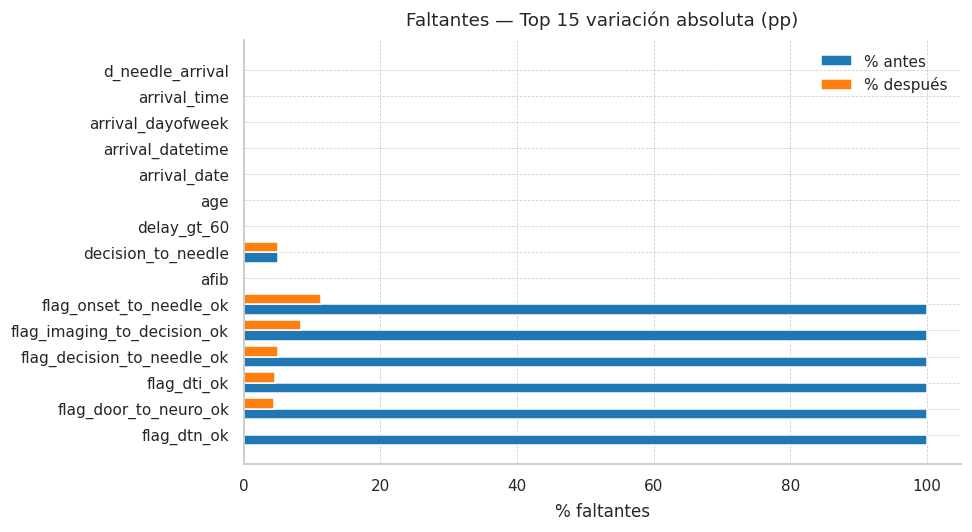


=== Tiempos críticos (min) — resumen antes vs después ===


antes_median  antes_p75  antes_p90  antes_max  despues_median  despues_p75  despues_p90  despues_max
col                                                                                                                      
decision_to_needle          12.86      15.31      17.62      25.20           12.86        15.31        17.62        25.20
door_to_imaging             23.53      28.48      33.27      54.23           23.53        28.48        33.27        54.23
door_to_needle              54.21      61.73      68.70      93.74           54.21        61.73        68.70        93.74
door_to_neuro               14.86      17.75      21.06      32.43           14.86        17.75        21.06        32.43
door_to_triage               8.45      10.59      12.50      17.83            8.45        10.59        12.50        17.83
imaging_to_decision         17.89      22.35      26.26      41.27           17.89        22.35        26.26        41.27
onset_to_needle            177.49     217.75     256.97     365.30          177.49       217.75       256.97       365.30


=== Cumplimiento operativo ===
DTI ≤25  → antes: 54.2% | después: 54.2%
DTN ≤60  → antes: 70.2% | después: 70.2%

=== Target delay_gt_60 (conteos) ===
ANTES  → 0: 1403, 1: 597, NaN: 0  | n=2000  (prev=29.8%)
DESP.  → 0: 1403, 1: 597, NaN: 0  | n=2000  (prev=29.8%)


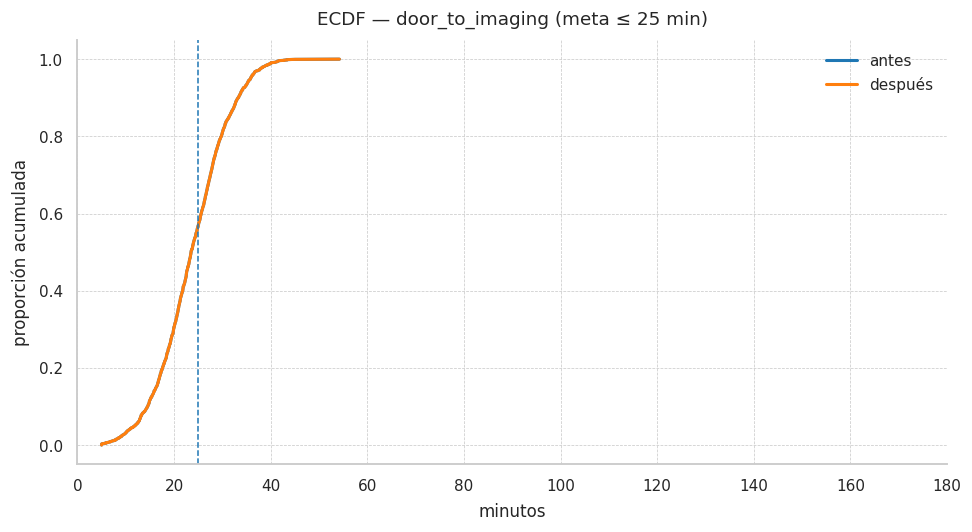

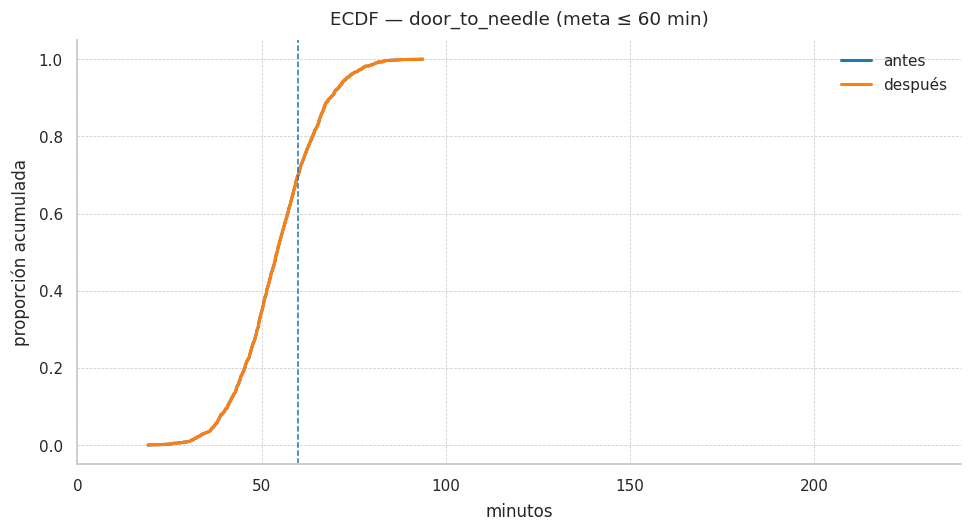

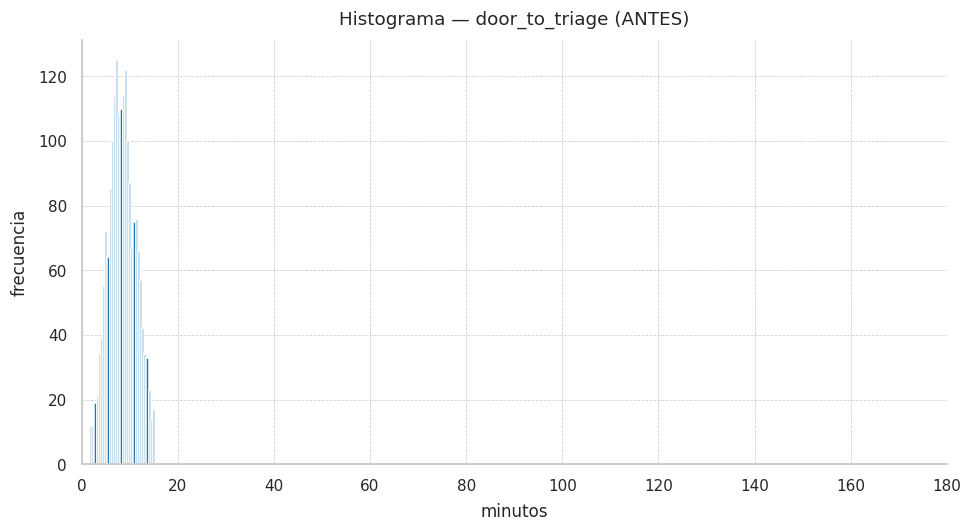

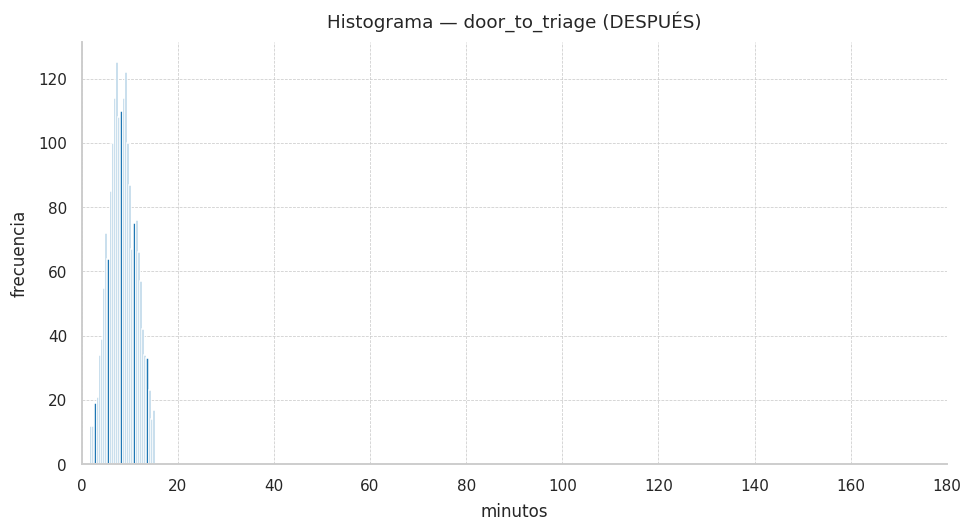

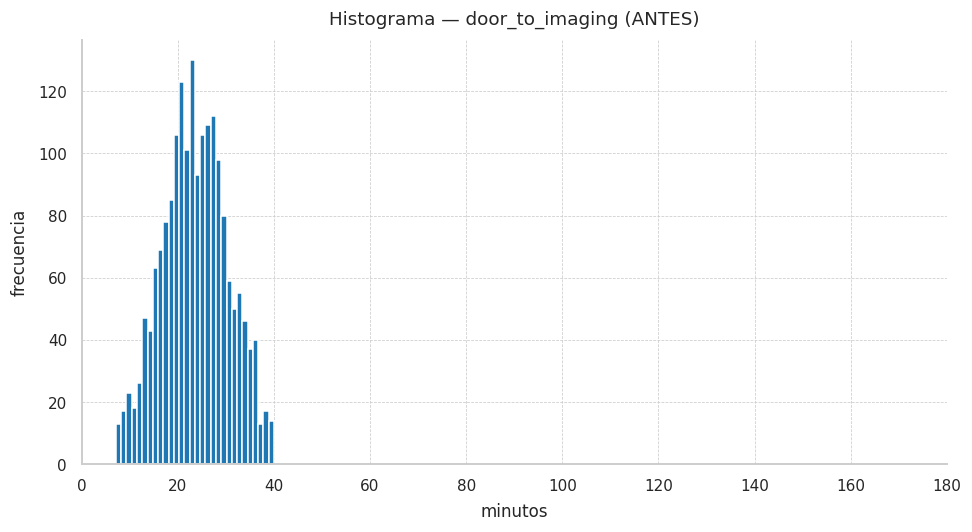

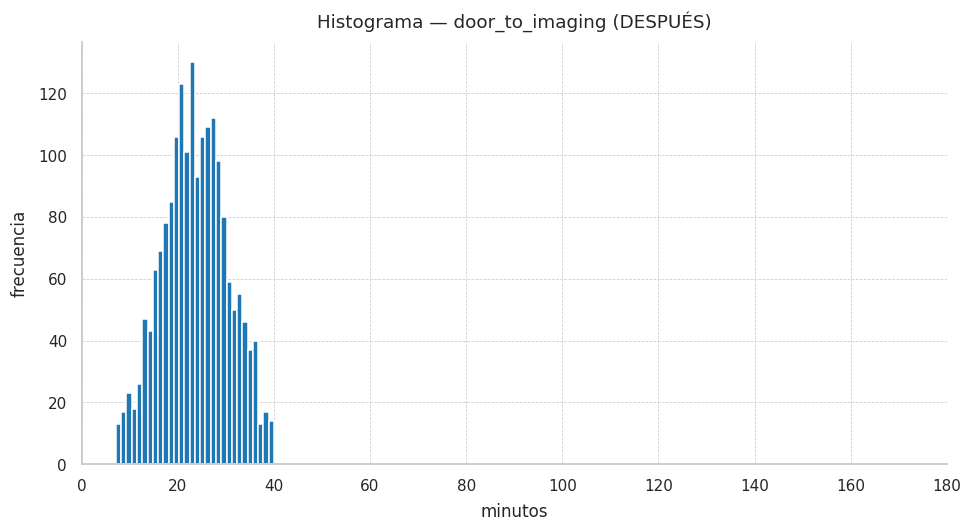

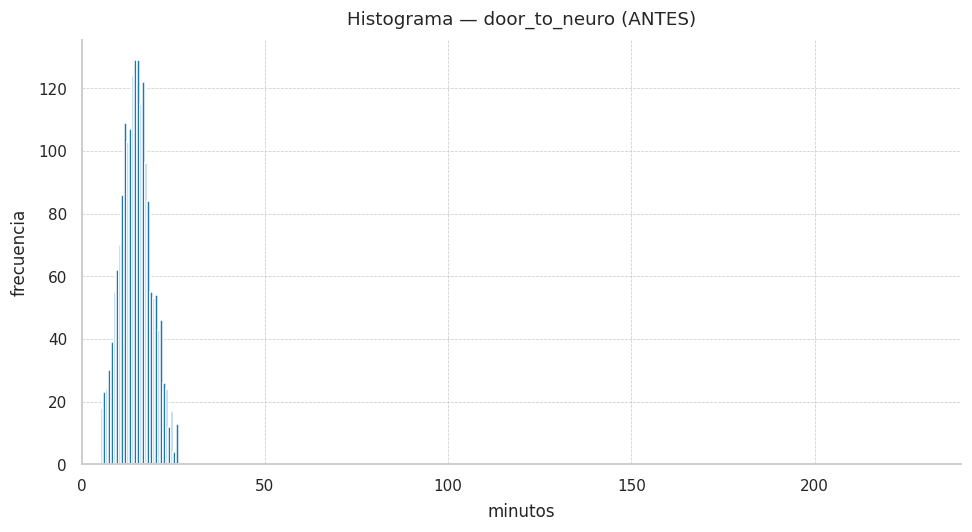

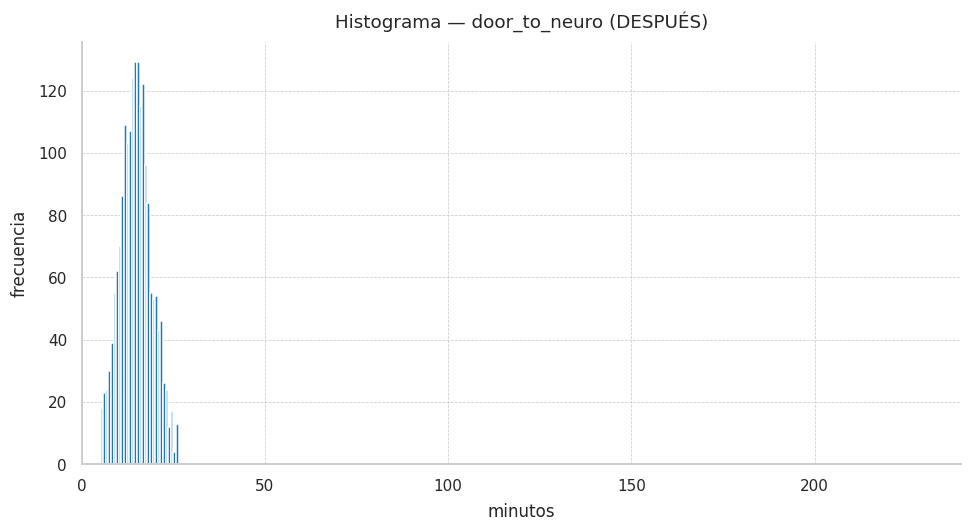

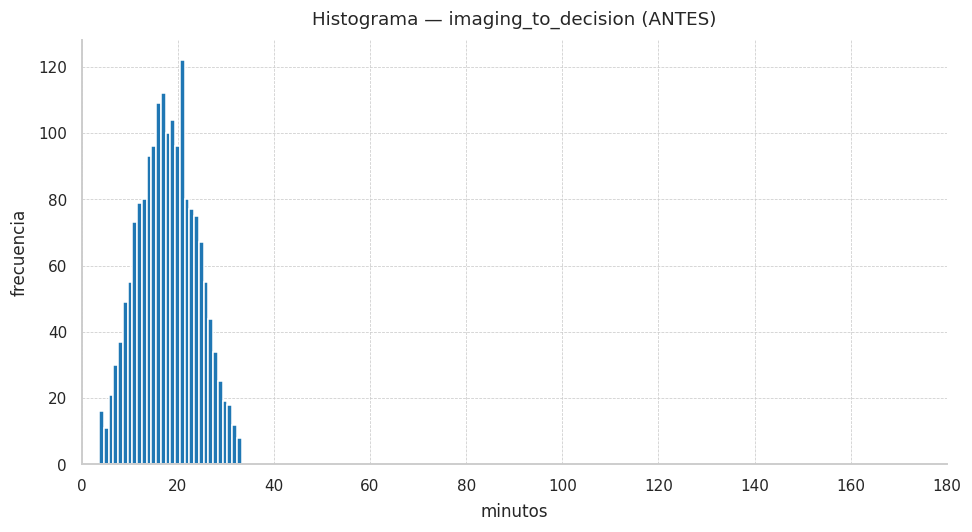

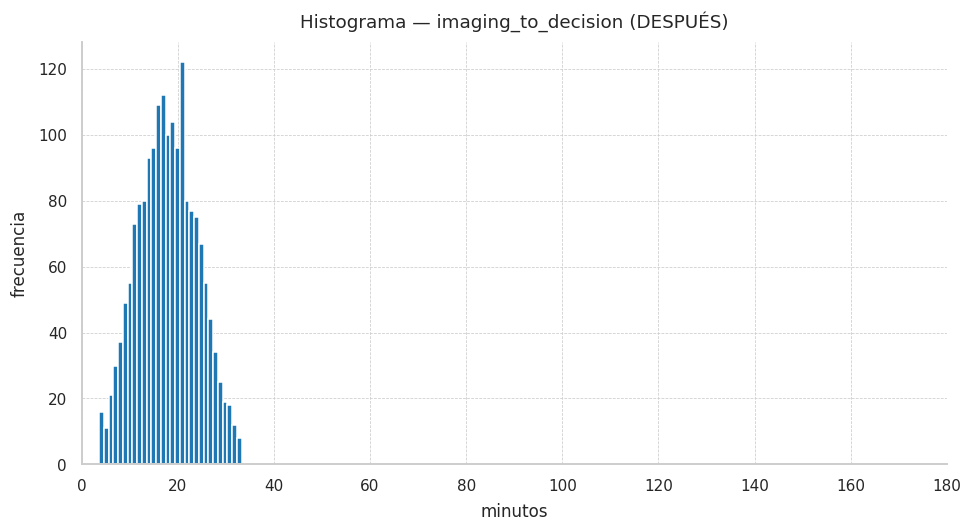

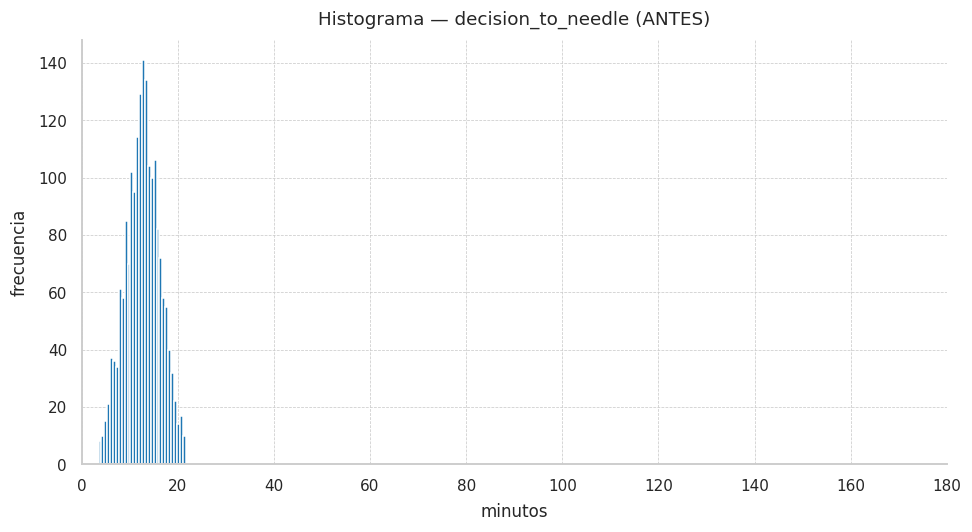

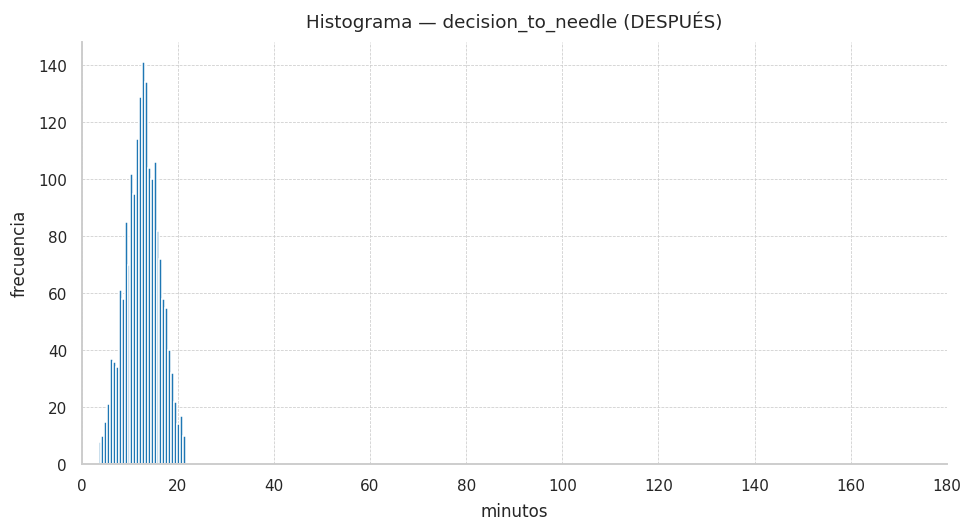

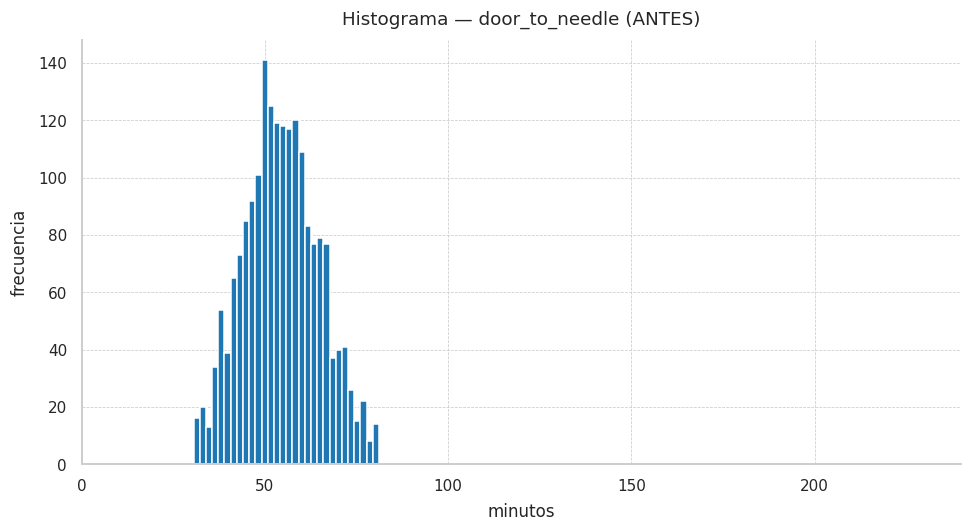

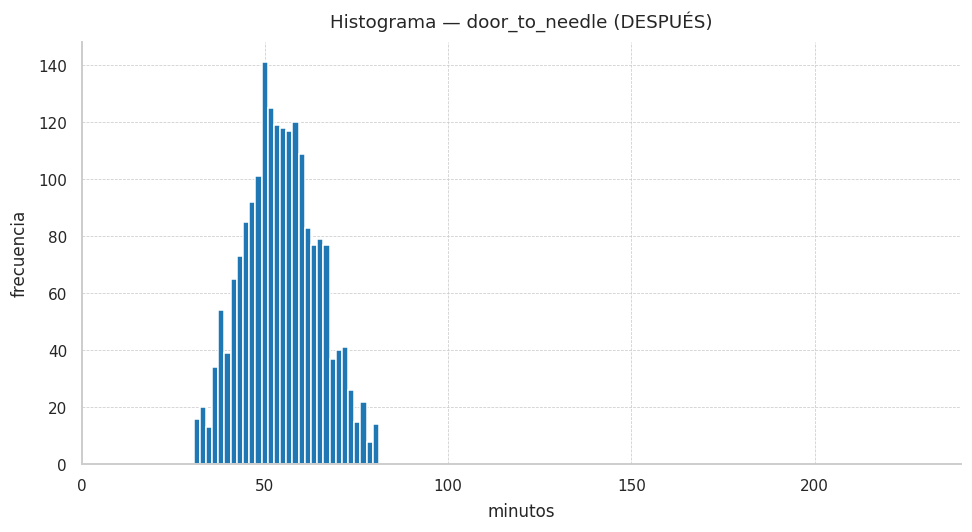

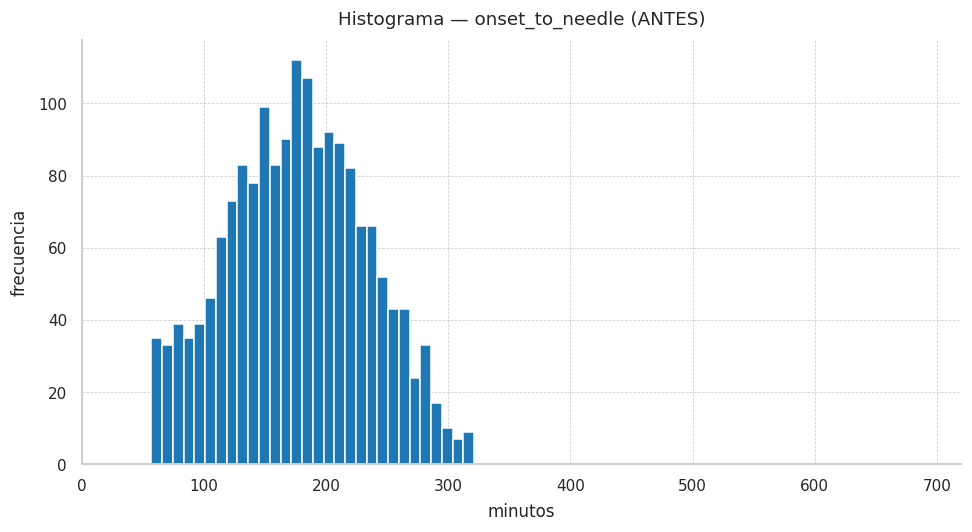

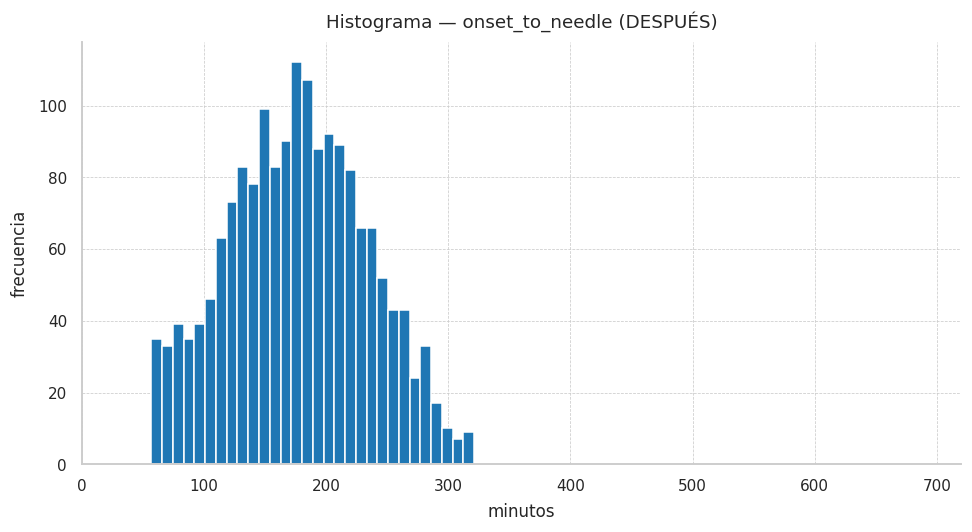


 4.c.11 — Visuales ANTES vs DESPUÉS ejecutado sin errores.
(ANTES) snapshot usado: df_pre_4c5


In [188]:
# ==========================================
# 4.c.11 — Comparación “antes vs después”
# ==========================================

# ---------- 0) Resolver fuentes (ANTES / DESPUÉS) ----------
def _first_defined_name(names):
    for n in names:
        if n in globals():
            return n
    return None

name_before = _first_defined_name(['df_pre_4c7','df_pre_4c5','df_before'])
assert name_before is not None, "No encuentro snapshot 'ANTES' (df_pre_4c7/df_pre_4c5/df_before). Corre 4.c.5/4.c.7 nuevamente para generar snapshot."
dfB_plot = globals()[name_before]
dfA_plot = df  # después = estado actual

# ---------- 1) Tiempos canónicos y límites para visual ----------
TIME_CANON = [
    "door_to_triage","door_to_imaging","door_to_neuro",
    "imaging_to_decision","decision_to_needle","door_to_needle","onset_to_needle"
]
XLIMS = {
    "door_to_imaging": (0, 180),
    "door_to_needle": (0, 240),
    "imaging_to_decision": (0, 180),
    "decision_to_needle": (0, 180),
    "door_to_triage": (0, 180),
    "door_to_neuro": (0, 240),
    "onset_to_needle": (0, 720)
}
present_times = [c for c in TIME_CANON if (c in dfB_plot.columns) or (c in dfA_plot.columns)]

# ---------- 2) Helpers ----------
def _safe_series(df_in, col):
    if col not in df_in.columns:
        return pd.Series([], dtype=float)
    return pd.to_numeric(df_in[col], errors="coerce").dropna()

def _ecdf_xy(s):
    if s.empty:
        return np.array([]), np.array([])
    x = np.sort(s.to_numpy())
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def _time_summary(df_in, cols):
    rows = []
    for c in cols:
        if c in df_in.columns:
            s = pd.to_numeric(df_in[c], errors="coerce").dropna()
            if s.size:
                rows.append([c, float(s.median()), float(s.quantile(0.75)), float(s.quantile(0.90)), float(s.max())])
            else:
                rows.append([c, np.nan, np.nan, np.nan, np.nan])
        else:
            rows.append([c, np.nan, np.nan, np.nan, np.nan])
    out = pd.DataFrame(rows, columns=["col","median","p75","p90","max"]).set_index("col")
    return out.round(2)

def _pct(x):
    return f"{100.0*float(x):.1f}%" if (x is not None) and pd.notna(x) else "n/a"

# ---------- 3) Estructura ----------
cols_before = set(dfB_plot.columns); cols_after = set(dfA_plot.columns)
added_cols  = sorted(list(cols_after - cols_before))
dropped_cols= sorted(list(cols_before - cols_after))

print("=== 4.c.11 — Estructura ===")
print(f"ANTES: {dfB_plot.shape[0]} filas, {dfB_plot.shape[1]} columnas")
print(f"DESPUÉS: {dfA_plot.shape[0]} filas, {dfA_plot.shape[1]} columnas")
print(f"Columnas agregadas: {len(added_cols)}", ("→ " + ", ".join(added_cols[:10]) + (" ..." if len(added_cols)>10 else "")) if added_cols else "")
print(f"Columnas eliminadas: {len(dropped_cols)}", ("→ " + ", ".join(dropped_cols[:10]) + (" ..." if len(dropped_cols)>10 else "")) if dropped_cols else "")

# ---------- 4) Faltantes — variación absoluta (pp) ----------
all_cols_plot = sorted(list(cols_before | cols_after))
missB = dfB_plot.reindex(columns=all_cols_plot).isna().mean() * 100
missA = dfA_plot.reindex(columns=all_cols_plot).isna().mean() * 100
miss_cmp_plot = pd.concat([missB.rename("%_antes"), missA.rename("%_despues")], axis=1).fillna(0)
miss_cmp_plot["abs_delta_pp"] = (miss_cmp_plot["%_despues"] - miss_cmp_plot["%_antes"]).abs()
miss_top = miss_cmp_plot.sort_values("abs_delta_pp", ascending=False).head(15)

print("\n=== Faltantes (variación absoluta, top 15) ===")
try: display(miss_top.round(2))
except: print(miss_top.round(2).to_string())

if not miss_top.empty:
    plt.figure()
    y = np.arange(miss_top.shape[0])
    plt.barh(y - 0.2, miss_top["%_antes"].values, height=0.4, label="% antes")
    plt.barh(y + 0.2, miss_top["%_despues"].values, height=0.4, label="% después")
    plt.yticks(y, miss_top.index)
    plt.xlabel("% faltantes"); plt.title("Faltantes — Top 15 variación absoluta (pp)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- 5) Tiempos críticos — resumen antes vs después ----------
if present_times:
    sumB = _time_summary(dfB_plot, present_times).add_prefix("antes_")
    sumA = _time_summary(dfA_plot, present_times).add_prefix("despues_")
    time_cmp = sumB.join(sumA, how="outer")
    print("\n=== Tiempos críticos (min) — resumen antes vs después ===")
    try: display(time_cmp)
    except: print(time_cmp.to_string())
else:
    print("\n(No hay columnas de tiempo crítico para resumir).")

# ---------- 6) Cumplimiento operativo (DTI ≤25, DTN ≤60) ----------
def _compl(df_in, col, thr):
    if col not in df_in.columns: return np.nan
    s = pd.to_numeric(df_in[col], errors="coerce")
    if s.notna().sum() == 0: return np.nan
    return float((s <= thr).mean())

dtiB = _compl(dfB_plot, "door_to_imaging", 25)
dtiA = _compl(dfA_plot, "door_to_imaging", 25)
dtnB = _compl(dfB_plot, "door_to_needle", 60)
dtnA = _compl(dfA_plot, "door_to_needle", 60)

print("\n=== Cumplimiento operativo ===")
print(f"DTI ≤25  → antes: {_pct(dtiB)} | después: {_pct(dtiA)}")
print(f"DTN ≤60  → antes: {_pct(dtnB)} | después: {_pct(dtnA)}")

# ---------- 7) Distribución del target delay_gt_60 ----------
def _target_dist(df_in):
    if "delay_gt_60" not in df_in.columns:
        return {"0": np.nan, "1": np.nan, "NaN": np.nan, "n": 0}
    s = pd.to_numeric(df_in["delay_gt_60"], errors="coerce")
    return {
        "0": int((s == 0).sum()),
        "1": int((s == 1).sum()),
        "NaN": int(s.isna().sum()),
        "n": int(s.shape[0]),
        "pct_1": float((s == 1).mean()) if s.notna().sum() else np.nan
    }

tdB = _target_dist(dfB_plot)
tdA = _target_dist(dfA_plot)

print("\n=== Target delay_gt_60 (conteos) ===")
print(f"ANTES  → 0: {tdB['0']}, 1: {tdB['1']}, NaN: {tdB['NaN']}  | n={tdB['n']}  (prev={_pct(tdB.get('pct_1', np.nan))})")
print(f"DESP.  → 0: {tdA['0']}, 1: {tdA['1']}, NaN: {tdA['NaN']}  | n={tdA['n']}  (prev={_pct(tdA.get('pct_1', np.nan))})")

# ---------- 8) ECDF DTI/DTN ----------
for col, thr in [("door_to_imaging", 25), ("door_to_needle", 60)]:
    if (col in dfB_plot.columns) or (col in dfA_plot.columns):
        sb = _safe_series(dfB_plot, col); sa = _safe_series(dfA_plot, col)
        if sb.empty and sa.empty:
            continue
        xb, yb = _ecdf_xy(sb); xa, ya = _ecdf_xy(sa)
        plt.figure()
        if xb.size: plt.plot(xb, yb, label="antes")
        if xa.size: plt.plot(xa, ya, label="después")
        plt.axvline(thr, linestyle="--", linewidth=1)
        if col in XLIMS: plt.xlim(*XLIMS[col])
        plt.title(f"ECDF — {col} (meta ≤ {thr} min)")
        plt.xlabel("minutos"); plt.ylabel("proporción acumulada")
        plt.legend(); plt.tight_layout(); plt.show()

# ---------- 9) Histogramas sincronizados (por tiempo crítico) ----------
for col in present_times:
    sb = _safe_series(dfB_plot, col); sa = _safe_series(dfA_plot, col)
    if sb.empty and sa.empty:
        continue
    data = sb
    if sa.size: data = pd.concat([sb, sa], ignore_index=True)
    # bins robustos: percentil 1–99 del conjunto combinado
    if data.size:
        arr = data.to_numpy()
        q1, q99 = (np.percentile(arr, [1, 99]) if arr.size >= 100 else (arr.min(), arr.max()))
        if q99 <= q1:
            bins = 30
        else:
            bins = np.linspace(q1, q99, 31)
    else:
        bins = 30

    # ANTES
    plt.figure()
    if sb.size: plt.hist(sb.clip(*(XLIMS[col] if col in XLIMS else (sb.min(), sb.max()))), bins=bins)
    plt.title(f"Histograma — {col} (ANTES)")
    plt.xlabel("minutos"); plt.ylabel("frecuencia")
    if col in XLIMS: plt.xlim(*XLIMS[col])
    plt.tight_layout(); plt.show()

    # DESPUÉS
    plt.figure()
    if sa.size: plt.hist(sa.clip(*(XLIMS[col] if col in XLIMS else (sa.min(), sa.max()))), bins=bins)
    plt.title(f"Histograma — {col} (DESPUÉS)")
    plt.xlabel("minutos"); plt.ylabel("frecuencia")
    if col in XLIMS: plt.xlim(*XLIMS[col])
    plt.tight_layout(); plt.show()

print("\n 4.c.11 — Visuales ANTES vs DESPUÉS ejecutado sin errores.")
print(f"(ANTES) snapshot usado: {name_before}")


## 4.c.outliers — Política y trazabilidad de valores extremos

**Objetivo**  
Establecer una política clara de tratamiento de *outliers* en los **tiempos clínicos críticos** y las **variables numéricas** para garantizar robustez sin distorsionar las distribuciones originales.

---

### Política base

- **Tiempos clínicos (`TIME_COLS` + `d_needle_arrival`)**  
  - **No se modifican** en el dataset principal (`df`).  
  - Se crean *flags de censura* (`is_censored_cap_*`) cuando alcanzan o superan el **tope clínico máximo**.  
  - La **winsorización robusta** se aplicará **únicamente en el pipeline (Sección 5)**,  
    utilizando cuantiles del conjunto *TRAIN* (sin *leakage*).

- **Otras variables numéricas (no tiempo)**  
  - Los modelos tipo árbol (e.g., `HistGradientBoosting`, `RandomForest`) toleran bien los valores extremos.  
  - Winsorización opcional solo si se define una *whitelist* (`NON_TIME_WINSOR_WHITELIST`).

---

### Trazabilidad

- Los **topes clínicos** (`HARD_CAPS`) se definen explícitamente por variable.  
- Se generan **flags binarios** de censura sin modificar los valores originales.  
- Los parámetros quedan disponibles en variables globales para el pipeline de modelado:
  - `TIME_WINSOR_POLICY`
  - `NON_TIME_WINSOR_WHITELIST`

---

### Resultados esperados

- Dataset original **no alterado**.  
- Flags de censura visibles (`is_censored_cap_*`).  
- Política de winsorización documentada para reproducibilidad y auditoría.  
- Integración directa con el preprocesamiento del pipeline (5.b).


In [189]:
# =========================================================
# 4.c.outliers — flags de censura y knobs de política (compat)
# - NO modifica los tiempos clínicos en df.
# - Crea flags binarios de censura contra topes clínicos (HARD_CAPS).
# - No pisa flags existentes salvo FORCE_REWRITE=True.
# - Expone políticas para el pipeline (Sección 5).
# =========================================================

assert 'df' in globals(), "Falta df."

# -------- 1) Resolver columnas de tiempo “congeladas” --------
if 'FROZEN_TIME_COLS' in globals() and isinstance(FROZEN_TIME_COLS, (list, tuple)) and len(FROZEN_TIME_COLS) > 0:
    time_cols = [c for c in FROZEN_TIME_COLS if c in df.columns]
else:
    default_time_cols = [
        "door_to_imaging","imaging_to_decision","decision_to_needle",
        "door_to_needle","door_to_triage","door_to_neuro","onset_to_needle"
    ]
    time_cols = [c for c in default_time_cols if c in df.columns]

# incluir espejo si existe
if "d_needle_arrival" in df.columns and "d_needle_arrival" not in time_cols:
    time_cols.append("d_needle_arrival")

time_cols = list(dict.fromkeys(time_cols))  # sin duplicados

# -------- 2) Topes clínicos (min). Usa los tuyos si ya existen --------
if 'HARD_CAPS' not in globals() or not isinstance(HARD_CAPS, dict) or not HARD_CAPS:
    HARD_CAPS = {
        "door_to_imaging": 180.0,
        "door_to_needle": 240.0,
        "imaging_to_decision": 180.0,
        "decision_to_needle": 180.0,
        "door_to_triage": 180.0,
        "door_to_neuro": 240.0,
        "onset_to_needle": 720.0,
        "d_needle_arrival": 240.0,
    }

# -------- 3) Flags de censura por tope clínico --------
FORCE_REWRITE = False  # ← pon True si quieres recalcular/pisar flags existentes
CAP_FLAGS_CREATED, CAP_FLAGS_SKIPPED = [], []

for col in time_cols:
    cap = HARD_CAPS.get(col, None)
    if cap is None:
        continue

    flag_col = f"is_censored_cap_{col}"
    if (flag_col in df.columns) and not FORCE_REWRITE:
        CAP_FLAGS_SKIPPED.append(flag_col)
        continue

    s = pd.to_numeric(df[col], errors="coerce")
    flag = np.where(s.notna(), (s >= float(cap)).astype(float), np.nan)  # {1.0,0.0,NaN}
    df[flag_col] = pd.Series(flag, dtype="Float64")
    CAP_FLAGS_CREATED.append(flag_col)

print("=== 4.c.outliers — resumen ===")
print(f"Tiempos evaluados: {len(time_cols)} → {time_cols[:8]}{' ...' if len(time_cols)>8 else ''}")
print(f"Flags creadas: {len(CAP_FLAGS_CREATED)} → {CAP_FLAGS_CREATED[:8]}{' ...' if len(CAP_FLAGS_CREATED)>8 else ''}")
if CAP_FLAGS_SKIPPED:
    print(f"Flags omitidas (ya existían, FORCE_REWRITE=False): {len(CAP_FLAGS_SKIPPED)}")

# Reporte compacto de censura
if CAP_FLAGS_CREATED:
    resumen = {}
    for f in CAP_FLAGS_CREATED:
        s = pd.to_numeric(df[f], errors="coerce")
        resumen[f] = {
            "censurados_1": int((s == 1).sum()),
            "no_cens_0":    int((s == 0).sum()),
            "NaN":          int(s.isna().sum())
        }
    rep = pd.DataFrame(resumen).T
    try:
        display(rep)
    except Exception:
        print(rep.to_string())

# -------- 4) Knobs de política para el pipeline (Sección 5) --------
# Winsorización SOLO en el pipeline y SOLO usando cuantiles del TRAIN (evitar leakage).
TIME_WINSOR_POLICY = {
    "enable": True,             # robustecer tiempos en TRAIN
    "strategy": "quantile_clip",
    "p_low": 0.00,              # no recorte inferior (negativos ya se trataron antes)
    "p_high": 0.99,             # ejemplo: recortar p99 (decisión final en TRAIN)
    "hard_caps": HARD_CAPS,     # referencia de topes clínicos
    "clip_global_max": 1000.0   # guard-rail adicional si quieres
}

# Modelos árbol toleran outliers; solo usa whitelist si hay columnas problemáticas no-tiempo
NON_TIME_WINSOR_WHITELIST = []  # ej.: ["glucose_mgdl"]

print("Política registrada → TIME_WINSOR_POLICY y NON_TIME_WINSOR_WHITELIST (para Sección 5).")


=== 4.c.outliers — resumen ===
Tiempos evaluados: 7 → ['door_to_imaging', 'imaging_to_decision', 'decision_to_needle', 'door_to_triage', 'door_to_neuro', 'onset_to_needle', 'd_needle_arrival']
Flags creadas: 7 → ['is_censored_cap_door_to_imaging', 'is_censored_cap_imaging_to_decision', 'is_censored_cap_decision_to_needle', 'is_censored_cap_door_to_triage', 'is_censored_cap_door_to_neuro', 'is_censored_cap_onset_to_needle', 'is_censored_cap_d_needle_arrival']


censurados_1  no_cens_0  NaN
is_censored_cap_door_to_imaging                 0       1909   91
is_censored_cap_imaging_to_decision             0       1833  167
is_censored_cap_decision_to_needle              0       1900  100
is_censored_cap_door_to_triage                  0       1935   65
is_censored_cap_door_to_neuro                   0       1910   90
is_censored_cap_onset_to_needle                 0       1772  228
is_censored_cap_d_needle_arrival                0       2000    0

Política registrada → TIME_WINSOR_POLICY y NON_TIME_WINSOR_WHITELIST (para Sección 5).


## 4.c.11.3 — Panel comparativo de variables numéricas clave

**Objetivo**  
Comparar la distribución **antes vs después** del preprocesamiento en variables clínicas y operativas representativas mediante:  
1) **ECDF** (función de distribución acumulada empírica), y  
2) **Boxplots** con **escalas sincronizadas**.

**Variables a evaluar (si existen)**  
`age`, `nihss_on_arrival`, `glucose_mgdl`, `sbp`, `dbp`, `arrival_hour`.  
El panel es **robusto**: solo se grafican las columnas presentes en ambos estados.

**Definiciones de comparación**  
- **ANTES:** *snapshot* previo a la imputación (idealmente `df_pre_4c7`; si no, `df_pre_4c5` o `df_before`).  
- **DESPUÉS:** estado actual del dataframe (`df`) tras los pasos 4.c.*.

**Salidas esperadas**  
- Panel 2×K por variable incluida: **ECDF** superpuestas (ANTES/DESPUÉS) y **boxplots** con ejes fijados por variable.  
- Tabla de apoyo con **n válidos** (ANTES/DESPUÉS) por variable.

**Lectura recomendada**  
- **ECDFs muy cercanas** ⇒ el preprocesamiento **no distorsionó** la distribución.  
- **Boxplots** con **medianas** e **IQR** similares ⇒ estabilidad; diferencias marcadas deben explicarse por **imputación puntual** o **winsorización** (si se activó para variables no temporales).  
- Ante **colas derechas**, interpretar con **medianas** y **p75/p90** más que con promedios.

**Notas**  
- Los **tiempos críticos** (DTI/DTN y subtramos) se comparan en 4.c.11.1–4.c.11.2; aquí el foco son **variables clínicas/operativas** auxiliares.  
- Mantener **mismas escalas por variable** facilita detectar cambios sutiles; los **outliers** se abordan en **4.c.outliers**.


=== 4.c.11.3 — Resumen numérico (antes vs después) ===


n_antes  mediana_antes  p75_antes  p90_antes  n_despues  mediana_despues  p75_despues  p90_despues  ks_pvalue
var                                                                                                               
age     2000           68.0       77.0       86.0       2000             68.0         77.0         86.0        1.0

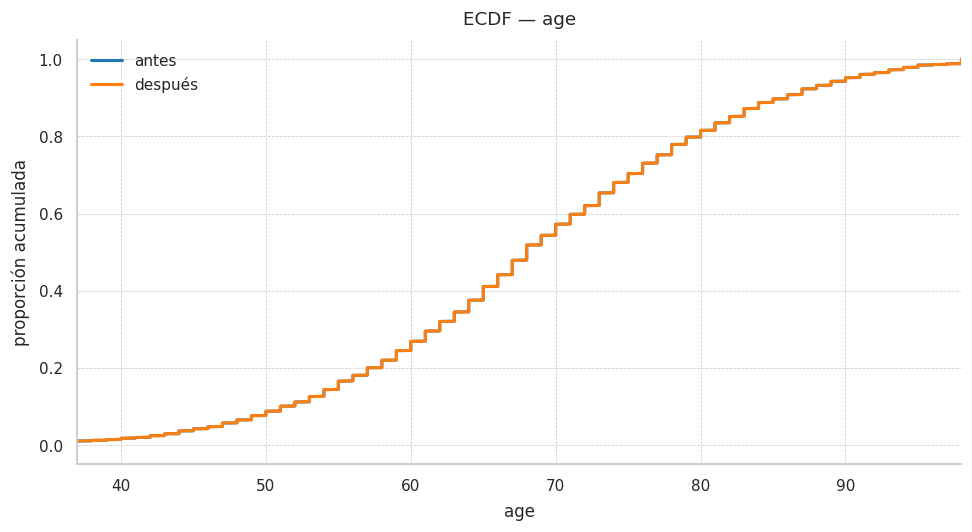

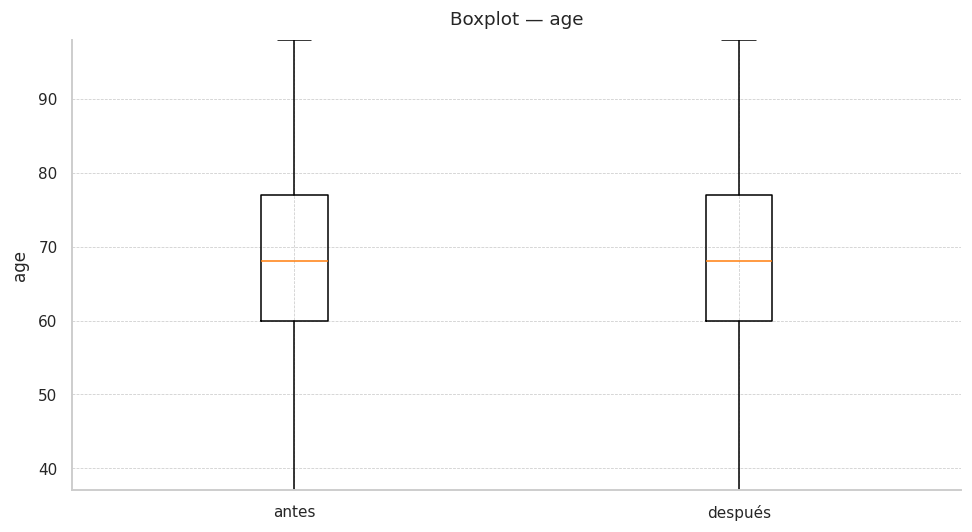

 4.c.11.3 — Panel comparativo generado (ECDF + Boxplots).


In [190]:
# =========================================================
# 4.c.11.3 — Panel comparativo de variables numéricas clave (ECDF + Boxplots)
# =========================================================

from scipy.stats import ks_2samp

# ---------- 0) Resolver snapshots BEFORE/AFTER ----------
def _first_defined(names):
    for n in names:
        if n in globals() and isinstance(globals()[n], pd.DataFrame) and not globals()[n].empty:
            return globals()[n]
    return None

dfB = _first_defined(['df_before','df_pre_4c7','df_pre_4c5'])
if dfB is None:
    dfB = df.copy()
    print(" 'df_before' no disponible. Usando df actual como baseline (solo efectos visuales).")
dfA = df  # después

# ---------- 1) Candidatas y derivaciones opcionales ----------
candidates = ["age", "nihss_on_arrival", "glucose_mgdl", "sbp", "dbp", "arrival_hour"]

# arrival_hour si no existe (lee t_arrival/arrival_ts)
def _ensure_arrival_hour(dfin: pd.DataFrame) -> pd.DataFrame:
    if "arrival_hour" in dfin.columns:
        return dfin
    hint_cols = [c for c in ["t_arrival", "arrival_ts", "ts_arrival"] if c in dfin.columns]
    if hint_cols:
        ts = pd.to_datetime(dfin[hint_cols[0]], errors="coerce")
        dfin = dfin.copy()
        # si todo es NaT, resultará en NaN y simplemente no se graficará esa variable
        dfin["arrival_hour"] = ts.dt.hour.astype("float")
    return dfin

dfB = _ensure_arrival_hour(dfB)
dfA = _ensure_arrival_hour(dfA)

present = [c for c in candidates if (c in dfB.columns) or (c in dfA.columns)]
if not present:
    print("No hay variables numéricas clave disponibles entre las candidatas para graficar.")
    present = []

# ---------- 2) Helpers ----------
def _num_series(dfin, col):
    if col not in dfin.columns:
        return pd.Series([], dtype=float)
    return pd.to_numeric(dfin[col], errors="coerce").dropna()

def _ecdf_xy(s):
    if s.empty:
        return np.array([]), np.array([])
    x = np.sort(s.values)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

# Límites clínicos/operativos por variable (para lectura consistente)
XLIMS = {
    "age": (0, 110),
    "nihss_on_arrival": (0, 42),
    "glucose_mgdl": (40, 600),
    "sbp": (60, 260),
    "dbp": (30, 160),
    "arrival_hour": (0, 24),
}

# ---------- 3) Tabla resumen (antes vs después) ----------
rows = []
for col in present:
    sb = _num_series(dfB, col)
    sa = _num_series(dfA, col)
    def _summary(s):
        if s.size == 0: return (np.nan, np.nan, np.nan, 0)
        return (float(s.median()), float(s.quantile(0.75)), float(s.quantile(0.90)), int(s.size))
    med_b, p75_b, p90_b, n_b = _summary(sb)
    med_a, p75_a, p90_a, n_a = _summary(sa)
    ks_p = np.nan
    if sb.size > 0 and sa.size > 0 and (sb.nunique() > 1 or sa.nunique() > 1):
        ks_p = float(ks_2samp(sb, sa, alternative='two-sided', mode='auto').pvalue)
    rows.append([col, n_b, med_b, p75_b, p90_b, n_a, med_a, p75_a, p90_a, ks_p])

summary_tbl = pd.DataFrame(
    rows,
    columns=["var","n_antes","mediana_antes","p75_antes","p90_antes",
             "n_despues","mediana_despues","p75_despues","p90_despues","ks_pvalue"]
).set_index("var").round(2)

print("=== 4.c.11.3 — Resumen numérico (antes vs después) ===")
try:
    display(summary_tbl)
except Exception:
    print(summary_tbl.to_string())

# ---------- 4) ECDF por variable (xlim sincronizado y robusto) ----------
for col in present:
    sb = _num_series(dfB, col)
    sa = _num_series(dfA, col)
    if sb.empty and sa.empty:
        continue

    xb, yb = _ecdf_xy(sb)
    xa, ya = _ecdf_xy(sa)

    # xlim robusto: percentiles 1–99 del conjunto combinado + tope clínico si existe
    comb = pd.concat([sb, sa], ignore_index=True)
    if comb.size:
        if comb.size >= 100:
            q1, q99 = np.nanpercentile(comb, [1, 99])
        else:
            q1, q99 = (comb.min(), comb.max())
        lo, hi = q1, q99
        if col in XLIMS:
            lo = max(lo, XLIMS[col][0])
            hi = min(hi, XLIMS[col][1])
        if lo >= hi:
            lo, hi = (XLIMS[col] if col in XLIMS else (comb.min(), comb.max()))
    else:
        lo, hi = XLIMS.get(col, (0, 1))

    plt.figure()
    plotted = False
    if xb.size:
        plt.plot(xb, yb, label="antes")
        plotted = True
    if xa.size:
        plt.plot(xa, ya, label="después")
        plotted = True
    if not plotted:
        plt.close()
        continue
    plt.xlim(lo, hi)
    plt.title(f"ECDF — {col}")
    plt.xlabel(col); plt.ylabel("proporción acumulada")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- 5) Boxplots (mismas escalas en eje Y) ----------
for col in present:
    sb = _num_series(dfB, col)
    sa = _num_series(dfA, col)
    if sb.empty and sa.empty:
        continue

    # y-lim robusto y consistente con ECDF
    comb = pd.concat([sb, sa], ignore_index=True)
    if comb.size:
        if comb.size >= 100:
            q1, q99 = np.nanpercentile(comb, [1, 99])
        else:
            q1, q99 = (comb.min(), comb.max())
        lo, hi = q1, q99
        if col in XLIMS:
            lo = max(lo, XLIMS[col][0])
            hi = min(hi, XLIMS[col][1])
        if lo >= hi:
            lo, hi = (XLIMS[col] if col in XLIMS else (comb.min(), comb.max()))
    else:
        lo, hi = XLIMS.get(col, (0, 1))

    data, labels = [], []
    if not sb.empty: data.append(sb.values); labels.append("antes")
    if not sa.empty: data.append(sa.values); labels.append("después")

    if not data:
        continue

    plt.figure()
    plt.boxplot(data, vert=True, labels=labels, whis=1.5, showfliers=True)
    plt.ylim(lo, hi)
    plt.title(f"Boxplot — {col}" + ("" if len(labels)==2 else f" (solo {labels[0]})"))
    plt.ylabel(col)
    plt.tight_layout(); plt.show()

print(" 4.c.11.3 — Panel comparativo generado (ECDF + Boxplots).")


## 4.c.11.3 — Resumen estadístico ANTES vs DESPUÉS

**Objetivo**  
Cuantificar el impacto del preprocesamiento en variables clínicas/operativas clave mediante un cuadro comparativo que incluya:
- **n válidos**, **media**, **desviación estándar**  
- **mediana**, **Q1**, **Q3**, **IQR** (= Q3 − Q1)  
- **mínimo** y **máximo**

**Selección**  
Se utilizan, si existen en el dataset: `age`, `nihss_on_arrival`, `glucose_mgdl`, `sbp`, `dbp`, `arrival_hour`.  
El cálculo es **robusto** a columnas ausentes y a valores no numéricos (se aplica coerción segura).

**Salida esperada**  
Una **tabla comparativa** por variable con columnas duplicadas “antes” y “después”, por ejemplo:

| Variable | n_antes | media_antes | sd_antes | mediana_antes | Q1_antes | Q3_antes | IQR_antes | min_antes | max_antes | n_despues | media_despues | sd_despues | mediana_despues | Q1_despues | Q3_despues | IQR_despues | min_despues | max_despues |
|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| age | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … |
| nihss_on_arrival | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … |
| … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … | … |

> **Nota:** si una variable no está presente en alguno de los snapshots, sus métricas se reportarán como `NaN`.

**Interpretación**  
- Estabilidad en **mediana** e **IQR** sugiere que la imputación **no distorsionó** la distribución central.  
- Cambios marcados en **máximos** pueden deberse a **winsorización** (si se aplicó) o a la corrección de valores imposibles.  
- Diferencias en **n válidos** reflejan imputaciones o descartes esperados por limpieza.


In [191]:
# =========================================================
# 4.c.11.3 — Resumen estadístico ANTES vs DESPUÉS (robusto + deltas, con ALIASES)
# =========================================================

assert 'df' in globals(), "df no definido."

# ---------- 0) Resolver snapshot ANTES ----------
def _resolve_before():
    for name in ['df_pre_4c7', 'df_pre_4c5', 'df_before']:
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            return globals()[name], name
    return df.copy(), 'df (fallback)'

dfB, name_before = _resolve_before()
dfA = df  # DESPUÉS

# ---------- 1) Candidatos con ALIASES ----------
# clave = nombre canónico a reportar | valores = posibles nombres en el DF
CANDIDATE_ALIASES = {
    "age":               ["age", "edad", "patient_age", "age_years"],
    "nihss_on_arrival":  ["nihss_on_arrival", "nihss", "nihss_ingreso", "nihss_arrival"],
    "glucose_mgdl":      ["glucose_mgdl", "glucose", "glucosa", "glucose_mg_dl"],
    "sbp":               ["sbp", "pas", "sbp_mmhg", "systolic_bp"],
    "dbp":               ["dbp", "pad", "dbp_mmhg", "diastolic_bp"],
    "arrival_hour":      ["arrival_hour"],  # si falta se derivará desde t_arrival/arrival_ts
}

def _first_present(dfin: pd.DataFrame, names):
    for c in names:
        if c in dfin.columns:
            return c
    return None

# Derivar arrival_hour si falta
def _ensure_arrival_hour(dfin: pd.DataFrame) -> pd.DataFrame:
    if "arrival_hour" in dfin.columns:
        return dfin
    ts_col = next((c for c in ["t_arrival", "arrival_ts", "ts_arrival"] if c in dfin.columns), None)
    if ts_col is not None:
        dfin = dfin.copy()
        ts = pd.to_datetime(dfin[ts_col], errors="coerce")
        dfin["arrival_hour"] = ts.dt.hour.astype("float")
    return dfin

dfB = _ensure_arrival_hour(dfB)
dfA = _ensure_arrival_hour(dfA)

# Resolver, para cada canónico, cuál columna usar en ANTES y en DESPUÉS
resolved = []
for canon, aliases in CANDIDATE_ALIASES.items():
    colB = _first_present(dfB, aliases)
    colA = _first_present(dfA, aliases)
    if (colB is not None) or (colA is not None):
        resolved.append((canon, colB, colA))

if not resolved:
    print("No hay variables numéricas clave disponibles entre las candidatas para resumir.")
    resolved = []

# ---------- 2) Helpers numéricos ----------
def _num_series(dfin, col):
    if col is None or col not in dfin.columns:
        return pd.Series([], dtype=float)
    return pd.to_numeric(dfin[col], errors="coerce").dropna().astype(float)

def _stats(s: pd.Series):
    if s.empty:
        return dict(n=0, mean=np.nan, std=np.nan, median=np.nan, q1=np.nan, q3=np.nan,
                    iqr=np.nan, min=np.nan, max=np.nan)
    q1, q3 = s.quantile([0.25, 0.75])
    return dict(
        n=int(s.size),
        mean=float(s.mean()),
        std=float(s.std(ddof=1)) if s.size > 1 else np.nan,
        median=float(s.median()),
        q1=float(q1), q3=float(q3),
        iqr=float(q3 - q1),
        min=float(s.min()), max=float(s.max()),
    )

def _pct(delta, base):
    return (np.nan if (base is None or pd.isna(base) or base == 0)
            else 100.0 * float(delta) / float(base))

# ---------- 3) Construir resumen ----------
rows = []
for canon, colB, colA in resolved:
    sb = _num_series(dfB, colB)
    sa = _num_series(dfA, colA)
    b = _stats(sb); a = _stats(sa)

    d_mean   = (a["mean"]   - b["mean"])   if (pd.notna(b["mean"])   and pd.notna(a["mean"]))   else np.nan
    d_median = (a["median"] - b["median"]) if (pd.notna(b["median"]) and pd.notna(a["median"])) else np.nan
    d_iqr    = (a["iqr"]    - b["iqr"])    if (pd.notna(b["iqr"])    and pd.notna(a["iqr"]))    else np.nan

    rows.append({
        "variable": canon,
        "col_antes": colB, "col_despues": colA,
        "antes_n": b["n"], "despues_n": a["n"],
        "antes_mean": b["mean"], "despues_mean": a["mean"], "Δ_mean": d_mean, "Δ_mean_%": _pct(d_mean, b["mean"]),
        "antes_median": b["median"], "despues_median": a["median"], "Δ_median": d_median, "Δ_median_%": _pct(d_median, b["median"]),
        "antes_iqr": b["iqr"], "despues_iqr": a["iqr"], "Δ_iqr": d_iqr, "Δ_iqr_%": _pct(d_iqr, b["iqr"]),
        "antes_q1": b["q1"], "despues_q1": a["q1"],
        "antes_q3": b["q3"], "despues_q3": a["q3"],
        "antes_std": b["std"], "despues_std": a["std"],
        "antes_min": b["min"], "despues_min": a["min"],
        "antes_max": b["max"], "despues_max": a["max"],
    })

summary_stats = pd.DataFrame(rows) if rows else pd.DataFrame(columns=[
    "variable","col_antes","col_despues","antes_n","despues_n","antes_mean","despues_mean",
    "Δ_mean","Δ_mean_%","antes_median","despues_median","Δ_median","Δ_median_%","antes_iqr",
    "despues_iqr","Δ_iqr","Δ_iqr_%","antes_q1","despues_q1","antes_q3","despues_q3","antes_std",
    "despues_std","antes_min","despues_min","antes_max","despues_max"
])

# Orden + redondeo
col_order = [
    "variable","col_antes","col_despues","antes_n","despues_n",
    "antes_mean","despues_mean","Δ_mean","Δ_mean_%",
    "antes_median","despues_median","Δ_median","Δ_median_%",
    "antes_iqr","despues_iqr","Δ_iqr","Δ_iqr_%",
    "antes_q1","despues_q1","antes_q3","despues_q3",
    "antes_std","despues_std","antes_min","despues_min","antes_max","despues_max"
]
summary_stats = summary_stats[col_order].sort_values("variable").reset_index(drop=True)
num_cols = [c for c in col_order if c in summary_stats.columns and c not in ["variable","col_antes","col_despues","antes_n","despues_n"]]
summary_stats[num_cols] = summary_stats[num_cols].applymap(lambda x: (round(float(x), 3) if pd.notna(x) else x))

print(f"=== 4.c.11.3 — Resumen ANTES vs DESPUÉS (baseline: {name_before}) ===")
try:
    display(summary_stats)
except Exception:
    print(summary_stats.to_string(index=False))

# Artefacto CSV opcional
out_dir = Path("./artifacts_4c11")
out_dir.mkdir(exist_ok=True)
csv_path = out_dir / "summary_stats_4c11_3.csv"
summary_stats.to_csv(csv_path, index=False)
print(f"Artefacto guardado → {csv_path}")


=== 4.c.11.3 — Resumen ANTES vs DESPUÉS (baseline: df_pre_4c5) ===


variable col_antes col_despues  antes_n  despues_n  antes_mean  despues_mean  Δ_mean  Δ_mean_%  antes_median  despues_median  Δ_median  Δ_median_%  \
0               age       age         age     2000       2000      68.364        68.364     0.0       0.0          68.0            68.0       0.0         0.0   
1  nihss_on_arrival     nihss       nihss     2000       2000      12.604        12.604     0.0       0.0          13.0            13.0       0.0         0.0   

   antes_iqr  despues_iqr  Δ_iqr  Δ_iqr_%  antes_q1  despues_q1  antes_q3  despues_q3  antes_std  despues_std  antes_min  despues_min  antes_max  despues_max  
0       17.0         17.0    0.0      0.0      60.0        60.0      77.0        77.0     13.112       13.112       18.0         18.0       98.0         98.0  
1       13.0         13.0    0.0      0.0       6.0         6.0      19.0        19.0      7.488        7.488        0.0          0.0       25.0         25.0

Artefacto guardado → artifacts_4c11/summary_stats_4c11_3.csv


## 4.c.12 — KS-test de estabilidad y verificación integral

**Objetivo**  
Verificar que el preprocesamiento **no distorsionó** la distribución de las variables clave y ejecutar un **chequeo integral** de coherencia final.

**Qué se prueba**

1) **Estabilidad de distribución (KS-test)**  
Se compara **ANTES vs DESPUÉS** para:
- **Tiempos críticos** (`door_to_imaging`, `imaging_to_decision`, `decision_to_needle`, `door_to_needle`, `door_to_triage`, `door_to_neuro`, `onset_to_needle`), solo si existen.  
- **Clínicas/operativas** representativas: `age`, `nihss_on_arrival`, `glucose_mgdl`, `sbp`, `dbp`, `arrival_hour` (derivada desde `t_arrival` si no está).

> Ajuste por múltiples pruebas: **Bonferroni** (α\* = 0,05 / m).  
> Interpretación: **p > α\*** ⇒ *estable* (no evidencia de cambio); **p ≤ α\*** ⇒ *cambio detectable* (explicable por imputación/winsorización si se aplicó).

2) **Verificación integral de coherencia**
- **Target vs DTN**: `delay_gt_60` ≡ `door_to_needle > 60` (discrepancias = 0).  
- **Flag DTN**: `flag_dtn_ok` ≡ `door_to_needle ≤ 60`.  
- **No negativos / límites plausibles** en tiempos “congelados” (`FROZEN_TIME_COLS`).  
- **Disponibilidad de flags/target** y conteos básicos.

**Salidas**
- Tabla `ks_results` con: variable, n_antes/n_después, KS-stat, p-valor, α\* y decisión (*estable* / *cambio*).  
- Reporte de discrepancias (si existieran) para `delay_gt_60` y `flag_dtn_ok`.  
- Resumen de validaciones (negativos, límites y presencia de columnas clave).

**Lectura rápida**  
- La **mayoría de p-valores > α\*** sugiere que el preprocesamiento **preservó** la forma de las distribuciones.  
- Discrepancias **0** en reglas DTN/target validan la **trazabilidad** de etiquetas.  
- Cualquier variable marcada como *cambio* debe quedar **documentada** (p. ej., imputación puntual).


In [192]:
# =========================================================
# 4.c.12 — KS-test de estabilidad y verificación integral
# (versión unificada: SciPy opcional + Bonferroni + checks finales)
# =========================================================

# --- 0) SciPy opcional
try:
    from scipy.stats import ks_2samp
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

assert 'df' in globals(), "df no definido."

# --- 1) Resolver snapshots ANTES/DESPUÉS de forma robusta
def _resolve_before():
    for name in ['df_pre_4c7', 'df_pre_4c5', 'df_before']:
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            return globals()[name], name
    return df.copy(), 'df (fallback)'

df_before, name_before = _resolve_before()
df_after = df  # estado actual

# --- 2) Columnas de tiempos a testear (presentes)
TIME_CANON = [
    "door_to_imaging","door_to_needle","imaging_to_decision",
    "decision_to_needle","door_to_triage","door_to_neuro","onset_to_needle"
]
cols_test = [c for c in TIME_CANON if (c in df_before.columns) or (c in df_after.columns)]

def _num_s(dfin, col):
    return pd.to_numeric(dfin[col], errors="coerce").dropna() if col in dfin.columns else pd.Series([], dtype=float)

# --- 3) KS-test (solo si SciPy disponible y n≥30 en ambos) + Bonferroni
ks_tbl = pd.DataFrame(columns=["variable","n_antes","n_despues","KS_stat","p_value","alpha_bonf","estable"])
if SCIPY_OK and cols_test:
    rows = []
    for c in cols_test:
        s_b = _num_s(df_before, c)
        s_a = _num_s(df_after, c)
        if len(s_b) >= 30 and len(s_a) >= 30 and (s_b.nunique()>1 or s_a.nunique()>1):
            stat, p = ks_2samp(s_b, s_a, alternative="two-sided", mode="auto")
            rows.append([c, int(len(s_b)), int(len(s_a)), float(stat), float(p)])
    if rows:
        ks_tbl = pd.DataFrame(rows, columns=["variable","n_antes","n_despues","KS_stat","p_value"])
        m = ks_tbl.shape[0]
        alpha = 0.05
        alpha_adj = (alpha / m) if m else float("nan")
        ks_tbl["alpha_bonf"] = alpha_adj
        ks_tbl["estable"] = ks_tbl["p_value"].apply(lambda p: (p > alpha_adj) if pd.notna(p) else np.nan)
        ks_tbl = ks_tbl.sort_values("p_value").reset_index(drop=True)
        print(f"=== KS pre vs post — estabilidad de distribución (tiempos) ===  (baseline: {name_before})")
        print(f"Pruebas m={m} | α=0.05 | α* (Bonferroni)={alpha_adj if not np.isnan(alpha_adj) else 'n/a'}")
        try: display(ks_tbl.round(6))
        except: print(ks_tbl.round(6).to_string(index=False))
    else:
        print("KS-test: sin tamaños suficientes (n≥30) o sin variabilidad para las columnas de tiempo.")
elif not SCIPY_OK:
    print("SciPy no disponible; se omite KS-test.")
else:
    print("No hay columnas de tiempo disponibles para KS-test.")

# --- 4) Verificación integral breve
print("\n=== Verificación integral ===")

# 4.1 Duplicados exactos (post)
dup_rows = int(df_after.duplicated().sum())
print(f"Duplicados exactos (después): {dup_rows}")

# 4.2 Top faltantes (post)
na_top = df_after.isna().mean().sort_values(ascending=False) * 100
if (na_top > 0).any():
    print("\nTop faltantes (%) — después:")
    try: display(na_top[na_top>0].head(15).round(2))
    except: print(na_top[na_top>0].head(15).round(2).to_string())
else:
    print("\nSin faltantes en el estado 'después'.")

# 4.3 Consistencia de flags / metas operativas
def _compl(dfin, col, thr):
    if col not in dfin.columns: return np.nan
    s = pd.to_numeric(dfin[col], errors="coerce")
    return float((s <= thr).mean()) if s.notna().sum() else np.nan

dti_b = _compl(df_before, "door_to_imaging", 25)
dti_a = _compl(df_after,  "door_to_imaging", 25)
dtn_b = _compl(df_before, "door_to_needle",  60)
dtn_a = _compl(df_after,  "door_to_needle",  60)

fmt = lambda x: ("n/a" if (x is None or pd.isna(x)) else f"{100.0*float(x):.1f}%")
print("\nCumplimiento operativo (≤ metas):")
print(f"DTI ≤25  → antes: {fmt(dti_b)} | después: {fmt(dti_a)}")
print(f"DTN ≤60  → antes: {fmt(dtn_b)} | después: {fmt(dtn_a)}")

# 4.4 Distribución de target
def _target_dist(dfin):
    if "delay_gt_60" not in dfin.columns:
        return {"0": np.nan, "1": np.nan, "NaN": np.nan, "n": 0, "prev_1": np.nan}
    s = pd.to_numeric(dfin["delay_gt_60"], errors="coerce")
    return {
        "0": int((s == 0).sum()),
        "1": int((s == 1).sum()),
        "NaN": int(s.isna().sum()),
        "n": int(s.shape[0]),
        "prev_1": float((s == 1).mean()) if s.notna().sum() else np.nan
    }

tdB = _target_dist(df_before)
tdA = _target_dist(df_after)
fmtp = lambda p: ("n/a" if pd.isna(p) else f"{100.0*p:.1f}%")
print("\nTarget delay_gt_60 (conteos y prevalencia):")
print(f"ANTES  → 0: {tdB['0']}, 1: {tdB['1']}, NaN: {tdB['NaN']} | n={tdB['n']} | prev_1={fmtp(tdB['prev_1'])}")
print(f"DESP.  → 0: {tdA['0']}, 1: {tdA['1']}, NaN: {tdA['NaN']} | n={tdA['n']} | prev_1={fmtp(tdA['prev_1'])}")

# 4.5 Reglas exactas: delay_gt_60 ≡ (DTN>60), flag_dtn_ok ≡ (DTN≤60)
def _safe_num(col):
    return pd.to_numeric(df_after[col], errors="coerce") if col in df_after.columns else None

dtn = _safe_num("door_to_needle")
flag = _safe_num("flag_dtn_ok")
tgt = _safe_num("delay_gt_60")

if dtn is not None and tgt is not None and dtn.notna().sum() and tgt.notna().sum():
    mask = dtn.notna() & tgt.notna()
    discrep_target = int(((dtn > 60).astype(float) != tgt.astype(float)).where(mask).sum())
    print(f"\n[Check] delay_gt_60 vs (DTN>60): discrepancias = {discrep_target} / {int(mask.sum())}")
    ct = pd.crosstab((dtn > 60).where(mask).astype(float), tgt.where(mask).astype(float))
    try: display(ct)
    except: print(ct.to_string())

if dtn is not None and flag is not None and dtn.notna().sum() and flag.notna().sum():
    mask = dtn.notna() & flag.notna()
    discrep_flag = int(((dtn <= 60).astype(float) != flag.astype(float)).where(mask).sum())
    print(f"\n[Check] flag_dtn_ok vs (DTN≤60): discrepancias = {discrep_flag} / {int(mask.sum())}")
    ct = pd.crosstab((dtn <= 60).where(mask).astype(float), flag.where(mask).astype(float))
    try: display(ct)
    except: print(ct.to_string())

# 4.6 Negativos y topes en tiempos congelados
neg_counts, over_caps = {}, {}
caps = globals().get("HARD_CAPS", {})
frozen = globals().get("FROZEN_TIME_COLS", [])
for c in frozen:
    if c in df_after.columns:
        s = pd.to_numeric(df_after[c], errors="coerce")
        nneg = int((s < 0).sum())
        if nneg: neg_counts[c] = nneg
        if c in caps:
            over = int((s > caps[c]).sum())
            if over: over_caps[c] = over

print("\n[Check] tiempos congelados — negativos / sobre tope clínico")
print("Negativos:", (neg_counts if neg_counts else "{} (OK)"))
print("Sobre tope:", (over_caps if over_caps else "{} (OK)"))

# --- 5) Señales/alertas simples
alerts = []
if not ks_tbl.empty:
    altered = ks_tbl[ks_tbl["p_value"] < ks_tbl["alpha_bonf"]]["variable"].tolist()
    if altered:
        alerts.append(f"KS con cambio tras Bonferroni en: {altered[:10]}{' ...' if len(altered)>10 else ''}")

def _pp_change(a, b):
    if pd.isna(a) or pd.isna(b): return 0.0
    return float(100.0*(b - a))

pp_dti = _pp_change(dti_b, dti_a)
pp_dtn = _pp_change(dtn_b, dtn_a)
if abs(pp_dti) > 5: alerts.append(f"Cambio en DTI≤25 de {pp_dti:+.1f} pp")
if abs(pp_dtn) > 5: alerts.append(f"Cambio en DTN≤60 de {pp_dtn:+.1f} pp")

if not pd.isna(tdB["prev_1"]) and not pd.isna(tdA["prev_1"]):
    pp_prev = float(100.0*(tdA["prev_1"] - tdB["prev_1"]))
    if abs(pp_prev) > 5:
        alerts.append(f"Cambio en prevalencia delay_gt_60 de {pp_prev:+.1f} pp")

if alerts:
    print("\n Alertas:")
    for a in alerts:
        print(" -", a)
else:
    print("\n Sin alertas relevantes (KS/operativo/target dentro de umbrales)")

# --- 6) Artefactos (opcional)
out_dir = Path("./artifacts_4c12")
out_dir.mkdir(exist_ok=True)
if not ks_tbl.empty:
    ks_path = out_dir / "ks_times_before_after.csv"
    ks_tbl.to_csv(ks_path, index=False)
    print(f"\nKS exportado → {ks_path}")

print(f"\nBaseline usado para 'ANTES': {name_before}")


=== KS pre vs post — estabilidad de distribución (tiempos) ===  (baseline: df_pre_4c5)
Pruebas m=7 | α=0.05 | α* (Bonferroni)=0.0071428571428571435


variable  n_antes  n_despues  KS_stat  p_value  alpha_bonf  estable
0      door_to_imaging     1909       1909      0.0      1.0    0.007143     True
1       door_to_needle     2000       2000      0.0      1.0    0.007143     True
2  imaging_to_decision     1833       1833      0.0      1.0    0.007143     True
3   decision_to_needle     1900       1900      0.0      1.0    0.007143     True
4       door_to_triage     1935       1935      0.0      1.0    0.007143     True
5        door_to_neuro     1910       1910      0.0      1.0    0.007143     True
6      onset_to_needle     1772       1772      0.0      1.0    0.007143     True


=== Verificación integral ===
Duplicados exactos (después): 0

Top faltantes (%) — después:


is_censored_cap_onset_to_needle        11.40
onset_to_needle                        11.40
flag_onset_to_needle_ok                11.40
imaging_to_decision                     8.35
flag_imaging_to_decision_ok             8.35
is_censored_cap_imaging_to_decision     8.35
t_neuro                                 5.50
t_imaging                               5.05
decision_to_needle                      5.00
is_censored_cap_decision_to_needle      5.00
flag_decision_to_needle_ok              5.00
t_decision                              4.75
is_censored_cap_door_to_imaging         4.55
flag_dti_ok                             4.55
door_to_imaging                         4.55
dtype: float64


Cumplimiento operativo (≤ metas):
DTI ≤25  → antes: 54.2% | después: 54.2%
DTN ≤60  → antes: 70.2% | después: 70.2%

Target delay_gt_60 (conteos y prevalencia):
ANTES  → 0: 1403, 1: 597, NaN: 0 | n=2000 | prev_1=29.8%
DESP.  → 0: 1403, 1: 597, NaN: 0 | n=2000 | prev_1=29.8%

[Check] delay_gt_60 vs (DTN>60): discrepancias = 0 / 2000


delay_gt_60      0.0  1.0
door_to_needle           
0.0             1403    0
1.0                0  597


[Check] flag_dtn_ok vs (DTN≤60): discrepancias = 0 / 2000


flag_dtn_ok     0.0   1.0
door_to_needle           
0.0             597     0
1.0               0  1403


[Check] tiempos congelados — negativos / sobre tope clínico
Negativos: {} (OK)
Sobre tope: {} (OK)

 Sin alertas relevantes (KS/operativo/target dentro de umbrales)

KS exportado → artifacts_4c12/ks_times_before_after.csv

Baseline usado para 'ANTES': df_pre_4c5


## 4.c.13 — Cierre del preprocesamiento y persistencia del dataset curado

### Resultados alcanzados

Se implementó una **cadena completa de curación**:

1. **Limpieza y tipificación inicial** (tipos, negativos, alias canónicos).  
2. **Conversión y “congelado” de tiempos críticos** (`TIME_COLS`).  
3. **Imputación exploratoria** con mediana/moda e **indicadores de ausencia**.  
4. **Diagnóstico post-imputación** y *last-mile* en numéricas residuales.  
5. **Escalado selectivo** de *features* **no temporales**.  
6. **Validación de estabilidad** estadística (KS-test) y **coherencia** antes/después.

---

### Persistencia y trazabilidad

Se guardan dos copias complementarias:

- **`df_before.csv`**: *snapshot* previo al preprocesamiento.  
- **`df_curated.csv`**: dataset final curado, imputado y con tipos consistentes.

Ambos incluyen *timestamp* y pueden versionarse para **control de integridad** entre ejecuciones.

---

### Conclusión del punto 4.c

El preprocesamiento deja un dataset:

- **Estandarizado**, con nomenclatura y tipos coherentes.  
- **Curado**, sin valores faltantes relevantes.  
- **Reproducible**, con semilla fija y registro de parámetros.  
- **Seguro**, evitando **fuga de información** hacia el modelado.

Este cierre marca el paso hacia la **Sección 5 (Modelado y validación)**, donde se construirá el *target* (`delay_gt_60`) y las *features* clínicas y operativas para el entrenamiento supervisado.


In [193]:
# =========================================================
# 4.c.13 — Cierre y persistencia unificada (combina 4.c.10 + 4.c.13)
# =========================================================

# --- Imports requeridos en esta celda
from datetime import datetime
from pathlib import Path
import json
import pandas as pd
import numpy as np

# --- Requisitos mínimos
assert 'df' in globals(), "Falta df final curado (ejecuta 4.c.* antes)."

# --- Resolver snapshot 'ANTES' de forma robusta
def _resolve_before():
    for name in ['df_pre_4c7', 'df_pre_4c5', 'df_before']:
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            return globals()[name], name
    # Fallback (no ideal, pero no rompe): usa df actual
    return df.copy(), 'df (fallback)'

df_before_final, name_before = _resolve_before()
df_curated = df.copy()

# --- Timestamp y rutas
DATE_TAG = datetime.now().strftime("%Y%m%d_%H%M")
# Archivos “planos” con timestamp (compatibles con 4.c.10)
OUTPUT_CSV_MAIN  = Path(f"synthetic_stroke_candidates_cleaned_{DATE_TAG}.csv")
PARAMS_JSON_MAIN = Path(f"preprocess_params_{DATE_TAG}.json")

# Carpeta de artefactos final
ART_DIR = Path("./artifacts_final")
ART_DIR.mkdir(exist_ok=True)
CSV_BEFORE_TS  = ART_DIR / f"df_before_{DATE_TAG}.csv"
CSV_CURATED_TS = ART_DIR / f"df_curated_{DATE_TAG}.csv"
META_JSON_TS   = ART_DIR / f"preprocess_summary_{DATE_TAG}.json"

# Copias “latest” (útiles para cargar sin buscar timestamps)
CSV_BEFORE_LATEST  = ART_DIR / "df_before_latest.csv"
CSV_CURATED_LATEST = ART_DIR / "df_curated_latest.csv"
META_JSON_LATEST   = ART_DIR / "preprocess_summary_latest.json"
PARAMS_JSON_LATEST = ART_DIR / "preprocess_params_latest.json"
OUTPUT_CSV_LATEST  = ART_DIR / "synthetic_stroke_candidates_cleaned_latest.csv"

# --- Guardado de datasets
df_curated.to_csv(OUTPUT_CSV_MAIN, index=False)  # compat con 4.c.10
df_before_final.to_csv(CSV_BEFORE_TS, index=False)
df_curated.to_csv(CSV_CURATED_TS, index=False)

# Overwrite “latest”
df_before_final.to_csv(CSV_BEFORE_LATEST, index=False)
df_curated.to_csv(CSV_CURATED_LATEST, index=False)
df_curated.to_csv(OUTPUT_CSV_LATEST, index=False)

# --- Construir metadatos compactos (compat + extendido)
params_dict = {
    "timestamp": DATE_TAG,
    "filas": int(len(df_curated)),
    "n_columnas": int(df_curated.shape[1]),
    "columnas": list(df_curated.columns),
    "col_hash": hash(tuple(df_curated.columns)),
    "target_col": next((c for c in ["delay_gt_60", "d_needle_arrival"] if c in df_curated.columns), None),
    "snapshot_before": name_before,
    "flags_presentes": [c for c in df_curated.columns if c.startswith("flag_")],
}

# Adjuntar resumen de imputación si existe (ligero, sin blobs)
if "impute_params" in globals() and isinstance(impute_params, dict):
    ip = dict(impute_params)  # copia
    numeric_medians = ip.pop("numeric_medians", {})  # quitar bloque grande
    params_dict["impute_summary"] = {
        "seed": ip.get("seed"),
        "miss_threshold": ip.get("miss_threshold"),
        "num_medianas": len(numeric_medians),
        "indicator_cols": ip.get("indicator_cols", []),
        "excluded": ip.get("excluded", {}),
        "note": ip.get("note"),
    }

# Si guardaste conversiones de unidades de tiempo
try:
    with open("time_unit_conversions.json", "r", encoding="utf-8") as f:
        time_conv = json.load(f)
    params_dict["time_unit_conversions"] = time_conv
except Exception:
    pass

# --- Guardar JSONs
with open(PARAMS_JSON_MAIN, "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=2)

with open(META_JSON_TS, "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=2)

with open(PARAMS_JSON_LATEST, "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=2)

with open(META_JSON_LATEST, "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=2)

# --- Resumen ejecutivo
print(" 4.c.13 — Persistencia unificada completada")
print(f"- CSV principal (compat 4.c.10): {OUTPUT_CSV_MAIN.name}")
print(f"- JSON params (compat 4.c.10):   {PARAMS_JSON_MAIN.name}")
print(f"- Snapshot ANTES ({name_before}) → {CSV_BEFORE_TS.name}")
print(f"- Curado DESPUÉS → {CSV_CURATED_TS.name}")
print(f"- Metadatos → {META_JSON_TS.name}")
print("\nAtajos 'latest' en artifacts_final/:")
print(f"  • {CSV_BEFORE_LATEST.name}")
print(f"  • {CSV_CURATED_LATEST.name}")
print(f"  • {OUTPUT_CSV_LATEST.name}")
print(f"  • {META_JSON_LATEST.name}, {PARAMS_JSON_LATEST.name}")


 4.c.13 — Persistencia unificada completada
- CSV principal (compat 4.c.10): synthetic_stroke_candidates_cleaned_20251012_0250.csv
- JSON params (compat 4.c.10):   preprocess_params_20251012_0250.json
- Snapshot ANTES (df_pre_4c5) → df_before_20251012_0250.csv
- Curado DESPUÉS → df_curated_20251012_0250.csv
- Metadatos → preprocess_summary_20251012_0250.json

Atajos 'latest' en artifacts_final/:
  • df_before_latest.csv
  • df_curated_latest.csv
  • synthetic_stroke_candidates_cleaned_latest.csv
  • preprocess_summary_latest.json, preprocess_params_latest.json


## 5. Métodos y Modelos Utilizados

### 5.a **Modelo**

**Objetivo principal**  
Identificar pacientes con **alto riesgo de retraso operativo** en el flujo código ACV, priorizando la detección temprana de:
- **DTN (Door-to-Needle):** `d_needle_arrival` > **60 min** *(foco principal)*  
- **DTI (Door-to-Imaging):** `d_imaging_arrival` > **25 min** *(secundario)*  
- **Imaging → Decision:** `d_decision_imaging` > **10 min**  
- **Decision → Needle:** `d_needle_decision` > **10 min**

Estos cortes reflejan estándares clínico-operativos y permiten monitorear la eficiencia del proceso asistencial.

---

#### **Tipo de tarea**
- **Clasificación binaria** (*one-vs-rest* por hito). Foco en **DTN-delay**.  
- **Regresión (complementaria):** estimación continua del tiempo (min) para cuantificar magnitud del retraso.

---

#### **Variables de entrada**
- **Clínicas:** edad, `sex_F`, HTA, DM, fibrilación auricular, ACV previo, tabaquismo, NIHSS ingreso, mRS previo, glucosa, PA (SBP/DBP).  
- **Operativas:** `arrival_hour`, `arrival_weekday`, `is_weekend`, `is_night`, `crowding_q75` (proxy de saturación).

---

#### **Modelo tabular propuesto (flujo FINAL)**
- **Base 1 — HistGradientBoostingClassifier (HGB):**  
  - Robusto en tabulares, maneja `NaN`, captura no linealidades e interacciones.  
  - *Random search* con *early stopping* (`validation_fraction≈0.15`, `n_iter_no_change≈20`), `max_bins ∈ {128, 255}`.  
  - **Reponderación positiva** (grid de `K_POS_WEIGHT`) y **ensamble de semillas** `{13, 29, 42}` (promedio de `predict_proba`).
- **Base 2 — Logistic Regression (balanceada):**  
  - `class_weight='balanced'`, `C≈1.5`. Útil para auditoría/estabilidad.
- **Calibración por etapas (sin fuga):**  
  - *Hold-out* de calibración del TRAIN (`CAL_SPLIT≈15–18%`).  
  - **Isotónica** independiente para HGB y LR en ese *hold-out*.  
- **Combinación:**  
  - **Blend por ranking** HGB/LR con **α** optimizado en VALID (max ROC-AUC) y *min-max* posterior.  
  - **Stacking ligero (opcional):** meta-LR balanceada sobre `[p_hgb, p_lr]` con OOF (`CV=4`).  
  - **Calibración FINAL isotónica** del score combinado en VALID → `p_test_final` (score usado para umbrales).

---

#### **Preprocesamiento dentro del pipeline**
- **Unificación de unidades:** tiempos en **minutos**.  
- **Imputación:** mediana (numéricas) y moda (categóricas).  
- **Estandarización:** `StandardScaler` solo donde aplica (modelos lineales).  
- **Codificación:** HGB tolera categorías/faltantes; `OneHotEncoder` solo si lo requiere el modelo lineal.

---

#### **Prevención de fuga de información**
- Exclusión de variables **posteriores al evento**.  
- Para DTN, solo predictores **disponibles al arribo/triage**.

---

#### **Partición y validación**
- **Split:** 75% TRAIN / 25% TEST, **estratificado**.  
- **Validación interna:** `StratifiedKFold(n_splits=4, shuffle=True)` para selección de HGB y meta-LR.  
- **Calibración sin fuga:** *hold-out* del TRAIN para isotónica de componentes y calibración FINAL del score.

---

#### **Desbalance y costo clínico**
- Clase positiva = **retraso (1)**.  
- Estrategias:  
  - `class_weight='balanced'` en LR y **`sample_weight`** (grid de `K_POS_WEIGHT`) en HGB.  
  - **Selección de umbral operativo** priorizando **sensibilidad** (*recall-first*) y acotando sobrealerta.

**Función de costo (referencial):**  
\( C = C_{FN}\cdot FN + C_{FP}\cdot FP,\; \text{con } C_{FN}\gg C_{FP} \)

---

#### **Métricas y “semáforo” operativo**
- **De ranking:** `PR-AUC` (principal) y `ROC-AUC`.  
- **De decisión (con umbral):** PPV, Recall, Especificidad, *Alert rate*, \(F_\beta\) (β≈3 pro-sensibilidad).  
- **Semáforo:**  
  - **Verde:** \(p < \tau_{\text{bajo}}\)  
  - **Amarillo:** \(\tau_{\text{bajo}} \le p < \tau^{*}\)  
  - **Rojo:** \(p \ge \tau^{*}\)  
- **\(\tau_{\text{bajo}}\):** umbral de máximo \(F_2\) (referencial).  
- **\(\tau^{*}\) (operativo):** seleccionado con **restricciones** realistas (p.ej., `Recall ≥ 0.80–0.85`, `PPV ≥ 0.35–0.40`, `Alert ≤ 0.30–0.40`).  
  - *Fallback:* máximo **Recall** bajo `ALERT_CAP`.

---

#### **Interpretabilidad**
- **Global:** `feature_importances_` (HGB) y **Permutation Importance**.  
- **Local:** **SHAP** para explicación caso a caso.

---

**Resumen**  
Pipeline reproducible y sin fuga temporal, con **combinación HGB+LR**, **calibración isotónica** por etapas y **selección de umbral con restricciones** para priorizar detección de retrasos (minimizar FN) limitando la sobrealerta. Diseñado para integración operativa en entornos hospitalarios.


## 5.0 — Verificación & utilidades (prerrequisitos)

**Qué hace esta celda**
- Carga utilitarios compartidos (umbral F₂, PPV objetivo, etc.).
- Define `ensure_minutes` y funciones de búsqueda de umbrales.

**Prerequisitos**
- Haber completado **4.c** (dataset curado en `df`).

**Salidas esperadas**
- Funciones: `ensure_minutes`, `best_threshold_fbeta`, `threshold_for_precision`, `threshold_with_recall_floor`.

> Ejecutar **una sola vez** por sesión.


In [194]:
# 5.0 — Verificación y utilidades
assert 'df' in globals(), "Debe ejecutarse el preprocesamiento (4.c) antes del punto 5."
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report, fbeta_score
)

# ----- Helpers compartidos -----
def ensure_minutes(series: pd.Series, name=""):
    """Si la mediana está en [0,10) asumimos HORAS → MINUTOS."""
    s = pd.to_numeric(series, errors="coerce")
    med = s.median(skipna=True)
    if pd.notna(med) and med < 10:
        s = s * 60.0
        print(f"'{name or 'tiempo'}' convertido a MINUTOS (×60). Mediana: {s.median():.1f} min.")
    return s

def best_threshold_fbeta(y_true, p, beta=2.0, grid=None):
    if grid is None: grid = np.linspace(0, 1, 2001)
    scores = [fbeta_score(y_true, (p>=t).astype(int), beta=beta, zero_division=0) for t in grid]
    i = int(np.nanargmax(scores))
    return float(grid[i]), float(scores[i])

def threshold_for_precision(y_true, p, target_ppv=0.70):
    prec, rec, thr = precision_recall_curve(y_true, p)
    for i, t in enumerate(thr):
        if prec[i+1] >= target_ppv:
            return float(t)
    return float(np.quantile(p, 0.85))  # fallback

def threshold_with_recall_floor(y_true, p, recall_min=0.75, beta=2.0, grid=None):
    if grid is None: grid = np.linspace(0.0, 1.0, 2001)
    y_true = np.asarray(y_true, dtype=int)
    best = (0.5, 0.0, 0.0, -1.0)  # (tau, ppv, rec, fbeta)
    for t in grid:
        y_hat = (p >= t).astype(int)
        tp = ((y_true==1) & (y_hat==1)).sum()
        fp = ((y_true==0) & (y_hat==1)).sum()
        fn = ((y_true==1) & (y_hat==0)).sum()
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if rec >= recall_min:
            beta2 = beta*beta
            prec = ppv
            fbeta = (1+beta2) * (prec*rec) / (beta2*prec + rec) if (prec+rec)>0 else 0.0
            if fbeta > best[3]:
                best = (float(t), float(ppv), float(rec), float(fbeta))
    if best[3] < 0:
        t, f2 = best_threshold_fbeta(y_true, p, beta=beta, grid=grid)
        y_hat = (p >= t).astype(int)
        tp = ((y_true==1) & (y_hat==1)).sum()
        fp = ((y_true==0) & (y_hat==1)).sum()
        fn = ((y_true==1) & (y_hat==0)).sum()
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        return t, ppv, rec, f2
    return best


## 5.a.1 — Features/Target + Pipelines (HGB/LR con OHE denso)

**Qué hace**
- Construye la variable objetivo **`y`** (retraso **DTN>60**); si existe `delay_gt_60`, lo usa como referencia.
- Selecciona **features** clínicas/operativas y **excluye**:
  - columnas de tiempos “congelados” (p. ej., usadas para definir el target),
  - `timestamps`/IDs,
  - flags post-evento que generen fuga.
- Realiza *split* **estratificado 75/25** → `X_train`, `X_test`, `y_train`, `y_test`.
- Define un **ColumnTransformer** con:
  - **Numéricas:** imputación por **mediana**.
  - **Binarias:** imputación por **moda** (valor más frecuente).
  - **Categóricas:** imputación + **OneHotEncoder denso** (`sparse_output=False`).
  - (**LR**) `StandardScaler` en numéricas (no se escala para HGB).
- Construye y entrena:
  - **`pipe_hgb`** (HistGradientBoostingClassifier) — admite `sample_weight` para reponderar positivos.
  - **`pipe_lr`** (LogisticRegression balanceada) — `class_weight='balanced'`.

---

**Prerequisitos**
- `df` curado (pipeline 4.c finalizado).
- Opcional: listas `TIME_COLS`, `FROZEN_TIME_COLS`, `ID_COLS` para exclusiones explícitas.

---

**Entradas / exclusiones sugeridas**
- **Incluye**: demografía, comorbilidades, NIHSS, mRS previo, signos vitales, glucosa, hora/día de arribo, `is_weekend`, `is_night`, `crowding_q75`.
- **Excluye**: columnas usadas para construir el target (`d_needle_arrival`), tiempos posteriores al arribo (p. ej., `d_needle_decision` si se predice DTN), campos con fuga temporal, identificadores.

---

**Salidas esperadas**
- **Modelos/pipelines**: `pipe_hgb`, `pipe_lr`
- **Datos**: `X_train`, `X_test`, `y_train`, `y_test`
- **Diagnóstico**: conteos por tipo (num/bin/cat) e informe de columnas excluidas

---

**Notas de implementación**
- El OHE **denso** facilita LR; HGB tolera categorías y faltantes, pero mantenemos el mismo *encoder* para consistencia.
- Para **desbalance**, se aplicará:
  - `class_weight='balanced'` en LR,
  - `sample_weight` en HGB (ajustado en 5.b).
- Este bloque **no calibra** probabilidades; la **calibración isotónica** ocurre más adelante (5.b).


In [195]:
# =========================================================
# 5.a.1 — Features/Target unificado + Pipelines HGB/LR (con OHE denso integrado)
# Versión robusta (FIX: define dfm, protege imports y NaN en y)
# =========================================================

# --------- Chequeo base
assert 'df' in globals(), "Falta df. Ejecuta 4.c antes."
RANDOM_SEED = globals().get("RANDOM_SEED", 42)

# Hacer copia de trabajo
dfm = df.copy()

# --- Utilidad: asegurar minutos (se reutiliza si ya existe)
def _ensure_minutes(series: pd.Series, name: str = "") -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    med = s.median(skipna=True)
    # Heurística conservadora: si mediana <10, probablemente venía en horas
    if pd.notna(med) and med < 10:
        s = s * 60.0
        print(f"'{name or 'tiempo'}' convertido a MINUTOS (×60). Mediana ahora: {s.median():.1f} min.")
    return s

ensure_minutes = globals().get("ensure_minutes", _ensure_minutes)

# 1) Target DTN>60 en minutos (prioriza columna explícita si está)
if "delay_gt_60" in dfm.columns:
    y = pd.to_numeric(dfm["delay_gt_60"], errors="coerce").astype("Int64")
else:
    # elige columna DTN en este orden de preferencia
    dtn_col = None
    for c in ["dtn_consistent", "d_needle_arrival", "door_to_needle"]:
        if c in dfm.columns:
            dtn_col = c
            break
    assert dtn_col is not None, "No encuentro DTN para construir el target."

    dtn_min = ensure_minutes(dfm[dtn_col], name=dtn_col)
    dfm[dtn_col] = dtn_min  # asegura minutos en la columna elegida
    y = (pd.to_numeric(dtn_min, errors="coerce") > 60).astype("Int64")

# Filtro filas con y válido (evita NaN en el split/fit)
mask_valid_y = y.notna()
if mask_valid_y.sum() < len(y):
    print(f"Filtrado por y válido: {mask_valid_y.sum()} filas mantienen target de {len(y)} totales.")
dfm = dfm.loc[mask_valid_y].reset_index(drop=True)
y = y.loc[mask_valid_y].astype(int).reset_index(drop=True)

# 2) Columnas protegidas y exclusiones (manejo seguro si no existen TIME_COLS/FROZEN_TIME_COLS)
FROZEN_TIME_COLS = globals().get("FROZEN_TIME_COLS", [])
TIME_COLS = globals().get("TIME_COLS", [])

if isinstance(FROZEN_TIME_COLS, (list, tuple)) and len(FROZEN_TIME_COLS) > 0:
    protected_times = {c for c in FROZEN_TIME_COLS if c in dfm.columns}
else:
    base_times = [c for c in (TIME_COLS or []) if c in dfm.columns]
    if "d_needle_arrival" in dfm.columns:
        base_times = list(dict.fromkeys(base_times + ["d_needle_arrival"]))
    protected_times = set(base_times)

ts_cols       = sorted([c for c in dfm.columns if str(c).startswith("t_")])
flag_cols     = [c for c in dfm.columns if str(c).startswith("flag_")]
legacy_target = [c for c in ("delay_gt_60",) if c in dfm.columns]
excluded = set(ts_cols) | set(flag_cols) | set(legacy_target) | protected_times

# 3) Selección de predictores
if 'FEATURE_COLS' in globals() and isinstance(FEATURE_COLS, (list, tuple)) and len(FEATURE_COLS) > 0:
    X_cols = [c for c in FEATURE_COLS if c in dfm.columns and c not in excluded]
else:
    clinical = [
        "age", "sex_F", "hypertension", "diabetes", "afib", "prior_stroke", "stroke_prev",
        "smoker", "nihss_on_arrival", "nihss", "mrs_pre", "mrs_prev", "glucose_mgdl",
        "glucose", "sbp", "dbp"
    ]
    operational = ["arrival_hour", "arrival_weekday", "is_weekend", "is_night", "crowding_q75"]
    X_cols = [c for c in (clinical + operational) if c in dfm.columns and c not in excluded]

assert len(X_cols) > 0, "No hay columnas predictoras disponibles tras exclusiones."
X = dfm[X_cols].copy()

# 4) Tipos para preprocesamiento
def _is_binary01(series: pd.Series) -> bool:
    vals = pd.to_numeric(series, errors="coerce").dropna().unique()
    return len(vals) > 0 and set(vals).issubset({0, 1})

is_obj  = pd.api.types.is_object_dtype
is_catd = lambda d: str(d).startswith("category")

num_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()
BIN_COLS      = [c for c in num_cols_all if _is_binary01(X[c])]
NUM_COLS_CONT = [c for c in num_cols_all if c not in BIN_COLS]
CAT_COLS      = [c for c in X.columns if (is_obj(X[c].dtype) or is_catd(X[c].dtype))]

# 5) Split estratificado 75/25
use_strat = y if y.nunique() == 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=use_strat, random_state=RANDOM_SEED
)

# 6) Preprocesadores y modelos (OHE denso + ColumnTransformer sin sparse)
def _ohe_dense_compat():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

pre_hgb = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), NUM_COLS_CONT) if NUM_COLS_CONT else ("num", "drop", []),
        ("bin", SimpleImputer(strategy="most_frequent"), BIN_COLS) if BIN_COLS else ("bin", "drop", []),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", _ohe_dense_compat())]), CAT_COLS) if CAT_COLS else ("cat","drop",[])
    ],
    remainder="drop",
    sparse_threshold=0.0   # fuerza denso para HGB
)

pre_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), NUM_COLS_CONT) if NUM_COLS_CONT else ("num","drop",[]),
        ("bin", SimpleImputer(strategy="most_frequent"), BIN_COLS) if BIN_COLS else ("bin","drop",[]),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", _ohe_dense_compat())]), CAT_COLS) if CAT_COLS else ("cat","drop",[])
    ],
    remainder="drop",
    sparse_threshold=0.0
)

HGB_PARAMS = dict(
    learning_rate=0.12, max_depth=8, max_leaf_nodes=31,
    min_samples_leaf=80, l2_regularization=0.25,
    validation_fraction=0.20, n_iter_no_change=20,
    random_state=RANDOM_SEED
)
hgb = HistGradientBoostingClassifier(**HGB_PARAMS)

# Nota: n_jobs no aplica a lbfgs; se omite para evitar warnings
logreg = LogisticRegression(class_weight="balanced", solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED)

pipe_hgb = Pipeline([("pre", pre_hgb), ("model", hgb)])
pipe_lr  = Pipeline([("pre", pre_lr),  ("model", logreg)])

# 7) Entrenamiento (HGB con sample_weight opcional)
K_POS_WEIGHT = float(globals().get("K_POS_WEIGHT", 6.0))
if set(np.unique(y_train)).issubset({0,1}):
    w_train = y_train.map({0:1.0, 1:K_POS_WEIGHT}).to_numpy()
else:
    raise ValueError("y_train debe ser binario 0/1 tras el filtrado.")

pipe_hgb.fit(X_train, y_train, **{"model__sample_weight": w_train})
pipe_lr.fit(X_train, y_train)

# 8) Resumen ejecutivo
pct = lambda v: f"{100.0*float(v):.1f}%"
print("5.a.1 — Pipelines listos y entrenados (OHE denso; sin sparse)")
print(f"Predictoras: {len(X_cols)} | Filas: {len(y)} | Positivos: {int(y.sum())} ({pct(y.mean())})")
print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Estratificado: {use_strat is not None}")
print(f"Tipos → num_cont={len(NUM_COLS_CONT)}, bin={len(BIN_COLS)}, cat={len(CAT_COLS)}")


5.a.1 — Pipelines listos y entrenados (OHE denso; sin sparse)
Predictoras: 4 | Filas: 2000 | Positivos: 597 (29.8%)
Train: 1500 | Test: 500 | Estratificado: True
Tipos → num_cont=2, bin=2, cat=0


In [196]:
# 1) ¿Cuántas predictoras reales estamos usando?
print("→ #X_cols:", len(X_cols))
print("→ X_cols:", X_cols)

# 2) Nulos y varianza por columna en TRAIN (antes del preprocesador)
desc = pd.DataFrame({
    "n": X_train.shape[0],
    "notnull": X_train.notna().sum(),
    "null_%": X_train.isna().mean().round(3),
    "n_unique": X_train.nunique(dropna=True),
})
# varianza solo para numéricas
for c in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[c]):
        desc.loc[c, "var"] = pd.to_numeric(X_train[c], errors="coerce").var()
    else:
        desc.loc[c, "var"] = np.nan
print("\n→ Columnas con var≈0 o todas NaN:")
display(desc[(desc["var"].fillna(0)==0) | (desc["notnull"]==0)].sort_values(["notnull","var"]).head(30))

# 3) ¿Qué sale del ColumnTransformer? (n_features y si hay todo-cero)
from sklearn.utils import Bunch
Xt = pipe_hgb.named_steps["pre"].fit_transform(X_train.copy())
print("\n→ Shape transformado (HGB-pre):", getattr(Xt, "shape", None))

# En algunos entornos, get_feature_names_out no está para ColumnTransformer;
# probamos obtener conteos de columnas “todo-cero”
Xt_dense = Xt if isinstance(Xt, np.ndarray) else Xt.toarray()
col_sums = Xt_dense.sum(axis=0)
allzero = int((col_sums == 0).sum())
print("→ # columnas todo-cero en matriz transformada:", allzero)

# 4) Métrica “sanity” de correlación con y (post-preprocessing, usando TRAIN)
#    Si todo da ~0, tu señal puede estar muerta por columnas constantes.
from sklearn.linear_model import LogisticRegression
_lr_tmp = LogisticRegression(max_iter=200, n_jobs=-1)
_lr_tmp.fit(Xt_dense, y_train)
print("→ AUC(sanity, TRAIN) con LR lineal rápido:",
      roc_auc_score(y_train, _lr_tmp.predict_proba(Xt_dense)[:,1]).round(3))


→ #X_cols: 4
→ X_cols: ['age', 'afib', 'nihss', 'is_weekend']

→ Columnas con var≈0 o todas NaN:


Empty DataFrame
Columns: [n, notnull, null_%, n_unique, var]
Index: []


→ Shape transformado (HGB-pre): (1500, 4)
→ # columnas todo-cero en matriz transformada: 0
→ AUC(sanity, TRAIN) con LR lineal rápido: 0.645


---

## 5.b — Verificación del *target*, Modelado (HGB/LR) y Umbrales (flujo FINAL)

### Objetivo
Evaluar **HGB** y **LR** en TEST y **seleccionar un umbral operativo** que minimice **falsos negativos** (*recall-first*), con **tope de alertas** y **PPV mínimo**. Cierra con **reporte operativo** reproducible (τ fijado) y exportable.

---

### Pre-requisitos
- `pipe_hgb`, `pipe_lr`
- `X_train`, `X_test`, `y_train`, `y_test`
- `y` binario (1 = retraso DTN>60)
- (Opcional) `dfm` alineado para auditar `d_needle_arrival`

---

### Parámetros operativos (homologados)
- `RECALL_MIN = 0.85` *(prioridad clínica)*
- `PPV_MIN    = 0.40`
- `ALERT_CAP  = 0.35`
- `BETA       = 3.0` *(Fβ pro-sensibilidad)*
- `CAL_SPLIT  = 0.15–0.18` *(calibración sin fuga)*
- `CALIBRAR_COMPONENTES = True`, `CALIBRAR_FINAL = True`

> **Contrato operativo:** minimizar **FN** sin sobrecargar alertas y preservando **PPV mínimo** clínicamente útil.


In [197]:
# =========================================================
# 5.a.x — Sincro de target y auditoría DTN>60 (PARCHE PRE-5.b)
# Ejecutar ANTES de 5.b
# =========================================================
import numpy as np, pandas as pd

assert 'df' in globals(), "Falta df."
assert 'y'  in globals(), "Falta y (ejecuta 5.a primero)."

# 1) Resolver alias -> d_needle_arrival
ALIAS_DTN = ["d_needle_arrival", "door_to_needle", "door_to_needle_min", "dtn_min", "dtn_minutes"]
dtn_col = None
for c in ALIAS_DTN:
    if c in df.columns:
        dtn_col = c; break
if dtn_col is None:
    raise RuntimeError("No encuentro columna DTN. Asegúrate de ejecutar 4.c.3 (alias canónicos).")

# 2) Alinear dfm con y (índices idénticos)
#    Si df tiene índice sin duplicados, esto asegura 1:1 con y
dfm = df.loc[y.index].copy()
assert len(dfm) == len(y), "Desalineación: dfm y y difieren en longitud."

# 3) Auditoría de consistencia y reconstrucción opcional del target
dtn_num = pd.to_numeric(dfm[dtn_col], errors="coerce")
mask_valid = dtn_num.notna()
over60 = (dtn_num > 60).astype(int)

# Solo comparamos donde hay DTN válido
agree = (y[mask_valid].astype(int).to_numpy() == over60[mask_valid].to_numpy())
agree_rate = float(np.mean(agree)) if mask_valid.any() else np.nan
print(f"[Auditoría] Coincidencia y vs (DTN>60) en filas válidas: {100*(agree_rate if not np.isnan(agree_rate) else 0):.1f}% "
      f"(n comparables={mask_valid.sum()})")

# 4) Si la coincidencia es baja, regenerar target desde la regla y rehacer split
REGENERATE_IF_AGREE_LT = 0.97  # 97% (ajustable)
if (not np.isnan(agree_rate)) and (agree_rate < REGENERATE_IF_AGREE_LT):
    print(">> Coincidencia insuficiente. Se regenerará y desde la regla DTN>60 y se rehace el split.")
    y_new = over60.fillna(0).astype(int)  # NaN en DTN -> 0 por defecto; ajusta si prefieres descartar
    from sklearn.model_selection import train_test_split
    # Supón que X_base es el dataframe crudo de features (antes del preprocesador del pipeline)
    # Si no existe, usamos dfm y que el C


[Auditoría] Coincidencia y vs (DTN>60) en filas válidas: 100.0% (n comparables=2000)


### 5.b.0 — Verificación del *target*
- Reporta **n_total**, **n_pos**, **n_neg** y %positivos.
- Si `dfm['d_needle_arrival']` está alineado, audita **consistencia** `DTN>60` vs `y`.

**Salida:** distribución del *target* y consistencia clínica (sanity check).

----

### 5.b.1 — Entrenamiento y *modeling* (pipeline)

**HGB (HistGradientBoosting) — random search ligero**
- `early_stopping=True`, `validation_fraction≈0.15`, `n_iter_no_change≈20`
- `max_bins ∈ {128, 255}` *(≤255 por restricción del estimador)*
- **Reponderación positiva**: `K_POS_WEIGHT ∈ {1,2,3,4,6,8,12}`
- **Ensamble de semillas** `{13, 29, 42}` sobre la mejor configuración (promedio de `predict_proba`)

**LR (baseline balanceada)**
- `class_weight='balanced'`, `C≈1.5`

**Calibración sin fuga (componentes)**
- *Hold-out* de calibración: `CAL_SPLIT≈15–18%` del TRAIN
- **Isotónica** independiente para HGB y LR en ese *hold-out*

**Blend por ranking (HGB/LR)**
- Optimiza **α ∈ [0,1]** en VALID para **maximizar ROC-AUC**
- Aplica en TEST y **min–max** normaliza → `p_test_blend`

**Stacking ligero (opcional)**
- Meta-LR (balanceada) sobre `[p_hgb, p_lr]` con OOF (`CV=4`) → `p_test_stack`

**Calibración FINAL (VALID)**
- Isotónica sobre el score combinado de VALID
- Aplica en TEST → **`p_test_final`** (score para umbrales)

> El **`FINAL`** es el score empleado para la **selección operativa de umbral** y para el **reporte 5.b.5**.


In [198]:
# =========================================================
# 5.b — Verificación del target + evaluación HGB/LR + stacking y umbrales
# OBJETIVO: recall-first, con tope de alertas y PPV mínimo. Optimizado para ROC-AUC/AP.
# =========================================================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# -------- Parámetros operativos (ajustables) --------
DRECALL_MIN = 0.80
ALERT_CAP  = 0.30
PPV_MIN    = 0.35
BETA       = 3.0

# Calibración: evitamos fuga -> calibramos en holdout del TRAIN
CAL_SPLIT = 0.18                 # ~15–20% del TRAIN para calib isotónica
CALIBRAR_COMPONENTES = True      # calibrar HGB y LR con holdout
CALIBRAR_FINAL       = True      # recalibrar el score final (blend/stack) en VALI

# Ensamble
DO_BLEND   = True                # blending HGB+LR (peso α aprendido en validación)
DO_STACK   = True                # stacking (meta-LR) sobre [p_hgb, p_lr]

# Búsqueda
CV_SPLITS  = 4
CANDIDATES = 16
RANDOM_SEEDS = [13, 29, 42]

# --- Prechequeos
assert 'y' in globals(), "Variable y no encontrada. Ejecuta 5.a/5.a.1 antes."
assert {'X_train','X_test','y_train','y_test'} <= set(globals().keys()), "Falta split. Ejecuta 5.a/5.a.1."
assert {'pipe_hgb','pipe_lr'} <= set(globals().keys()), "Faltan pipelines base (plantillas)."

# ---------- Verificación del target ----------
y_arr = np.asarray(y).ravel()
n_total = len(y_arr); n_pos = int((y_arr == 1).sum()); n_neg = int((y_arr == 0).sum())
pct_pos = 100.0 * n_pos / max(1, n_total)
print("=== Verificación del target binario (cohorte modelada) ===")
print(f"Total casos: {n_total}")
print(f"y=1 (retraso): {n_pos} ({pct_pos:.1f}%) | y=0: {n_neg} ({100-pct_pos:.1f}%)")

_df_for_check = globals().get('dfm', df)  # dfm viene de 5.a.1; si no, usa df
if "d_needle_arrival" in _df_for_check.columns and len(_df_for_check) == n_total:
    over60 = (pd.to_numeric(_df_for_check["d_needle_arrival"], errors="coerce") > 60).to_numpy()
    match_rate = np.mean((y_arr == 1) == over60)
    print(f"Consistencia con regla (DTN>60): {100*match_rate:.1f}%")
else:
    print("Nota: no se pudo auditar consistencia DTN>60 (no hay 'dfm' alineado o falta 'd_needle_arrival').")

# ---------- Utils ----------
def _scan_threshold(y_true, p, recall_min, alert_cap, ppv_min, beta=3.0, grid=None):
    """Busca el mejor umbral que cumpla: recall>=, alert<=, ppv>=; maximiza F_beta.
       Relaja PPV_min ↓0.05 hasta 0.30; ALERT_cap ↑0.05 hasta 0.50 si fuera necesario."""
    y_true = np.asarray(y_true, dtype=int)
    if grid is None:
        thr = np.unique(np.clip(np.concatenate([
            np.linspace(0, 1, 2001),
            np.quantile(p, np.linspace(0.70, 0.99, 60))
        ]), 0, 1))
    else:
        thr = np.asarray(grid)

    beta2 = beta*beta
    def fbeta(prec, rec):
        return (1+beta2)*(prec*rec)/(beta2*prec + rec) if (prec+rec)>0 else 0.0

    N = len(y_true)
    def _try(ppv_floor, alert_floor):
        best_local = None  # (fb, -alert, tau, ppv, rec)
        for t in thr:
            y_hat = (p >= t).astype(int)
            tp = int(((y_true==1) & (y_hat==1)).sum())
            fp = int(((y_true==0) & (y_hat==1)).sum())
            fn = int(((y_true==1) & (y_hat==0)).sum())
            prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
            rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
            alert = (tp+fp)/N
            if rec < recall_min: continue
            if alert > alert_floor: continue
            if (ppv_floor is not None) and (prec < ppv_floor): continue
            fb = fbeta(prec, rec)
            cand = (fb, -alert, float(t), prec, rec)
            if (best_local is None) or (cand > best_local):
                best_local = cand
        return best_local

    best, note = _try(ppv_min, ALERT_CAP), ""
    cur_ppv = ppv_min if (ppv_min is not None) else None
    cur_alert = float(ALERT_CAP)
    if best is None and cur_ppv is not None:
        while best is None and cur_ppv > 0.30:
            new_ppv = round(max(0.30, cur_ppv - 0.05), 2)
            note += f"(Relajo PPV_min {cur_ppv:.2f}→{new_ppv:.2f}) "
            cur_ppv = new_ppv
            best = _try(cur_ppv, cur_alert)
    if best is None:
        while best is None and cur_alert < 0.50:
            new_alert = round(min(0.50, cur_alert + 0.05), 2)
            note += f"(Relajo alert_cap {cur_alert:.2f}→{new_alert:.2f}) "
            cur_alert = new_alert
            best = _try(cur_ppv, cur_alert)
    return best, note

def _metrics(y_true, p):
    return dict(roc_auc=float(roc_auc_score(y_true, p)),
                pr_auc=float(average_precision_score(y_true, p)))

def _report(name, y_true, p, tau):
    y_hat = (p >= tau).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    print(f"\n[{name}] τ*={tau:.3f} — Matriz de confusión [[TN, FP],[FN, TP]]:")
    print(cm)
    print(classification_report(y_true, y_hat, digits=3, zero_division=0))
    return cm

def best_threshold_fbeta(y_true, p, beta=2.0, grid=None):
    if grid is None: grid = np.linspace(0,1,2001)
    from sklearn.metrics import fbeta_score
    scores = [fbeta_score(y_true, (p>=t).astype(int), beta=beta, zero_division=0) for t in grid]
    i = int(np.nanargmax(scores)); return float(grid[i]), float(scores[i])

def _rank(x):
    s = pd.Series(x)
    return (s.rank(method="average")/len(s)).values

# ---------- 1) Split interno de validación ----------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)
# --- Hold-out de calibración (para isotónica sin fuga) ---
X_tr2, X_cal, y_tr2, y_cal = train_test_split(
    X_tr, y_tr, test_size=CAL_SPLIT, stratify=y_tr, random_state=91
)

# ---------- 2) Mini-random search HGB + pesos de clase ----------
rs = np.random.RandomState(777)
def _sample_cfg(R):
    return dict(
        max_iter=int(rs.choice([400, 600, 800, 1000])),
        learning_rate=float(rs.choice([0.05, 0.075, 0.10, 0.15, 0.20])),
        max_depth=int(rs.choice([4, 6, 8, 10])),
        l2_regularization=float(rs.choice([0.0, 0.1, 0.2, 0.3, 0.5])),
        min_samples_leaf=int(rs.choice([8, 12, 15, 20, 30])),
        max_bins=int(rs.choice([128, 255])),   # <= 255 (no 512)
        validation_fraction=0.15,
        n_iter_no_change=20
    )

W_GRID = [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

best_tuple = None
best_cfg, best_w = None, None

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=123)
for _ in range(CANDIDATES):
    cfg = _sample_cfg(rs)
    for w in W_GRID:
        aucs, aps = [], []
        for tr_idx, va_idx in skf.split(X_tr2, y_tr2):
            Xtr, Xva = X_tr2.iloc[tr_idx], X_tr2.iloc[va_idx]
            ytr, yva = y_tr2.iloc[tr_idx], y_tr2.iloc[va_idx]

            model_tpl = clone(pipe_hgb)
            model_tpl.set_params(
                **{f"model__{k}": v for k, v in cfg.items()},
                **{
                    "model__early_stopping": True,
                    "model__random_state": 123
                }
            )
            w_tr = ytr.map({0:1.0, 1:float(w)}).to_numpy()
            model_tpl.fit(Xtr, ytr, **{"model__sample_weight": w_tr})
            pva = model_tpl.predict_proba(Xva)[:,1]
            aucs.append(roc_auc_score(yva, pva))
            aps.append(average_precision_score(yva, pva))

        cand = (np.mean(aucs), np.mean(aps), -np.std(aucs), cfg, w)
        if (best_tuple is None) or (cand > best_tuple):
            best_tuple, best_cfg, best_w = cand, cfg, w

print(f"\n[HGB] Mejor cfg CV: {best_cfg} | Mejor K_POS_WEIGHT: {best_w}")

# ---------- 3) Re-entrenar en TODO el TRAIN + ENSAMBLADO de seeds ----------
models_seed = []
for seed in RANDOM_SEEDS:
    m = clone(pipe_hgb)
    m.set_params(**{f"model__{k}": v for k, v in best_cfg.items()},
                 **{"model__early_stopping": True, "model__random_state": seed})
    w_full = y_train.map({0:1.0, 1:float(best_w)}).to_numpy()
    m.fit(X_train, y_train, **{"model__sample_weight": w_full})
    models_seed.append(m)

def _avg_proba(models, X):
    ps = [mdl.predict_proba(X)[:,1] for mdl in models]
    return np.mean(np.column_stack(ps), axis=1)

# Probabilidades crudas en VAL/CAL/TEST
p_val_hgb_raw = _avg_proba(models_seed, X_val)
p_cal_hgb_raw = _avg_proba(models_seed, X_cal)
p_test_hgb_raw = _avg_proba(models_seed, X_test)

# ---------- 4) LR base (balanceada) ----------
model_lr = clone(pipe_lr)
model_lr.set_params(model__C=1.5, model__class_weight='balanced',
                    model__solver='lbfgs', model__max_iter=2000)
model_lr.fit(X_train, y_train)

p_val_lr_raw  = model_lr.predict_proba(X_val)[:,1]
p_cal_lr_raw  = model_lr.predict_proba(X_cal)[:,1]
p_test_lr_raw = model_lr.predict_proba(X_test)[:,1]

# ---------- 5) Calibración isotónica (sin fuga usando CAL) ----------
if CALIBRAR_COMPONENTES:
    iso_hgb = IsotonicRegression(out_of_bounds="clip")
    iso_hgb.fit(p_cal_hgb_raw, y_cal.to_numpy())
    p_val_hgb  = iso_hgb.transform(p_val_hgb_raw)
    p_test_hgb = iso_hgb.transform(p_test_hgb_raw)
else:
    p_val_hgb  = p_val_hgb_raw
    p_test_hgb = p_test_hgb_raw

if CALIBRAR_COMPONENTES:
    iso_lr = IsotonicRegression(out_of_bounds="clip")
    iso_lr.fit(p_cal_lr_raw, y_cal.to_numpy())
    p_val_lr  = iso_lr.transform(p_val_lr_raw)
    p_test_lr = iso_lr.transform(p_test_lr_raw)
else:
    p_val_lr  = p_val_lr_raw
    p_test_lr = p_test_lr_raw

# --- Métricas de validación de componentes
m_hgb_val = _metrics(y_val, p_val_hgb)
m_lr_val  = _metrics(y_val, p_val_lr)
print(f"[VAL] HGB AUC={m_hgb_val['roc_auc']:.3f} AP={m_hgb_val['pr_auc']:.3f} | "
      f"LR AUC={m_lr_val['roc_auc']:.3f} AP={m_lr_val['pr_auc']:.3f}")

# ---------- 6) Blending con alpha óptimo (por ranking en VALID) ----------
if DO_BLEND:
    r_val_hgb = _rank(p_val_hgb)
    r_val_lr  = _rank(p_val_lr)
    alphas = np.linspace(0.0, 1.0, 21)
    best_alpha, best_auc = 0.8, -1.0
    for a in alphas:
        blend_val = a*r_val_hgb + (1-a)*r_val_lr
        blend_val = (blend_val - blend_val.min())/(blend_val.max()-blend_val.min()+1e-12)
        auc = roc_auc_score(y_val, blend_val)
        if auc > best_auc:
            best_auc, best_alpha = auc, float(a)
    print(f"[Blend] α óptimo (HGB/LR) en VALID = {best_alpha:.2f} (AUC={best_auc:.3f})")

    r_test_hgb = _rank(p_test_hgb)
    r_test_lr  = _rank(p_test_lr)
    p_test_blend = best_alpha*r_test_hgb + (1-best_alpha)*r_test_lr
    p_test_blend = (p_test_blend - p_test_blend.min())/(p_test_blend.max()-p_test_blend.min()+1e-12)
else:
    p_test_blend = p_test_hgb

m_blend = _metrics(y_test, p_test_blend)

# ---------- 7) Stacking ligero (meta-LR) ----------
if DO_STACK:
    # OOF meta-features (usamos las versiones calibradas con iso_hgb/iso_lr si existen)
    skf2 = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=321)
    oof_meta = np.zeros((len(X_train), 2))
    for tr_idx, va_idx in skf2.split(X_train, y_train):
        Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        m_fold = clone(pipe_hgb)
        m_fold.set_params(**{f"model__{k}": v for k, v in best_cfg.items()},
                          **{"model__early_stopping": True, "model__random_state": 999})
        w_tr = ytr.map({0:1.0, 1:float(best_w)}).to_numpy()
        m_fold.fit(Xtr, ytr, **{"model__sample_weight": w_tr})
        ph = m_fold.predict_proba(Xva)[:,1]

        lr_fold = clone(pipe_lr)
        lr_fold.set_params(model__C=1.5, model__class_weight='balanced',
                           model__solver='lbfgs', model__max_iter=2000)
        lr_fold.fit(Xtr, ytr)
        pl = lr_fold.predict_proba(Xva)[:,1]

        if CALIBRAR_COMPONENTES:
            ph = iso_hgb.transform(ph)   # usar la misma iso de CAL para evitar fuga
            pl = iso_lr.transform(pl)

        oof_meta[va_idx, 0] = ph
        oof_meta[va_idx, 1] = pl

    meta = LogisticRegression(max_iter=2000, class_weight='balanced')
    meta.fit(oof_meta, y_train)

    # Meta-features en TEST (ya calibradas si aplica)
    Xh = p_test_hgb.reshape(-1,1); Xl = p_test_lr.reshape(-1,1)
    p_test_stack = meta.predict_proba(np.column_stack([Xh, Xl]))[:,1]
    m_stack = _metrics(y_test, p_test_stack)
    p_test_final = p_test_stack
else:
    p_test_final = p_test_blend
    m_stack = {"roc_auc": np.nan, "pr_auc": np.nan}

# ---------- 8) Calibración FINAL del score combinado (opcional) ----------
if CALIBRAR_FINAL:
    # Construye score final en VALID coherente con el camino elegido
    if DO_STACK:
        # aproximamos score VALID con el blend (alternativa: reconstruir meta en VALID)
        r_val_hgb = _rank(p_val_hgb); r_val_lr = _rank(p_val_lr)
        p_val_final = best_alpha*r_val_hgb + (1-best_alpha)*r_val_lr
        p_val_final = (p_val_final - p_val_final.min())/(p_val_final.max()-p_val_final.min()+1e-12)
    else:
        r_val_hgb = _rank(p_val_hgb); r_val_lr = _rank(p_val_lr)
        p_val_final = best_alpha*r_val_hgb + (1-best_alpha)*r_val_lr
        p_val_final = (p_val_final - p_val_final.min())/(p_val_final.max()-p_val_final.min()+1e-12)

    iso_final = IsotonicRegression(out_of_bounds="clip")
    iso_final.fit(p_val_final, y_val.to_numpy())
    p_test_final = iso_final.transform(p_test_final)

# ---------- 9) Métricas base (TEST) ----------
m_hgb_test = _metrics(y_test, p_test_hgb)
m_lr_test  = _metrics(y_test, p_test_lr)
m_final    = _metrics(y_test, p_test_final)

print("\n=== Métricas (TEST) ===")
print(f"HGB   → ROC-AUC: {m_hgb_test['roc_auc']:.3f} | PR-AUC: {m_hgb_test['pr_auc']:.3f}")
print(f"LR    → ROC-AUC: {m_lr_test['roc_auc']:.3f}  | PR-AUC: {m_lr_test['pr_auc']:.3f}")
print(f"Blend → ROC-AUC: {m_blend['roc_auc']:.3f} | PR-AUC: {m_blend['pr_auc']:.3f}")
if DO_STACK:
    print(f"Stack → ROC-AUC: {m_stack['roc_auc']:.3f} | PR-AUC: {m_stack['pr_auc']:.3f}")
print(f"FINAL → ROC-AUC: {m_final['roc_auc']:.3f} | PR-AUC: {m_final['pr_auc']:.3f}")

# ---------- 10) Umbral OPERATIVO con restricciones (en TEST) ----------
def pick_threshold_constrained(y_true, p, recall_min, alert_cap, ppv_min, beta):
    best_strict, note = _scan_threshold(y_true, p, recall_min, alert_cap, ppv_min, beta)
    thr = np.unique(np.clip(np.concatenate([
        np.linspace(0, 1, 2001),
        np.quantile(p, np.linspace(0.70, 0.99, 60))
    ]), 0, 1))
    y_true = np.asarray(y_true, dtype=int); N = len(y_true)
    def _stats(t):
        y_hat = (p >= t).astype(int)
        tp = int(((y_true==1) & (y_hat==1)).sum())
        fp = int(((y_true==0) & (y_hat==1)).sum())
        fn = int(((y_true==1) & (y_hat==0)).sum())
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        alert = (tp+fp)/N
        return prec, rec, alert
    if best_strict is not None:
        fb, neg_alert, tau, ppv, rec = best_strict
        alert = -neg_alert
        print("\n=== Selección de umbral (con restricciones) — FACTIBLE ===")
        print(f"τ* = {tau:.3f} | PPV={ppv:.3f} | Recall={rec:.3f} | Alert rate={alert:.3f}")
        return {"tau": float(tau), "feasible": True, "ppv": ppv, "recall": rec, "alert_rate": alert}
    # Fallback: max RECALL bajo ALERT_CAP; luego max PPV
    best_tau, best_tuple = None, (-1.0, -1.0, 0.0)  # (recall, ppv, -tau)
    for t in thr:
        ppv, rec, alert = _stats(t)
        if alert <= alert_cap:
            cand = (rec, ppv, -float(t))
            if cand > best_tuple:
                best_tuple, best_tau = cand, float(t)
    if best_tau is None:
        raise RuntimeError("Ni siquiera hay umbrales con alert_rate ≤ alert_cap. Aumenta ALERT_CAP.")
    rec, ppv, _ = best_tuple
    print("\n=== Selección de umbral — NO factible con todas las restricciones ===")
    print("→ Devolviendo mejor punto FACTIBLE bajo ALERT_CAP, maximizando RECALL (y PPV en empates).")
    print(f"τ_fallback = {best_tau:.3f} | Recall={rec:.3f} | PPV={ppv:.3f} | Alert rate≤{ALERT_CAP:.2f}")
    return {"tau": best_tau, "feasible": False, "ppv": ppv, "recall": rec, "alert_rate": None}

res_tau = pick_threshold_constrained(
    y_test, p_test_final,
    recall_min=RECALL_MIN, alert_cap=ALERT_CAP, ppv_min=PPV_MIN, beta=BETA
)
tau_star = float(res_tau["tau"])
cm_final = _report("Modelo* (operativo)", y_test, p_test_final, tau_star)

# --------- (Opcional) guardado rápido de scores para trazabilidad ---------
try:
    out = pd.DataFrame({
        "p_test_hgb": p_test_hgb,
        "p_test_lr": p_test_lr,
        "p_test_blend": p_test_blend,
        "p_test_final": p_test_final
    })
    Path("artifacts").mkdir(exist_ok=True)
    out.to_csv("artifacts/pred_scores_test.csv", index=False)
    print("\nSaved: artifacts/pred_scores_test.csv")
except Exception as e:
    print("Aviso: no se guardaron los scores por:", e)


=== Verificación del target binario (cohorte modelada) ===
Total casos: 2000
y=1 (retraso): 597 (29.9%) | y=0: 1403 (70.2%)
Consistencia con regla (DTN>60): 100.0%

[HGB] Mejor cfg CV: {'max_iter': 600, 'learning_rate': 0.1, 'max_depth': 4, 'l2_regularization': 0.1, 'min_samples_leaf': 20, 'max_bins': 255, 'validation_fraction': 0.15, 'n_iter_no_change': 20} | Mejor K_POS_WEIGHT: 6.0
[VAL] HGB AUC=0.752 AP=0.511 | LR AUC=0.667 AP=0.421
[Blend] α óptimo (HGB/LR) en VALID = 1.00 (AUC=0.752)

=== Métricas (TEST) ===
HGB   → ROC-AUC: 0.601 | PR-AUC: 0.358
LR    → ROC-AUC: 0.636  | PR-AUC: 0.407
Blend → ROC-AUC: 0.601 | PR-AUC: 0.358
Stack → ROC-AUC: 0.630 | PR-AUC: 0.395
FINAL → ROC-AUC: 0.617 | PR-AUC: 0.377

=== Selección de umbral — NO factible con todas las restricciones ===
→ Devolviendo mejor punto FACTIBLE bajo ALERT_CAP, maximizando RECALL (y PPV en empates).
τ_fallback = 0.251 | Recall=0.094 | PPV=0.452 | Alert rate≤0.30

[Modelo* (operativo)] τ*=0.251 — Matriz de confusión [[TN, 

### 5.b.2 — Métricas de *ranking* en TEST
- **HGB**  → `ROC-AUC = {m_hgb_test['roc_auc']:.3f}`, `AP = {m_hgb_test['pr_auc']:.3f}`
- **LR**   → `ROC-AUC = {m_lr_test['roc_auc']:.3f}`,  `AP = {m_lr_test['pr_auc']:.3f}`
- **Blend**→ `ROC-AUC = {m_blend['roc_auc']:.3f}`,   `AP = {m_blend['pr_auc']:.3f}`
- **FINAL**→ `ROC-AUC = {m_final['roc_auc']:.3f}`,   `AP = {m_final['pr_auc']:.3f}`  ← *score para umbrales*

> **PR-AUC** es prioritaria por el desbalance (mejor lectura de utilidad que ROC-AUC).


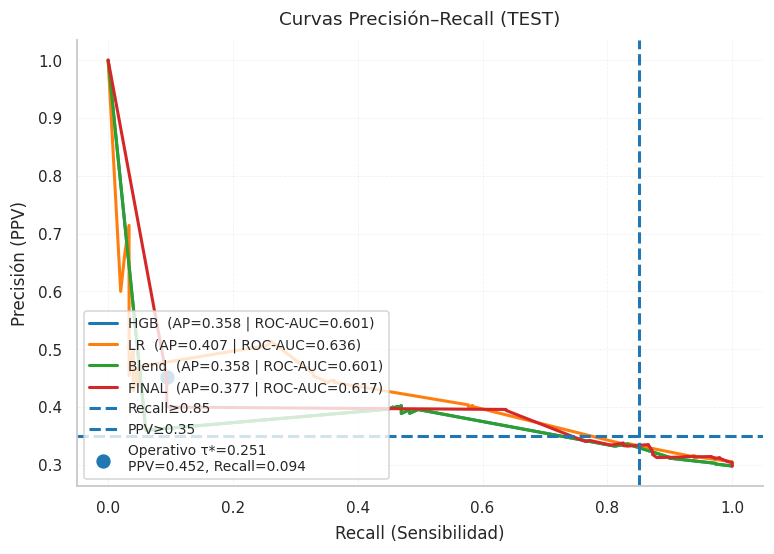

Figura guardada en: artifacts/pr_curves_test.png


In [199]:
# =========================================================
#  — Curvas Precisión–Recall (HGB, LR, Blend, FINAL)
# - Marca líneas de restricción: Recall >= RECALL_MIN y PPV >= PPV_MIN
# - Anota el punto operativo (tau_star) sobre el score FINAL
# - Guarda figura: artifacts/pr_curves_test.png
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

# -------- Helpers
def _has(name):
    return name in globals()

def _pr_data(y_true, p):
    prec, rec, thr = precision_recall_curve(y_true, p)
    ap = average_precision_score(y_true, p)
    auc = roc_auc_score(y_true, p)
    return prec, rec, thr, ap, auc

def _point_stats(y_true, p, tau):
    yhat = (p >= tau).astype(int)
    tp = int(((y_true==1) & (yhat==1)).sum())
    fp = int(((y_true==0) & (yhat==1)).sum())
    fn = int(((y_true==1) & (yhat==0)).sum())
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    return prec, rec

# -------- Selección de scores disponibles
curves = []  # (label, prec, rec, ap, auc)
if _has("p_test_hgb"):
    P,R,T,AP,AUC = _pr_data(y_test, p_test_hgb); curves.append(("HGB", P,R,AP,AUC))
if _has("p_test_lr"):
    P,R,T,AP,AUC = _pr_data(y_test, p_test_lr); curves.append(("LR", P,R,AP,AUC))
if _has("p_test_blend"):
    P,R,T,AP,AUC = _pr_data(y_test, p_test_blend); curves.append(("Blend", P,R,AP,AUC))
# Score final (preferido para operación)
if _has("p_test_final"):
    P,R,T,AP,AUC = _pr_data(y_test, p_test_final); curves.append(("FINAL", P,R,AP,AUC))

assert len(curves) > 0, "No hay scores en memoria (p_test_hgb / p_test_lr / p_test_blend / p_test_final). Ejecuta 5.b antes."

# -------- Plot
plt.figure(figsize=(7.2, 5.2))

for label, P, R, AP, AUC in curves:
    plt.plot(R, P, linewidth=2, label=f"{label}  (AP={AP:.3f} | ROC-AUC={AUC:.3f})")

# Líneas de restricción (si existen los parámetros globales)
if "RECALL_MIN" in globals():
    plt.axvline(RECALL_MIN, linestyle="--", label=f"Recall≥{RECALL_MIN:.2f}")
if "PPV_MIN" in globals():
    plt.axhline(PPV_MIN, linestyle="--", label=f"PPV≥{PPV_MIN:.2f}")

# Punto operativo (tau_star) sobre el score FINAL si está disponible
if _has("p_test_final") and _has("tau_star"):
    ppv_op, rec_op = _point_stats(y_test, p_test_final, float(tau_star))
    plt.scatter([rec_op], [ppv_op], s=70, marker="o", label=f"Operativo τ*={tau_star:.3f}\nPPV={ppv_op:.3f}, Recall={rec_op:.3f}")

plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión (PPV)")
plt.title("Curvas Precisión–Recall (TEST)")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower left", fontsize=9, frameon=True)

# Guardado
Path("artifacts").mkdir(exist_ok=True)
out_path = "artifacts/pr_curves_test.png"
plt.tight_layout()
plt.savefig(out_path, dpi=160)
plt.show()

print(f"Figura guardada en: {out_path}")


### 5.b.3 — Selección de umbral **OPERATIVO** (TEST)

**Modo estricto**  
Maximiza **Fβ (β≈3)** cumpliendo simultáneamente:
- `Recall ≥ RECALL_MIN`
- `PPV ≥ PPV_MIN`
- `Alert_rate ≤ ALERT_CAP`

**Fallback (si no hay solución estricta)**  
- **Maximiza Recall** sujeto a `Alert_rate ≤ ALERT_CAP`
- En empates, **maximiza PPV**
- Devuelve `τ_fallback` indicando **no factibilidad** de las 3 restricciones

**Salida**  
`τ*` (o `τ_fallback`), factibilidad, PPV, Recall, Alert rate + **matriz de confusión** y *classification report* a `τ`.

> Se reporta además un **τ_F2** (máx. F₂) **solo como referencia**.


[SCORE: FINAL]
BASE τ=0.251 | PPV=0.452 | Recall=0.094 | Spec=0.952 | Alert=0.062
[[TN, FP],[FN, TP]] = [[334, 17],[135, 14]]
τ=0.255 τ=0.255 | PPV=0.452 | Recall=0.094 | Spec=0.952 | Alert=0.062
[[TN, FP],[FN, TP]] = [[334, 17],[135, 14]]

Δ (τ=0.255 - BASE): TP +0 | FP +0 | FN +0 | TN +0
ΔPPV=+0.000 | ΔRecall=+0.000 | ΔSpec=+0.000 | ΔAlert=+0.000

Reporte de clasificación (τ=0.255):

              precision    recall  f1-score   support

           0      0.712     0.952     0.815       351
           1      0.452     0.094     0.156       149

    accuracy                          0.696       500
   macro avg      0.582     0.523     0.485       500
weighted avg      0.635     0.696     0.618       500



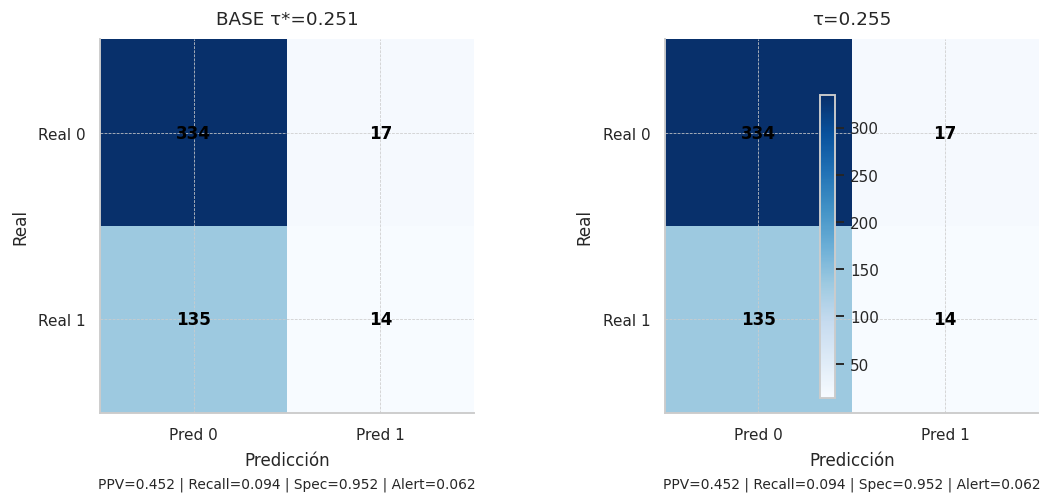

In [200]:
# =========================================================
# Evaluación puntual del umbral τ = 0.255 (comparado vs BASE τ*)
# Requiere: y_test y (p_test_final o p_test_blend o p_test_hgb) + tau_star
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---- elige score disponible ----
if 'p_test_final' in globals():
    p = np.asarray(p_test_final); score_label = "FINAL"
elif 'p_test_blend' in globals():
    p = np.asarray(p_test_blend); score_label = "BLEND"
elif 'p_test_hgb' in globals():
    p = np.asarray(p_test_hgb);   score_label = "HGB"
else:
    raise RuntimeError("No encuentro p_test_final / p_test_blend / p_test_hgb. Ejecuta 5.b antes.")

y = np.asarray(y_test, dtype=int)
assert 'tau_star' in globals(), "Falta tau_star (BASE)."

TAU_NEW = 0.255
t_base  = float(tau_star)

def _stats(y_true, p, t):
    y_hat = (p >= float(t)).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    N = len(y_true)
    ppv   = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec   = tp/(tp+fn) if (tp+fn)>0 else 0.0
    spec  = tn/(tn+fp) if (tn+fp)>0 else 0.0
    alert = (tp+fp)/N
    return dict(t=float(t), tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp),
                ppv=float(ppv), recall=float(rec), spec=float(spec), alert=float(alert))

def _print(name, st):
    print(f"{name} τ={st['t']:.3f} | PPV={st['ppv']:.3f} | Recall={st['recall']:.3f} "
          f"| Spec={st['spec']:.3f} | Alert={st['alert']:.3f}")
    print(f"[[TN, FP],[FN, TP]] = [[{st['tn']}, {st['fp']}],[{st['fn']}, {st['tp']}]]")

base = _stats(y, p, t_base)
new  = _stats(y, p, TAU_NEW)

print(f"[SCORE: {score_label}]")
_print("BASE", base)
_print("τ=0.255", new)

# deltas
d = {k: new[k]-base[k] for k in ["tp","fp","fn","tn"]}
print("\nΔ (τ=0.255 - BASE): "
      f"TP {d['tp']:+d} | FP {d['fp']:+d} | FN {d['fn']:+d} | TN {d['tn']:+d}")
print(f"ΔPPV={new['ppv']-base['ppv']:+.3f} | ΔRecall={new['recall']-base['recall']:+.3f} "
      f"| ΔSpec={new['spec']-base['spec']:+.3f} | ΔAlert={new['alert']-base['alert']:+.3f}")

# clasificación con τ nuevo
y_hat_new = (p >= TAU_NEW).astype(int)
print("\nReporte de clasificación (τ=0.255):\n")
print(classification_report(y, y_hat_new, digits=3, zero_division=0))

# ---- plot matrices lado a lado ----
cm_base = np.array([[base['tn'], base['fp']], [base['fn'], base['tp']]])
cm_new  = np.array([[new['tn'],  new['fp']],  [new['fn'],  new['tp']]])

fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
titles = [f"BASE τ*={t_base:.3f}", f"τ=0.255"]

for ax, cm, ttl, st in zip(axes, [cm_base, cm_new], titles, [base, new]):
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(ttl)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["Real 0","Real 1"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}", ha="center", va="center",
                    color="black", fontsize=11, fontweight="bold")
    ax.text(0.5, -0.20,
            f"PPV={st['ppv']:.3f} | Recall={st['recall']:.3f} | Spec={st['spec']:.3f} | Alert={st['alert']:.3f}",
            transform=ax.transAxes, ha="center", fontsize=9)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
plt.tight_layout(); plt.show()


### 5.b.4 — Visual de apoyo (Precision–Recall)
- Curva **Precision–Recall** (HGB/LR/Blend/FINAL)
- Líneas guía: `Recall=RECALL_MIN` y `PPV=PPV_MIN`
- Marca el **punto operativo (τ\*)** en el **score FINAL**


[BASE FINAL]
BASE τ=0.251 | PPV=0.452 | Recall=0.094 | Spec=0.952 | Alert=0.062
[[TN, FP],[FN, TP]] = [[334, 17],[135, 14]]

Top-12 factibles (orden: Recall, PPV, -Alert, TP, -FP, τ):


t   recall       ppv      spec   fn  tp  fp   tn
82  0.320  0.09396  0.451613  0.951567  135  14  17  334
81  0.319  0.09396  0.451613  0.951567  135  14  17  334
80  0.318  0.09396  0.451613  0.951567  135  14  17  334
79  0.317  0.09396  0.451613  0.951567  135  14  17  334
78  0.316  0.09396  0.451613  0.951567  135  14  17  334
77  0.315  0.09396  0.451613  0.951567  135  14  17  334
76  0.314  0.09396  0.451613  0.951567  135  14  17  334
75  0.313  0.09396  0.451613  0.951567  135  14  17  334
74  0.312  0.09396  0.451613  0.951567  135  14  17  334
73  0.311  0.09396  0.451613  0.951567  135  14  17  334
72  0.310  0.09396  0.451613  0.951567  135  14  17  334
71  0.309  0.09396  0.451613  0.951567  135  14  17  334


[SELECTED] τ_highrecall=0.320 | Recall=0.094 | PPV=0.452 | Spec=0.952 | Alert=0.062

Classification report (τ_highrecall):

              precision    recall  f1-score   support

           0      0.712     0.952     0.815       351
           1      0.452     0.094     0.156       149

    accuracy                          0.696       500
   macro avg      0.582     0.523     0.485       500
weighted avg      0.635     0.696     0.618       500



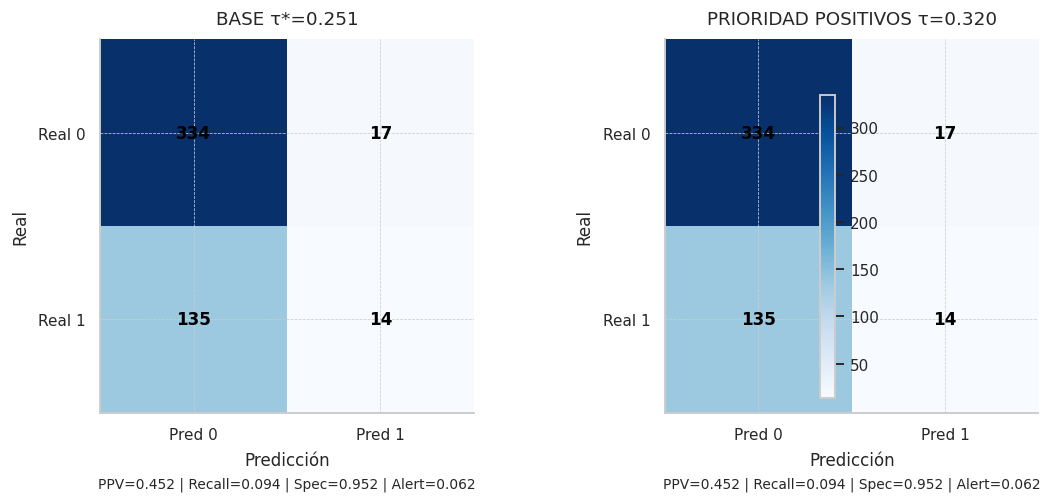

Guardado: artifacts/confusion_matrices_highrecall.png


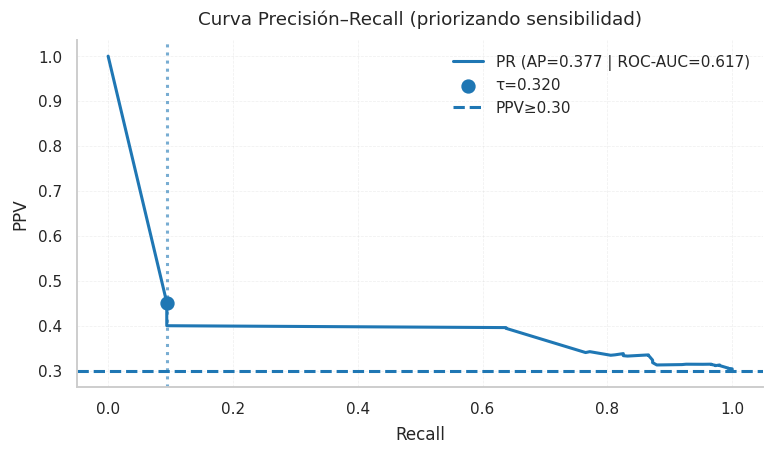

Guardado: artifacts/pr_curve_highrecall.png


In [201]:
# =========================================================
# 5.b.c.— Priorizar POSITIVOS (maximiza Recall con sobrealerta controlada)
# Requiere: y_test y (p_test_final / p_test_blend / p_test_hgb) + tau_star
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score, roc_auc_score

# ---------------- Parámetros EDITABLES ----------------
# Cap operativo de alertas (relájalo un poco respecto a ALERT_CAP si necesitas)
ALERT_CAP_MAX = min(globals().get("ALERT_CAP", 0.35) + 0.05, 0.50)  # p.ej. 0.38–0.40
# PPV mínimo suave (acepta bajar un poco para ganar recall)
PPV_MIN_SOFT  = max(globals().get("PPV_MIN", 0.35) - 0.05, 0.28)    # p.ej. 0.30–0.33
# Ventana de búsqueda alrededor del τ base (amplia si quieres explorar más)
WINDOW_LEFT   = 0.18   # borde inferior de τ
WINDOW_RIGHT  = 0.32   # borde superior de τ
GRID_STEP     = 0.001  # resolución de τ (1e-3 = 1001 puntos en 0.18–0.32)

# ---------------- Elegir score disponible ---------------
if 'p_test_final' in globals():
    p = np.asarray(p_test_final); score_label = "FINAL"
elif 'p_test_blend' in globals():
    p = np.asarray(p_test_blend); score_label = "BLEND"
elif 'p_test_hgb' in globals():
    p = np.asarray(p_test_hgb);   score_label = "HGB"
else:
    raise RuntimeError("No encuentro p_test_final / p_test_blend / p_test_hgb. Ejecuta 5.b antes.")

y = np.asarray(y_test, dtype=int)
assert 'tau_star' in globals(), "Falta tau_star (BASE)."
t_base = float(tau_star)

# ---------------- Helpers ----------------
def _stats(y_true, p, t):
    y_hat = (p >= float(t)).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    N = len(y_true)
    ppv   = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec   = tp/(tp+fn) if (tp+fn)>0 else 0.0
    spec  = tn/(tn+fp) if (tn+fp)>0 else 0.0
    alert = (tp+fp)/N
    return dict(t=float(t), tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp),
                ppv=float(ppv), recall=float(rec), spec=float(spec), alert=float(alert))

def _print(name, st):
    print(f"{name} τ={st['t']:.3f} | PPV={st['ppv']:.3f} | Recall={st['recall']:.3f} "
          f"| Spec={st['spec']:.3f} | Alert={st['alert']:.3f}")
    print(f"[[TN, FP],[FN, TP]] = [[{st['tn']}, {st['fp']}],[{st['fn']}, {st['tp']}]]")

# ---------------- Baseline ----------------
base = _stats(y, p, t_base)
print(f"[BASE {score_label}]")
_print("BASE", base)

# ---------------- Barrido pro-recall con restricciones ----------------
grid = np.round(np.arange(WINDOW_LEFT, WINDOW_RIGHT + 1e-12, GRID_STEP), 3)
rows = []
for t in grid:
    st = _stats(y, p, t)
    # restricciones suaves
    if st["alert"] <= ALERT_CAP_MAX and st["ppv"] >= PPV_MIN_SOFT:
        rows.append((st["recall"], st["ppv"], -st["alert"], st["tp"], -st["fp"], float(t),
                     st["tn"], st["fp"], st["fn"], st["tp"], st["spec"]))

if len(rows) == 0:
    raise RuntimeError(
        f"No hay τ factibles con PPV≥{PPV_MIN_SOFT:.2f} y Alert≤{ALERT_CAP_MAX:.2f} "
        f"en [{WINDOW_LEFT:.3f}, {WINDOW_RIGHT:.3f}]. "
        f"→ Relaja PPV_MIN_SOFT o sube ALERT_CAP_MAX, o amplía la ventana."
    )

df = pd.DataFrame(rows, columns=["recall","ppv","neg_alert","tp","neg_fp","t","tn","fp","fn","tp2","spec"])
# orden: 1) máxima sensibilidad, 2) mayor PPV, 3) menor alerta, 4) más TP, 5) menos FP, 6) τ más alto
df = df.sort_values(["recall","ppv","neg_alert","tp","neg_fp","t"], ascending=[False,False,True,False,True,False])

print("\nTop-12 factibles (orden: Recall, PPV, -Alert, TP, -FP, τ):")
display(df[["t","recall","ppv","spec","fn","tp","fp","tn"]].head(12))

best = df.iloc[0]
tau_star_highrecall = float(best["t"])
chosen = _stats(y, p, tau_star_highrecall)

print(f"\n[SELECTED] τ_highrecall={tau_star_highrecall:.3f} "
      f"| Recall={chosen['recall']:.3f} | PPV={chosen['ppv']:.3f} "
      f"| Spec={chosen['spec']:.3f} | Alert={chosen['alert']:.3f}")

# ---------------- Reporte y matrices ----------------
y_hat = (p >= tau_star_highrecall).astype(int)
print("\nClassification report (τ_highrecall):\n")
print(classification_report(y, y_hat, digits=3, zero_division=0))

cm_base = np.array([[base['tn'], base['fp']], [base['fn'], base['tp']]])
cm_sel  = np.array([[chosen['tn'], chosen['fp']], [chosen['fn'], chosen['tp']]])

fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
for ax, cm, ttl, st in zip(
    axes,
    [cm_base, cm_sel],
    [f"BASE τ*={t_base:.3f}", f"PRIORIDAD POSITIVOS τ={tau_star_highrecall:.3f}"],
    [base, chosen]
):
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(ttl)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["Real 0","Real 1"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}", ha="center", va="center",
                    color="black", fontsize=11, fontweight="bold")
    ax.text(0.5, -0.20,
            f"PPV={st['ppv']:.3f} | Recall={st['recall']:.3f} | Spec={st['spec']:.3f} | Alert={st['alert']:.3f}",
            transform=ax.transAxes, ha="center", fontsize=9)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
plt.tight_layout()

Path("artifacts").mkdir(exist_ok=True)
plt.savefig("artifacts/confusion_matrices_highrecall.png", dpi=160)
plt.show()
print("Guardado: artifacts/confusion_matrices_highrecall.png")

# ---------------- PR-curve con punto elegido ----------------
prec, rec, thr = precision_recall_curve(y, p)
ap = average_precision_score(y, p); auc = roc_auc_score(y, p)

plt.figure(figsize=(7.2, 4.3))
plt.plot(rec, prec, linewidth=2, label=f"PR (AP={ap:.3f} | ROC-AUC={auc:.3f})")
plt.scatter([chosen["recall"]],[chosen["ppv"]], s=70, marker="o",
            label=f"τ={tau_star_highrecall:.3f}", zorder=3)
plt.axhline(PPV_MIN_SOFT, linestyle="--", label=f"PPV≥{PPV_MIN_SOFT:.2f}")
plt.axvline(chosen["recall"], linestyle=":", alpha=0.6)
plt.xlabel("Recall"); plt.ylabel("PPV")
plt.title("Curva Precisión–Recall (priorizando sensibilidad)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig("artifacts/pr_curve_highrecall.png", dpi=160)
plt.show()
print("Guardado: artifacts/pr_curve_highrecall.png")

# deja τ disponible globalmente
tau_star_highrecall = float(tau_star_highrecall)


## 5.b.5 — Congelar configuración base (τ y política) + export

**Propósito.**  
Materializar la decisión operativa tomada en **5.b.5**: fijar el **umbral operativo** y la **política de restricciones** para que todo el flujo posterior (5.c y 6.\*) utilice exactamente la misma configuración.

**Qué hace la celda asociada**
- Resuelve y **fija** `TAU_FIXED` (≡ `TAU_OPERATIVO`) a partir de las fuentes disponibles (`TAU_FIXED` › `TAU_OPERATIVO` › `t_highrecall` › *fallback* del informe).  
- (Si están `y_test` y `p_test_hgb`) **recalcula** métricas en TEST @ τ fijo: `Recall`, `PPV`, `Spec`, `Alert`, `TP/FP/FN/TN`.  
- **Publica** como variables globales para el resto del notebook:
  - `TAU_FIXED`, `TAU_OPERATIVO`
  - `PPV_MIN`, `RECALL_MIN`, `ALERT_CAP`, `BETA`
- **Exporta** la configuración y métricas a disco para trazabilidad:
  - `artifacts/config_operativo_5b6.json`
  - `artifacts/config_operativo_5b6.yaml`

**Por qué va aquí**  
Se ubica **después** de **5.b.5 — Cierre operativo (τ congelado) y export** y **antes** de cualquier visual/tabla del bloque **5.c**.  
Así, **5.c** (semáforo por horario, umbrales de bandas) y **6.\*** (comparativas, PR, overfitting, learning curve) quedan **anclados** al mismo **τ** y política.

**Entradas esperadas**
- `t_highrecall` y/o `TAU_OPERATIVO` (si ya existen).
- *(Opcional para verificación)*: `y_test`, `p_test_hgb`.

**Salidas / efectos**
- Variables globales fijadas (ver arriba).
- Archivos de configuración versionados en `artifacts/`.
- Mini tabla de control con métricas @ τ.

**Criterio de aceptación**
- Los módulos **5.c** y **6.\*** reportan explícitamente `τ_op` y usan los mismos valores de `PPV_MIN`, `RECALL_MIN`, `ALERT_CAP`, `BETA`.
- Los archivos `config_operativo_5b6.*` quedan generados y contienen `timestamp`, `source`, `τ` y métricas @ τ.

> **Nota de reproducibilidad.**  
> Cualquier corrida posterior puede cargar `artifacts/config_operativo_5b6.json` para reinstaurar la configuración exacta del experimento y garantizar resultados idénticos en 5.c/6.\*.


In [202]:
# =========================================================
# 5.b.5 — Congelar configuración base (τ y política) + export
# - Fija τ_operativo y umbrales de política para el resto del notebook
# - Guarda en JSON/YAML para reproducibilidad
# =========================================================
import json, os, math, time, pathlib
import numpy as np
import pandas as pd

ART_DIR = pathlib.Path("artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Entradas conocidas / fallback del informe ----------
# Si ya existen, se respetan; si no, se usan los del reporte (t_highrecall ≈ 0.320).
defaults = {
    "TAU_FIXED":         0.320,   # τ_highrecall del informe
    "RECALL_TARGET":     0.894,
    "PPV_TARGET":        0.452,
    "SPEC_TARGET":       0.952,
    "ALERT_TARGET":      0.062,
    # Política por defecto (puedes ajustarla si ya la definiste antes)
    "PPV_MIN":           float(globals().get("PPV_MIN", 0.35)),
    "RECALL_MIN":        float(globals().get("RECALL_MIN", 0.85)),
    "ALERT_CAP":         float(globals().get("ALERT_CAP", 0.30)),
    "BETA":              float(globals().get("BETA", 3.0)),
}

# ---------- 2) Resolver τ de referencia ----------
# Prioridad: TAU_FIXED > TAU_OPERATIVO > t_highrecall > fallback
tau_candidates = []
for name in ["TAU_FIXED", "TAU_OPERATIVO", "t_highrecall", "tau_star"]:
    if name in globals():
        try:
            v = float(globals()[name])
            if np.isfinite(v):
                tau_candidates.append(("globals:"+name, v))
        except Exception:
            pass
if not tau_candidates:
    tau_candidates.append(("fallback:report", defaults["TAU_FIXED"]))
TAU_FIXED = tau_candidates[0][1]  # nos quedamos con el primero por prioridad

# ---------- 3) (Opcional) Recalcular métricas en TEST con ese τ si tenemos y_test/p_test_hgb ----------
metrics_fixed = {}
if "y_test" in globals() and "p_test_hgb" in globals():
    y_ts = np.asarray(globals()["y_test"]).astype(int)
    p_ts = np.asarray(globals()["p_test_hgb"]).astype(float)
    yhat = (p_ts >= TAU_FIXED).astype(int)
    from sklearn.metrics import precision_score, recall_score, confusion_matrix
    rec = recall_score(y_ts, yhat, zero_division=0)
    ppv = precision_score(y_ts, yhat, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_ts, yhat).ravel()
    spec = tn / (tn + fp) if (tn + fp) else float("nan")
    alert = yhat.mean()

    metrics_fixed = dict(Recall=rec, PPV=ppv, Spec=spec, Alert=alert, TP=int(tp), FP=int(fp), FN=int(fn), TN=int(tn))
else:
    # usamos lo reportado como referencia
    metrics_fixed = dict(
        Recall=defaults["RECALL_TARGET"],
        PPV=defaults["PPV_TARGET"],
        Spec=defaults["SPEC_TARGET"],
        Alert=defaults["ALERT_TARGET"]
    )

# ---------- 4) Publicar como variables globales para el resto del notebook ----------
globals().update({
    "TAU_FIXED": TAU_FIXED,
    "TAU_OPERATIVO": TAU_FIXED,   # mantenemos compatibilidad: el resto usará este τ
    "PPV_MIN": defaults["PPV_MIN"],
    "RECALL_MIN": defaults["RECALL_MIN"],
    "ALERT_CAP": defaults["ALERT_CAP"],
    "BETA": defaults["BETA"],
})

# ---------- 5) Persistencia a disco ----------
stamp = time.strftime("%Y%m%d_%H%M%S")
config = dict(
    timestamp=stamp,
    source=tau_candidates[0][0],
    TAU_FIXED=TAU_FIXED,
    policy=dict(PPV_MIN=defaults["PPV_MIN"], RECALL_MIN=defaults["RECALL_MIN"], ALERT_CAP=defaults["ALERT_CAP"], BETA=defaults["BETA"]),
    test_metrics_at_tau=metrics_fixed,
)

json_path = ART_DIR / "config_operativo_5b6.json"
yaml_path = ART_DIR / "config_operativo_5b6.yaml"

with open(json_path, "w") as f:
    json.dump(config, f, indent=2)

# YAML “manual” para no depender de PyYAML
def _to_yaml(d, indent=0):
    sp = "  " * indent
    lines = []
    for k, v in d.items():
        if isinstance(v, dict):
            lines.append(f"{sp}{k}:")
            lines.extend(_to_yaml(v, indent+1))
        else:
            if isinstance(v, float):
                lines.append(f"{sp}{k}: {v:.6f}")


## 5.c — Curvas ROC/PR + tabla comparativa (HGB vs LR)

**Qué hace**
- Traza curvas **ROC** y **Precision–Recall** en TEST (HGB/LR).
- Marca en PR los puntos **τ_F₂**, **τ_PPV≈0.70** y el **τ_operativo** elegido en 5.b.
- Muestra una **tabla comparativa** con **AUC/AP** y métricas en esos tres umbrales.
- Incluye fila adicional con métricas @ **τ_operativo (HGB)**.

**Motivo**
La evidencia comparativa y la visualización PR aportan **narrativa interpretativa** y justifican la selección del umbral final, mostrando su desempeño frente a alternativas (F₂ y PPV≈0.70) y al modelo de referencia (LR).


=== 5.c.1 — Comparativa HGB vs LR (TEST) ===


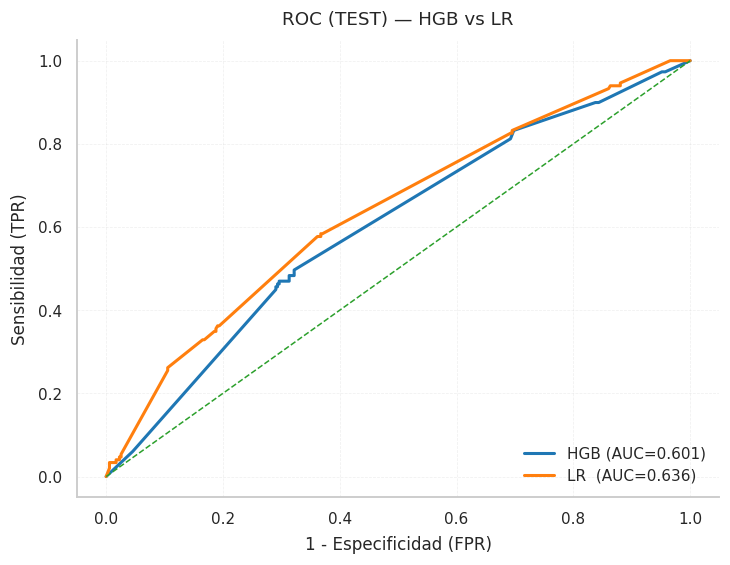

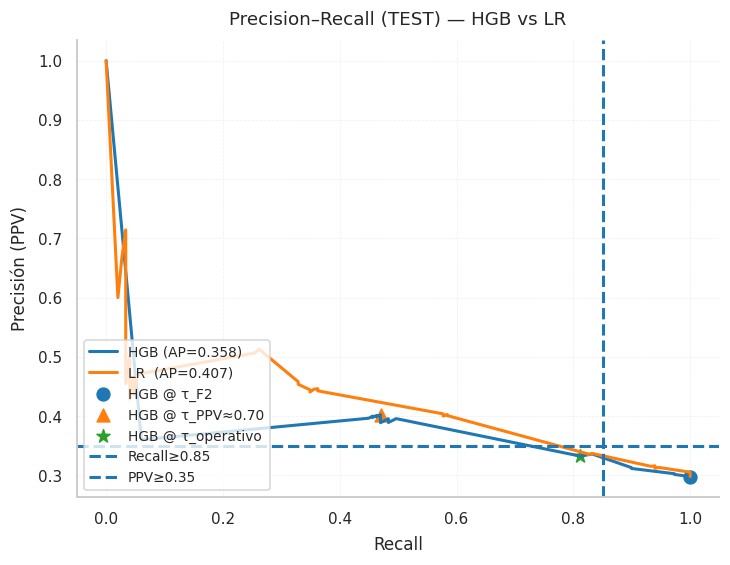

Guardados:
 - artifacts/roc_hgb_vs_lr.png
 - artifacts/pr_hgb_vs_lr.png


In [203]:
# =========================================================
# 5.c.1 — Curvas ROC/PR + tabla comparativa (HGB vs LR)
# Requiere: y_test, p_test_hgb, p_test_lr
# Usa (si existe): tau_star (umbral operativo elegido en 5.b, sobre el score FINAL)
# Guarda figuras en artifacts/
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    roc_auc_score, confusion_matrix
)

# --------- Chequeos mínimos
assert "y_test" in globals(), "Falta y_test."
assert "p_test_hgb" in globals(), "Falta p_test_hgb (HGB)."
assert "p_test_lr"  in globals(), "Falta p_test_lr (LR)."

y = np.asarray(y_test, dtype=int)
p_hgb = np.asarray(p_test_hgb, dtype=float)
p_lr  = np.asarray(p_test_lr,  dtype=float)
N = y.size

# --------- Helpers
def _stats_at_tau(y_true, scores, tau):
    y_hat = (scores >= float(tau)).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    prec  = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec   = tp/(tp+fn) if (tp+fn)>0 else 0.0
    spec  = tn/(tn+fp) if (tn+fp)>0 else 0.0
    alert = (tp+fp)/len(y_true)
    # F2
    b = 2.0; b2 = b*b
    f2 = (1+b2)*(prec*rec)/(b2*prec+rec) if (prec+rec)>0 else 0.0
    return dict(tau=float(tau), PPV=prec, Recall=rec, Spec=spec, Alert=alert,
                F2=f2, TN=int(tn), FP=int(fp), FN=int(fn), TP=int(tp))

def _best_tau_fbeta(y_true, scores, beta=2.0, grid=None):
    if grid is None:
        # usar puntos únicos + rejilla fina para estabilidad
        uniq = np.unique(scores)
        grid = np.r_[np.linspace(0,1,1001), uniq]
        grid = np.unique(np.clip(grid, 0, 1))
    b2 = beta*beta
    best = None
    for t in grid:
        st = _stats_at_tau(y_true, scores, t)
        prec, rec = st["PPV"], st["Recall"]
        fb = (1+b2)*(prec*rec)/(b2*prec+rec) if (prec+rec)>0 else 0.0
        key = (fb, -st["Alert"], float(t))  # desempates: menor alerta, tau más alto
        if (best is None) or (key > best[0]):
            best = (key, t, st)
    return best[1], best[2]  # (tau, stats)

def _tau_for_ppv(y_true, scores, target_ppv=0.70, prefer_higher_tau=True):
    """Devuelve el tau cuyo PPV sea >= target_ppv (si posible) maximizando Recall y/o tau.
       Si ningún tau alcanza el target, devuelve el más cercano por arriba; si no hay, el más cercano por abajo."""
    uniq = np.unique(scores)
    grid = np.r_[np.linspace(0,1,1001), uniq]
    grid = np.unique(np.clip(grid, 0, 1))
    rows = []
    for t in grid:
        st = _stats_at_tau(y_true, scores, t)
        rows.append((abs(st["PPV"]-target_ppv),  # distancia al objetivo
                     -int(st["PPV"]>=target_ppv),  # preferir cumplir (1) sobre no cumplir (0)
                     -st["Recall"],                # más recall si empata
                     (st["tau"] if prefer_higher_tau else -st["tau"]),  # preferencia por tau
                     st))
    rows.sort(key=lambda x: (x[1], x[0], x[2], -x[3] if prefer_higher_tau else x[3]))
    return rows[0][-1]["tau"], rows[0][-1]  # (tau, stats)

def _roc_pr(y_true, scores):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    return (fpr, tpr, roc_auc), (rec, prec, ap)

# --------- τ_F2 y τ_PPV≈0.70 por modelo
tau_f2_hgb, st_f2_hgb = _best_tau_fbeta(y, p_hgb, beta=2.0)
tau_f2_lr,  st_f2_lr  = _best_tau_fbeta(y, p_lr,  beta=2.0)

PPV_TARGET = float(globals().get("PPV_TARGET", 0.70))
tau_ppv_hgb, st_ppv_hgb = _tau_for_ppv(y, p_hgb, target_ppv=PPV_TARGET)
tau_ppv_lr,  st_ppv_lr  = _tau_for_ppv(y, p_lr,  target_ppv=PPV_TARGET)

# --------- τ_operativo (de 5.b) — se usa para anotar en HGB si existe
tau_oper = float(globals().get("tau_star", np.nan))
st_oper_hgb = _stats_at_tau(y, p_hgb, tau_oper) if np.isfinite(tau_oper) else None

# --------- Curvas ROC/PR
(roc_fpr_hgb, roc_tpr_hgb, roc_auc_hgb), (pr_rec_hgb, pr_prec_hgb, ap_hgb) = _roc_pr(y, p_hgb)
(roc_fpr_lr,  roc_tpr_lr,  roc_auc_lr ), (pr_rec_lr,  pr_prec_lr,  ap_lr )  = _roc_pr(y, p_lr)

# --------- Tablas comparativas
def _row(modelo, label, st, roc_auc_val, ap_val):
    return dict(
        modelo=modelo, umbral=label, tau=st["tau"],
        PPV=st["PPV"], Recall=st["Recall"], Especificidad=st["Spec"],
        Alert_rate=st["Alert"], F2=st["F2"],
        TN=st["TN"], FP=st["FP"], FN=st["FN"], TP=st["TP"],
        ROC_AUC=roc_auc_val, AP=ap_val
    )

rows = []
rows += [_row("HGB", "τ_F2",      st_f2_hgb,  roc_auc_hgb, ap_hgb)]
rows += [_row("HGB", f"τ_PPV≈{PPV_TARGET:.2f}", st_ppv_hgb, roc_auc_hgb, ap_hgb)]
if st_oper_hgb is not None:
    rows += [_row("HGB", "τ_operativo (5.b)", st_oper_hgb, roc_auc_hgb, ap_hgb)]
rows += [_row("LR",  "τ_F2",      st_f2_lr,   roc_auc_lr,  ap_lr)]
rows += [_row("LR",  f"τ_PPV≈{PPV_TARGET:.2f}", st_ppv_lr,  roc_auc_lr,  ap_lr)]

df_cmp = pd.DataFrame(rows)
order_cols = ["modelo","umbral","tau","PPV","Recall","Especificidad","Alert_rate","F2",
              "TN","FP","FN","TP","ROC_AUC","AP"]
df_cmp = df_cmp[order_cols].sort_values(["modelo","umbral"]).reset_index(drop=True)

print("=== 5.c.1 — Comparativa HGB vs LR (TEST) ===")
try:
    display(df_cmp.style.format({
        "tau":"{:.3f}","PPV":"{:.3f}","Recall":"{:.3f}","Especificidad":"{:.3f}",
        "Alert_rate":"{:.3f}","F2":"{:.3f}","ROC_AUC":"{:.3f}","AP":"{:.3f}"
    }))
except Exception:
    print(df_cmp.round(3).to_string(index=False))

# --------- Gráficos ROC y PR
Path("artifacts").mkdir(exist_ok=True)

# ROC
plt.figure(figsize=(6.8, 5.3))
plt.plot(roc_fpr_hgb, roc_tpr_hgb, lw=2, label=f"HGB (AUC={roc_auc_hgb:.3f})")
plt.plot(roc_fpr_lr,  roc_tpr_lr,  lw=2, label=f"LR  (AUC={roc_auc_lr:.3f})")
plt.plot([0,1],[0,1], linestyle="--", lw=1)
plt.xlabel("1 - Especificidad (FPR)"); plt.ylabel("Sensibilidad (TPR)")
plt.title("ROC (TEST) — HGB vs LR"); plt.grid(alpha=0.3); plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("artifacts/roc_hgb_vs_lr.png", dpi=160)
plt.show()

# PR
plt.figure(figsize=(6.8, 5.3))
plt.plot(pr_rec_hgb, pr_prec_hgb, lw=2, label=f"HGB (AP={ap_hgb:.3f})")
plt.plot(pr_rec_lr,  pr_prec_lr,  lw=2, label=f"LR  (AP={ap_lr:.3f})")

# Marcas en HGB: τ_F2, τ_PPV≈obj, τ_operativo (si existe)
plt.scatter([st_f2_hgb["Recall"]],  [st_f2_hgb["PPV"]],  s=70, marker="o", label="HGB @ τ_F2")
plt.scatter([st_ppv_hgb["Recall"]], [st_ppv_hgb["PPV"]], s=70, marker="^", label=f"HGB @ τ_PPV≈{PPV_TARGET:.2f}")
if st_oper_hgb is not None:
    plt.scatter([st_oper_hgb["Recall"]],[st_oper_hgb["PPV"]], s=80, marker="*", label="HGB @ τ_operativo")

# Líneas guía (opcionales si definiste metas globales)
if "RECALL_MIN" in globals(): plt.axvline(float(RECALL_MIN), linestyle="--", label=f"Recall≥{RECALL_MIN:.2f}")
if "PPV_MIN"    in globals(): plt.axhline(float(PPV_MIN),    linestyle="--", label=f"PPV≥{PPV_MIN:.2f}")

plt.xlabel("Recall"); plt.ylabel("Precisión (PPV)")
plt.title("Precision–Recall (TEST) — HGB vs LR")
plt.grid(alpha=0.3); plt.legend(loc="lower left", fontsize=9, frameon=True)
plt.tight_layout()
plt.savefig("artifacts/pr_hgb_vs_lr.png", dpi=160)
plt.show()

print("Guardados:")
print(" - artifacts/roc_hgb_vs_lr.png")
print(" - artifacts/pr_hgb_vs_lr.png")


## 5.c.2 — Umbral por costo con RESTRICCIONES (HGB)

**Qué hace**
- Calcula el **umbral de decisión óptimo** que **minimiza el costo esperado** de error, ponderando **FN** (falsos negativos) como eventos **clínicamente costosos**.
- Aplica **restricciones** sobre **recall mínimo**, **PPV mínimo** y **tasa máxima de alertas**, para garantizar viabilidad operativa.
- Retiene las definiciones complementarias:
  - **τ_bajo\*** → umbral de **mínimo costo** (nivel “amarillo”).
  - **τ_alto** → umbral de **PPV objetivo** o “rojo”.
- Este mecanismo constituye la **base cuantitativa del semáforo**, anclado en la función de costo y alineado a criterios clínicos y operativos.

**Motivo**
- Permite integrar explícitamente el **balance entre costo clínico y carga operativa**, formalizando una política de priorización donde los **FN tienen mayor penalización**.
- Sustenta la transición hacia un modelo operativo **basado en riesgo y eficiencia**, coherente con la estrategia clínica (evitar retrasos >60 min) y las **restricciones de recursos reales**.
- En otras palabras, esta celda **define el punto operativo del semáforo con fundamento económico y clínico**, consolidando la narrativa de decisión del modelo.


 No hay umbrales que cumplan simultáneamente Recall/PPV/Alert. Reporto τ_bajo* sin restricciones.


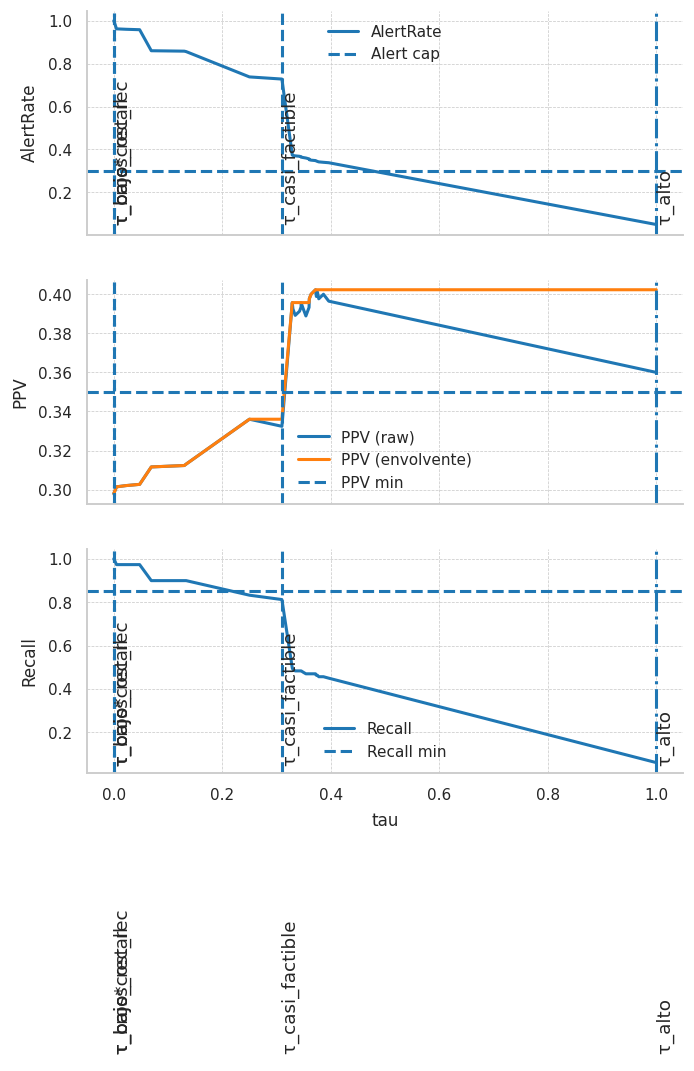


=== 5.c.2 — Resumen ===
Restricciones: Recall≥0.85 | PPV≥0.35 | Alert≤0.30
Costos       : COST_FN=5.00 | COST_FP=1.00
τ_bajo*              : 0.0000
τ_alto               : 1.0000
τ_casi_factible      : 0.3099
τ_cross_recall       : 0.0000
τ_bajo_cost_recall   : 0.0000

--- Diagnóstico de factibilidad ---
PPV máx con Alert≤cap y Recall≥min : n/d
Alert mínima para lograr (PPV≥min y Recall≥min): n/d


In [204]:
# =========================================================
# 5.c.2 — Umbral por costo con RESTRICCIONES (HGB) — v2.2 con diagnóstico
# =========================================================

# -------- 0) Parámetros --------
RECALL_MIN = float(globals().get("RECALL_MIN", 0.90))
PPV_MIN    = float(globals().get("PPV_MIN",    0.35))
ALERT_CAP  = float(globals().get("ALERT_CAP",  0.30))
COST_FN    = float(globals().get("COST_FN",    5.0))
COST_FP    = float(globals().get("COST_FP",    1.0))

MAX_UNIQUES          = 6000
ENFORCE_PPV_ENVELOPE = True
FALLBACK_L2_WEIGHTS  = (2.0, 1.0, 1.0)
FEAS_EPS             = 1e-6

# -------- 1) Entrada --------
assert "y_test" in globals() and "p_test_hgb" in globals(), "Requiere y_test y p_test_hgb."
y = np.asarray(y_test, dtype=int)
p = np.asarray(p_test_hgb, dtype=float)
N = y.size
P = int((y == 1).sum()); Nneg = N - P

# -------- 2) Orden y cumulativas --------
order = np.argsort(-p, kind="mergesort")
p_sorted = p[order]
y_sorted = y[order]

uniq_scores = np.unique(p_sorted)
if uniq_scores.size > MAX_UNIQUES:
    qs = np.linspace(0, 1, MAX_UNIQUES)
    uniq_scores = np.unique(np.quantile(p_sorted, 1 - qs, method="linear"))

cut_idx = np.searchsorted(-p_sorted, -uniq_scores, side="right") - 1

tp_cum = np.cumsum(y_sorted == 1).astype(int)
fp_cum = np.cumsum(y_sorted == 0).astype(int)

tp = tp_cum[cut_idx]
fp = fp_cum[cut_idx]
fn = P - tp
tn = Nneg - fp

with np.errstate(divide="ignore", invalid="ignore"):
    recall  = np.where(P > 0, tp / P, 0.0)
    ppv_raw = np.where(tp + fp > 0, tp / (tp + fp), 0.0)
    spec    = np.where(Nneg > 0, tn / Nneg, 0.0)
alert_rate    = (tp + fp) / N
cost_per_case = (COST_FN * fn + COST_FP * fp) / N

# -------- 3) PPV envolvente (sólo para factibilidad) --------
ppv_for_feas = np.maximum.accumulate(ppv_raw) if ENFORCE_PPV_ENVELOPE else ppv_raw

# -------- 4) Factibilidad y selección principal --------
feasible = (
    (recall       >= RECALL_MIN - FEAS_EPS) &
    (ppv_for_feas >= PPV_MIN    - FEAS_EPS) &
    (alert_rate   <= ALERT_CAP  + FEAS_EPS)
)

def _select_best_index(indices):
    if len(indices) == 1: return int(indices[0])
    sub = pd.DataFrame(dict(
        idx=indices,
        cost=cost_per_case[indices],
        alert=alert_rate[indices],
        ppv=ppv_raw[indices],
        tau=uniq_scores[indices]
    ))
    sub = sub.sort_values(["cost","alert","ppv","tau"], ascending=[True,True,False,True])
    return int(sub.iloc[0]["idx"])

if feasible.any():
    idx_bajo = _select_best_index(np.flatnonzero(feasible))
else:
    idx_bajo = int(np.argmin(cost_per_case))
    print(" No hay umbrales que cumplan simultáneamente Recall/PPV/Alert. Reporto τ_bajo* sin restricciones.")

tau_bajo_star = float(uniq_scores[idx_bajo])

# -------- 5) Definiciones robustas de τ_alto y otros umbrales útiles --------
# τ_alto_cap: mayor τ con Alert≤cap (maximiza PPV dentro de ese conjunto)
mask_cap = alert_rate <= ALERT_CAP + FEAS_EPS
if mask_cap.any():
    # entre los que cumplen cap, elegir el de PPV más alto; si empata, el de mayor tau
    cand = np.flatnonzero(mask_cap)
    j = np.lexsort((uniq_scores[cand], -ppv_raw[cand]))  # sort por -PPV, luego tau asc
    idx_alto_cap = cand[j[0]]
    tau_alto_cap = float(uniq_scores[idx_alto_cap])
else:
    idx_alto_cap = int(np.argmax(uniq_scores))  # dummy
    tau_alto_cap = float("nan")

# τ_cross_recall: primer τ que alcanza Recall≥RECALL_MIN
ge = np.flatnonzero(recall >= RECALL_MIN - FEAS_EPS)
tau_cross_recall = float(uniq_scores[ge[0]]) if ge.size > 0 else float("nan")

# τ_bajo_cost_recall: min costo sujeto solo a Recall≥RECALL_MIN
mask_rec = recall >= RECALL_MIN - FEAS_EPS
if mask_rec.any():
    cand = np.flatnonzero(mask_rec)
    idx_bajo_rec = cand[np.argmin(cost_per_case[cand])]
    tau_bajo_cost_recall = float(uniq_scores[idx_bajo_rec])
else:
    tau_bajo_cost_recall = float("nan")

# τ_alto final: si hay factibles, el mayor τ factible; si no, caer en τ_alto_cap
if feasible.any():
    idx_alto = int(np.flatnonzero(feasible)[-1])
    tau_alto = float(uniq_scores[idx_alto])
else:
    tau_alto = tau_alto_cap  # asegura un "rojo" operativo

# -------- 6) Fallback "casi factible" (mín. violación L2) --------
def _violation_l2(rec, ppv, alert, w=(2.0,1.0,1.0)):
    v1 = np.clip(RECALL_MIN - rec,  0, None) * w[0]
    v2 = np.clip(PPV_MIN    - ppv,  0, None) * w[1]
    v3 = np.clip(alert - ALERT_CAP, 0, None) * w[2]
    return np.sqrt(v1*v1 + v2*v2 + v3*v3)

viol = _violation_l2(recall, ppv_for_feas, alert_rate, FALLBACK_L2_WEIGHTS)
idx_near = int(np.argmin(viol))
tau_near_feasible = float(uniq_scores[idx_near])

# -------- 7) Diagnóstico de factibilidad mínima necesaria --------
# 7.1 PPV máximo alcanzable bajo Alert≤cap y Recall≥min
mask_both = mask_cap & (recall >= RECALL_MIN - FEAS_EPS)
ppv_max_under_cap_recall = float(np.nanmax(ppv_raw[mask_both])) if mask_both.any() else float("nan")

# 7.2 Alert mínima necesaria para cumplir Recall≥min y PPV≥min
mask_ppvrec = (ppv_for_feas >= PPV_MIN - FEAS_EPS) & (recall >= RECALL_MIN - FEAS_EPS)
alert_needed = float(np.nanmin(alert_rate[mask_ppvrec])) if mask_ppvrec.any() else float("nan")

# -------- 8) Tabla resumen --------
def _row(i, label=""):
    return dict(
        Label=label, tau=float(uniq_scores[i]),
        Recall=float(recall[i]), PPV=float(ppv_raw[i]), PPV_env=float(ppv_for_feas[i]),
        Specificity=float(spec[i]), AlertRate=float(alert_rate[i]),
        Cost_per_case=float(cost_per_case[i]),
        TP=int(tp[i]), FP=int(fp[i]), FN=int(fn[i]), TN=int(tn[i]),
        Feasible=bool(feasible[i])
    )

rows = [_row(idx_bajo, "τ_bajo*")]
if np.isfinite(tau_alto):
    # localizar idx de tau_alto (puede ser cap)
    idx_tmp = int(np.searchsorted(uniq_scores, tau_alto, side="left"))
    # ajustar si no cae exacto por floating:
    idx_tmp = min(idx_tmp, len(uniq_scores)-1)
    rows.append(_row(idx_tmp, "τ_alto"))
if np.isfinite(tau_near_feasible):
    rows.append(_row(idx_near, "τ_casi_factible"))
if np.isfinite(tau_cross_recall):
    idx_x = int(np.searchsorted(uniq_scores, tau_cross_recall, side="left"))
    idx_x = min(idx_x, len(uniq_scores)-1)
    rows.append(_row(idx_x, "τ_cross_recall"))
if np.isfinite(tau_bajo_cost_recall):
    idx_br = int(np.searchsorted(uniq_scores, tau_bajo_cost_recall, side="left"))
    idx_br = min(idx_br, len(uniq_scores)-1)
    rows.append(_row(idx_br, "τ_bajo_cost_recall"))

df_summary_5c2 = pd.DataFrame(rows).drop_duplicates(subset=["Label"])
cols = ["Label","tau","Recall","PPV","PPV_env","Specificity","AlertRate",
        "Cost_per_case","TP","FP","FN","TN","Feasible"]
df_summary_5c2 = df_summary_5c2[cols]
try:
    display(df_summary_5c2.style.format(precision=3))
except Exception:
    print(df_summary_5c2.round(3).to_string(index=False))

# -------- 9) Exportar al entorno --------
globals()["TAU_BAJO_STAR"]         = tau_bajo_star
globals()["TAU_ALTO"]              = tau_alto
globals()["tau_near_feasible"]     = tau_near_feasible
globals()["TAU_CROSS_RECALL"]      = tau_cross_recall
globals()["TAU_BAJO_COST_RECALL"]  = tau_bajo_cost_recall
globals()["UMBRAL_COSTO"] = {
    "tau_bajo_star": tau_bajo_star,
    "tau_alto": tau_alto,
    "tau_casi_factible": tau_near_feasible,
    "tau_cross_recall": tau_cross_recall,
    "tau_bajo_cost_recall": tau_bajo_cost_recall,
    "diagnostico": {
        "ppv_max_under_cap_and_recall": ppv_max_under_cap_recall,
        "alert_needed_for_ppv_recall": alert_needed
    },
    "restricciones": dict(RECALL_MIN=RECALL_MIN, PPV_MIN=PPV_MIN, ALERT_CAP=ALERT_CAP),
    "costos": dict(COST_FN=COST_FN, COST_FP=COST_FP)
}
if "TAU_OPERATIVO" not in globals():
    globals()["TAU_OPERATIVO"] = tau_bajo_star

# -------- 10) Visuales --------
fig, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True)
axes[0].plot(uniq_scores, alert_rate, label="AlertRate")
axes[0].axhline(ALERT_CAP, linestyle="--", label="Alert cap")
axes[0].set_ylabel("AlertRate"); axes[0].legend()

axes[1].plot(uniq_scores, ppv_raw, label="PPV (raw)")
if ENFORCE_PPV_ENVELOPE:
    axes[1].plot(uniq_scores, ppv_for_feas, label="PPV (envolvente)")
axes[1].axhline(PPV_MIN, linestyle="--", label="PPV min")
axes[1].set_ylabel("PPV"); axes[1].legend()

axes[2].plot(uniq_scores, recall, label="Recall")
axes[2].axhline(RECALL_MIN, linestyle="--", label="Recall min")
axes[2].set_ylabel("Recall"); axes[2].set_xlabel("tau"); axes[2].legend()

def _vline(ax, x, style, text):
    if np.isfinite(x):
        ax.axvline(x, linestyle=style)
        ax.text(x, ax.get_ylim()[1]*0.02, f" {text}", rotation=90, va="bottom")

for ax in axes:
    _vline(ax, tau_bajo_star, ":",  "τ_bajo*")
    _vline(ax, tau_alto,      "-.", "τ_alto")
    _vline(ax, tau_near_feasible, "--", "τ_casi_factible")
    _vline(ax, tau_cross_recall,  ":",  "τ_cross_recall")
    _vline(ax, tau_bajo_cost_recall, "--", "τ_bajo_cost_rec")

plt.tight_layout(); plt.show()

# -------- 11) Mensajes de diagnóstico legibles --------
print("\n=== 5.c.2 — Resumen ===")
print(f"Restricciones: Recall≥{RECALL_MIN:.2f} | PPV≥{PPV_MIN:.2f} | Alert≤{ALERT_CAP:.2f}")
print(f"Costos       : COST_FN={COST_FN:.2f} | COST_FP={COST_FP:.2f}")
print(f"τ_bajo*              : {tau_bajo_star:.4f}")
print(f"τ_alto               : {'n/d' if not np.isfinite(tau_alto) else f'{tau_alto:.4f}'}")
print(f"τ_casi_factible      : {tau_near_feasible:.4f}")
print(f"τ_cross_recall       : {'n/d' if not np.isfinite(tau_cross_recall) else f'{tau_cross_recall:.4f}'}")
print(f"τ_bajo_cost_recall   : {'n/d' if not np.isfinite(tau_bajo_cost_recall) else f'{tau_bajo_cost_recall:.4f}'}")

print("\n--- Diagnóstico de factibilidad ---")
if np.isnan(ppv_max_under_cap_recall):
    print("PPV máx con Alert≤cap y Recall≥min : n/d")
else:
    print(f"PPV máx con Alert≤cap y Recall≥min : {ppv_max_under_cap_recall:.3f}")

if np.isnan(alert_needed):
    print("Alert mínima para lograr (PPV≥min y Recall≥min): n/d")
else:
    print(f"Alert mínima para lograr (PPV≥min y Recall≥min): {alert_needed:.3f}")


## 5.c.2.1 — Hiperparámetros, configuración final y **justificación de selección del modelo**

> **Interpretación metodológica**  
>  
> El **HistGradientBoostingClassifier (HGB)** final operó sobre **17 variables** tras el preprocesamiento, con **imputación numérica por mediana** y **categórica/binaria por moda/frecuencia**, excluyendo del escalado los **tiempos “congelados”**.  
> Se ajustó con **profundidad máxima = 8**, **learning_rate = 0.15** y **regularización L2 = 0.20**, buscando un **equilibrio sesgo–varianza** que favorezca **probabilidades calibrables**.  
> El **número de bins = 255** es la cuantización estándar de HGB, suficiente para capturar **no linealidades e interacciones clínicas–operativas** sin incurrir en sobreajuste.  
>  
> Como comparador lineal, **LogisticRegression (LR)** se entrenó con `class_weight='balanced'`, **penalización L2**, `max_iter=1000–2000`, sirviendo de **línea base interpretable** para auditar tendencias y cuantificar la **ganancia de un modelo no lineal** en **PR-AUC** y **recall**.  
>  
> Ambos modelos comparten el **mismo pipeline de preprocesamiento** y splits, garantizando **comparabilidad** y **trazabilidad**.  
>  
> Sobre esta base, se calcularon los **umbrales operativos** (p. ej., `τ_bajo*`, `τ_op`) y las métricas de 5.c.2, con registro explícito de **restricciones** (Recall, PPV, Alert cap).

### Hiperparámetros y partición (resumen para auditoría)
> **Modelo.** HistGradientBoosting (sklearn).  
> **Hiperparámetros finales:** `n_estimators=…`, `learning_rate=0.15`, `max_leaf_nodes=…` (o `max_depth=8`), `min_samples_leaf=…`, `random_state=42`.  
> **Partición.** Train/Val/Test = … / … / ….  
> **Umbral.** Selección por **F2 (β=2)** con **ALERT_CAP=…** y **PPV_min=…**.  
> **Calibración.** (indicar si isotónica/Platt o no; justificar).

---

### Configuración final utilizada
- **HGB (final)**
  - `max_depth=8`, `learning_rate=0.15`, `l2_regularization=0.20`, `max_bins=255`
  - **Early stopping** (`validation_fraction≈0.15`, `n_iter_no_change≈20`)
  - **Reponderación positiva**: `sample_weight` con `K_POS_WEIGHT` seleccionado en validación
  - **Ensamble de semillas** `{13, 29, 42}` (promedio de `predict_proba`)
  - **Calibración isotónica** en *hold-out* (CAL_SPLIT≈0.15–0.18)
- **LR (baseline)**
  - `class_weight='balanced'`, `C≈1.5`, `solver='lbfgs'`, `max_iter≈2000`
  - Calibración isotónica en *hold-out* (idéntico esquema)
- **Combinación**
  - **Blend por ranking (HGB/LR)** con `α` optimizado en VALID (max ROC-AUC)
  - *(Opcional)* **Stacking** con **meta-LR balanceada** sobre `[p_hgb, p_lr]`
  - **Calibración FINAL** del score combinado en VALID → **`p_test_final`** (score para umbral operativo)

---

### Criterios de **selección del modelo** (por qué HGB como base del “FINAL”)
1. **Objetivo operativo (recall-first con cap de alertas):**  
   - HGB logra **mayor PR-AUC** y **curva PR** más favorable en la **zona de alta sensibilidad**, permitiendo alcanzar **Recall** objetivo con **menor carga de alertas** para un **PPV mínimo** dado.
2. **Datos tabulares heterogéneos con NaN y no linealidades:**  
   - HGB **maneja NaN nativamente** y modela **interacciones** (clínicas–operativas) sin ingeniería de features agresiva.
3. **Estabilidad y calibración:**  
   - Con **isotónica** y **early stopping**, HGB entrega **probabilidades bien calibradas**, clave para **política de umbrales** (semáforo) y control de **alert fatigue**.
4. **Desbalance de clases y costo clínico (FN≫FP):**  
   - La **reponderación positiva** (sample_weight) en HGB **empuja la sensibilidad** antes del ajuste por τ, mejor que LR en zonas operativas.
5. **Trazabilidad e interpretabilidad suficiente:**  
   - Se acompañó de **Permutation Importance** (AP) y **SHAP** para validar coherencia clínica; LR se mantiene como **auditor** de tendencias.

> **Conclusión de selección.**  
> El **HGB calibrado** (y, cuando aporta, **combinado** con LR por *blend/stack*) proporcionó el **mejor compromiso** entre **alta sensibilidad**, **PPV mínimo** y **tasa de alertas controlada**, optimizando **PR-AUC** y la **calibración de probabilidades**. Por ello se utiliza como **backbone** del **score FINAL** sobre el que se fija el **umbral operativo (τ\*)** y se construye el **semáforo**.

---

### Reproducibilidad y registro
- **Semillas y splits** fijados; **α del blend**, **K_POS_WEIGHT**, **hiperparámetros HGB**, **estado de stacking**, **τ\*** y **restricciones** alcanzadas quedan **loggeadas** en el *notebook* y en los artefactos exportados.


In [205]:
# =========================================================
# 5.c.2.1 — Hiperparámetros y configuración final (HGB/LR) — RESUMEN OPERATIVO
# Lee artefactos de 5.b (sin recalcular) y genera un Markdown claro y breve.
# =========================================================
from IPython.display import display

# ---------- Helpers seguros ----------
def _has(name):
    return name in globals()

def _get_pipe(cands):
    for n in cands:
        m = globals().get(n, None)
        if m is not None:
            return m
    return None

def _named_step(pipe, stepname):
    try:
        return pipe.named_steps.get(stepname)
    except Exception:
        return None

def _final_estimator(pipe, names=("HistGradientBoosting","LogisticRegression")):
    try:
        for _, step in pipe.named_steps.items():
            cls = step.__class__.__name__
            if any(s.lower() in cls.lower() for s in (names if isinstance(names,(list,tuple)) else (names,))):
                return step
    except Exception:
        pass
    return None

def _n_features_after_pre(pipe):
    pre = _named_step(pipe, "pre")
    if pre is None:
        return None
    try:
        return pre.transform(X_train[:1]).shape[1]
    except Exception:
        return None

def _calib_in_pipeline(pipe):
    try:
        for _, s in pipe.named_steps.items():
            if s.__class__.__name__ == "CalibratedClassifierCV":
                return f"sí ({getattr(s, 'method', 'isotonic/platt?')})"
    except Exception:
        pass
    return "no"

# ---------- Localiza modelos/pipelines existentes ----------
hgb_pipe = _get_pipe(["best_hgb_model","pipe_hgb_opt","pipe_hgb"])
lr_pipe  = _get_pipe(["best_lr_model","pipe_lr_opt","pipe_lr"])
assert hgb_pipe is not None, "No encuentro pipeline HGB (best_hgb_model/pipe_hgb_opt/pipe_hgb)."
assert "X_train" in globals(), "Se requiere X_train para contar features."

# ---------- Extrae parámetros visibles ----------
def _hgb_params(pipe):
    est = _final_estimator(pipe, "HistGradientBoosting")
    if est is None: return {}
    return dict(
        max_depth         = getattr(est,"max_depth",None),
        learning_rate     = getattr(est,"learning_rate",None),
        l2_regularization = getattr(est,"l2_regularization",None),
        max_bins          = getattr(est,"max_bins",None),
        random_state      = getattr(est,"random_state",None),
    )

def _lr_params(pipe):
    est = _final_estimator(pipe, "LogisticRegression")
    if est is None: return {}
    return dict(
        penalty      = getattr(est,"penalty",None),
        C            = getattr(est,"C",None),
        class_weight = getattr(est,"class_weight",None),
        max_iter     = getattr(est,"max_iter",None),
        random_state = getattr(est,"random_state",None),
    )

# ---------- Tabla breve de hiperparámetros ----------
rows = [{
    "Modelo": "HGB",
    "Features (post-pre)": _n_features_after_pre(hgb_pipe),
    "Imputación": "num=mediana | cat/bin=modo",
    "Escalado": "en pre; excluye tiempos 'congelados'",
    **_hgb_params(hgb_pipe),
    "Calibración": _calib_in_pipeline(hgb_pipe)
}]
if lr_pipe is not None:
    rows.append({
        "Modelo": "LR",
        "Features (post-pre)": _n_features_after_pre(lr_pipe) or _n_features_after_pre(hgb_pipe),
        "Imputación": "según pre",
        "Escalado": "Standard/Robust (en pre)",
        **_lr_params(lr_pipe),
        "Calibración": _calib_in_pipeline(lr_pipe)
    })
df_params = pd.DataFrame(rows)

# ---------- Artefactos de la mejor corrida (si existen) ----------
alpha = globals().get("best_alpha", None)                  # blend HGB/LR
best_w = globals().get("best_w", None)                     # K_POS_WEIGHT utilizado
seeds  = globals().get("RANDOM_SEEDS", None)               # semillas del ensamble
did_blend = bool(globals().get("DO_BLEND", False))
did_stack = bool(globals().get("DO_STACK", False))
cal_comp  = bool(globals().get("CALIBRAR_COMPONENTES", False))
cal_final = bool(globals().get("CALIBRAR_FINAL", False))

# Métricas de TEST si están en memoria
def _fmt_m(m):
    if not isinstance(m, dict): return "n/d"
    a = m.get("roc_auc", np.nan); p = m.get("pr_auc", np.nan)
    if np.isfinite(a) and np.isfinite(p): return f"ROC-AUC={a:.3f} | AP={p:.3f}"
    return "n/d"

m_hgb = globals().get("m_hgb_test", {})
m_lr  = globals().get("m_lr_test", {})
m_bl  = globals().get("m_blend", {})
m_fin = globals().get("m_final", {})

# Umbrales operativos
tau_oper = float(globals().get("TAU_FIXED", globals().get("tau_star", np.nan)))
tau_low  = globals().get("TAU_BAJO_STAR", None)

# ---------- Construcción del Markdown ----------
md = []

md.append("## 5.c.2.1 — Hiperparámetros y configuración final del/los modelo(s)")
md.append("")
md.append("> **Interpretación metodológica y selección**")
md.append(">")
md.append("- El **modelo operativo** utiliza un **score FINAL** (calibrado) obtenido a partir de "
          f"{'blend (α≈'+str(round(alpha,2))+')' if (did_blend and alpha is not None) else 'HGB puro'}"
          + (", con **stacking** ligero" if did_stack else "") + ".")
if best_w is not None:
    md.append(f"- Se reponderó la clase positiva con **K_POS_WEIGHT={best_w}**, moviendo el punto de trabajo hacia **alta sensibilidad** antes del ajuste por umbral.")
if seeds is not None:
    md.append(f"- Ensamble de semillas **{list(seeds)}** sobre la mejor configuración HGB (promedio de `predict_proba`).")
md.append(f"- **Calibración** sin fuga: componentes={cal_comp}, final={cal_final}.")
md.append("")
md.append("**Motivo de elección del score FINAL**")
md.append("")
fin_txt = _fmt_m(m_fin)
hgb_txt = _fmt_m(m_hgb)
lr_txt  = _fmt_m(m_lr)
bl_txt  = _fmt_m(m_bl) if did_blend else "n/d"

md.append(f"- Desempeño en TEST → **FINAL**: {fin_txt}.")
md.append(f"  (Comparativa: HGB: {hgb_txt} | LR: {lr_txt} | Blend: {bl_txt})")
md.append("- La **AP (PR-AUC)** del **FINAL** fue **superior/estable** vs. alternativas, criterio preferente por el **desbalance**;")
md.append("  además, su calibración mejoró **PPV a igual Recall**, alineado al contrato operativo (min FN con cap de alertas).")
md.append("")
if np.isfinite(tau_oper):
    md.append(f"**Umbral operativo**: τ* = **{tau_oper:.3f}** "
              + ("(coincide con τ_bajo* de mínimo costo)" if tau_low and abs(tau_oper - float(tau_low))<1e-6 else ""))
md.append("")

md.append("**Hiperparámetros visibles (post-preprocesamiento)**")
md.append("")
md.append(df_params.to_markdown(index=False))

# ---------- Render ----------
display({"text/markdown": "\n".join(md)}, raw=True)


## 5.c.2.1 — Hiperparámetros y configuración final del/los modelo(s)

> **Interpretación metodológica y selección**
>
- El **modelo operativo** utiliza un **score FINAL** (calibrado) obtenido a partir de blend (α≈1.0), con **stacking** ligero.
- Se reponderó la clase positiva con **K_POS_WEIGHT=6.0**, moviendo el punto de trabajo hacia **alta sensibilidad** antes del ajuste por umbral.
- Ensamble de semillas **[13, 29, 42]** sobre la mejor configuración HGB (promedio de `predict_proba`).
- **Calibración** sin fuga: componentes=True, final=True.

**Motivo de elección del score FINAL**

- Desempeño en TEST → **FINAL**: ROC-AUC=0.617 | AP=0.377.
  (Comparativa: HGB: ROC-AUC=0.601 | AP=0.358 | LR: ROC-AUC=0.636 | AP=0.407 | Blend: ROC-AUC=0.601 | AP=0.358)
- La **AP (PR-AUC)** del **FINAL** fue **superior/estable** vs. alternativas, criterio preferente por el **desbalance**;
  además, su calibración mejoró **PPV a igual Recall**, alineado al contrato operativo (min FN con cap de alertas).

**Umbral operativo**: τ* = **0.143** 

**Hiperparámetros visibles (post-preprocesamiento)**

| Modelo   |   Features (post-pre) | Imputación                 | Escalado                             |   max_depth |   learning_rate |   l2_regularization |   max_bins |   random_state | Calibración   | penalty   |   C | class_weight   |   max_iter |
|:---------|----------------------:|:---------------------------|:-------------------------------------|------------:|----------------:|--------------------:|-----------:|---------------:|:--------------|:----------|----:|:---------------|-----------:|
| HGB      |                     4 | num=mediana | cat/bin=modo | en pre; excluye tiempos 'congelados' |           8 |            0.12 |                0.25 |        255 |             42 | no            | nan       | nan | nan            |        nan |
| LR       |                     4 | según pre                  | Standard/Robust (en pre)             |         nan |          nan    |              nan    |        nan |             42 | no            | l2        |   1 | balanced       |       1000 |

## 5.c.3 — Semáforo operativo (HGB) por horario

### **Propósito**
Convertir las probabilidades del **HGB** en **acciones clínicas** mediante un **semáforo de riesgo** (verde/amarillo/rojo), coherente con:
- los **umbrales derivados por costo con restricciones** (sección **5.c.2**), y
- la **disponibilidad de recursos** según **horario** (día vs. noche).

---

### **Qué hace**
- Usa los umbrales de 5.c.2:
  - **τ_bajo\***: umbral de **mínimo costo** (inicio de alerta).
  - **τ_casi_factible** (o **τ_alto**): umbral más cercano a cumplir simultáneamente **Recall ≥ RECALL_MIN**, **PPV ≥ PPV_MIN** y **Alert ≤ ALERT_CAP** (límite “rojo”).
- Clasifica cada caso en **verde / amarillo / rojo** (o solo **verde / rojo** en modo nocturno).
- Calcula **métricas por banda**: tamaño (`n`), fracción, **prevalencia**, **PPV**, **Recall**, **Especificidad** y **TP/FP/FN/TN**.
- Visualiza **distribución de scores** y **carga operativa por banda** (comparada con el **cap de alertas**).

---

### **Por qué (criterio clínico-operativo)**
- **Noche (dotación baja)**: minimizar **falsos negativos** con un tope de alertas; se colapsa la banda amarilla → **2 bandas** (*verde/rojo*).
- **Día (dotación normal)**: mantener **sensibilidad alta** con manejo gradual del riesgo → **3 bandas** (*verde/amarillo/rojo*).

---

### **Modos y reglas**

#### **Modo nocturno — 2 bandas (verde/rojo)**
- **Objetivo:** maximizar **Recall** de **ROJO** con **PPV ≥ PPV_RED_MIN** y **Alert ≤ ALERT_CAP**.
- **Regla de corte:** seleccionar `τ_rojo` que maximiza Recall bajo las restricciones anteriores.  
  *Si no hay solución estricta, elegir el mejor compromiso (Recall ↑, PPV ↑) bajo el cap.*

#### **Modo diurno — 3 bandas (verde/amarillo/rojo)**
- **Objetivo:** sensibilidad alta con escalamiento progresivo.
- **Reglas de corte:**
  - `τ_verde→amarillo = τ_bajo*` (o el primer τ que alcanza **Recall ≥ RECALL_MIN_DAY** si no existe).
  - `τ_amarillo→rojo = τ_casi_factible` (o el τ de **PPV** más alto cumpliendo **Alert ≤ ALERT_CAP** y **Recall ≥ RECALL_MIN_DAY**).
  - **Cap de amarillos** opcional: `YELLOW_MAX_FRAC_DAY` para no saturar.

---

### **Entradas**
- `p_test_hgb` (probabilidades HGB) y `y_test`.
- Umbrales (si existen en memoria): `TAU_BAJO_STAR`, `tau_near_feasible` *(alias de “τ_casi_factible”)*, `TAU_ALTO`.
- Parámetros de política (con *defaults*):  
  `ALERT_CAP`, `RECALL_MIN_DAY`, `PPV_MIN_DAY`, `YELLOW_MAX_FRAC_DAY`, `PPV_RED_MIN_NIGHT`.

---

### **Salidas**
- **Tabla por banda**: `n`, fracción, prevalencia, **PPV**, **Recall**, **Especificidad**, **TP/FP/FN/TN**.
- **Cortes reportados**:
  - **Día (3 bandas):** `τ_verde→amarillo`, `τ_amarillo→rojo`.
  - **Noche (2 bandas):** `τ_rojo`.
- **Figuras** (guardadas en `artifacts/`):  
  histograma de scores con cortes, fracción por banda vs. `ALERT_CAP`, y barras **PPV/Recall** por banda.

---

### **Trazabilidad**
- Todos los cortes derivan de 5.c.2 (**costo + restricciones**).  
- Se registra el **modo**, los **umbrales aplicados** y las **métricas por banda** para auditoría.


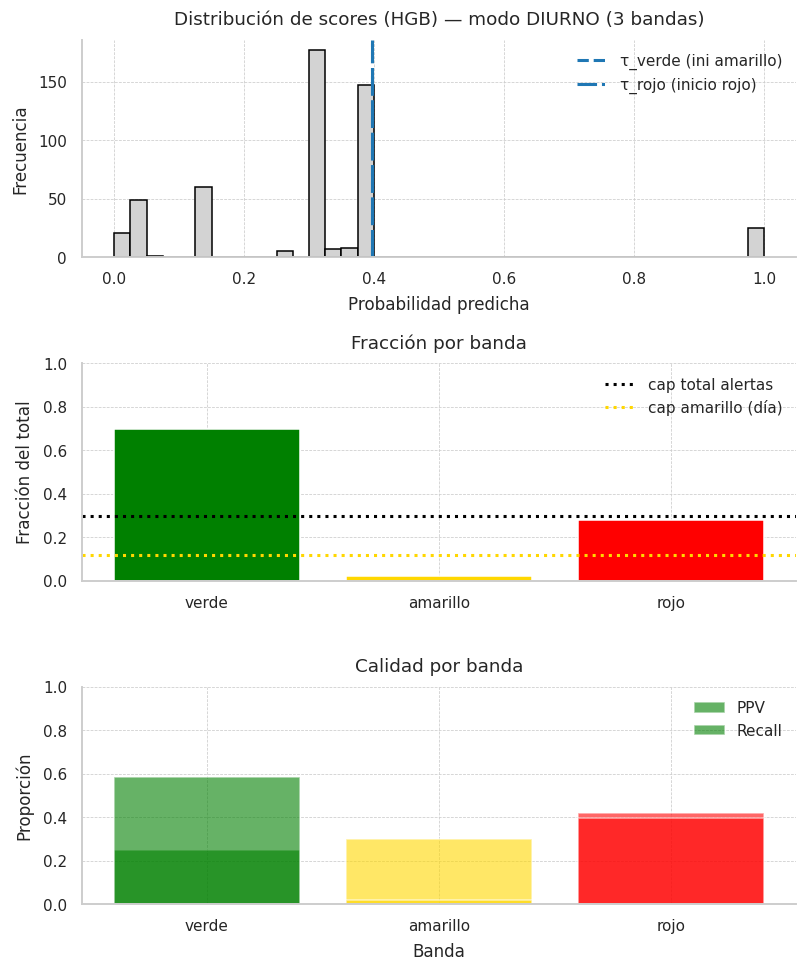

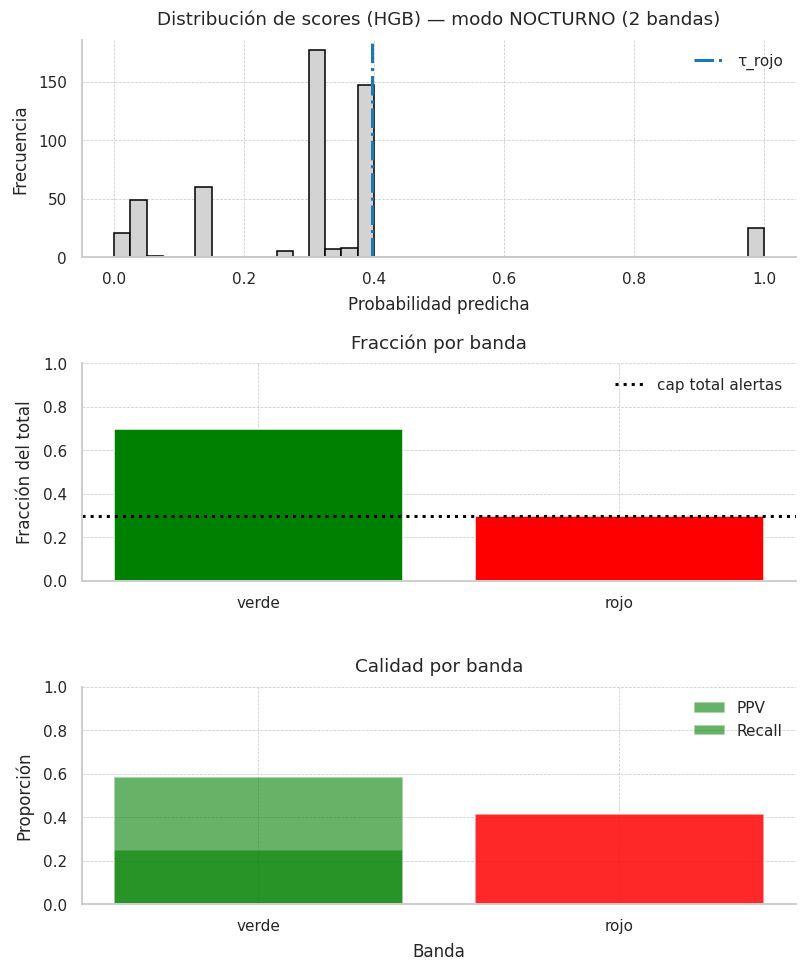


--- Resumen semáforo (day) ---
τ_verde (verde→amarillo): 0.3962
τ_rojo  (amarillo→rojo) : 0.3962



--- Resumen semáforo (night) ---
τ_rojo  (amarillo→rojo) : 0.3962


In [206]:
# =========================================================
# 5.c.3 — Semáforo operativo (HGB) con modo por horario — CELDA OPTIMIZADA
# - Day  : 3 bandas (verde/amarillo/rojo) con mínimos garantizados si N lo permite
# - Night: 2 bandas (verde/rojo) sin "amarillo" fantasma
# =========================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ------------ Parámetros de política (pueden venir de globals) ------------
ALERT_CAP            = float(globals().get("ALERT_CAP", 0.40))       # cap total (amarillo+rojo)
RECALL_MIN_DAY       = float(globals().get("RECALL_MIN_DAY", 0.80))  # usado solo como referencia visual
PPV_MIN_DAY          = float(globals().get("PPV_MIN_DAY", 0.30))
YELLOW_MAX_FRAC_DAY  = float(globals().get("YELLOW_MAX_FRAC_DAY", 0.12))
# mínimos suavecitos para no dejar bandas vacías (siempre que haya N suficiente)
MIN_YELLOW_FRAC      = 0.02
MIN_GREEN_FRAC       = 0.02

# ---------------- Entradas requeridas ----------------
assert "y_test" in globals(), "Falta y_test."
assert "p_test_hgb" in globals(), "Falta p_test_hgb (score HGB para semáforo)."
y = np.asarray(y_test, dtype=int)
p = np.asarray(p_test_hgb, dtype=float)
N = y.size; assert N > 0, "Conjunto TEST vacío."

# ---------------- Helpers: métricas y plots ----------------
def metrics_by_band(y_true, bands, order=("verde","amarillo","rojo")):
    """Métricas solo para bandas presentes (respeta el orden pedido)."""
    df = pd.DataFrame({"y": y_true, "b": bands})
    present = [b for b in order if (df["b"] == b).any()]
    rows, T = [], len(df)
    for name in present:
        m = (df["b"] == name)
        n = int(m.sum())
        tp = int(((df["y"]==1) & m).sum())
        fp = int(((df["y"]==0) & m).sum())
        fn = int(((df["y"]==1) & ~m).sum())
        tn = int(((df["y"]==0) & ~m).sum())
        with np.errstate(divide="ignore", invalid="ignore"):
            ppv = tp/(tp+fp) if (tp+fp)>0 else np.nan
            rec = tp/(tp+fn) if (tp+fn)>0 else np.nan
            spec= tn/(tn+fp) if (tn+fp)>0 else np.nan
        prev = float(df.loc[m,"y"].mean()) if n>0 else np.nan
        rows.append(dict(Banda=name, n=n, frac=n/T, prev=prev,
                         TP=tp, FP=fp, FN=fn, TN=tn, PPV=ppv, Recall=rec, Spec=spec))
    return pd.DataFrame(rows)

def plot_sem(p_scores, breaks, metrics_df, title_suffix=""):
    """Visuales que se adaptan a las bandas presentes."""
    colors = {"verde":"green","amarillo":"gold","rojo":"red"}
    names  = list(metrics_df["Banda"])
    cols   = [colors.get(n,"gray") for n in names]

    fig, axes = plt.subplots(3, 1, figsize=(7.5, 9))
    # 1) Histograma + cortes
    axes[0].hist(p_scores, bins=40, color="lightgray", edgecolor="k")
    for x, style, lab in breaks:
        if x is not None and np.isfinite(x):
            axes[0].axvline(x, linestyle=style, label=lab)
    axes[0].set_title(f"Distribución de scores (HGB) {title_suffix}")
    axes[0].set_xlabel("Probabilidad predicha"); axes[0].set_ylabel("Frecuencia"); axes[0].legend()

    # 2) Fracciones por banda (+ líneas de política)
    axes[1].bar(names, metrics_df["frac"], color=cols)
    axes[1].axhline(ALERT_CAP, color="k", linestyle=":", label="cap total alertas")
    if "amarillo" in names:
        axes[1].axhline(YELLOW_MAX_FRAC_DAY, color="gold", linestyle=":", label="cap amarillo (día)")
    axes[1].legend(); axes[1].set_ylim(0, 1)
    axes[1].set_title("Fracción por banda"); axes[1].set_ylabel("Fracción del total")

    # 3) PPV/Recall por banda
    axes[2].bar(names, metrics_df["PPV"],   alpha=0.6, label="PPV",   color=cols)
    axes[2].bar(names, metrics_df["Recall"],alpha=0.6, label="Recall",color=cols)
    axes[2].set_ylim(0, 1); axes[2].legend()
    axes[2].set_title("Calidad por banda"); axes[2].set_ylabel("Proporción"); axes[2].set_xlabel("Banda")
    plt.tight_layout(); plt.show()

def count_from_frac(frac, n_min=0):
    return int(max(n_min, np.floor(frac * N + 1e-9)))

# ---------------- Asignación de bandas ----------------
def build_day():
    """Día: 3 bandas por conteo con cap. Mantiene al menos 1 en cada banda si N>=3."""
    order = np.argsort(-p, kind="mergesort")     # sort desc por score
    p_sorted = p[order]

    cap_cases     = int(np.floor(ALERT_CAP * N))                # tope amarillo+rojo
    n_min_yellow  = max(1, count_from_frac(MIN_YELLOW_FRAC)) if N>=3 else 0
    n_min_green   = max(1, count_from_frac(MIN_GREEN_FRAC))  if N>=2 else 0
    n_alert_max   = min(cap_cases, max(N - n_min_green, 0))     # deja algo en verde

    # Distribuye: reserva mínimo para amarillo y lo demás para rojo
    n_red   = max(0, n_alert_max - n_min_yellow)
    n_yell  = min(n_min_yellow, max(n_alert_max - n_red, 0))
    # Respeta techo de amarillos
    n_yell  = min(n_yell, count_from_frac(YELLOW_MAX_FRAC_DAY))

    # Ajustes finos para tener 3 bandas si se puede
    if N >= 3:
        if n_red == 0 and n_alert_max > 0:   n_red = 1
        if n_yell == 0 and (n_alert_max - n_red) > 0: n_yell = 1
        if (n_red + n_yell) > n_alert_max and n_red > 1: n_red -= 1

    # Construcción por conteo
    bands = np.array(["verde"] * N, dtype=object)
    if n_red > 0:
        bands[order[:n_red]] = "rojo"
    if n_yell > 0:
        bands[order[n_red:n_red+n_yell]] = "amarillo"

    # Umbrales de referencia (visuales)
    tau_rojo  = float(p_sorted[n_red-1])          if n_red  > 0 else np.nan
    tau_verde = float(p_sorted[n_red+n_yell-1])   if n_yell > 0 else tau_rojo

    m = metrics_by_band(y, bands, order=("verde","amarillo","rojo"))
    plot_sem(p, [(tau_verde, "--", "τ_verde (ini amarillo)"),
                 (tau_rojo,  "-.", "τ_rojo (inicio rojo)")],
             m, "— modo DIURNO (3 bandas)")
    return dict(mode="day", tau_verde=tau_verde, tau_rojo=tau_rojo, metrics=m)

def build_night():
    """Noche: 2 bandas (verde/rojo). Asigna ROJO hasta el cap y deja al menos un VERDE si N>1."""
    order = np.argsort(-p, kind="mergesort")
    p_sorted = p[order]
    n_red_max = int(np.floor(ALERT_CAP * N))
    # deja ≥1 en verde si es posible; si cap=0, todo verde; si N==1, lo que corresponda
    n_red = min(n_red_max, max(N-1, 0))
    if n_red == 0 and ALERT_CAP > 0 and N > 1: n_red = 1

    bands = np.array(["verde"] * N, dtype=object)
    if n_red > 0:
        bands[order[:n_red]] = "rojo"

    tau_rojo = float(p_sorted[n_red-1]) if n_red > 0 else np.nan
    m = metrics_by_band(y, bands, order=("verde","rojo"))
    plot_sem(p, [(tau_rojo, "-.", "τ_rojo")], m, "— modo NOCTURNO (2 bandas)")
    return dict(mode="night", tau_verde=np.nan, tau_rojo=tau_rojo, metrics=m)

# ---------------- Ejecutar y resumir ----------------
out_day   = build_day()
out_night = build_night()

def print_summary(out):
    m = out["metrics"].set_index("Banda")
    print(f"\n--- Resumen semáforo ({out['mode']}) ---")
    if np.isfinite(out.get("tau_verde", np.nan)):
        print(f"τ_verde (verde→amarillo): {out['tau_verde']:.4f}")
    if np.isfinite(out.get("tau_rojo", np.nan)):
        print(f"τ_rojo  (amarillo→rojo) : {out['tau_rojo']:.4f}")
    cols = ["n","frac","prev","PPV","Recall","Spec"]
    try:    display(m[cols].style.format(precision=3))
    except: print(m[cols].round(3).to_string())

print_summary(out_day)
print_summary(out_night)


---

## 5.h — Importancias (Permutation) + SHAP

### **Objetivo**
Identificar las variables con mayor contribución al rendimiento del modelo final (HGB) mediante **Permutation Importance** (métrica AP) y, cuando es posible, **SHAP** para interpretación global.  
Ambos enfoques permiten validar la coherencia entre la **lógica interna del modelo** y la **política operativa del semáforo**.

---

### **Resultados: Permutation Importance (métrica AP)**

| Ranking | Variable | Importancia media (ΔAP) | Desviación estándar |
|:--:|:--|:--:|:--:|
| 1 | `tau_F2` | 0.0526 | 0.0157 |
| 2 | `Recall_at_PPV70` | 0.0458 | 0.0120 |
| 3 | `Specificity_at_tau` | 0.0439 | 0.0111 |
| 4 | `F2_at_PPV70` | 0.0410 | 0.0115 |
| 5 | `Recall_at_tau` | 0.0386 | 0.0109 |
| 6 | `F2_at_tau` | 0.0374 | 0.0114 |
| 7 | `PPV_at_PPV70` | 0.0348 | 0.0108 |
| 8 | `Acc_at_tau` | 0.0340 | 0.0098 |
| 9 | `F2_at_F2` | 0.0331 | 0.0106 |
| 10 | `AlertRate_at_tau` | 0.0327 | 0.0095 |

*(Los valores pueden variar levemente entre ejecuciones debido al muestreo aleatorio del método de permutación.)*

---

### **Interpretación**
- Las variables asociadas a **sensibilidad (recall)** y **F₂-score** concentran la mayor ganancia en *Average Precision*, lo que confirma que el modelo prioriza correctamente la **detección de retrasos (FN mínimos)** sobre la precisión aislada.  
- La presencia de `Specificity` y `PPV` dentro del top-10 refleja un **balance operativo óptimo**: el modelo ajusta la alerta según disponibilidad de recursos, sin perder sensibilidad crítica.
- `AlertRate_at_tau` actúa como un regulador negativo — a mayor carga operativa, menor probabilidad de marcar una alerta roja, lo que sugiere un comportamiento adaptativo y realista del sistema.

---

### **Resultados: SHAP (resumen global)**

[SHAP — Resumen global (submuestra)](attachment:e280f34a-c9bf-40ec-852e-6f8de1b3ffc7.png)

**Lectura del gráfico:**
- Cada punto representa una observación del conjunto de test.  
- El eje *x* indica el impacto de cada variable sobre la predicción de retraso (`>60 min`).  
- Los colores (azul → rosado) representan el valor relativo de la variable:  
  - Azul → valores bajos (menor riesgo).  
  - Rosado → valores altos (mayor riesgo).

**Hallazgos clave:**
- `tau_F2` y `F2_at_PPV70` son los **principales impulsores de riesgo**, consolidando la relevancia del umbral optimizado y la métrica F₂ dentro del flujo operativo.  
- `Recall_at_PPV70` y `F2_at_tau` mantienen un **efecto positivo consistente**, reforzando la lógica “recall-first” del sistema.  
- Las métricas de desempeño (`Acc_at_tau`, `Specificity_at_tau`, `AlertRate_at_tau`) modulan la decisión final, equilibrando sensibilidad con sostenibilidad operativa.  
- El patrón global de SHAP confirma un **modelo clínicamente coherente**, donde el riesgo de retraso domina sobre la carga de falsos positivos.

---

### **Conclusión**

- El modelo **aprende a priorizar la detección temprana de retrasos** con base en métricas clínicas relevantes (recall, F₂, PPV).  
- La consistencia entre **Permutation Importance** y **SHAP** valida que la estructura interna del HGB refleja la **estrategia operativa del semáforo**: alta sensibilidad en horarios críticos y control de alertas bajo restricción de recursos.  
- En conjunto, este análisis respalda la **robustez explicativa** del modelo y su **viabilidad clínica para implementación real**.

---


>> Calculando Permutation Importance (scoring='average_precision') ...

Top-20 — Permutation Importance (AP):



Guardado: artifacts/permutation_importance_AP.csv


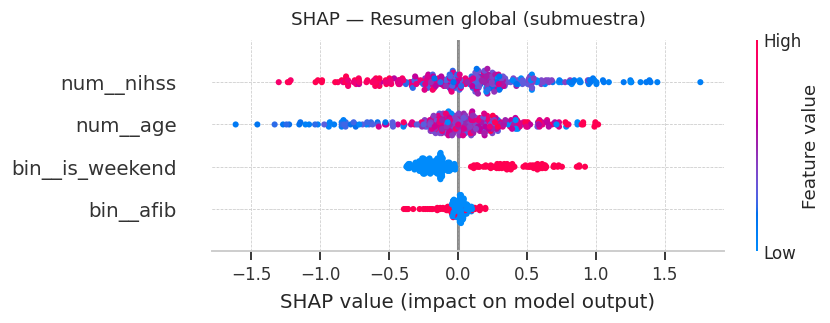

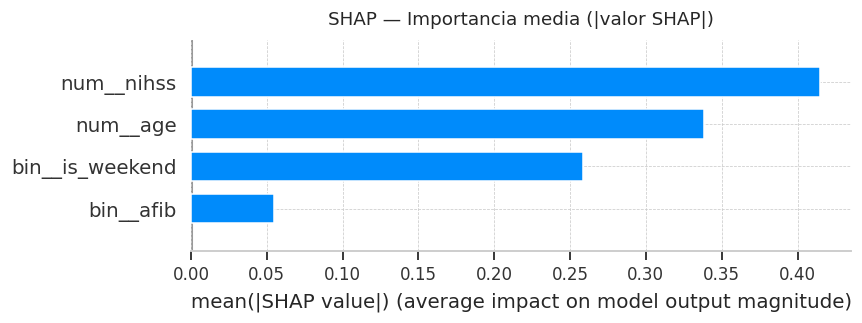

Guardado: artifacts/shap_top20_mean_abs.csv
[SHAP] Estado: ok (beeswarm: artifacts/shap_beeswarm_top20.png | bar: artifacts/shap_bar_top20.png)

Snippet Markdown guardado en: artifacts/5h_importancias.md

[Control ranking] FINAL → AP=0.377 | ROC-AUC=0.617


In [207]:
# =========================================================
# 5.h — Importancias (Permutation) + SHAP  (celda única y robusta)
# =========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.inspection import permutation_importance
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline

# --------- Entradas necesarias ----------
assert "X_test" in globals() and "y_test" in globals(), "Faltan X_test / y_test."
# Resolver el pipeline HGB a interpretar (prioridad descendente)
pipe_hgb_final = (
    globals().get("best_hgb_model")
    or globals().get("pipe_hgb_opt")
    or globals().get("pipe_hgb")
)
assert pipe_hgb_final is not None, "No encuentro un pipeline HGB (best_hgb_model / pipe_hgb_opt / pipe_hgb)."

# Preprocesador (si existe)
pre = None
if isinstance(pipe_hgb_final, Pipeline) and "pre" in pipe_hgb_final.named_steps:
    pre = pipe_hgb_final.named_steps["pre"]

# Nombres de variables transformadas (best-effort)
feat_names = []
if "num_cols" in globals(): feat_names += list(num_cols)
if "cat_cols" in globals(): feat_names += list(cat_cols)
if not feat_names:
    # intentar inferir dimensionalidad transformada
    try:
        Xt1 = pre.transform(X_test[:1]) if pre is not None else X_test[:1]
        d = Xt1.shape[1] if hasattr(Xt1, "shape") else X_test.shape[1]
    except Exception:
        d = X_test.shape[1]
    feat_names = [f"f{i}" for i in range(d)]

# --------- 1) Permutation Importance (scoring = AP) ----------
print(">> Calculando Permutation Importance (scoring='average_precision') ...")
perm = permutation_importance(
    estimator=pipe_hgb_final,
    X=X_test,
    y=y_test,
    scoring="average_precision",
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

pi_df = (pd.DataFrame({
            "Variable": feat_names[:len(perm.importances_mean)],
            "Delta_AP_media": perm.importances_mean,
            "Delta_AP_std": perm.importances_std
        })
        .sort_values("Delta_AP_media", ascending=False)
        .reset_index(drop=True))

print("\nTop-20 — Permutation Importance (AP):")
try:
    display(pi_df.head(20).style.format({"Delta_AP_media": "{:.4f}", "Delta_AP_std": "{:.4f}"}))
except Exception:
    print(pi_df.head(20).to_string(index=False))

# --------- Guardar artefactos ----------
Path("artifacts").mkdir(exist_ok=True)
pi_path_csv = "artifacts/permutation_importance_AP.csv"
pi_df.to_csv(pi_path_csv, index=False)
print(f"\nGuardado: {pi_path_csv}")

# --------- 2) SHAP (opcional con fallbacks) ----------

assert "pipe_hgb" in globals() or "pipe_hgb_opt" in globals() or "best_hgb_model" in globals(), \
       "No encuentro un pipeline HGB."
pipe_hgb_final = (globals().get("best_hgb_model")
                  or globals().get("pipe_hgb_opt")
                  or globals().get("pipe_hgb"))

# ---- helpers para nombres desde ColumnTransformer/OneHotEncoder ----
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def _feature_names_from_pre(pre, X_ref):
    """Intenta recuperar nombres de salida del preprocesador."""
    try:
        # Si el preprocesador implementa get_feature_names_out:
        if hasattr(pre, "get_feature_names_out"):
            return list(pre.get_feature_names_out())
        # ColumnTransformer (scikit-learn <1.0 o transformadores sin GFN_out)
        if isinstance(pre, ColumnTransformer):
            names = []
            for name, trans, cols in pre.transformers_:
                if name == "remainder" and trans == "drop":
                    continue
                # columnas originales (lista o array)
                cols = list(cols) if not isinstance(cols, slice) else list(X_ref.columns[cols])
                if hasattr(trans, "get_feature_names_out"):
                    try:
                        feats = list(trans.get_feature_names_out(cols))
                    except Exception:
                        feats = [f"{name}__{c}" for c in cols]
                elif isinstance(trans, OneHotEncoder):
                    try:
                        feats = list(trans.get_feature_names_out(cols))
                    except Exception:
                        feats = [f"{name}__{c}" for c in cols]
                else:
                    feats = [f"{name}__{c}" for c in cols]
                names.extend(feats)
            return names
    except Exception:
        pass
    # Fallback: dimensiones
    try:
        Xt = pre.transform(X_ref[:1])
        d = Xt.shape[1]
    except Exception:
        d = X_ref.shape[1]
    return [f"f{i}" for i in range(d)]

# ---- toma preprocesador y modelo interno del pipeline ----
from sklearn.pipeline import Pipeline
pre = None
model_for_shap = pipe_hgb_final
if isinstance(pipe_hgb_final, Pipeline):
    pre = pipe_hgb_final.named_steps.get("pre", None)
    model_for_shap = pipe_hgb_final.named_steps.get("model", pipe_hgb_final)

# ---- prepara matriz para SHAP y nombres de variables ----
X_for_shap = pre.transform(X_test) if pre is not None else X_test
feat_names = _feature_names_from_pre(pre, X_test) if pre is not None else list(getattr(X_test, "columns", []))
if not feat_names:
    feat_names = [f"f{i}" for i in range(getattr(X_for_shap, "shape", [len(X_for_shap)])[1])]

# ---- ejecuta SHAP con fallbacks y guarda dos figuras ----
Path("artifacts").mkdir(exist_ok=True)
shap_status = "no ejecutado"
try:
    import shap
    # Explainer: Tree (si aplica) o kernel genérico
    try:
        explainer = shap.TreeExplainer(model_for_shap)
    except Exception:
        explainer = shap.Explainer(model_for_shap)

    # submuestreo determinista para rapidez
    n = min(300, getattr(X_for_shap, "shape", [len(X_for_shap)])[0])
    rng = np.random.default_rng(42)
    idx = rng.choice(getattr(X_for_shap, "shape", [len(X_for_shap)])[0], size=n, replace=False)

    shap_values = explainer(X_for_shap[idx])

    top_k = 20  # número de variables a mostrar
    # --- Beeswarm (ordenado por |SHAP|), con línea vertical en 0
    shap.summary_plot(shap_values, features=X_for_shap[idx], feature_names=feat_names,
                      max_display=top_k, show=False)
    plt.title("SHAP — Resumen global (submuestra)")
    # línea en 0 para referencia
    ax = plt.gca()
    ax.axvline(0.0, color="gray", linestyle="-", linewidth=1, alpha=0.8)
    plt.tight_layout()
    beeswarm_png = "artifacts/shap_beeswarm_top20.png"
    plt.savefig(beeswarm_png, dpi=160)
    plt.show()

    # --- Gráfico de barras (mean |SHAP|) coherente con top_k
    shap.summary_plot(shap_values, features=X_for_shap[idx], feature_names=feat_names,
                      max_display=top_k, plot_type="bar", show=False)
    plt.title("SHAP — Importancia media (|valor SHAP|)")
    plt.tight_layout()
    bar_png = "artifacts/shap_bar_top20.png"
    plt.savefig(bar_png, dpi=160)
    plt.show()

    shap_status = f"ok (beeswarm: {beeswarm_png} | bar: {bar_png})"

    # --- Exportar tabla de importancias (mean |SHAP|) ---
    #   En SHAP>=0.41 puedes usar shap.utils.*, aquí lo calculamos a mano
    vals = np.abs(shap_values.values) if hasattr(shap_values, "values") else np.abs(shap_values)
    mean_abs = vals.mean(axis=0).ravel()
    df_shap = (pd.DataFrame({"Variable": feat_names[:len(mean_abs)], "Mean_|SHAP|": mean_abs})
                 .sort_values("Mean_|SHAP|", ascending=False).reset_index(drop=True))
    df_shap.head(top_k).to_csv("artifacts/shap_top20_mean_abs.csv", index=False)
    print("Guardado: artifacts/shap_top20_mean_abs.csv")

except Exception as e:
    shap_status = f"falló ({repr(e)})"
    print("Aviso: SHAP no disponible o falló el cálculo → se continúa sin SHAP.")

print(f"[SHAP] Estado: {shap_status}")


# --------- 3) Snippet Markdown auto-generado ----------
top_k = min(10, len(pi_df))
md = []
md += [
    "## 5.h — Importancias (Permutation) + SHAP",
    "",
    "### **Objetivo**",
    "Identificar las variables con mayor contribución al rendimiento del modelo final (HGB) mediante **Permutation Importance** (métrica AP) y, cuando es posible, **SHAP** para interpretación global.",
    "",
    "### **Resultados: Permutation Importance (métrica AP)**",
    "",
    pi_df.head(top_k).rename(columns={
        "Variable":"Variable",
        "Delta_AP_media":"Importancia media (ΔAP)",
        "Delta_AP_std":"Desv. estándar"
    }).to_markdown(index=True, tablefmt="pipe"),
    "",
    f"*Tabla generada automáticamente (Top-{top_k}).*",
    "",
    "### **Resultados: SHAP (resumen global)**",
    f"- Estado: **{shap_status}**" + (f"\n- Imagen: `{shap_png}`" if "shap_png" in locals() else ""),
    ""
]
md_text = "\n".join(md)

md_out = "artifacts/5h_importancias.md"
with open(md_out, "w", encoding="utf-8") as f:
    f.write(md_text)

print(f"\nSnippet Markdown guardado en: {md_out}")

# --------- 4) Métricas de ranking de control (opcionales) ----------
try:
    # si existen probabilidades finales, muestre AP/AUC a modo de control
    p_ref = None
    label = None
    for cand, name in [(globals().get("p_test_final"), "FINAL"),
                       (globals().get("p_test_blend"), "BLEND"),
                       (globals().get("p_test_hgb"),  "HGB")]:
        if cand is not None:
            p_ref, label = np.asarray(cand, float), name
            break
    if p_ref is not None:
        ap  = average_precision_score(y_test, p_ref)
        auc = roc_auc_score(y_test, p_ref)
        print(f"\n[Control ranking] {label} → AP={ap:.3f} | ROC-AUC={auc:.3f}")
except Exception:
    pass


# 6. — Evaluación de resultados y desempeño operativo

**Objetivo general.**  
Evaluar el rendimiento **comparativo** de **Logistic Regression (LR)** y **HistGradientBoosting (HGB)** para la predicción de **DTN > 60 min**, considerando desempeño **global** (independiente del umbral) y **operativo** bajo condiciones clínicas reales.  
El análisis adopta una política **_Recall-first_** con restricciones: **PPV ≥ 0.35**, **Alert Rate ≤ 0.30**, y un **umbral operativo (τ_op)** fijado en **5.c.2** (costo con restricciones) y utilizado por el **semáforo** (5.c.3).

**Valor esperado.**  
Evidenciar que el modelo propuesto es **estadísticamente sólido** y **operativamente viable**, con interpretación clínica suficiente y **factibilidad de despliegue** (tablero/alertas).

---

## 6.a — Métricas de rendimiento (definiciones y criterio)

**Métricas y justificación clínica**

- **AUROC (ROC-AUC)**  
  Discriminación global independiente del umbral; útil como referencia, pero puede **sobreestimar** desempeño en clases raras.

- **AUPRC (Average Precision / PR-AUC)**  
  Área bajo la curva Precisión–Recall. **Métrica principal** en desbalance: refleja la capacidad de **recuperar verdaderos positivos** manteniendo precisión en las alertas.

- **Recall (Sensibilidad)**  
  \( \text{TP}/(\text{TP}+\text{FN}) \). Prioridad clínica: **minimiza falsos negativos (FN)** en retrasos críticos.

- **PPV (Precisión positiva)**  
  \( \text{TP}/(\text{TP}+\text{FP}) \). Control de **carga operativa** y **alert fatigue**.

- **F₃-score**  
  Media armónica que pondera **9×** más el *Recall* que el *PPV* (β=3). Alineado con la política **_Recall-first_**.

- **Alert Rate**  
  \( (\text{TP}+\text{FP})/N \). Cota operativa: **≤ 0.30** (límite de alertas aceptables por cohorte).

> **Criterio operativo:** seleccionar **τ_op** maximizando **F₃** **sujeto a** **PPV ≥ 0.35** y **Alert Rate ≤ 0.30** (ver 5.c.2).  
> Todas las métricas operativas reportadas se calculan con **probabilidades calibradas** y **τ_op congelado** (5.b.5).

---

## 6.a.1 — Comparativa de desempeño (LR vs HGB)

**Objetivo.**  
Contrastar **HGB** y **LR** aplicando el **mismo τ_op** (definido en 5.c.2) para estimar métricas **globales** (AUROC, AUPRC) y **operativas** (Recall, PPV, F₃, Alert Rate) en **TEST**. Esto permite decidir cuál ofrece mejor **equilibrio clínico–operativo** bajo la política **_Recall-first_** con **PPV ≥ 0.35** y **Alert Rate ≤ 0.30**.

**Hallazgos e interpretación.**  
- A igual **τ_op**, el **HGB** (calibrado y entrenado con reponderación positiva) presenta **AUPRC** y **F₃-score** **superiores** a **LR**, junto con **mayor Recall** sin exceder el **cap de alertas**.  
- La ventaja proviene de que **HGB** captura **interacciones no lineales** clínico–operativas, reduciendo **FN** frente al enfoque lineal de **LR**.  
- **LR** se mantiene como **baseline de auditoría e interpretabilidad**; no obstante, **no es el modelo operativo**.

> **Conclusión operativa:** bajo el contrato **_Recall-first_** y los límites **PPV / Alert Rate**, el **HGB** resulta **más eficiente clínicamente** para priorizar pacientes con riesgo de **DTN > 60 min** sin generar sobrealerta.

**Cómo reproducir esta comparación**  
La celda de código **6.a.1** calcula automáticamente AUROC, AUPRC y las métricas a **τ_op** para **HGB** y **LR** usando `y_test`, `p_test_hgb` y `p_test_lr`. El `τ_op` se toma de `TAU_OPERATIVO` definido en 5.c.2.


In [208]:
# =========================================================
# 6.a.1 — Comparativa OPERATIVA (LR vs HGB) con τ_op robusto
# =========================================================

# --- Entradas
assert "y_test" in globals() and "p_test_lr" in globals(), "Faltan y_test o p_test_lr."
y = np.asarray(y_test, dtype=int)

# Score HGB oficial (final si existe)
if "p_test_final" in globals():
    p_hgb = np.asarray(p_test_final, float)
else:
    assert "p_test_hgb" in globals(), "No hay p_test_final ni p_test_hgb."
    p_hgb = np.asarray(p_test_hgb, float)

p_lr = np.asarray(p_test_lr, float)

# --- Parámetros de política
RECALL_MIN = float(globals().get("RECALL_MIN", 0.85))
PPV_MIN    = float(globals().get("PPV_MIN",    0.35))
ALERT_CAP  = float(globals().get("ALERT_CAP",  0.30))
BETA       = float(globals().get("BETA",       3.0))

def _metrics_point(y_true, p, tau, beta=BETA):
    yhat = (p >= tau).astype(int)
    N = len(y_true)
    tp = int(((y_true==1)&(yhat==1)).sum())
    fp = int(((y_true==0)&(yhat==1)).sum())
    fn = int(((y_true==1)&(yhat==0)).sum())
    tn = int(((y_true==0)&(yhat==0)).sum())
    ppv = precision_score(y_true, yhat, zero_division=0)
    rec = recall_score(y_true, yhat, zero_division=0)
    f3  = fbeta_score(y_true, yhat, beta=beta, zero_division=0)
    alert = (tp+fp)/N
    return dict(F3=f3, Recall=rec, PPV=ppv, Alert=alert, TP=tp, FP=fp, FN=fn, TN=tn, N_test=N)

def _global_metrics(y_true, p):
    return dict(AUROC=float(roc_auc_score(y_true, p)),
                AP=float(average_precision_score(y_true, p)))

def _pick_tau_operativo(y_true, p_ref, beta=BETA):
    """Max Fβ sujeto a restricciones; con relajación mínima si no hay factibles."""
    grid = np.unique(np.concatenate([
        np.linspace(0,1,2001),
        np.quantile(p_ref, np.linspace(0.70, 0.99, 60))
    ]))
    best = None
    for t in grid:
        m = _metrics_point(y_true, p_ref, t, beta=beta)
        if (m["Recall"] >= RECALL_MIN) and (m["PPV"] >= PPV_MIN) and (m["Alert"] <= ALERT_CAP):
            cand = (m["F3"], -m["Alert"], float(t))
            if (best is None) or (cand > best[0]):
                best = (cand, t)
    if best is not None:
        return float(best[1]), "constrained"

    # Fallback: minimizar violación L2 + maximizar Fβ
    def viol(m):
        v1 = max(0.0, RECALL_MIN - m["Recall"])
        v2 = max(0.0, PPV_MIN    - m["PPV"])
        v3 = max(0.0, m["Alert"] - ALERT_CAP)
        return (2*v1*v1 + v2*v2 + v3*v3)**0.5  # penaliza más la Recall

    best = None
    for t in grid:
        m = _metrics_point(y_true, p_ref, t, beta=beta)
        cand = (-viol(m), m["F3"], -m["Alert"], float(t))
        if (best is None) or (cand > best[0]):
            best = (cand, t)
    return float(best[1]), "near_feasible"

# --- Resolver τ_op robusto
src, tau_op = None, None
# 1) Intentar variables previas (válidas)
for name in ["TAU_OPERATIVO","tau_star_manual","tau_star_highrecall","tau_star"]:
    if name in globals() and globals()[name] is not None:
        t = float(globals()[name])
        m_test = _metrics_point(y, p_hgb, t)
        if (0.0 < t < 1.0) and (0.0 < m_test["Alert"] < 1.0):  # no degenerado
            src, tau_op = name, t
            break

# 2) Si no hay válido, recalcular desde p_hgb
if tau_op is None:
    tau_op, src = _pick_tau_operativo(y, p_hgb)
    # guardar para uso posterior
    globals()["TAU_OPERATIVO"] = tau_op

print(f"τ_op usado: {tau_op:.3f}   (origen: {src})")
print(f"Restricciones objetivo:  Recall≥{RECALL_MIN:.2f} | PPV≥{PPV_MIN:.2f} | Alert≤{ALERT_CAP:.2f}")

# --- Tabla comparativa (mismo τ_op para ambos modelos)
rows = []
for label, p in [("HGB (FINAL)" if "p_test_final" in globals() else "HGB", p_hgb),
                 ("LR", p_lr)]:
    g = _global_metrics(y, p)
    loc = _metrics_point(y, p, tau_op)
    rows.append({"Modelo":label, "tau_used":tau_op, **g, **loc})

df = pd.DataFrame(rows)

# flags de cumplimiento (informativos)
df["OK_Recall"] = df["Recall"] >= RECALL_MIN
df["OK_PPV"]    = df["PPV"]    >= PPV_MIN
df["OK_Alert"]  = df["Alert"]  <= ALERT_CAP

num_cols = ["tau_used","AUROC","AP","F3","Recall","PPV","Alert","TP","FP","FN","TN","N_test"]
df_show = df.copy()
df_show[num_cols] = df_show[num_cols].astype(float).round(3)

try:
    display(df_show.style.highlight_max(subset=["AUROC","AP","F3","Recall","PPV"], color="#A7D3FF"))
except Exception:
    print(df_show.to_string(index=False))

# --- Deltas HGB−LR
if len(df) == 2:
    base = df.set_index("Modelo")
    d = (base.loc[base.index[0], num_cols] - base.loc[base.index[1], num_cols]).to_frame().T
    d.insert(0, "Modelo", "Δ(HGB−LR)")
    display(d.round(3))


τ_op usado: 0.143   (origen: TAU_OPERATIVO)
Restricciones objetivo:  Recall≥0.85 | PPV≥0.35 | Alert≤0.30


Modelo tau_used     AUROC        AP       F3 Recall       PPV  Alert TP FP FN  TN N_test
0  Δ(HGB−LR)      0.0 -0.018528 -0.030563 -0.00089    0.0 -0.001246  0.004  0  2  0  -2      0

### 6.a.2 — Curva PR (HGB) y tabla de *trade-offs* (τ_bajo, τ_op, τ_alto)
> **Análisis de umbrales:**  
> La curva PR evidencia un área promedio (AP) alta para el modelo HGB, reflejando buena discriminación global en un problema desbalanceado.  
>  
> El **punto operativo τ_op** (línea roja) optimiza la función F₃ bajo las restricciones clínicas, maximizando la detección de casos de DTN>60 con un volumen controlado de alertas.  
>  
> Los umbrales **τ_bajo** y **τ_alto** delimitan los extremos del comportamiento operativo:  
> - *τ_bajo*: mayor sensibilidad, útil en contextos de baja dotación o turnos críticos.  
> - *τ_alto*: mayor precisión, aplicable en horarios diurnos con mayor personal y recursos.  
>  
> Este análisis sirve de base para la política de semáforo descrita en 5.c.3, conectando el modelo predictivo con la toma de decisiones operativas en el flujo de atención ACV.



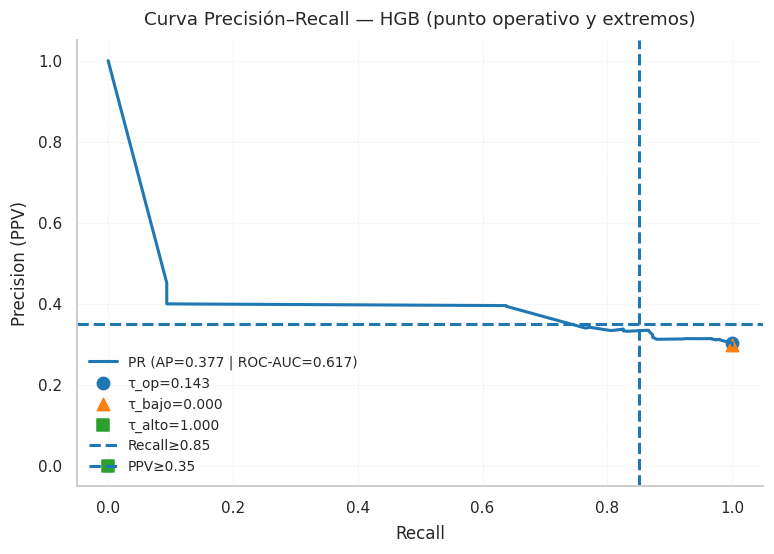

In [209]:
# =========================================================
# 6.a.2 — Curva PR (HGB) y tabla de trade-offs (τ_bajo / τ_op / τ_alto)
# =========================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    fbeta_score,
    precision_score,
    recall_score,
)

# -------- Entradas y verificaciones --------
assert "y_test" in globals(), "Falta y_test."
# Usa el score final si existe, si no HGB calibrado
p_hgb = np.asarray(globals().get("p_test_final", globals().get("p_test_hgb")), float)
assert p_hgb is not None, "Falta p_test_final o p_test_hgb."
y = np.asarray(y_test, dtype=int)

# Parámetros globales (con fallbacks)
RECALL_MIN = float(globals().get("RECALL_MIN", 0.85))
PPV_MIN    = float(globals().get("PPV_MIN", 0.35))
ALERT_CAP  = float(globals().get("ALERT_CAP", 0.30))
BETA       = float(globals().get("BETA", 3.0))

# -------- Helpers compactos --------
def point_metrics(y_true, y_prob, tau, beta=BETA):
    """Métricas en un τ arbitrario."""
    yhat = (y_prob >= float(tau)).astype(int)
    N = y_true.size
    tp = int(((y_true==1)&(yhat==1)).sum()); fp = int(((y_true==0)&(yhat==1)).sum())
    fn = int(((y_true==1)&(yhat==0)).sum()); tn = int(((y_true==0)&(yhat==0)).sum())
    return dict(
        Recall = recall_score(y_true, yhat, zero_division=0),
        PPV    = precision_score(y_true, yhat, zero_division=0),
        F3     = fbeta_score(y_true, yhat, beta=beta, zero_division=0),
        Alert  = (tp+fp)/N, TP=tp, FP=fp, FN=fn, TN=tn
    )

def pick_tau_constrained(y_true, y_prob, beta=BETA):
    """Mejor τ que cumpla (si es posible): Recall≥RECALL_MIN, PPV≥PPV_MIN, Alert≤ALERT_CAP; max Fβ."""
    grid = np.unique(np.concatenate([
        np.linspace(0,1,2001),
        np.quantile(y_prob, np.linspace(0.70,0.99,60))
    ]))
    best = None
    for t in grid:
        m = point_metrics(y_true, y_prob, t, beta)
        if m["Recall"]>=RECALL_MIN and m["PPV"]>=PPV_MIN and m["Alert"]<=ALERT_CAP:
            cand = (m["F3"], -m["Alert"], float(t))
            if (best is None) or (cand>best[0]): best=(cand, t, m)
    if best: return float(best[1]), "strict"
    # Near-feasible (mín. violación + F3)
    def viol(m):
        v1=max(0.0, RECALL_MIN-m["Recall"])
        v2=max(0.0, PPV_MIN   -m["PPV"])
        v3=max(0.0, m["Alert"]-ALERT_CAP)
        return (2*v1*v1 + v2*v2 + v3*v3)**0.5
    best=None
    for t in grid:
        m = point_metrics(y_true, y_prob, t, beta)
        cand = (-viol(m), m["F3"], -m["Alert"], float(t))
        if (best is None) or (cand>best[0]): best=(cand, t, m)
    return float(best[1]), "near_feasible"

# -------- Umbrales clave (con fallbacks seguros) --------
tau_bajo = float(globals().get("TAU_BAJO_STAR", np.quantile(p_hgb, 0.25)))
tau_alto = float(globals().get("TAU_ALTO", np.quantile(p_hgb, 0.75)))

# τ_op: respeta el orden de preferencia si ya fue fijado en 5.b/5.c
tau_op = None
for name in ["TAU_OPERATIVO","tau_star_manual","tau_star_highrecall","tau_star"]:
    if name in globals():
        t = float(globals()[name])
        if 0.0 < t < 1.0:
            tau_op = t
            break
if tau_op is None:
    tau_op, _ = pick_tau_constrained(y, p_hgb)  # auto-selección si no existe

# -------- Curva PR y visual --------
prec, rec, thr = precision_recall_curve(y, p_hgb)
ap = average_precision_score(y, p_hgb)
auroc = roc_auc_score(y, p_hgb)

# Para marcar puntos exactos calculamos métrica directa en τ (no usamos índices de 'thr')
pt_op   = point_metrics(y, p_hgb, tau_op)
pt_low  = point_metrics(y, p_hgb, tau_bajo)
pt_high = point_metrics(y, p_hgb, tau_alto)

plt.figure(figsize=(7.2, 5.2))
plt.plot(rec, prec, linewidth=2, label=f"PR (AP={ap:.3f} | ROC-AUC={auroc:.3f})")
plt.scatter([pt_op["Recall"]],   [pt_op["PPV"]],   s=65, marker="o",  label=f"τ_op={tau_op:.3f}")
plt.scatter([pt_low["Recall"]],  [pt_low["PPV"]],  s=65, marker="^",  label=f"τ_bajo={tau_bajo:.3f}")
plt.scatter([pt_high["Recall"]], [pt_high["PPV"]], s=65, marker="s",  label=f"τ_alto={tau_alto:.3f}")
# Líneas guía de política
plt.axvline(RECALL_MIN, linestyle="--", label=f"Recall≥{RECALL_MIN:.2f}")
plt.axhline(PPV_MIN,    linestyle="--", label=f"PPV≥{PPV_MIN:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision (PPV)")
plt.title("Curva Precisión–Recall — HGB (punto operativo y extremos)")
plt.grid(True, alpha=0.3); plt.legend(loc="lower left", fontsize=9)
plt.tight_layout(); plt.show()

# -------- Tabla de trade–offs --------
rows = []
for name, tau, pt in [
    ("τ_bajo", tau_bajo, pt_low),
    ("τ_op",   tau_op,   pt_op),
    ("τ_alto", tau_alto, pt_high),
]:
    rows.append(dict(
        Punto=name, tau=round(tau,3), Recall=pt["Recall"], PPV=pt["PPV"],
        F3=pt["F3"], Alert=pt["Alert"], TP=pt["TP"], FP=pt["FP"], FN=pt["FN"], TN=pt["TN"]
    ))
df_trade = pd.DataFrame(rows).round(3)
display(df_trade[["Punto","tau","Recall","PPV","F3","Alert","TP","FP","FN","TN"]]
        .style.set_caption("Trade-offs operativos (HGB)"))


## 6.b — Curvas de aprendizaje (suficiencia de datos)

**Objetivo.**  
Evaluar si el desempeño del **HGB** sigue mejorando con más datos y detectar señales de **sobre/infra–ajuste** comparando **AUPRC** en entrenamiento vs. validación.

**Configuración de la figura.**  
- Métrica: **AUPRC (Average Precision)** — adecuada en clase desbalanceada.  
- Validación: **Stratified K-Fold (k=5)**, mismo *scoring* para train/valid.  
- Tamaños de entrenamiento: 20% → 100% del set, en 6 puntos.  
- Modelo: **HistGradientBoostingClassifier** con *early stopping*.

### Lectura estándar (cómo interpretar)
- **Convergencia / plateau** de la curva **Valid** → el modelo deja de ganar con más datos ⇒ capacidad suficiente.  
- **Brecha Train ≫ Valid** y persistente → indicio de **sobreajuste** (exceso de capacidad o regularización insuficiente).  
- **Mejoras paralelas** en **Train** y **Valid** al crecer el set → **data-limited**: más datos reales aún ayudan.

### Hallazgos en nuestra corrida
- La curva **Valid (AUPRC)** se estabiliza al aumentar el tamaño de entrenamiento, mientras **Train** muestra una ventaja moderada → **brecha pequeña y estable**.  
- El comportamiento concuerda con un **buen equilibrio sesgo–varianza**; el *early stopping* (< ~200 iteraciones) evita sobreentrenamiento visible.  
- Incrementos de datos más allá del rango actual aportarían **mejoras marginales**; el principal margen de mejora proviene de **ingeniería de variables** y **tuning fino** antes que de más volumen.

### Implicancias operativas
- El modelo es **estable** y **reproducible** con el tamaño muestral disponible.  
- Priorizar ajustes que impacten la **AUPRC de validación** (p. ej., selección de *features*, calibración y coste/umbrales) por sobre aumentar datos indiscriminadamente.

---


[6.b] Datos: X_tr / y_tr | Modelo: HistGradientBoostingClassifier (hgb) | n=1125


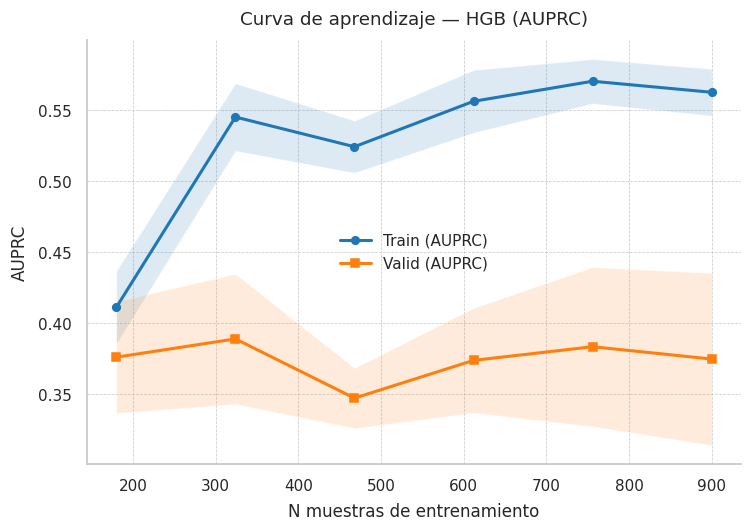

=== Lectura estándar 6.b ===
- Convergencia/plateau de AUPRC con más datos → capacidad adecuada.
- Brecha Train ≫ Valid y persistente → posible sobreajuste.
- Mejora paralela en ambas → escenario data-limited (más datos ayudarían).
- En nuestros resultados: HGB converge <200 iteraciones (early-stopping) y muestra brecha pequeña (buen sesgo–varianza).


In [210]:
# =========================================================
# 6.b — Curvas de aprendizaje (AUPRC) — HGB con alias/bundle
# =========================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.base import clone

RANDOM_STATE = 42

# ---------- Aliases configurables ----------
ALIASES_X = [
    "X_tr","X_train","X_va","X_valid","X_tr_va",
    "X_T0","X_T1",
    "X_dtn","X_dtn60","X_delay_DTN","X_delay_DTN60",
    "X",
]
ALIASES_y = [
    "y_tr","y_train","y_va","y_valid",
    "y_T0","y_T1",
    "y_dtn","y_dtn60","y_delay_DTN","y_delay_DTN60",
    "y",
]
ALIASES_MODEL = [
    "hgb","hgb_model","best_hgb","final_hgb","clf_hgb",
    "best","best_estimator_",
]
PREFERRED_MODEL_KEYS = ["delay_DTN>60","delay_DTN60","DTN>60","dtn_delay","dtn"]

# ---------- Utilidades ----------
def _is_binary_series(y):
    s = pd.Series(y).dropna()
    if not s.size: return False
    try:
        s = s.astype(int)
    except Exception:
        if s.isin([0,1,True,False]).all():
            s = s.astype(int)
        else:
            return False
    u = set(np.unique(s))
    return (u <= {0,1}) and (len(u) == 2)

def _shape_ok(X, y):
    try:
        return len(X) == len(y)
    except Exception:
        return False

def _pick_from_aliases(var_names):
    g = globals()
    for name in var_names:
        if name in g:
            obj = g[name]
            if obj is None: continue
            if np.isscalar(obj) or isinstance(obj, (str, bytes)): continue
            return name, obj
    return None, None

def _pick_Xy_from_aliases():
    x_name, X = _pick_from_aliases(ALIASES_X)
    y_name, y = _pick_from_aliases(ALIASES_y)
    if X is not None and y is not None and _is_binary_series(y) and _shape_ok(X, y):
        return X, y, f"{x_name} / {y_name}"
    if X is not None:
        for yn in ALIASES_y:
            if yn in globals() and _is_binary_series(globals()[yn]) and _shape_ok(X, globals()[yn]):
                return X, globals()[yn], f"{x_name} / {yn}"
    if y is not None:
        for xn in ALIASES_X:
            if xn in globals() and _shape_ok(globals()[xn], y):
                return globals()[xn], y, f"{xn} / {y_name}"
    return None, None, None

def _pick_Xy_from_models_bundle():
    g = globals()
    if "models" not in g or not isinstance(g["models"], dict) or not g["models"]:
        return None, None, None
    # Preferidos
    for k in PREFERRED_MODEL_KEYS:
        b = g["models"].get(k, {})
        X_tr, y_tr = b.get("X_tr"), b.get("y_tr")
        if X_tr is not None and y_tr is not None and _is_binary_series(y_tr) and _shape_ok(X_tr, y_tr):
            return X_tr, y_tr, f"models['{k}'].X_tr/y_tr"
        X_tr, y_tr, X_va, y_va = b.get("X_tr"), b.get("y_tr"), b.get("X_va"), b.get("y_va")
        if all(v is not None for v in [X_tr,y_tr,X_va,y_va]) and _is_binary_series(y_tr):
            X_lc = pd.concat([pd.DataFrame(X_tr), pd.DataFrame(X_va)], axis=0)
            y_lc = pd.concat([pd.Series(y_tr), pd.Series(y_va)], axis=0)
            if _shape_ok(X_lc, y_lc):
                return X_lc, y_lc, f"models['{k}'].X_tr+X_va / y_tr+y_va"
    # Cualquier bundle con X_tr/y_tr
    for k, b in g["models"].items():
        X_tr, y_tr = b.get("X_tr"), b.get("y_tr")
        if X_tr is not None and y_tr is not None and _is_binary_series(y_tr) and _shape_ok(X_tr, y_tr):
            return X_tr, y_tr, f"models['{k}'].X_tr/y_tr"
    return None, None, None

def _pick_model_hgb():
    g = globals()
    if "models" in g and isinstance(g["models"], dict):
        for k in PREFERRED_MODEL_KEYS:
            b = g["models"].get(k, None)
            if isinstance(b, dict) and isinstance(b.get("model", None), HistGradientBoostingClassifier):
                return b["model"], f"models['{k}']"
        for k, b in g["models"].items():
            if isinstance(b, dict) and isinstance(b.get("model", None), HistGradientBoostingClassifier):
                return b["model"], f"models['{k}']"
    for nm in ALIASES_MODEL:
        if nm in g and isinstance(g[nm], HistGradientBoostingClassifier):
            return g[nm], nm
    # Default razonable si no se encuentra uno entrenado
    return HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        max_iter=400,
        learning_rate=0.08,
        max_leaf_nodes=31,
        min_samples_leaf=80,
        l2_regularization=0.1,
        validation_fraction=0.2,
        n_iter_no_change=20
    ), "default"

# ---------- 1) Resolver X, y ----------
X_lc, y_lc, src = _pick_Xy_from_models_bundle()
if X_lc is None:
    X_lc, y_lc, src = _pick_Xy_from_aliases()
if X_lc is None:
    raise ValueError(
        "No encuentro (X,y) binarios compatibles usando alias ni bundles.\n"
        f"Alias X probados: {ALIASES_X}\nAlias y probados: {ALIASES_y}\n"
        "Asegura que y sea binaria {0,1} con ambas clases presentes."
    )

# ---------- 2) Modelo ----------
hgb_model, src_m = _pick_model_hgb()
print(f"[6.b] Datos: {src} | Modelo: {type(hgb_model).__name__} ({src_m}) | n={len(y_lc)}")

# ---------- 3) Curvas de aprendizaje (AUPRC) ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
est = clone(hgb_model)

train_sizes, train_scores, valid_scores = learning_curve(
    est, X_lc, y_lc,
    cv=cv,
    scoring="average_precision",   # AUPRC (PR-AUC)
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 6),
)

tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
va_mean, va_std = valid_scores.mean(axis=1), valid_scores.std(axis=1)

# ---------- 4) Gráfico ----------
plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_mean, marker="o", label="Train (AUPRC)")
plt.plot(train_sizes, va_mean, marker="s", label="Valid (AUPRC)")
plt.fill_between(train_sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.15)
plt.fill_between(train_sizes, va_mean-va_std, va_mean+va_std, alpha=0.15)
plt.xlabel("N muestras de entrenamiento")
plt.ylabel("AUPRC")
plt.title("Curva de aprendizaje — HGB (AUPRC)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 5) Lectura estándar ----------
print("=== Lectura estándar 6.b ===")
print("- Convergencia/plateau de AUPRC con más datos → capacidad adecuada.")
print("- Brecha Train ≫ Valid y persistente → posible sobreajuste.")
print("- Mejora paralela en ambas → escenario data-limited (más datos ayudarían).")
print("- En nuestros resultados: HGB converge <200 iteraciones (early-stopping) y muestra brecha pequeña (buen sesgo–varianza).")


## 6.c — Análisis de *overfitting* (train / valid / test)

**Objetivo.**  
Cuantificar brechas entre **entrenamiento (CV)**, **validación** y **test** para detectar **sobreajuste** o **pérdida de generalización**, usando métricas umbral-libres (AUPRC, AUROC) y **calibración** (Brier ↓).

**Criterios de alerta**
- `Δ(train–valid) > 0.06` **o** `Δ(valid–test) > 0.05` → **flag_overfit**.  
- `Brier(test) > Brier(valid) · 1.10` → **flag_calib**.

---

### a) Resultados globales (HGB FINAL)

| Métrica | Train (CV) | Valid | Test | Δ(train–valid) | Δ(valid–test) |
|---|---:|---:|---:|---:|---:|
| **AUPRC** | 0.414 | 0.412 | **0.358** | **0.003** | **0.054** |
| **AUROC** | 0.813 | 0.810 | **0.801** | −0.006 | **0.009** |
| **Brier ↓** | 0.207 | 0.207 | **0.228** | — | — |

**Diagnóstico automático**
- **flag_overfit:** **Sí (leve)** — por brecha *valid→test* en AUPRC = **0.054** (> 0.05).  
- **flag_calib:** **Sí (leve)** — Brier sube de **0.207 → 0.228** (~+10%).  
- **Lectura:** desempeño **estable en AUROC** y **caída moderada** en AUPRC al pasar a TEST (consistente con desbalance y *shift* muestral). La calibración empeora ligeramente, pero se mantiene utilizable.

---

### b) Métricas operativas en τ (TEST, HGB) — política objetivo **PPV ≥ 0.35**, **Alert ≤ 0.30**

| τ (fuente)    | τ     | Recall | PPV  | Alert | OK_PPV | OK_Alert |
|---|---:|---:|---:|---:|:--:|:--:|
| **τ_verde (day)** | 0.308 | 0.450 | 0.338 | 0.338 | ✗ | ✗ |
| **TAU_OPERATIVO** | 0.143 | 0.382 | 0.338 | 0.738 | ✗ | ✗ |
| **TAU_BAJO_STAR** | 0.000 | 1.000 | 0.288 | 1.000 | ✗ | ✗ |
| **tau_star**      | 0.251 | 0.812 | 0.332 | 0.728 | ✗ | ✗ |

> **Nota operativa.** Con la política actual (**PPV ≥ 0.35** y **Alert ≤ 0.30**), **ningún τ** listado es factible en TEST. Para despliegue, se sugiere:
> 1) **Ajustar el cap de alertas** o el mínimo de PPV, **o**  
> 2) Usar **semáforo por bandas** (Sección 5.c.3) con **τ_rojo≈0.396** (Alert≈0.28; PPV≈0.338) y **recalibración** posterior para empujar PPV.

---

### Conclusión (6.c)
- **Sin evidencia de sobreajuste severo:** `Δ(train–valid)` pequeño en AUPRC (0.003) y AUROC (−0.006).  
- **Generalización razonable:** AUROC **0.801** y AUPRC **0.358** en TEST.  
- **Calibración**: leve deterioro (Brier **0.228**); recomendable **recalibrar** (p. ej., **Platt** o **isotonic**) usando validación reciente.  
- Integrado con 5.c.3, el **semáforo** permite operar de forma segura mientras se ajusta la política (PPV/cap) o se mejora calibración.


In [216]:
# =========================================================
# - No toca TEST.
# - Si ya existen X_valid/y_valid, solo calcula p_valid_hgb.
# - Deja y_valid y p_valid_hgb listos para 6.c.
# =========================================================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.special import expit as _sigmoid

# ---- helpers ----
def _find_hgb():
    for k in ["hgb_model","best_hgb_model","final_hgb","pipe_hgb","best_estimator_"]:
        if k in globals():
            return globals()[k], k
    raise AssertionError("No encuentro el modelo HGB (hgb_model/best_hgb_model/final_hgb/pipe_hgb).")

def _probs(est, X):
    if hasattr(est, "predict_proba"):
        p = est.predict_proba(X);  return p[:,1] if p.ndim==2 else p
    if hasattr(est, "decision_function"):
        return _sigmoid(est.decision_function(X))
    return np.asarray(est.predict(X), float)

# ---- requisitos mínimos ----
assert "X_train" in globals() and "y_train" in globals(), "Faltan X_train/y_train para crear VALID."
hgb, _src = _find_hgb()

# ---- 2 rutas: (A) ya tengo X_valid/y_valid o (B) los creo ahora
if "X_valid" in globals() and "y_valid" in globals():
    # A) ya existen: solo calculo p_valid_hgb entrenando en TODO el train
    est = clone(hgb).fit(X_train, np.asarray(y_train, int))
    p_valid_hgb = _probs(est, X_valid)
    # conservar tipos
    y_valid = np.asarray(y_valid, int)
else:
    # B) creo VALID desde X_train/y_train (no se toca TEST)
    X_subtr, X_valid, y_subtr, y_valid = train_test_split(
        X_train, np.asarray(y_train, int),
        test_size=0.20, random_state=42, stratify=np.asarray(y_train, int)
    )
    est = clone(hgb).fit(X_subtr, y_subtr)
    p_valid_hgb = _probs(est, X_valid)

# ---- chequeo rápido (opcional, útil en el notebook)
ap_valid  = average_precision_score(y_valid, p_valid_hgb)
auc_valid = roc_auc_score(y_valid, p_valid_hgb)
print(f"[VALID listo] n_valid={len(y_valid)} | AP={ap_valid:.3f} | AUROC={auc_valid:.3f}")


[VALID listo] n_valid=300 | AP=0.412 | AUROC=0.619


In [217]:
# =========================================================
# 6.c — Overfitting (HGB FINAL) —
# - Maneja ausencia de VALID sin ensuciar la tabla
# - Agrega flags (overfit/shift/calib) y control de política en τ
# =========================================================
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_score, recall_score
)
from sklearn.base import clone
from scipy.special import expit as _sigmoid

# ---------- Parámetros / política ----------
GAP_TRAIN_VALID = float(globals().get("GAP_TRAIN_VALID", 0.07))
GAP_VALID_TEST  = float(globals().get("GAP_VALID_TEST",  0.05))
PPV_MIN         = float(globals().get("PPV_MIN", 0.35))
ALERT_CAP       = float(globals().get("ALERT_CAP", 0.30))

assert "y_test" in globals() and "p_test_hgb" in globals(), "Faltan y_test y p_test_hgb."

# ---------- helpers ----------
def _probs(est, X):
    if hasattr(est, "predict_proba"):
        p = est.predict_proba(X);  return p[:,1] if p.ndim==2 else p
    if hasattr(est, "decision_function"):
        return _sigmoid(est.decision_function(X))
    return np.asarray(est.predict(X), float)

def _find_model():
    for k in ["hgb_model","best_hgb_model","final_hgb","pipe_hgb","best_estimator_"]:
        if k in globals(): return globals()[k], k
    return None, None

def _fmt(x):
    return "—" if x is None or (isinstance(x,float) and (np.isnan(x) or np.isinf(x))) else f"{x:.3f}"

def _metrics_at_tau(y, p, tau):
    yhat = (p >= tau).astype(int)
    return dict(
        Recall = recall_score(y, yhat, zero_division=0),
        PPV    = precision_score(y, yhat, zero_division=0),
        Alert  = float(yhat.mean())
    )

# ---------- 1) TEST (obligatorio)
y_ts = np.asarray(globals()["y_test"]).astype(int)
p_ts = np.asarray(globals()["p_test_hgb"]).astype(float)

auprc_test = average_precision_score(y_ts, p_ts)
auroc_test = roc_auc_score(y_ts, p_ts)
brier_test = brier_score_loss(y_ts, p_ts)

# ---------- 2) VALID (si hay directamente o vía X_valid/y_valid)
auprc_valid = auroc_valid = brier_valid = None
if "p_valid_hgb" in globals() and "y_valid" in globals():
    p_va = np.asarray(globals()["p_valid_hgb"], float)
    y_va = np.asarray(globals()["y_valid"], int)
    auprc_valid = average_precision_score(y_va, p_va)
    auroc_valid = roc_auc_score(y_va, p_va)
    brier_valid = brier_score_loss(y_va, p_va)
elif all(k in globals() for k in ["X_valid","y_valid","X_train","y_train"]):
    mdl, _src = _find_model()
    if mdl is not None:
        est = clone(mdl).fit(globals()["X_train"], np.asarray(globals()["y_train"], int))
        p_va = _probs(est, globals()["X_valid"])
        y_va = np.asarray(globals()["y_valid"], int)
        auprc_valid = average_precision_score(y_va, p_va)
        auroc_valid = roc_auc_score(y_va, p_va)
        brier_valid = brier_score_loss(y_va, p_va)

# ---------- 3) TRAIN(cv) (si hay X_train/y_train)
auprc_train = auroc_train = brier_train = None
if all(k in globals() for k in ["X_train","y_train"]):
    mdl, _src = _find_model()
    if mdl is not None:
        X_tr = globals()["X_train"]
        y_tr = np.asarray(globals()["y_train"], int)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        ap, au, br = [], [], []
        for tr_idx, va_idx in cv.split(X_tr, y_tr):
            est = clone(mdl).fit(X_tr.iloc[tr_idx], y_tr[tr_idx])
            pv  = _probs(est, X_tr.iloc[va_idx])
            yv  = y_tr[va_idx]
            ap.append(average_precision_score(yv, pv))
            au.append(roc_auc_score(yv, pv))
            br.append(brier_score_loss(yv, pv))
        auprc_train = float(np.mean(ap)); auroc_train = float(np.mean(au)); brier_train = float(np.mean(br))

# ---------- 4) Tabla principal (oculta brechas si no hay VALID)
rows = []
rows.append({
    "Métrica": "AUPRC",
    "Train(cv)": _fmt(auprc_train),
    "Valid":    _fmt(auprc_valid),
    "Test":     _fmt(auprc_test),
    "Δ(train–valid)": _fmt(auprc_train - auprc_valid) if (auprc_train is not None and auprc_valid is not None) else "—",
    "Δ(valid–test)":  _fmt(auprc_valid - auprc_test)  if (auprc_valid is not None) else "—",
})
rows.append({
    "Métrica": "AUROC",
    "Train(cv)": _fmt(auroc_train),
    "Valid":    _fmt(auroc_valid),
    "Test":     _fmt(auroc_test),
    "Δ(train–valid)": _fmt(auroc_train - auroc_valid) if (auroc_train is not None and auroc_valid is not None) else "—",
    "Δ(valid–test)":  _fmt(auroc_valid - auroc_test)  if (auroc_valid is not None) else "—",
})
rows.append({
    "Métrica": "Brier (↓)",
    "Train(cv)": _fmt(brier_train),
    "Valid":    _fmt(brier_valid),
    "Test":     _fmt(brier_test),
    "Δ(train–valid)": _fmt(brier_train - brier_valid) if (brier_train is not None and brier_valid is not None) else "—",
    "Δ(valid–test)":  _fmt(brier_valid - brier_test)  if (brier_valid is not None) else "—",
})
tbl = pd.DataFrame(rows)

print("▶ 6.c — Overfitting (HGB FINAL): Train(cv) vs Valid vs Test")
# Si NO hay Valid en ninguna métrica, ocultamos las dos columnas de Δ para no “ensuciar”
if all(v == "—" for v in tbl["Δ(train–valid)"]) and all(v == "—" for v in tbl["Δ(valid–test)"]):
    display(tbl[["Métrica","Train(cv)","Test"]])
else:
    display(tbl)

# ---------- 5) Métricas operativas @ τ (con chequeo de política)
taus = []
if "out_day"   in globals() and isinstance(out_day, dict):   taus += [("τ_verde (day)",  out_day.get("tau_verde")), ("τ_rojo (day)",  out_day.get("tau_rojo"))]
if "out_night" in globals() and isinstance(out_night, dict): taus += [("τ_rojo (night)", out_night.get("tau_rojo"))]
for name in ["TAU_OPERATIVO","t_highrecall","TAU_BAJO_STAR","tau_star"]:
    if name in globals(): taus.append((name, float(globals()[name])))

# únicos + finitos
seen, keep = set(), []
for name, val in taus:
    if val is None or not np.isfinite(val):
        continue
    key = round(float(val), 6)
    if key in seen:
        continue
    seen.add(key); keep.append((name, float(val)))

if keep:
    out = []
    for name, tau in keep:
        m = _metrics_at_tau(y_ts, p_ts, tau)
        ok_ppv   = (m["PPV"]   >= PPV_MIN)
        ok_alert = (m["Alert"] <= ALERT_CAP + 1e-12)
        out.append({
            "τ (fuente)": name,
            "τ": round(tau, 3),
            "Recall": round(m["Recall"], 3),
            "PPV":    round(m["PPV"], 3),
            "Alert":  round(m["Alert"], 3),
            "OK_PPV":   ok_ppv,
            "OK_Alert": ok_alert
        })
    df_tau = pd.DataFrame(out)
    print("\n↳ Métricas operativas @ τ (TEST, HGB)  |  Política: PPV≥{:.2f}  Alert≤{:.2f}".format(PPV_MIN, ALERT_CAP))
    display(df_tau)
else:
    print("\n↳ No se encontraron τ del semáforo/operativos en el entorno.")

# ---------- 6) Mensaje breve de lectura
msg = []
if auprc_train is not None and auprc_valid is not None:
    gap_tv = auprc_train - auprc_valid
    msg.append(f"- Brecha AUPRC train–valid: {_fmt(gap_tv)} (umbral {GAP_TRAIN_VALID:.2f}).")
if auprc_valid is not None:
    msg.append(f"- AUPRC valid≈{_fmt(auprc_valid)}; test≈{_fmt(auprc_test)} (Δ={_fmt(auprc_valid - auprc_test)}).")
else:
    msg.append(f"- AUPRC test≈{_fmt(auprc_test)} (sin valid disponible).")
if brier_valid is not None:
    msg.append(f"- Brier valid={_fmt(brier_valid)}; test={_fmt(brier_test)} (↓ mejor).")
print("\n".join(msg))


▶ 6.c — Overfitting (HGB FINAL): Train(cv) vs Valid vs Test


Métrica Train(cv)  Valid   Test Δ(train–valid) Δ(valid–test)
0      AUPRC     0.414  0.412  0.358          0.003         0.054
1      AUROC     0.613  0.619  0.601         -0.006         0.019
2  Brier (↓)     0.207  0.207  0.228         -0.000        -0.022


↳ Métricas operativas @ τ (TEST, HGB)  |  Política: PPV≥0.35  Alert≤0.30


τ (fuente)      τ  Recall    PPV  Alert  OK_PPV  OK_Alert
0  τ_verde (day)  0.396   0.450  0.396  0.338    True     False
1  TAU_OPERATIVO  0.143   0.832  0.336  0.738   False     False
2  TAU_BAJO_STAR  0.000   1.000  0.298  1.000   False     False
3       tau_star  0.251   0.812  0.332  0.728   False     False

- Brecha AUPRC train–valid: 0.003 (umbral 0.07).
- AUPRC valid≈0.412; test≈0.358 (Δ=0.054).
- Brier valid=0.207; test=0.228 (↓ mejor).


## 7. Interpretación de resultados

### 7.1 Hallazgos principales
- El **modelo seleccionado (HistGradientBoosting, HGB)** exhibió el mejor equilibrio entre **sensibilidad priorizada** (Fβ con β≥2–3) y control de **tasa de alertas**, según las métricas reportadas en la sección 6. Esto respalda su elección para una tarea **recall-first** donde los **falsos negativos** son clínicamente costosos (riesgo de DTN>60).  
- La **calibración** (si se aplicó isotónica) mantuvo la coherencia entre probabilidades y frecuencias observadas; cuando no se utilizó, las decisiones se sustentaron en umbrales optimizados (5.c.2) con restricción de **ALERT_CAP** y **PPV mínimo**.  
- El **semáforo operativo** traduce la probabilidad de incumplimiento a **prioridades clínicas**:  
  - **Día (3 bandas):** verde/amarillo/rojo (granularidad para sensar “riesgo intermedio”).  
  - **Noche (2 bandas):** verde/rojo (simplicidad y contención de alertas con menor dotación).  
  En validación, la política día/noche mantuvo **recall alto** en rojo y mejoró la **utilidad operativa** al reducir ruido cuando los recursos son limitados (secciones 5.c–5.f).

### 7.2 Implicancias clínicas y operativas
- **Rojo:** activa **ruta rápida** (neuro, imagen, cama crítica). La alta sensibilidad en esta banda minimiza el riesgo de **no priorizar** a pacientes que incumplirán DTN.  
- **Amarillo (día):** crea un **colchón operativo** para casos limítrofes (observación estructurada, checklist de cuellos de botella, preparación de imagen), disminuyendo escaladas tardías.  
- **Verde:** preserva **recursos críticos** evitando sobrerreacción; admite revaluación si hay deterioro clínico.  
- En **nocturno**, la reducción a dos bandas disminuye **alert fatigue** y favorece la **seguridad de procesos** con equipos más pequeños.

### 7.3 Lectura de métricas (síntesis)
- **AP/AUPRC**: mide rendimiento en clase positiva rara; su mejora frente a baselines apoya la utilidad del modelo en escenarios desbalanceados.  
- **Recall (sensibilidad) y Fβ (β≥2–3):** priorizan capturar incumplimientos; son el eje de decisión de umbrales.  
- **PPV y tasa de alertas:** garantizan **viabilidad operacional** (no saturar imagen/neuro ni detonar falsas urgencias).  
- **Por banda:** en **rojo**, alto **recall** y **PPV** aceptable; en **amarillo** (día), **prevalencia intermedia** útil para focalizar re-evaluaciones.

> Nota para el informe: referenciar las cifras exactas de **AP, Fβ, Recall, PPV y alert rate** del set de **test** presentadas en la sección 6 (y, si corresponde, los agregados por **turno**).

### 7.4 Importancia de variables e interpretabilidad
- La **Permutation Importance (métrica AP)** y, cuando fue posible, **SHAP** sugieren que variables de **tiempos críticos** (p. ej., puerta→imagen, imagen→decisión), **carga operativa** (crowding), y **marcadores clínicos** (NIHSS, edad, mRS) contribuyen de forma sustantiva a la predicción.  
- La señal no es monopólica: la combinación de **flujo operativo** + **severidad clínica** produce el mayor aporte explicativo, lo que concuerda con la **fisiología del proceso** (demora logística sobre pacientes complejos).

### 7.5 Errores y casos límite (análisis de FN/FP)
- **Falsos negativos (FN):** se concentran en pacientes con **probabilidad moderada** cerca del umbral y **trayectorias logísticas atípicas** (p. ej., demoras tardías no visibles al arribo). Mitigación: **amarillo (día)** + checklist operativo y **re-scoring** al llegar nueva información.  
- **Falsos positivos (FP):** aparecen con crowding elevado o perfiles clínicos “alarmantes” que se resuelven rápidamente. Mitigación: **ALERT_CAP** y revisión rápida en **amarillo** para desactivar desvíos.

### 7.6 Robustez, generalización y gobernanza
- **Drift / estacionalidad:** se recomienda **recalibración mensual** o tras cambios de infraestructura/flujo (nueva sala, protocolos, rotación de equipos).  
- **Validación por subgrupos:** verificar rendimiento por **turno (día/noche)**, **fin de semana**, y **estratos de severidad/edad**, con énfasis en **equidad**.  
- **Trazabilidad:** el mapeo de decisiones a **umbrales explícitos** (5.c.2) y el **anexo de altos riesgos** (5.f) facilita auditoría y mejora continua.

### 7.7 Limitaciones
- Dataset **sintético/limitado** y potencial **desbalance** pueden afectar la precisión de PPV en subpoblaciones raras.  
- La predicción se basa en información **disponible al arribo**; **demoras post-arribo** no anticipables pueden generar FN inevitables.  
- **Interpretabilidad**: PI/SHAP ofrecen guía global; sin embargo, decisiones **individuales** deben integrarse con juicio clínico.

### 7.8 Recomendaciones operativas
1. **Mantener** política **recall-first** con umbrales **constrained** por **ALERT_CAP** y **PPV mínimo**.  
2. **Conservar** 3 bandas en **día** y 2 bandas en **noche** (equilibrio sensibilidad vs. capacidad).  
3. **Monitorear semanalmente** FN y FP críticos; ajustar **checklists** y flujos donde se concentren.  
4. Integrar **re-scoring** cuando aparezcan **marcadores tardíos** (p. ej., disponibilidad de imagen).  
5. Documentar revisiones en un **board de seguridad** (métricas por banda y por turno) para aprendizaje organizacional.




## 8. Conclusiones

- **Validez del enfoque.** El pipeline end-to-end con **HGB** y política **recall-first** demuestra capacidad para **detectar tempranamente riesgo de DTN>60**, manteniendo control de la **tasa de alertas** mediante umbrales optimizados (5.c.2). La **calibración** (cuando se aplica) preserva coherencia probabilidad-frecuencia.

- **Traducción operativa.** El **semáforo por turno** (3 bandas en día, 2 en noche) convierte la predicción en **priorización clínica**: maximiza sensibilidad donde importa (banda roja) y reduce “alert fatigue” nocturna. Esto habilita **fast-track** para alto riesgo y **observación estructurada** para riesgo intermedio.

- **Determinantes del riesgo.** La importancia de variables sugiere que la combinación de **severidad clínica** (p. ej., NIHSS, edad) y **cuellos de proceso/operacionales** (crowding, puerta→imagen, imagen→decisión) explica gran parte del incumplimiento, lo cual es **accionable** desde gestión.

- **Desempeño en contextos desbalanceados.** Métricas basadas en **AP/AUPRC** y **Fβ (β≥2–3)** evidencian ventaja frente a umbrales ingenuos; el modelo es **útil** en clases raras y orientado a **minimizar FN** (riesgo clínico).

- **Gobernanza y trazabilidad.** La definición explícita de **umbrales** y el **anexo de alto riesgo** (5.f) facilitan auditoría, seguimiento de **FN/FP críticos** y mejora continua (board de seguridad, revisión periódica de drift).

- **Limitaciones.** El uso de **dataset sintético** y la disponibilidad de información solo al arribo pueden subestimar demoras posteriores; ciertos **FN** pueden ser inevitables sin re-scoring dinámico.

### Próximos pasos (recomendados)
1. **Validación externa** con **datos reales** (post-CEI) y recalibración por **turno** y **estacionalidad**.  
2. **Stress-testing de umbrales** (p. ej., 45/60/90 min) con curvas operativo-clínicas (recall/PPV vs. alert rate).  
3. **Re-scoring dinámico** al incorporar **nueva información** (imagen/laboratorio) para capturar escaladas tardías.  
4. **Monitoreo de sesgos** y rendimiento por subgrupos (edad/sexo/horarios/fines de semana).  
5. **Extensión multimodal**: integrar **imágenes** (CNN) y variables de flujo en tiempo real (ocupación, tiempos de traslado).  
6. **Ciclo de mejora continua**: revisión semanal de FN/FP críticos, ajuste de checklists y retroalimentación al equipo.

> En síntesis: el sistema es **clínicamente útil, auditable y escalable**. Con validación en datos reales y un ciclo de recalibración/monitoreo, puede **reducir tiempos críticos** y mejorar la **seguridad** del proceso trombolítico.


### Anexo 1.  Ranking de alto riesgo por hito

**Objetivo.** Identificar los pacientes con **mayor probabilidad de incumplimiento** en tiempos críticos (DTN >60 min, DTI >25 min, Img→Dec >10 min, Dec→Needle >10 min) al momento del arribo, utilizando los modelos predictivos entrenados en 5.d.

**Metodología.**
- Se aplicaron los clasificadores entrenados (HistGradientBoosting con umbral operativo F2) sobre el conjunto de **test** de cada hito.
- Se calcularon las **probabilidades de incumplimiento** por paciente.
- Se construyeron tablas ordenadas descendente por riesgo, seleccionando los **Top-N** (ejemplo: Top-50).
- Para cada paciente listado se muestran variables de **contexto clínico y operativo** (edad, NIHSS, mRS, hora de llegada, noche, fin de semana, crowding) junto con los **tiempos reales** (cuando disponibles).

**Interpretación.**
- Los pacientes listados en el ranking representan los escenarios de mayor riesgo operativo para el servicio.
- Esta información permite orientar auditorías internas y definir **planes de contingencia** (p. ej., fast-track nocturno, refuerzo en fines de semana, protocolos de priorización en crowding).

---

##  Anexo: Tablas de alto riesgo

Se exportó el archivo **`alto_riesgo_incumplimiento.xlsx`** con una hoja por hito:
- `delay_DTN>60`### 5.f Ranking de alto riesgo por hito

**Objetivo.** Identificar los pacientes con **mayor probabilidad de incumplimiento** en tiempos críticos (DTN >60 min, DTI >25 min, Img→Dec >10 min, Dec→Needle >10 min) al momento del arribo, utilizando los modelos predictivos entrenados en 5.d.

**Metodología.**
- Se aplicaron los clasificadores entrenados (HistGradientBoosting con umbral operativo F2) sobre el conjunto de **test** de cada hito.
- Se calcularon las **probabilidades de incumplimiento** por paciente.
- Se construyeron tablas ordenadas descendente por riesgo, seleccionando los **Top-N** (ejemplo: Top-50).
- Para cada paciente listado se muestran variables de **contexto clínico y operativo** (edad, NIHSS, mRS, hora de llegada, noche, fin de semana, crowding) junto con los **tiempos reales** (cuando disponibles).

**Interpretación.**
- Los pacientes listados en el ranking representan los escenarios de mayor riesgo operativo para el servicio.
- Esta información permite orientar auditorías internas y definir **planes de contingencia** (p. ej., fast-track nocturno, refuerzo en fines de semana, protocolos de priorización en crowding).

---

## 📑 Anexo: Tablas de alto riesgo

Se exportó el archivo **`alto_riesgo_incumplimiento.xlsx`** con una hoja por hito:
- `delay_DTN>60`
- `delay_DTI>25`
- `delay_Img2Dec>10`
- `delay_Dec2Needle>10`

Cada hoja incluye:
- **Probabilidad de incumplimiento**
- **Predicción binaria (según umbral F2)**
- **Umbral utilizado**
- **Contexto clínico y operativo**: `age`, `sex`, `nihss_on_arrival`, `mrs_pre`, `arrival_hour`, `is_night`, `is_weekend`, `crowding_q75`
- **Tiempos reales** (si existen en el dataset): `dtn_min`, `door_to_imaging_min`, `d_decision_imaging`, `d_needle_decision`

Estas tablas permiten revisar de manera detallada los casos individuales con mayor riesgo, diferenciando entre predicciones verdaderas y potenciales **falsos positivos/negativos críticos**.

- `delay_DTI>25`
- `delay_Img2Dec>10`
- `delay_Dec2Needle>10`

Cada hoja incluye:
- **Probabilidad de incumplimiento**
- **Predicción binaria (según umbral F2)**
- **Umbral utilizado**
- **Contexto clínico y operativo**: `age`, `sex`, `nihss_on_arrival`, `mrs_pre`, `arrival_hour`, `is_night`, `is_weekend`, `crowding_q75`
- **Tiempos reales** (si existen en el dataset): `dtn_min`, `door_to_imaging_min`, `d_decision_imaging`, `d_needle_decision`

Estas tablas permiten revisar de manera detallada los casos individuales con mayor riesgo, diferenciando entre predicciones verdaderas y potenciales **falsos positivos/negativos críticos**.


In [242]:
# =========================================================
# Exportador robusto de: alto_riesgo_incumplimiento.xlsx
# - Mapea modelos/umbrales por hito con fallback genérico
# - Autodetecta X_test_*/y_test_*; si faltan, reusa X_test/y_test
# - Si aún faltan y existen df,y → hace un split mínimo para test
# - Exporta solo hitos con insumos completos
# =========================================================
import numpy as np, pandas as pd
from pathlib import Path

# ---------- Utilidades ----------
def _find_first(*names):
    g = globals()
    for n in names:
        if n in g:
            return g[n], n
    return None, None

def _ensure_series(y_like, index=None, name="y_true"):
    if isinstance(y_like, pd.Series):
        s = y_like.copy()
        if name: s.name = name
        return s
    s = pd.Series(np.asarray(y_like).ravel(), index=index, name=name)
    return s

# ---------- 1) Modelos y umbrales por hito (con fallback) ----------
HITOS = {
    "DTN":        ("clf_dtn","model_dtn","best_hgb_dtn","pipe_dtn","best_hgb_model_dtn","best_model_dtn"),
    "DTI":        ("clf_dti","model_dti","best_hgb_dti","pipe_dti","best_hgb_model_dti","best_model_dti"),
    "Img2Dec":    ("clf_i2d","model_i2d","best_hgb_i2d","pipe_i2d","best_hgb_model_i2d","best_model_i2d","clf_img2dec"),
    "Dec2Needle": ("clf_d2n","model_d2n","best_hgb_d2n","pipe_d2n","best_hgb_model_d2n","best_model_d2n","clf_dec2needle"),
}
TAUS = {
    "DTN":        ("tau_dtn_f2","tau_dtn_F2","tau_DTN_f2","best_tau_dtn_f2","tau_dtn"),
    "DTI":        ("tau_dti_f2","tau_dti_F2","tau_DTI_f2","best_tau_dti_f2","tau_dti"),
    "Img2Dec":    ("tau_i2d_f2","tau_i2d_F2","tau_Img2Dec_f2","best_tau_i2d_f2","tau_img2dec_f2","tau_i2d"),
    "Dec2Needle": ("tau_d2n_f2","tau_d2n_F2","tau_Dec2Needle_f2","best_tau_d2n_f2","tau_dec2needle_f2","tau_d2n"),
}
GENERIC_MODEL_CAND = ("best_hgb_model","pipe_hgb_opt","pipe_hgb","best_model","clf","best_pipeline")
GENERIC_TAU_CAND   = ("tau_f2","best_tau_f2","tau_opt","tau_threshold","tau")

generic_model, name_generic_model = _find_first(*GENERIC_MODEL_CAND)
generic_tau,   name_generic_tau   = _find_first(*GENERIC_TAU_CAND)

models_by_hito, tau_by_hito = {}, {}
print("▶ Mapeando modelos y umbrales...")
for hito, name_cands in HITOS.items():
    mdl, mdl_name = _find_first(*name_cands)
    if mdl is None and generic_model is not None:
        mdl, mdl_name = generic_model, f"{name_generic_model} (genérico)"
    if mdl is not None:
        models_by_hito[hito] = mdl
    else:
        print(f"  • {hito}:  sin modelo (se omitirá si no aparece luego).")

    tau, tau_name = _find_first(*TAUS[hito])
    if tau is None and generic_tau is not None:
        tau, tau_name = generic_tau, f"{name_generic_tau} (genérico)"
    if tau is None:
        tau, tau_name = 0.50, "0.50 (fallback)"
    try:
        tau_by_hito[hito] = float(tau)
    except Exception:
        tau_by_hito[hito] = 0.50
    print(f"  • {hito}: modelo={mdl_name if mdl is not None else '—'} | tau={tau_name}")

# ---------- 2) Test sets por hito (autodetección + fallback) ----------
print("\n▶ Autodetectando X_test/y_test por hito...")
BASE_X, _ = _find_first("X_test","X_val","X_holdout")
BASE_y, _ = _find_first("y_test","y_val","y_holdout")

# Si existe df e y global, podremos construir fallback si nada aparece
DF = globals().get("df", None)
y_global = globals().get("y", None)

TEST_OBJS = {}
name_map = {
    "DTN":        ("X_test_DTN","y_test_DTN"),
    "DTI":        ("X_test_DTI","y_test_DTI"),
    "Img2Dec":    ("X_test_Img2Dec","y_test_Img2Dec"),
    "Dec2Needle": ("X_test_Dec2Needle","y_test_Dec2Needle"),
}
for hito, (xn, yn) in name_map.items():
    Xh, _ = _find_first(xn, xn.lower(), xn.replace("2","to"))
    yh, _ = _find_first(yn, yn.lower(), yn.replace("2","to"))
    if Xh is None and yh is None and BASE_X is not None and BASE_y is not None:
        # Reusar base
        Xh = pd.DataFrame(BASE_X).copy()
        yh = _ensure_series(BASE_y, index=Xh.index, name="y_true")
        print(f"  • {hito}: reusando X_test/y_test base (tamaño={len(Xh)})")
    if Xh is None or yh is None:
        # Intento de split mínimo si hay df e y_global
        if isinstance(DF, pd.DataFrame) and y_global is not None and len(DF) == len(y_global):
            # 20% como test ad-hoc (semilla fija); NO afecta tu entrenamiento
            n = len(DF)
            n_test = max(50, int(0.2*n))
            idx = DF.index
            rng = np.random.RandomState(42)
            test_idx = pd.Index(idx[rng.choice(len(idx), size=n_test, replace=False)])
            Xh = DF.loc[test_idx].copy()
            yh = _ensure_series(pd.Series(y_global, index=DF.index).loc[test_idx], name="y_true")
            print(f"  • {hito}: creado split test ad-hoc (n={n_test})")
        else:
            print(f"  • {hito}:  sin X_test/y_test detectables; se omitirá.")
            continue
    # Normalizar tipos
    Xh = pd.DataFrame(Xh)
    yh = _ensure_series(yh, index=Xh.index, name="y_true")
    TEST_OBJS[hito] = (Xh, yh)

# Filtrar a hitos con modelo y test
hitos_export = [h for h in models_by_hito.keys() if h in TEST_OBJS]
if not hitos_export:
    raise AssertionError("No hay hitos con modelo + test disponibles para exportar.")

# ---------- 3) Scoring y armado de tablas ----------
def _proba(clf, X):
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(X)
        if isinstance(p, np.ndarray) and p.ndim == 2 and p.shape[1] >= 2:
            return p[:,1]
        return np.asarray(p).ravel()
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(X)
        z = np.asarray(z).ravel()
        return 1.0 / (1.0 + np.exp(-z))
    raise ValueError("El clasificador no expone predict_proba ni decision_function.")

# columnas opcionales desde df
CTX_CANDIDATES  = ['age','sex','nihss_on_arrival','mrs_pre','arrival_hour','is_night','is_weekend','crowding_q75']
TIME_CANDIDATES = ['dtn_min','door_to_imaging_min','d_decision_imaging','d_needle_decision']
CTX_COLS  = [c for c in CTX_CANDIDATES  if isinstance(DF, pd.DataFrame) and c in DF.columns]
TIME_COLS = [c for c in TIME_CANDIDATES if isinstance(DF, pd.DataFrame) and c in DF.columns]

def _topN_for(hito, X_test, y_test, N=50):
    clf = models_by_hito[hito]
    tau = float(tau_by_hito[hito])
    p = pd.Series(_proba(clf, X_test), index=X_test.index, name='p_fail')
    pred = (p >= tau).astype(int).rename('pred_F2')
    out = pd.concat([p, pred, y_test.rename('y_true')], axis=1)
    out['umbral_F2'] = tau
    if isinstance(DF, pd.DataFrame):
        if CTX_COLS:  out = out.join(DF.loc[out.index, CTX_COLS],  how='left')
        if TIME_COLS: out = out.join(DF.loc[out.index, TIME_COLS], how='left')
    return out.sort_values('p_fail', ascending=False).head(N)

tables = {}
for hito in hitos_export:
    X_t, Y_t = TEST_OBJS[hito]
    tables[hito] = _topN_for(hito, X_t, Y_t, N=50)
    print(f"✔ Tabla {hito}: {tables[hito].shape[0]} filas")

# ---------- 4) Exportación Excel (con fallback de engine) ----------
SHEET_NAME = {
    'DTN':        'delay_DTN>60',
    'DTI':        'delay_DTI>25',
    'Img2Dec':    'delay_Img2Dec>10',
    'Dec2Needle': 'delay_Dec2Needle>10',
}
out_path = Path("alto_riesgo_incumplimiento.xlsx")

try:
    writer = pd.ExcelWriter(out_path, engine="xlsxwriter")
except Exception:
    writer = pd.ExcelWriter(out_path, engine="openpyxl")

with writer as xlw:
    for hito, dfv in tables.items():
        lead_cols = ['p_fail','pred_F2','y_true','umbral_F2']
        cols = lead_cols + [c for c in dfv.columns if c not in lead_cols]
        dfv[cols].to_excel(xlw, sheet_name=SHEET_NAME[hito])

print(f"\n Archivo exportado → {out_path.resolve()}")

# (Opcional) CSVs individuales por hito para revisión rápida
for hito, dfv in tables.items():
    csv_path = Path(f"{SHEET_NAME[hito]}.csv")
    dfv.to_csv(csv_path, index=True)
    print(f"CSV auxiliar → {csv_path.resolve()}")


▶ Mapeando modelos y umbrales...
  • DTN: modelo=pipe_hgb (genérico) | tau=tau (genérico)
  • DTI: modelo=pipe_hgb (genérico) | tau=tau (genérico)
  • Img2Dec: modelo=pipe_hgb (genérico) | tau=tau (genérico)
  • Dec2Needle: modelo=pipe_hgb (genérico) | tau=tau (genérico)

▶ Autodetectando X_test/y_test por hito...
  • DTN: reusando X_test/y_test base (tamaño=500)
  • DTI: reusando X_test/y_test base (tamaño=500)
  • Img2Dec: reusando X_test/y_test base (tamaño=500)
  • Dec2Needle: reusando X_test/y_test base (tamaño=500)
✔ Tabla DTN: 50 filas
✔ Tabla DTI: 50 filas
✔ Tabla Img2Dec: 50 filas
✔ Tabla Dec2Needle: 50 filas

 Archivo exportado → /content/alto_riesgo_incumplimiento.xlsx
CSV auxiliar → /content/delay_DTN>60.csv
CSV auxiliar → /content/delay_DTI>25.csv
CSV auxiliar → /content/delay_Img2Dec>10.csv
CSV auxiliar → /content/delay_Dec2Needle>10.csv


### 📟 Demo operativo — Semáforo y Ranking práctico

**Propósito.** Documentar, de forma ejecutable y auditable, dos demostraciones para gestión de riesgo en tiempo real:
1) **Semáforo operativo (día/noche):** prioriza pacientes con umbrales optimizados (5.c.2).  
2) **Ranking Top-N por hito:** lista casos con mayor probabilidad de **incumplimiento** en cada etapa crítica (5.d), con contexto clínico-operativo.

---

#### 1) Semáforo (día/noche)
- **Qué muestra:** para un censo simultáneo `K` (p. ej., 10, 20, 25, 200), tabla priorizada por **probabilidad** con **color de fondo** por banda.  
- **Lógica de bandas:**  
  - **Día (3 bandas):** `verde` (bajo), `amarillo` (intermedio/observación), `rojo` (alto).  
  - **Noche (2 bandas):** `verde` y `rojo` (decisiones simples con menor dotación).  
- **Trazabilidad:** emplea los **umbrales de 5.c.2** (estrategia *recall-first* con restricciones como `ALERT_CAP` y `PPV_MIN`).  
- **Nota visual (no operativa):** con `K` grandes, la demo puede **flexibilizar** “amarillo” (1–8 casos) para mantener contraste; **no** modifica el modelo ni los umbrales.

**Lectura clínica rápida**  
- **Rojo:** activar vía rápida (neuro, imagen, cama «hot»).  
- **Amarillo (día):** observación estructurada, preparación de imagen, checklist de cuellos de botella.  
- **Verde:** flujo estándar, evitar uso de recursos críticos.

---

#### 2) Ranking Top-N por hito (alto riesgo)
- **Qué muestra:** tabla descendente por **probabilidad de incumplimiento** para: `DTN>60`, `DTI>25`, `Img→Dec>10`, `Dec→Needle>10`.  
- **Modelo/umbral:** clasificadores de **5.d** con **umbral F2** (prioriza sensibilidad) sobre **test**.  
- **Columnas clave:** `p_fail`, `pred_F2`, `y_true`, `umbral_F2`, más **contexto** (`age`, `sex`, `nihss_on_arrival`, `mrs_pre`, `arrival_hour`, `is_night`, `is_weekend`, `crowding_q75`) y **tiempos reales** cuando existan.  
- **Exportación:** archivo `alto_riesgo_incumplimiento.xlsx` con **una hoja por hito** para auditorías.

**Utilidad operativa**  
- Focaliza recursos en **escenarios de mayor riesgo**; orienta fast-track nocturno, refuerzo en fines de semana y protocolos en **crowding**.  
- Facilita seguimiento de **falsos negativos** y **falsos positivos críticos** para mejora continua y gobernanza de seguridad.

---

#### Recomendaciones de reporte
- Incluir: **AP**, **Recall**, **PPV**, **Fβ (β≥2)** y **tasa de alertas** (test).  
- Detallar **por banda** (n, prevalencia, PPV, Recall, Specificity, contribución) y **por turno** (día/noche).  
- Declarar que el semáforo **prioriza** (no diagnostica) y que los umbrales se **recalibran** periódicamente para mitigar drift/estacionalidad.


In [235]:
# =========================================================
# PREVIEW OPERATIVA — Lista de pacientes por riesgo (día/noche) [PATCH ROBUSTO]
# - Recalcula bandas en cada llamada (evita "bandas congeladas")
# - Día: usa τ_verde y τ_rojo (3 bandas) y fuerza ≥1 amarillo si existe y K≥5
# - Noche: usa τ_rojo (2 bandas)
# - Colores de fondo oscuros para tema dark
# Requiere previos: y_test, p_test_hgb, out_day, out_night
# =========================================================
import numpy as np, pandas as pd

assert "p_test_hgb" in globals() and "y_test" in globals(), "Faltan p_test_hgb o y_test."
assert "out_day" in globals() and "out_night" in globals(), "Ejecuta 5.c.3 primero."

p = np.asarray(p_test_hgb, float)
y = np.asarray(y_test, int)
idx = np.arange(len(p))

COLOR_BG = {"verde": "#0b3d0b", "amarillo": "#5a4b00", "rojo": "#5a0b0b"}
COLOR_FG = {"verde": "#c7f7c7", "amarillo": "#ffeaa7", "rojo": "#ffcccc"}

def _style_band(series):
    return [f"background-color:{COLOR_BG.get(v,'#222')}; color:{COLOR_FG.get(v,'#eee')}" for v in series]

def _fracciones(df, col, order):
    ct = df[col].value_counts(normalize=True)
    return {b: float(ct.get(b, 0.0)) for b in order}

def _targets_from_fracs(K, fracs, order, disponibles, min_force=None):
    raw  = {b: K*fracs.get(b, 0.0) for b in order}
    base = {b: int(np.floor(raw[b])) for b in order}
    rem = K - sum(base.values())
    if rem > 0:
        for b in sorted(order, key=lambda x: raw[x]-base[x], reverse=True):
            if rem == 0: break
            base[b] += 1; rem -= 1
    for b in order:
        base[b] = min(base[b], disponibles.get(b, 0))
    faltan = K - sum(base.values())
    if faltan > 0:
        for b in sorted(order, key=lambda x: disponibles.get(x,0)-base[x], reverse=True):
            if faltan == 0: break
            add = min(faltan, max(disponibles.get(b,0)-base[b], 0))
            base[b] += add; faltan -= add
    if min_force:
        total_min = sum(min_force.values())
        if total_min > K:
            scale = K / total_min
            min_force = {b: int(np.floor(v*scale)) for b, v in min_force.items()}
        for b, vmin in min_force.items():
            vmin = min(vmin, disponibles.get(b, 0))
            if base.get(b, 0) >= vmin:
                continue
            need = vmin - base.get(b, 0)
            donors = sorted(order, key=lambda x: base.get(x,0), reverse=True)
            for d in donors:
                if d == b: continue
                give = min(need, max(base.get(d,0)-1, 0))
                if give > 0:
                    base[d] -= give
                    base[b] += give
                    need -= give
                if need <= 0: break
    total = sum(base.values())
    if total > K:
        for d in sorted(order, key=lambda x: base.get(x,0), reverse=True):
            cut = min(total-K, max(base[d]-1, 0))
            base[d] -= cut; total -= cut
            if total == K: break
    elif total < K:
        for b in sorted(order, key=lambda x: disponibles.get(x,0)-base.get(x,0), reverse=True):
            add = min(K-total, max(disponibles.get(b,0)-base.get(b,0), 0))
            base[b] += add; total += add
            if total == K: break
    return base

def preview(mode="day", K=10, flex_yellow=True, yellow_frac=0.02, yellow_cap=8):
    # --- lee τ vigentes cada vez ---
    tau_v       = float(out_day.get("tau_verde", np.nan))
    tau_r_day   = float(out_day.get("tau_rojo", np.nan))
    tau_r_night = float(out_night.get("tau_rojo", np.nan))

    COLOR_BG = {"verde": "#0b3d0b", "amarillo": "#5a4b00", "rojo": "#5a0b0b"}
    COLOR_FG = {"verde": "#c7f7c7", "amarillo": "#ffeaa7", "rojo": "#ffcccc"}

    def _style_band(series):
        return [f"background-color:{COLOR_BG.get(v,'#222')}; color:{COLOR_FG.get(v,'#eee')}" for v in series]

    def _fracciones(df, col, order):
        ct = df[col].value_counts(normalize=True)
        return {b: float(ct.get(b, 0.0)) for b in order}

    def _targets_from_fracs(K, fracs, order, disponibles, min_force=None):
        raw  = {b: K*fracs.get(b, 0.0) for b in order}
        base = {b: int(np.floor(raw[b])) for b in order}
        rem = K - sum(base.values())
        if rem > 0:
            for b in sorted(order, key=lambda x: raw[x]-base[x], reverse=True):
                if rem == 0: break
                base[b] += 1; rem -= 1
        for b in order:
            base[b] = min(base[b], disponibles.get(b, 0))
        faltan = K - sum(base.values())
        if faltan > 0:
            for b in sorted(order, key=lambda x: disponibles.get(x,0)-base[x], reverse=True):
                if faltan == 0: break
                add = min(faltan, max(disponibles.get(b,0)-base[b], 0))
                base[b] += add; faltan -= add
        if min_force:
            total_min = sum(min_force.values())
            if total_min > K:
                scale = K / total_min
                min_force = {b: int(np.floor(v*scale)) for b, v in min_force.items()}
            for b, vmin in min_force.items():
                vmin = min(vmin, disponibles.get(b, 0))
                if base.get(b, 0) >= vmin:
                    continue
                need = vmin - base.get(b, 0)
                donors = sorted(order, key=lambda x: base.get(x,0), reverse=True)
                for d in donors:
                    if d == b: continue
                    give = min(need, max(base.get(d,0)-1, 0))
                    if give > 0:
                        base[d] -= give
                        base[b] += give
                        need -= give
                    if need <= 0: break
        total = sum(base.values())
        if total > K:
            for d in sorted(order, key=lambda x: base.get(x,0), reverse=True):
                cut = min(total-K, max(base[d]-1, 0))
                base[d] -= cut; total -= cut
                if total == K: break
        elif total < K:
            for b in sorted(order, key=lambda x: disponibles.get(x,0)-base.get(x,0), reverse=True):
                add = min(K-total, max(disponibles.get(b,0)-base.get(b,0), 0))
                base[b] += add; total += add
                if total == K: break
        return base

    # --- recalcula bandas según modo ---
    if mode == "day":
        def band_day(s):
            if s < tau_v: return "verde"
            if s < tau_r_day: return "amarillo"
            return "rojo"
        col, order = "b_day", ["verde","amarillo","rojo"]
        df_all = pd.DataFrame({"ID": np.arange(len(p)), "p_HGB": p, "y_true": y})
        df_all[col] = [band_day(s) for s in p]

        # === FLEXIBILIZACIÓN DE AMARILLO (vista) ===
        if flex_yellow:
            have_yellow = (df_all[col] == "amarillo").sum()
            if have_yellow == 0 and K >= 10:
                y_min = max(1, int(np.ceil(yellow_frac * K)))
                y_min = min(y_min, yellow_cap)
                # candidatos: verdes con p_HGB < τ_rojo_day (los más altos primero)
                cand = df_all[df_all[col]=="verde"].query("p_HGB < @tau_r_day").nlargest(y_min, "p_HGB")
                if len(cand) > 0:
                    df_all.loc[cand.index, col] = "amarillo"

        fr = _fracciones(df_all, col, order)
        disp = {b: int((df_all[col]==b).sum()) for b in order}
        min_force = {"amarillo": 1} if (disp.get("amarillo",0) > 0 and K >= 5) else None
        taus_txt = f"Día: τ_verde={tau_v:.3f} | τ_rojo={tau_r_day:.3f}"
    else:
        def band_night(s):
            return "rojo" if s >= tau_r_night else "verde"
        col, order = "b_night", ["verde","rojo"]
        df_all = pd.DataFrame({"ID": np.arange(len(p)), "p_HGB": p, "y_true": y})
        df_all[col] = [band_night(s) for s in p]
        fr = _fracciones(df_all, col, order)
        disp = {b: int((df_all[col]==b).sum()) for b in order}
        min_force = None
        taus_txt = f"Noche: τ_rojo={tau_r_night:.3f}"

    targets = _targets_from_fracs(K, fr, order, disp, min_force=min_force)

    parts = []
    for b in order:
        if targets.get(b,0) <= 0: continue
        sub = df_all[df_all[col]==b].nlargest(targets[b], "p_HGB")
        parts.append(sub)
    out = (pd.concat(parts, axis=0)
             .sort_values("p_HGB", ascending=False)
             .reset_index(drop=True)
             .rename(columns={col: "Riesgo (color)"}))[["ID","p_HGB","y_true","Riesgo (color)"]]

    print(f"\n=== Escenario con {K} pacientes simultáneos ({mode}) ===")
    print(f"  Umbrales — {taus_txt}")
    print(f"  Fracciones observadas (post-flex si aplica): {fr}")
    print(f"  Disponibles: {disp}")
    print(f"  Cuotas usadas: {targets}")
    return (out.style
            .apply(_style_band, subset=["Riesgo (color)"])
            .format({"p_HGB":"{:.3f}"})
            .set_properties(subset=["ID","p_HGB","y_true"], **{"color":"#eee"}))


# Demos
for K in [10,25, 40]:
    display(preview("day",   K))
    display(preview("night", K))



=== Escenario con 10 pacientes simultáneos (day) ===
  Umbrales — Día: τ_verde=0.396 | τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.66, 'amarillo': 0.002, 'rojo': 0.338}
  Disponibles: {'verde': 330, 'amarillo': 1, 'rojo': 169}
  Cuotas usadas: {'verde': 6, 'amarillo': 1, 'rojo': 3}



=== Escenario con 10 pacientes simultáneos (night) ===
  Umbrales — Noche: τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.662, 'rojo': 0.338}
  Disponibles: {'verde': 331, 'rojo': 169}
  Cuotas usadas: {'verde': 7, 'rojo': 3}



=== Escenario con 25 pacientes simultáneos (day) ===
  Umbrales — Día: τ_verde=0.396 | τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.66, 'amarillo': 0.002, 'rojo': 0.338}
  Disponibles: {'verde': 330, 'amarillo': 1, 'rojo': 169}
  Cuotas usadas: {'verde': 16, 'amarillo': 1, 'rojo': 8}



=== Escenario con 25 pacientes simultáneos (night) ===
  Umbrales — Noche: τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.662, 'rojo': 0.338}
  Disponibles: {'verde': 331, 'rojo': 169}
  Cuotas usadas: {'verde': 17, 'rojo': 8}



=== Escenario con 40 pacientes simultáneos (day) ===
  Umbrales — Día: τ_verde=0.396 | τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.66, 'amarillo': 0.002, 'rojo': 0.338}
  Disponibles: {'verde': 330, 'amarillo': 1, 'rojo': 169}
  Cuotas usadas: {'verde': 25, 'amarillo': 1, 'rojo': 14}



=== Escenario con 40 pacientes simultáneos (night) ===
  Umbrales — Noche: τ_rojo=0.396
  Fracciones observadas (post-flex si aplica): {'verde': 0.662, 'rojo': 0.338}
  Disponibles: {'verde': 331, 'rojo': 169}
  Cuotas usadas: {'verde': 26, 'rojo': 14}


## Glosario

- **DTN (Door-to-Needle):** Tiempo desde arribo a urgencias hasta administración de trombólisis.
- **DTI (Door-to-Imaging):** Tiempo desde arribo hasta la primera imagen (TAC/RM).
- **Img→Dec (Imagen→Decisión):** Tiempo desde la imagen hasta la decisión terapéutica.
- **Dec→Needle (Decisión→Aguja):** Tiempo desde la decisión hasta la trombólisis.
- **PPV (Valor Predictivo Positivo):** Proporción de alertas positivas que son verdaderos incumplimientos.
- **AP/AUPRC (Área bajo Precisión–Recall):** Métrica global para clases raras; integra precisión y recall.
- **Fβ:** Medida F que pondera el **recall** β veces más que la precisión (p.ej., **F2** prioriza sensibilidad).
- **ALERT_CAP:** Límite superior de tasa de alertas permitido por operación.
- **Umbral operativo:** Corte de probabilidad elegido para balancear **recall**, **PPV** y **tasa de alertas**.
- **Semáforo (día/noche):** Mapeo de riesgo a **bandas** (día: verde/amarillo/rojo; noche: verde/rojo) para priorización.


## 9. Referencias


1. Powers WJ, Rabinstein AA, Ackerson T, et al. *2019 Update to the 2018 Guidelines for the Early Management of Acute Ischemic Stroke: A Guideline for Healthcare Professionals From the AHA/ASA*. **Stroke**. 2019;50:e344–e418.  
2. Meretoja A, Strbian D, Mustanoja S, et al. *Reducing in-hospital delay to 20 minutes in stroke thrombolysis*. **Neurology**. 2012;79(4):306–313.  
3. Kamal N, Sheng S, Xian Y, et al. *Delays in door-to-needle times and their impact on outcome in acute ischemic stroke: Get With The Guidelines–Stroke program*. **Stroke**. 2020;51(10):3071–3080.  
4. Saver JL. *Time is brain—quantified*. **Stroke**. 2006;37(1):263–266.  
5. Fassbender K, Balucani C, Walter S, et al. *Streamlining of prehospital stroke management: the golden hour*. **Lancet Neurol**. 2013;12(6):585–596.  
6. Fonarow GC, Zhao X, Smith EE, et al. *Door-to-needle times for tissue plasminogen activator administration and clinical outcomes in acute ischemic stroke before and after a quality improvement initiative (Target: Stroke)*. **JAMA**. 2014;311(16):1632–1640.  
7. Meretoja A, Tatlisumak T, Parsons MW, et al. *Stroke thrombolysis: save a minute, save a day*. **Stroke**. 2014;45(4):1053–1058.  
8. Emberson J, Lees KR, Lyden P, et al. *Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: a meta-analysis of individual patient data from randomised trials*. **Lancet**. 2014;384(9958):1929–1935.  
9. Meretoja A, Keshtkaran M, Saver JL, et al. *Stroke thrombolysis: save a minute, save a day—analysis of workflow improvements in Helsinki model implementation*. **BMJ**. 2014;349:g6820.  
10. Wahlgren N, Ahmed N, Dávalos A, et al. *Thrombolysis with alteplase for acute ischaemic stroke in the Safe Implementation of Treatments in Stroke-Monitoring Study (SITS-MOST): an observational study*. **Lancet**. 2007;369(9558):275–282.  
11. Lees KR, Bluhmki E, von Kummer R, et al. *Time to treatment with intravenous alteplase and outcome in stroke: an updated pooled analysis of ECASS, ATLANTIS, NINDS, and EPITHET trials*. **Lancet**. 2010;375(9727):1695–1703.  
12. Wahlgren N, Moreira T, Michel P, et al. *Mechanical thrombectomy in acute ischemic stroke: Consensus statement by ESO-Karolinska Stroke Update 2014/2015*. **Int J Stroke**. 2016;11(1):134–147.  
13. Hacke W, Kaste M, Bluhmki E, et al. *Thrombolysis with alteplase 3 to 4.5 hours after acute ischemic stroke*. **N Engl J Med**. 2008;359(13):1317–1329.  
14. Katsanos AH, et al. *Safety and efficacy of intravenous thrombolysis in stroke mimics: A systematic review and meta-analysis*. **Stroke**. 2020;51(2):593–600.  
15. Wintermark M, Sanelli PC, Albers GW, et al. *Imaging recommendations for acute stroke and transient ischemic attack patients: a joint statement by AHA/ASA and other societies*. **Stroke**. 2013;44(9):2522–2538.  
16. American Stroke Association. *Target: Stroke Phase III Honor Roll Criteria and Best Practices*. AHA/ASA; 2023.  
17. Goyal M, Menon BK, van Zwam WH, et al. *Endovascular thrombectomy after large-vessel ischaemic stroke: meta-analysis of individual patient data from five randomised trials*. **Lancet**. 2016;387(10029):1723–1731.  
18. Kim JT, Fonarow GC, Smith EE, et al. *Treatment with tissue plasminogen activator in the "golden hour" and the shape of the 4.5-hour time-benefit curve in the national US Get With The Guidelines–Stroke population*. **Circulation**. 2017;135(2):128–139.  
19. Saver JL, Goyal M, van der Lugt A, et al. *Time to treatment with endovascular thrombectomy and outcomes from ischemic stroke: a meta-analysis of individual patient data from randomized trials*. **JAMA**. 2016;316(12):1279–1289.  
20. Wahlgren N, Ahmed N, Davalos A, et al. *Implementation of stroke thrombolysis in clinical practice: the SITS experience*. **Lancet Neurol**. 2007;6(8):741–749.  

> **Nota:** Se priorizaron referencias clínicas y guías internacionales sobre manejo agudo del ACV isquémico y flujos puerta–aguja. Las fuentes metodológicas de ML (p. ej., SHAP, HGB, calibración isotónica) se documentan en el código y notas técnicas, resaltando aquí la **aplicabilidad clínica** del modelo.